In [ ]:
# Balance classes
# outliers, scaling,
# EDA
# Variables to add - change in owner

## PySpark Setup

In [1]:
import os
working_path = "C:\\MS in Data Science\\IIT\\Courses\\CSP 572 - Practicum\\Datasets\\"
os.chdir(working_path)


In [2]:
# Setting the appropriate paths for Spark
import os
import findspark
findspark.init()
findspark.find()

'C:\\Program Files\\Spark\\spark-3.4.1-bin-hadoop3'

## Import libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML

In [4]:

from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, to_timestamp, log
from pyspark.sql import Window
import pyspark.sql.functions as f
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, DateType, FloatType
import pandas as pd
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col
from pyspark_dist_explore import hist

In [5]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
#!pip install pyspark_dist_explore
#from pyspark_dist_explore import hist
#import matplotlib.pyplot as plt

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

SyntaxError: invalid syntax (Temp/ipykernel_16908/1721751771.py, line 1)

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

In [7]:

# Create a spark session
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()



In [8]:
spark.sparkContext.setLogLevel("ERROR")

display(HTML("<style>pre { white-space: pre !important; }</style>"))

## Read Data

In [9]:
# Read 2021 data
data = spark.read.csv(working_path+"2021.rpt", header=None, sep="|")

In [ ]:
# Read the header file
header = pd.read_csv(working_path+"Header.rpt", sep="|")
cols = header.columns
data = data.toDF(*cols)


In [ ]:
# Read all other data files
#data_2021 = spark.read.csv("2022.rpt", header=None, sep="|")
data_2020 = spark.read.csv(working_path+"2020.rpt", header=None, sep="|")
data_2019 = spark.read.csv(working_path+"2019.rpt", header=None, sep="|")
data_2018 = spark.read.csv(working_path+"2018.rpt", header=None, sep="|")
data_2017 = spark.read.csv(working_path+"2017.rpt", header=None, sep="|")

In [ ]:
# Combine all data
#data = data.union(data_2022)
data = data.union(data_2020)
data = data.union(data_2019)
data = data.union(data_2018)
data = data.union(data_2017)

In [ ]:
# Numeric columns list - add to this as you see fit
numeric_cols = ["AdjustedAmountDue1", "TaxAmountDue1", "InterestAmountDue1", "CostAmountDue1", "TotalAmountDue1", "OriginalTaxDue2",
        "AdjustedTaxDue2", "TaxAmountDue2", "InterestAmountDue2", "CostAmountDue2", "TotalAmountDue2", "AssessedValuation",
        "EqualizedEvaluation", "TaxRate", "LastPaymentReceivedAmount1", "LastPaymentReceivedAmount2"
        ] + list(data.columns)[70:81]

In [ ]:
# Convert to numeric columns
for col_name in numeric_cols:
    data = data.withColumn(col_name, col(col_name).cast('float'))

# Remove 3 rows which have garbage values
data = data.where(data.SegmentCode=="PH")

### Target Variable
Our target variable is Late Payment in 2nd Installment Y/N. We get this from the InstDates.csv (available in 'Helper datasets' folder in the shared drive) which contains the payment due dates of each year for each installment.

In [11]:
instDates = spark.read.csv(working_path+"InstDates.csv", header=True)
instDates = instDates.withColumn("Year", col("Year").cast("int"))
instDates = instDates.where(instDates.Year>=2017)
instDates = instDates.withColumnRenamed("Inst1", "PmtDue1")
instDates = instDates.withColumnRenamed("Inst2", "PmtDue2")

In [23]:
data = data.join(instDates, data.TaxYear==instDates.Year, "left")
data = data.withColumn("LastPaymentDate1", to_date(col("LastPaymentDate1"), "MMddyyyy"))
data = data.withColumn("LastPaymentDate2", to_date(col("LastPaymentDate2"), "MMddyyyy"))
data = data.withColumn("PmtDue1", to_date(col("PmtDue1"), "yyyy-MM-dd"))
data = data.withColumn("PmtDue2", to_date(col("PmtDue2"), "yyyy-MM-dd"))
data = data.withColumn("LatePmt1", when(col("LastPaymentDate1")>col("PmtDue1"), 1).otherwise(0))
data = data.withColumn("LatePmt2", when(col("LastPaymentDate2")>col("PmtDue2"), 1).otherwise(0))


In [ ]:
# Persist data in disk/memory
# Until this point Spark does not actually execute any of the above statements (Lazy loading). It only creates a plan
# Persist does not get executed until an 'action' command is called on the dataframe
#data1 = data.persist()

In [ ]:
# The below action with persist called above will ensure that all the steps until data.persist() is run and stored in memory/disk
# Only the first run takes approx 10 mins. If you run it again, it will only take 3 secs as the data is now stored in memory/disk
# It helps in using the modified dataframe directly
# If you do not persist, Spark is going to run all the steps right from read_csv whenever you call an action
#print([data1.count(), len(data1.columns)])

In [24]:
#data1.where(col("LatePmt2")==1).count()

In [25]:
#print([data.count(), len(data.columns)])

### Payment Master data
Please do not run this section as it is not used yet. Proceed to 'Drop columns' part if you want to run the whole model.

### Other Data Sources

In [26]:
# Payment Source Def dataset
pmtDef = spark.read.csv(working_path+"PaymentSourceDef.csv", sep=",", header=True)

In [27]:
data = data.join(pmtDef.select(["Source ID", "Payment Source"]), data.LastPaymentSource1==pmtDef["Source ID"], "left")
data = data.drop(*["Source ID", "LastPaymentSource1"])
data = data.withColumnRenamed("Payment Source", "LastPaymentSource1")
#print([data.count(), len(data.columns)])


In [28]:
# Remove TPA Payments
data = data.where(data.LastPaymentSource1!="TPA")
#print([data.count(), len(data.columns)])


In [29]:
data1 = data

## Analysis
Just some EDA on the dataset. TProceed to 'Drop columns' part if you want to run the whole model.

In [26]:
#data1 = data1.withColumn("TaxSale", when(data1.LastPaymentDate2=="00000000", 1).otherwise(0))

In [12]:
instDates2 = instDates.toPandas()

In [26]:
tot = data1.count()

In [33]:
# Univariate analysis
var = "PIN2Digit"
data1.groupBy(var).agg(count(var), count(var)/tot*100).count()

33

In [59]:
data1.columns

['SegmentCode',
 'PIN',
 'Volume',
 'Classification',
 'TaxpayerName',
 'TaxpayerMailingAddress',
 'TaxpayerMailingCity',
 'TaxpayerMailingState',
 'TaxpayerMailingZip',
 'TaxpayerPropertyHouse',
 'TaxpayerPropertyDirection',
 'TaxpayerPropertyStreet',
 'TaxpayerPropertySuffix',
 'TaxpayerPropertyCity',
 'TaxpayerPropertyState',
 'TaxpayerPropertyZip',
 'TaxpayerPropertyTown',
 'TaxCode',
 'TaxStatus',
 'HomeownerExempt',
 'SeniorExempt',
 'SeniorFreezeExempt',
 'LongtimeHomeownersExempt',
 'TaxInfoType',
 'TaxType',
 'TaxYear',
 'BillYear',
 'AccountStatus',
 'BillType',
 'SegmentCode2',
 'InstallmentNumber1',
 'AdjustedAmountDue1',
 'TaxAmountDue1',
 'RefundTaxAmountDueIndicator1',
 'InterestAmountDue1',
 'RefundInterestDueIndicator1',
 'CostAmountDue1',
 'RefundCostDueIndicator1',
 'TotalAmountDue1',
 'RefundTotalDueIndicator1',
 'LastPaymentDate1',
 'InstallmentNumber2',
 'OriginalTaxDue2',
 'AdjustedTaxDue2',
 'TaxAmountDue2',
 'RefundTaxAmountDueIndicator2',
 'InterestAmountDue2'

In [62]:
data1.where((data1.PaymentSource1=="TPA")).groupBy("LatePmt2").count()

+--------+-------+
|LatePmt2|  count|
+--------+-------+
|       1| 118982|
|       0|3732334|
+--------+-------+

In [63]:
118982/3732334

0.03187871181946739

In [ ]:
data1.where(data1.PastTaxSaleStatus=="Y").count()

In [ ]:
data1.where((data1.PastTaxSaleStatus=="Y") & (data1.TaxSale==1)).count()

195448

In [ ]:
data1.where((data1.PastTaxSaleStatus=="Y") & (data1.TaxSale==0)).show()

+-----------+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------------+----------------------+----------------------+--------------------+---------------------+-------------------+--------------------+-------+---------+---------------+------------+------------------+------------------------+-----------+-------+-------+--------+-------------+--------+------------+------------------+------------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+------------------------+----------------+------------------+------------------+---------------+---------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+----------------------+----------------+------------------+----

In [ ]:
data1.where(data.PIN=="09143170550000").show()

+-----------+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------------+----------------------+----------------------+--------------------+---------------------+-------------------+--------------------+-------+---------+---------------+------------+------------------+------------------------+-----------+-------+-------+--------+-------------+--------+------------+------------------+------------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+------------------------+----------------+------------------+------------------+---------------+---------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+----------------------+----------------+------------------+----

In [ ]:
analysis_cols = ["PIN", "TaxYear", "LastPaymentDate1", "LastPaymentDate2", "AdjustedAmountDue1", "PastTaxSaleStatus", "PastTaxSaleStatusSum"]
#"TotalAmountDue1", "TotalAmountDue2",
data2.where(data2.PIN=="09143170550000").select(*analysis_cols).show()

+--------------+-------+----------------+----------------+------------------+-----------------+--------------------+
|           PIN|TaxYear|LastPaymentDate1|LastPaymentDate2|AdjustedAmountDue1|PastTaxSaleStatus|PastTaxSaleStatusSum|
+--------------+-------+----------------+----------------+------------------+-----------------+--------------------+
|09143170550000|   2017|      2018-02-14|      2018-07-16|          123845.0|                0|                   0|
|09143170550000|   2018|      2019-02-19|      2019-07-23|           96165.0|                0|                   0|
|09143170550000|   2019|      2020-02-20|      2020-07-23|           98857.0|                0|                   0|
|09143170550000|   2020|      2021-02-26|      2022-11-15|          187403.0|                0|                   0|
|09143170550000|   2021|      2023-02-09|      2023-02-09|          242203.0|                1|                   1|
+--------------+-------+----------------+----------------+------

In [ ]:
data2.where(data2.PIN=="08322000171119").select(*analysis_cols).show()

+--------------+-------+----------------+----------------+------------------+-----------------+--------------------+
|           PIN|TaxYear|LastPaymentDate1|LastPaymentDate2|AdjustedAmountDue1|PastTaxSaleStatus|PastTaxSaleStatusSum|
+--------------+-------+----------------+----------------+------------------+-----------------+--------------------+
|08322000171119|   2017|      2019-05-03|      2019-05-03|           45910.0|                0|                   0|
|08322000171119|   2018|      2019-08-13|      2019-08-27|           35990.0|                1|                   1|
|08322000171119|   2019|      2020-03-30|      2020-10-19|           87176.0|                1|                   2|
|08322000171119|   2020|      2021-05-18|      2022-11-15|          127151.0|                0|                   2|
|08322000171119|   2021|      2023-02-22|      2023-02-22|          124765.0|                1|                   3|
+--------------+-------+----------------+----------------+------

In [ ]:

temp_df = data2.where(data2.PIN=="08322000171119").persist()


+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+-------+---------+---------------+------------+------------------+-------+-------------+--------+------------------+-------------+--------------+----------------+------------------+----------------+----------+-----------------+-------+------------------+--------------------------+-----------------+------------+--------------+------------+---------------------------+-----------------------------+--------------------------+--------------------------------+---------------------+------------------------+------------------------------+----+----------+----------+--------+--------+--------------------+-----------+
|           PIN|Volume|Classification|TaxpayerMailingState|TaxpayerPropertySuffix|TaxpayerPropertyCity|TaxpayerPropertyTown|TaxCode|TaxStatus|HomeownerExempt|SeniorExempt|SeniorFreezeExempt|TaxYear|AccountStatus|BillType|AdjustedAmountDue1|TaxAmountDue1|CostAmo

+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+-------+---------+---------------+------------+------------------+-------+-------------+--------+------------------+-------------+--------------+----------------+------------------+----------------+----------+-----------------+-------+------------------+--------------------------+-----------------+------------+--------------+------------+---------------------------+-----------------------------+--------------------------+--------------------------------+---------------------+------------------------+------------------------------+----+----------+----------+--------+--------+--------------------+-----------+
|           PIN|Volume|Classification|TaxpayerMailingState|TaxpayerPropertySuffix|TaxpayerPropertyCity|TaxpayerPropertyTown|TaxCode|TaxStatus|HomeownerExempt|SeniorExempt|SeniorFreezeExempt|TaxYear|AccountStatus|BillType|AdjustedAmountDue1|TaxAmountDue1|CostAmo

In [ ]:
temp_df.dtypes

In [ ]:

data2.where(data2.PIN=="08322000171119").show()

+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+-------+---------+---------------+------------+------------------+-------+-------------+--------+------------------+-------------+--------------+----------------+------------------+----------------+----------+-----------------+-------+------------------+--------------------------+-----------------+------------+--------------+------------+---------------------------+-----------------------------+--------------------------+--------------------------------+---------------------+------------------------+------------------------------+----+----------+----------+--------+--------+--------------------+
|           PIN|Volume|Classification|TaxpayerMailingState|TaxpayerPropertySuffix|TaxpayerPropertyCity|TaxpayerPropertyTown|TaxCode|TaxStatus|HomeownerExempt|SeniorExempt|SeniorFreezeExempt|TaxYear|AccountStatus|BillType|AdjustedAmountDue1|TaxAmountDue1|CostAmountDue1|Last

In [ ]:
data1.where(data.PIN=="04201070150000").select(*analysis_cols).show()

+--------------+-------+----------------+----------------+------------------+---------------+--------------------------+--------------------------+-----------------+
|           PIN|TaxYear|LastPaymentDate1|LastPaymentDate2|AdjustedAmountDue1|AdjustedTaxDue2|LastPaymentReceivedAmount1|LastPaymentReceivedAmount2|PastTaxSaleStatus|
+--------------+-------+----------------+----------------+------------------+---------------+--------------------------+--------------------------+-----------------+
|04201070150000|   2022|        03032023|        00000000|          654054.0|            0.0|                  654054.0|                       0.0|                N|
|04201070150000|   2021|        02012022|        12052022|          626570.0|       562619.0|                  626570.0|                  562619.0|                N|
|04201070150000|   2020|        02022021|        08262021|          608158.0|       531061.0|                  608158.0|                  531061.0|                N|
|042

In [ ]:
data1.where(data.PIN=="09204140310000").select(*analysis_cols).show()

+--------------+-------+----------------+----------------+------------------+---------------+--------------------------+--------------------------+-----------------+
|           PIN|TaxYear|LastPaymentDate1|LastPaymentDate2|AdjustedAmountDue1|AdjustedTaxDue2|LastPaymentReceivedAmount1|LastPaymentReceivedAmount2|PastTaxSaleStatus|
+--------------+-------+----------------+----------------+------------------+---------------+--------------------------+--------------------------+-----------------+
|09204140310000|   2022|        04272023|        00000000|           31648.0|            0.0|                   31648.0|                       0.0|                Y|
|09204140310000|   2021|        03012023|        03012023|           31113.0|        26429.0|                   31113.0|                   26429.0|                Y|
|09204140310000|   2020|        11152022|        11152022|           27710.0|        28859.0|                   27710.0|                   28859.0|                N|
|092

In [ ]:
data1.where((data1.AdjustedAmountDue1!=0)&(data1.TotalAmountDue1==0)).count()

9876762

In [ ]:
data1.where((data1.TaxRate<30)&(data1.TaxRate>0)&(data1.AdjustedTaxDue2>0)).show()

In [ ]:
data1.where((data1.TaxRate<30)&(data1.TaxRate>0)&(data1.AdjustedTaxDue2>0)).show()

+-----------+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------------+----------------------+----------------------+--------------------+---------------------+-------------------+--------------------+-------+---------+---------------+------------+------------------+------------------------+-----------+-------+-------+--------+-------------+--------+------------+------------------+------------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+------------------------+----------------+------------------+------------------+---------------+---------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+----------------------+----------------+------------------+----

In [ ]:

data1.where(data1.AdjustedAmountDue1 != data1.LastPaymentReceivedAmount1).show()

+-----------+--------------+------+--------------+--------------------+----------------------+--------------------+--------------------+------------------+---------------------+-------------------------+----------------------+----------------------+--------------------+---------------------+-------------------+--------------------+-------+---------+---------------+------------+------------------+------------------------+-----------+-------+-------+--------+-------------+--------+------------+------------------+------------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+------------------------+----------------+------------------+------------------+---------------+---------------+-------------+----------------------------+------------------+---------------------------+--------------+-----------------------+---------------+----------------------+----------------+------------------+----

In [37]:
pmt2.show(5)

+--------------+--------+----------+----------+-----------+---------+
|           PIN|TaxYear4|PaymentCnt| LastPaid1|SourceIDCnt|TotalPaid|
+--------------+--------+----------+----------+-----------+---------+
|02032030190000|    2017|         1|2018-02-25|          1|  3868.41|
|02094021001268|    2017|         1|2018-03-01|          1|  1638.57|
|02241050251029|    2017|         1|2018-02-27|          1|  1094.69|
|06144190160000|    2017|         1|2018-02-21|          1|  3246.39|
|06181030410000|    2017|         1|2018-02-16|          1|  2820.71|
+--------------+--------+----------+----------+-----------+---------+
only showing top 5 rows



In [40]:
# Univariate analysis
var = "LastPaymentSource1"
data2.groupBy(var).agg(count(var).alias("cnt"), count(var)/tot*100).groupBy("cnt").sum().show()
#.sort(col("cnt").desc()).show(10)

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `LastPaymentSource1` cannot be resolved. Did you mean one of the following? [`WOE_LastPaymentSource1`, `LastPaymentDate1`, `LastPaymentDate2`, `CostAmountDue1`, `LatePmt1`].;
'Aggregate ['LastPaymentSource1], ['LastPaymentSource1, count('LastPaymentSource1) AS cnt#80670, ((count('LastPaymentSource1) / 9325500) * 100) AS ((count(LastPaymentSource1) / 9325500) * 100)#80672]
+- Project [PIN#180, TaxpayerPropertyCity#4567, TaxCode#196, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, Year#3619, PmtDue1#3970, PmtDue2#4055, LatePmt1#4140, LatePmt2#4226, TaxSale#4627, ... 7 more fields]
   +- Project [LastPaymentSource1#220, AccountStatus#206, TaxStatus#4722, TaxpayerPropertyTown#195, Classification#182, TaxpayerPropertySuffix#191, PIN#180, TaxpayerPropertyCity#4567, TaxCode#196, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 13 more fields]
      +- Join Inner, (LastPaymentSource1#220 = LastPaymentSource1#32757)
         :- Project [AccountStatus#206, TaxStatus#4722, TaxpayerPropertyTown#195, Classification#182, TaxpayerPropertySuffix#191, PIN#180, TaxpayerPropertyCity#4567, TaxCode#196, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 12 more fields]
         :  +- Join Inner, (AccountStatus#206 = AccountStatus#19378)
         :     :- Project [TaxStatus#4722, TaxpayerPropertyTown#195, Classification#182, TaxpayerPropertySuffix#191, PIN#180, TaxpayerPropertyCity#4567, TaxCode#196, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 11 more fields]
         :     :  +- Join Inner, (TaxStatus#4722 = TaxStatus#12686)
         :     :     :- Project [TaxpayerPropertyTown#195, Classification#182, TaxpayerPropertySuffix#191, PIN#180, TaxpayerPropertyCity#4567, TaxCode#196, TaxStatus#4722, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 10 more fields]
         :     :     :  +- Join Inner, (TaxpayerPropertyTown#195 = TaxpayerPropertyTown#9238)
         :     :     :     :- Project [Classification#182, TaxpayerPropertySuffix#191, PIN#180, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#4722, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 9 more fields]
         :     :     :     :  +- Join Inner, (Classification#182 = Classification#7399)
         :     :     :     :     :- Project [TaxpayerPropertySuffix#191, PIN#180, Classification#182, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#4722, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
         :     :     :     :     :  +- Join Inner, (TaxpayerPropertySuffix#191 = TaxpayerPropertySuffix#6402)
         :     :     :     :     :     :- Project [PIN#180, Classification#182, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#4722, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#235 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :     :     :     :  +- Project [PIN#180, Classification#182, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#195, TaxCode#196, cast(TaxStatus#197 as int) AS TaxStatus#4722, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#235, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :     :     :     :     +- Project [PIN#180, Classification#182, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#235, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :     :     :     :        +- Project [PIN#180, Classification#182, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#235, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :     :     :     :           +- Project [PIN#180, Classification#182, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#235, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :     :     :     :     :     :              +- Project [PIN#180, Classification#182, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, CASE WHEN (BillType#207 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#235, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :     :     :     :                 +- Project [PIN#180, Classification#182, TaxpayerPropertySuffix#191, CASE WHEN (TaxpayerPropertyCity#192 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#207, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#235, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :     :     :     :                    +- Project [PIN#180, Classification#182, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#207, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#235, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :     :     :     :                       +- Project [PIN#180, Volume#181, Classification#182, TaxpayerMailingState#186, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, TaxYear#204, AccountStatus#206, BillType#207, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, CofENumber#234, PastTaxSaleStatus#235, TaxRate#2448, ... 14 more fields]
         :     :     :     :     :     :                          +- Project [PIN#180, Volume#181, Classification#182, TaxpayerMailingState#186, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, TaxYear#204, AccountStatus#206, BillType#207, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, CofENumber#234, ... 24 more fields]
         :     :     :     :     :     :                             +- Project [PIN#180, Volume#181, Classification#182, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, TaxType#203, TaxYear#204, BillYear#205, AccountStatus#206, BillType#207, SegmentCode2#208, InstallmentNumber1#209, AdjustedAmountDue1#1382, ... 41 more fields]
         :     :     :     :     :     :                                +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 50 more fields]
         :     :     :     :     :     :                                   +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 62 more fields]
         :     :     :     :     :     :                                      +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 61 more fields]
         :     :     :     :     :     :                                         +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 60 more fields]
         :     :     :     :     :     :                                            +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 60 more fields]
         :     :     :     :     :     :                                               +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 60 more fields]
         :     :     :     :     :     :                                                  +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 60 more fields]
         :     :     :     :     :     :                                                     +- Join LeftOuter, (cast(TaxYear#204 as int) = Year#3619)
         :     :     :     :     :     :                                                        :- Filter (SegmentCode#179 = PH)
         :     :     :     :     :     :                                                        :  +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :     +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :        +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :           +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :              +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                 +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                    +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                       +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                          +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                             +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                                +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                                   +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                                      +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                                         +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                                            +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                                               +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                                                  +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                                                     +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                                                        +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                                                           +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                                                              +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                                                                 +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                                                                    +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                                                                       +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                                                                          +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                                                                             +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                                                                                +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                                                                                   +- Union false, false
         :     :     :     :     :     :                                                        :                                                                                      :- Project [_c0#17 AS SegmentCode#179, _c1#18 AS PIN#180, _c2#19 AS Volume#181, _c3#20 AS Classification#182, _c4#21 AS TaxpayerName#183, _c5#22 AS TaxpayerMailingAddress#184, _c6#23 AS TaxpayerMailingCity#185, _c7#24 AS TaxpayerMailingState#186, _c8#25 AS TaxpayerMailingZip#187, _c9#26 AS TaxpayerPropertyHouse#188, _c10#27 AS TaxpayerPropertyDirection#189, _c11#28 AS TaxpayerPropertyStreet#190, _c12#29 AS TaxpayerPropertySuffix#191, _c13#30 AS TaxpayerPropertyCity#192, _c14#31 AS TaxpayerPropertyState#193, _c15#32 AS TaxpayerPropertyZip#194, _c16#33 AS TaxpayerPropertyTown#195, _c17#34 AS TaxCode#196, _c18#35 AS TaxStatus#197, _c19#36 AS HomeownerExempt#198, _c20#37 AS SeniorExempt#199, _c21#38 AS SeniorFreezeExempt#200, _c22#39 AS LongtimeHomeownersExempt#201, _c23#40 AS TaxInfoType#202, ... 57 more fields]
         :     :     :     :     :     :                                                        :                                                                                      :  +- Relation [_c0#17,_c1#18,_c2#19,_c3#20,_c4#21,_c5#22,_c6#23,_c7#24,_c8#25,_c9#26,_c10#27,_c11#28,_c12#29,_c13#30,_c14#31,_c15#32,_c16#33,_c17#34,_c18#35,_c19#36,_c20#37,_c21#38,_c22#39,_c23#40,... 57 more fields] csv
         :     :     :     :     :     :                                                        :                                                                                      :- Relation [_c0#359,_c1#360,_c2#361,_c3#362,_c4#363,_c5#364,_c6#365,_c7#366,_c8#367,_c9#368,_c10#369,_c11#370,_c12#371,_c13#372,_c14#373,_c15#374,_c16#375,_c17#376,_c18#377,_c19#378,_c20#379,_c21#380,_c22#381,_c23#382,... 57 more fields] csv
         :     :     :     :     :     :                                                        :                                                                                      :- Relation [_c0#538,_c1#539,_c2#540,_c3#541,_c4#542,_c5#543,_c6#544,_c7#545,_c8#546,_c9#547,_c10#548,_c11#549,_c12#550,_c13#551,_c14#552,_c15#553,_c16#554,_c17#555,_c18#556,_c19#557,_c20#558,_c21#559,_c22#560,_c23#561,... 57 more fields] csv
         :     :     :     :     :     :                                                        :                                                                                      :- Relation [_c0#717,_c1#718,_c2#719,_c3#720,_c4#721,_c5#722,_c6#723,_c7#724,_c8#725,_c9#726,_c10#727,_c11#728,_c12#729,_c13#730,_c14#731,_c15#732,_c16#733,_c17#734,_c18#735,_c19#736,_c20#737,_c21#738,_c22#739,_c23#740,... 57 more fields] csv
         :     :     :     :     :     :                                                        :                                                                                      +- Relation [_c0#896,_c1#897,_c2#898,_c3#899,_c4#900,_c5#901,_c6#902,_c7#903,_c8#904,_c9#905,_c10#906,_c11#907,_c12#908,_c13#909,_c14#910,_c15#911,_c16#912,_c17#913,_c18#914,_c19#915,_c20#916,_c21#917,_c22#918,_c23#919,... 57 more fields] csv
         :     :     :     :     :     :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#3615 AS PmtDue2#3628]
         :     :     :     :     :     :                                                           +- Project [Year#3619, Inst1#3614 AS PmtDue1#3624, Inst2#3615]
         :     :     :     :     :     :                                                              +- Filter (Year#3619 >= 2017)
         :     :     :     :     :     :                                                                 +- Project [cast(Year#3613 as int) AS Year#3619, Inst1#3614, Inst2#3615]
         :     :     :     :     :     :                                                                    +- Relation [Year#3613,Inst1#3614,Inst2#3615] csv
         :     :     :     :     :     +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
         :     :     :     :     :        +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
         :     :     :     :     :           +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
         :     :     :     :     :              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
         :     :     :     :     :                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
         :     :     :     :     :                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
         :     :     :     :     :                       +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
         :     :     :     :     :                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :     :     :                             +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :     :     :                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :     :     :                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :     :     :                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :     :     :     :     :                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :     :     :                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :     :     :                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :     :     :                                                  +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
         :     :     :     :     :                                                     +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
         :     :     :     :     :                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
         :     :     :     :     :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
         :     :     :     :     :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
         :     :     :     :     :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
         :     :     :     :     :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :     :     :     :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :     :     :     :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :     :     :     :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :     :     :     :                                                                                +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
         :     :     :     :     :                                                                                   :- Filter (SegmentCode#6390 = PH)
         :     :     :     :     :                                                                                   :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                                                                                   +- Union false, false
         :     :     :     :     :                                                                                   :                                                                                      :- Project [_c0#5982 AS SegmentCode#6390, _c1#5983 AS PIN#6391, _c2#5984 AS Volume#6392, _c3#5985 AS Classification#6393, _c4#5986 AS TaxpayerName#6394, _c5#5987 AS TaxpayerMailingAddress#6395, _c6#5988 AS TaxpayerMailingCity#6396, _c7#5989 AS TaxpayerMailingState#6397, _c8#5990 AS TaxpayerMailingZip#6398, _c9#5991 AS TaxpayerPropertyHouse#6399, _c10#5992 AS TaxpayerPropertyDirection#6400, _c11#5993 AS TaxpayerPropertyStreet#6401, _c12#5994 AS TaxpayerPropertySuffix#6402, _c13#5995 AS TaxpayerPropertyCity#6403, _c14#5996 AS TaxpayerPropertyState#6404, _c15#5997 AS TaxpayerPropertyZip#6405, _c16#5998 AS TaxpayerPropertyTown#6406, _c17#5999 AS TaxCode#6407, _c18#6000 AS TaxStatus#6408, _c19#6001 AS HomeownerExempt#6409, _c20#6002 AS SeniorExempt#6410, _c21#6003 AS SeniorFreezeExempt#6411, _c22#6004 AS LongtimeHomeownersExempt#6412, _c23#6005 AS TaxInfoType#6413, ... 57 more fields]
         :     :     :     :     :                                                                                   :                                                                                      :  +- Relation [_c0#5982,_c1#5983,_c2#5984,_c3#5985,_c4#5986,_c5#5987,_c6#5988,_c7#5989,_c8#5990,_c9#5991,_c10#5992,_c11#5993,_c12#5994,_c13#5995,_c14#5996,_c15#5997,_c16#5998,_c17#5999,_c18#6000,_c19#6001,_c20#6002,_c21#6003,_c22#6004,_c23#6005,... 57 more fields] csv
         :     :     :     :     :                                                                                   :                                                                                      :- Relation [_c0#6063,_c1#6064,_c2#6065,_c3#6066,_c4#6067,_c5#6068,_c6#6069,_c7#6070,_c8#6071,_c9#6072,_c10#6073,_c11#6074,_c12#6075,_c13#6076,_c14#6077,_c15#6078,_c16#6079,_c17#6080,_c18#6081,_c19#6082,_c20#6083,_c21#6084,_c22#6085,_c23#6086,... 57 more fields] csv
         :     :     :     :     :                                                                                   :                                                                                      :- Relation [_c0#6144,_c1#6145,_c2#6146,_c3#6147,_c4#6148,_c5#6149,_c6#6150,_c7#6151,_c8#6152,_c9#6153,_c10#6154,_c11#6155,_c12#6156,_c13#6157,_c14#6158,_c15#6159,_c16#6160,_c17#6161,_c18#6162,_c19#6163,_c20#6164,_c21#6165,_c22#6166,_c23#6167,... 57 more fields] csv
         :     :     :     :     :                                                                                   :                                                                                      :- Relation [_c0#6225,_c1#6226,_c2#6227,_c3#6228,_c4#6229,_c5#6230,_c6#6231,_c7#6232,_c8#6233,_c9#6234,_c10#6235,_c11#6236,_c12#6237,_c13#6238,_c14#6239,_c15#6240,_c16#6241,_c17#6242,_c18#6243,_c19#6244,_c20#6245,_c21#6246,_c22#6247,_c23#6248,... 57 more fields] csv
         :     :     :     :     :                                                                                   :                                                                                      +- Relation [_c0#6306,_c1#6307,_c2#6308,_c3#6309,_c4#6310,_c5#6311,_c6#6312,_c7#6313,_c8#6314,_c9#6315,_c10#6316,_c11#6317,_c12#6318,_c13#6319,_c14#6320,_c15#6321,_c16#6322,_c17#6323,_c18#6324,_c19#6325,_c20#6326,_c21#6327,_c22#6328,_c23#6329,... 57 more fields] csv
         :     :     :     :     :                                                                                   +- Project [Year#3619, PmtDue1#3624, Inst2#6389 AS PmtDue2#3628]
         :     :     :     :     :                                                                                      +- Project [Year#3619, Inst1#6388 AS PmtDue1#3624, Inst2#6389]
         :     :     :     :     :                                                                                         +- Filter (Year#3619 >= 2017)
         :     :     :     :     :                                                                                            +- Project [cast(Year#6387 as int) AS Year#3619, Inst1#6388, Inst2#6389]
         :     :     :     :     :                                                                                               +- Relation [Year#6387,Inst1#6388,Inst2#6389] csv
         :     :     :     :     +- Project [Classification#7399, WOE_Classification#6570]
         :     :     :     :        +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, round(WOE_Classification#6562, 2) AS WOE_Classification#6570]
         :     :     :     :           +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, ln((perc_0#6555 / perc_1#6549)) AS WOE_Classification#6562]
         :     :     :     :              +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, (cast(cnt_0#6544L as double) / cast(cnt#6538L as double)) AS perc_0#6555]
         :     :     :     :                 +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, (cast(cnt_1#6540L as double) / cast(cnt#6538L as double)) AS perc_1#6549]
         :     :     :     :                    +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, (cnt#6538L - cnt_1#6540L) AS cnt_0#6544L]
         :     :     :     :                       +- Aggregate [Classification#7399], [Classification#7399, count(Classification#7399) AS cnt#6538L, sum(LatePmt2#4226) AS cnt_1#6540L]
         :     :     :     :                          +- Project [TaxpayerPropertySuffix#7408, PIN#7397, Classification#7399, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
         :     :     :     :                             +- Join Inner, (TaxpayerPropertySuffix#7408 = TaxpayerPropertySuffix#6402)
         :     :     :     :                                :- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#7452 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :     :                                :  +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, cast(TaxStatus#7414 as int) AS TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :     :                                :     +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :     :                                :        +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :     :                                :           +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :     :     :     :                                :              +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, CASE WHEN (BillType#7424 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :     :                                :                 +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, CASE WHEN (TaxpayerPropertyCity#7409 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :     :                                :                    +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :     :                                :                       +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, PastTaxSaleStatus#7452, TaxRate#2448, ... 14 more fields]
         :     :     :     :                                :                          +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, ... 24 more fields]
         :     :     :     :                                :                             +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, TaxType#7420, TaxYear#7421, BillYear#7422, AccountStatus#7423, BillType#7424, SegmentCode2#7425, InstallmentNumber1#7426, AdjustedAmountDue1#1382, ... 41 more fields]
         :     :     :     :                                :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 50 more fields]
         :     :     :     :                                :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 62 more fields]
         :     :     :     :                                :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 61 more fields]
         :     :     :     :                                :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :     :     :     :                                :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :     :     :     :                                :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :     :     :     :                                :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :     :     :     :                                :                                                     +- Join LeftOuter, (cast(TaxYear#7421 as int) = Year#3619)
         :     :     :     :                                :                                                        :- Filter (SegmentCode#7396 = PH)
         :     :     :     :                                :                                                        :  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                                                     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                                                        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                                                           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                                                              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                                                                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                                                                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                                                                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                                                                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                                                                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                                                                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                                                                                   +- Union false, false
         :     :     :     :                                :                                                        :                                                                                      :- Project [_c0#6580 AS SegmentCode#7396, _c1#6581 AS PIN#7397, _c2#6582 AS Volume#7398, _c3#6583 AS Classification#7399, _c4#6584 AS TaxpayerName#7400, _c5#6585 AS TaxpayerMailingAddress#7401, _c6#6586 AS TaxpayerMailingCity#7402, _c7#6587 AS TaxpayerMailingState#7403, _c8#6588 AS TaxpayerMailingZip#7404, _c9#6589 AS TaxpayerPropertyHouse#7405, _c10#6590 AS TaxpayerPropertyDirection#7406, _c11#6591 AS TaxpayerPropertyStreet#7407, _c12#6592 AS TaxpayerPropertySuffix#7408, _c13#6593 AS TaxpayerPropertyCity#7409, _c14#6594 AS TaxpayerPropertyState#7410, _c15#6595 AS TaxpayerPropertyZip#7411, _c16#6596 AS TaxpayerPropertyTown#7412, _c17#6597 AS TaxCode#7413, _c18#6598 AS TaxStatus#7414, _c19#6599 AS HomeownerExempt#7415, _c20#6600 AS SeniorExempt#7416, _c21#6601 AS SeniorFreezeExempt#7417, _c22#6602 AS LongtimeHomeownersExempt#7418, _c23#6603 AS TaxInfoType#7419, ... 57 more fields]
         :     :     :     :                                :                                                        :                                                                                      :  +- Relation [_c0#6580,_c1#6581,_c2#6582,_c3#6583,_c4#6584,_c5#6585,_c6#6586,_c7#6587,_c8#6588,_c9#6589,_c10#6590,_c11#6591,_c12#6592,_c13#6593,_c14#6594,_c15#6595,_c16#6596,_c17#6597,_c18#6598,_c19#6599,_c20#6600,_c21#6601,_c22#6602,_c23#6603,... 57 more fields] csv
         :     :     :     :                                :                                                        :                                                                                      :- Relation [_c0#6661,_c1#6662,_c2#6663,_c3#6664,_c4#6665,_c5#6666,_c6#6667,_c7#6668,_c8#6669,_c9#6670,_c10#6671,_c11#6672,_c12#6673,_c13#6674,_c14#6675,_c15#6676,_c16#6677,_c17#6678,_c18#6679,_c19#6680,_c20#6681,_c21#6682,_c22#6683,_c23#6684,... 57 more fields] csv
         :     :     :     :                                :                                                        :                                                                                      :- Relation [_c0#6742,_c1#6743,_c2#6744,_c3#6745,_c4#6746,_c5#6747,_c6#6748,_c7#6749,_c8#6750,_c9#6751,_c10#6752,_c11#6753,_c12#6754,_c13#6755,_c14#6756,_c15#6757,_c16#6758,_c17#6759,_c18#6760,_c19#6761,_c20#6762,_c21#6763,_c22#6764,_c23#6765,... 57 more fields] csv
         :     :     :     :                                :                                                        :                                                                                      :- Relation [_c0#6823,_c1#6824,_c2#6825,_c3#6826,_c4#6827,_c5#6828,_c6#6829,_c7#6830,_c8#6831,_c9#6832,_c10#6833,_c11#6834,_c12#6835,_c13#6836,_c14#6837,_c15#6838,_c16#6839,_c17#6840,_c18#6841,_c19#6842,_c20#6843,_c21#6844,_c22#6845,_c23#6846,... 57 more fields] csv
         :     :     :     :                                :                                                        :                                                                                      +- Relation [_c0#6904,_c1#6905,_c2#6906,_c3#6907,_c4#6908,_c5#6909,_c6#6910,_c7#6911,_c8#6912,_c9#6913,_c10#6914,_c11#6915,_c12#6916,_c13#6917,_c14#6918,_c15#6919,_c16#6920,_c17#6921,_c18#6922,_c19#6923,_c20#6924,_c21#6925,_c22#6926,_c23#6927,... 57 more fields] csv
         :     :     :     :                                :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#6987 AS PmtDue2#3628]
         :     :     :     :                                :                                                           +- Project [Year#3619, Inst1#6986 AS PmtDue1#3624, Inst2#6987]
         :     :     :     :                                :                                                              +- Filter (Year#3619 >= 2017)
         :     :     :     :                                :                                                                 +- Project [cast(Year#6985 as int) AS Year#3619, Inst1#6986, Inst2#6987]
         :     :     :     :                                :                                                                    +- Relation [Year#6985,Inst1#6986,Inst2#6987] csv
         :     :     :     :                                +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
         :     :     :     :                                   +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
         :     :     :     :                                      +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
         :     :     :     :                                         +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
         :     :     :     :                                            +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
         :     :     :     :                                               +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
         :     :     :     :                                                  +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
         :     :     :     :                                                     +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :     :                                                        +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :     :                                                           +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :     :                                                              +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :     :                                                                 +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :     :     :     :                                                                    +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :     :                                                                       +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :     :                                                                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :     :                                                                             +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
         :     :     :     :                                                                                +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
         :     :     :     :                                                                                   +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
         :     :     :     :                                                                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
         :     :     :     :                                                                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
         :     :     :     :                                                                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
         :     :     :     :                                                                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :     :     :                                                                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :     :     :                                                                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :     :     :                                                                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :     :     :                                                                                                           +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
         :     :     :     :                                                                                                              :- Filter (SegmentCode#6390 = PH)
         :     :     :     :                                                                                                              :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                                                                                   +- Union false, false
         :     :     :     :                                                                                                              :                                                                                      :- Project [_c0#6988 AS SegmentCode#6390, _c1#6989 AS PIN#6391, _c2#6990 AS Volume#6392, _c3#6991 AS Classification#6393, _c4#6992 AS TaxpayerName#6394, _c5#6993 AS TaxpayerMailingAddress#6395, _c6#6994 AS TaxpayerMailingCity#6396, _c7#6995 AS TaxpayerMailingState#6397, _c8#6996 AS TaxpayerMailingZip#6398, _c9#6997 AS TaxpayerPropertyHouse#6399, _c10#6998 AS TaxpayerPropertyDirection#6400, _c11#6999 AS TaxpayerPropertyStreet#6401, _c12#7000 AS TaxpayerPropertySuffix#6402, _c13#7001 AS TaxpayerPropertyCity#6403, _c14#7002 AS TaxpayerPropertyState#6404, _c15#7003 AS TaxpayerPropertyZip#6405, _c16#7004 AS TaxpayerPropertyTown#6406, _c17#7005 AS TaxCode#6407, _c18#7006 AS TaxStatus#6408, _c19#7007 AS HomeownerExempt#6409, _c20#7008 AS SeniorExempt#6410, _c21#7009 AS SeniorFreezeExempt#6411, _c22#7010 AS LongtimeHomeownersExempt#6412, _c23#7011 AS TaxInfoType#6413, ... 57 more fields]
         :     :     :     :                                                                                                              :                                                                                      :  +- Relation [_c0#6988,_c1#6989,_c2#6990,_c3#6991,_c4#6992,_c5#6993,_c6#6994,_c7#6995,_c8#6996,_c9#6997,_c10#6998,_c11#6999,_c12#7000,_c13#7001,_c14#7002,_c15#7003,_c16#7004,_c17#7005,_c18#7006,_c19#7007,_c20#7008,_c21#7009,_c22#7010,_c23#7011,... 57 more fields] csv
         :     :     :     :                                                                                                              :                                                                                      :- Relation [_c0#7069,_c1#7070,_c2#7071,_c3#7072,_c4#7073,_c5#7074,_c6#7075,_c7#7076,_c8#7077,_c9#7078,_c10#7079,_c11#7080,_c12#7081,_c13#7082,_c14#7083,_c15#7084,_c16#7085,_c17#7086,_c18#7087,_c19#7088,_c20#7089,_c21#7090,_c22#7091,_c23#7092,... 57 more fields] csv
         :     :     :     :                                                                                                              :                                                                                      :- Relation [_c0#7150,_c1#7151,_c2#7152,_c3#7153,_c4#7154,_c5#7155,_c6#7156,_c7#7157,_c8#7158,_c9#7159,_c10#7160,_c11#7161,_c12#7162,_c13#7163,_c14#7164,_c15#7165,_c16#7166,_c17#7167,_c18#7168,_c19#7169,_c20#7170,_c21#7171,_c22#7172,_c23#7173,... 57 more fields] csv
         :     :     :     :                                                                                                              :                                                                                      :- Relation [_c0#7231,_c1#7232,_c2#7233,_c3#7234,_c4#7235,_c5#7236,_c6#7237,_c7#7238,_c8#7239,_c9#7240,_c10#7241,_c11#7242,_c12#7243,_c13#7244,_c14#7245,_c15#7246,_c16#7247,_c17#7248,_c18#7249,_c19#7250,_c20#7251,_c21#7252,_c22#7253,_c23#7254,... 57 more fields] csv
         :     :     :     :                                                                                                              :                                                                                      +- Relation [_c0#7312,_c1#7313,_c2#7314,_c3#7315,_c4#7316,_c5#7317,_c6#7318,_c7#7319,_c8#7320,_c9#7321,_c10#7322,_c11#7323,_c12#7324,_c13#7325,_c14#7326,_c15#7327,_c16#7328,_c17#7329,_c18#7330,_c19#7331,_c20#7332,_c21#7333,_c22#7334,_c23#7335,... 57 more fields] csv
         :     :     :     :                                                                                                              +- Project [Year#3619, PmtDue1#3624, Inst2#7395 AS PmtDue2#3628]
         :     :     :     :                                                                                                                 +- Project [Year#3619, Inst1#7394 AS PmtDue1#3624, Inst2#7395]
         :     :     :     :                                                                                                                    +- Filter (Year#3619 >= 2017)
         :     :     :     :                                                                                                                       +- Project [cast(Year#7393 as int) AS Year#3619, Inst1#7394, Inst2#7395]
         :     :     :     :                                                                                                                          +- Relation [Year#7393,Inst1#7394,Inst2#7395] csv
         :     :     :     +- Project [TaxpayerPropertyTown#9238, WOE_TaxpayerPropertyTown#7580]
         :     :     :        +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, perc_0#7565, round(WOE_TaxpayerPropertyTown#7572, 2) AS WOE_TaxpayerPropertyTown#7580]
         :     :     :           +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, perc_0#7565, ln((perc_0#7565 / perc_1#7559)) AS WOE_TaxpayerPropertyTown#7572]
         :     :     :              +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, (cast(cnt_0#7554L as double) / cast(cnt#7548L as double)) AS perc_0#7565]
         :     :     :                 +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, (cast(cnt_1#7550L as double) / cast(cnt#7548L as double)) AS perc_1#7559]
         :     :     :                    +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, (cnt#7548L - cnt_1#7550L) AS cnt_0#7554L]
         :     :     :                       +- Aggregate [TaxpayerPropertyTown#9238], [TaxpayerPropertyTown#9238, count(TaxpayerPropertyTown#9238) AS cnt#7548L, sum(LatePmt2#4226) AS cnt_1#7550L]
         :     :     :                          +- Project [Classification#9225, TaxpayerPropertySuffix#9234, PIN#9223, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#4722, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 9 more fields]
         :     :     :                             +- Join Inner, (Classification#9225 = Classification#7399)
         :     :     :                                :- Project [TaxpayerPropertySuffix#9234, PIN#9223, Classification#9225, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#4722, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
         :     :     :                                :  +- Join Inner, (TaxpayerPropertySuffix#9234 = TaxpayerPropertySuffix#6402)
         :     :     :                                :     :- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#4722, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#9278 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :                                :     :  +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, cast(TaxStatus#9240 as int) AS TaxStatus#4722, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :                                :     :     +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :                                :     :        +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :                                :     :           +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :     :     :                                :     :              +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, CASE WHEN (BillType#9250 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :                                :     :                 +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, CASE WHEN (TaxpayerPropertyCity#9235 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :                                :     :                    +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :                                :     :                       +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CofENumber#9277, PastTaxSaleStatus#9278, TaxRate#2448, ... 14 more fields]
         :     :     :                                :     :                          +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CofENumber#9277, ... 24 more fields]
         :     :     :                                :     :                             +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, TaxType#9246, TaxYear#9247, BillYear#9248, AccountStatus#9249, BillType#9250, SegmentCode2#9251, InstallmentNumber1#9252, AdjustedAmountDue1#1382, ... 41 more fields]
         :     :     :                                :     :                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 50 more fields]
         :     :     :                                :     :                                   +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 62 more fields]
         :     :     :                                :     :                                      +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 61 more fields]
         :     :     :                                :     :                                         +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
         :     :     :                                :     :                                            +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
         :     :     :                                :     :                                               +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
         :     :     :                                :     :                                                  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
         :     :     :                                :     :                                                     +- Join LeftOuter, (cast(TaxYear#9247 as int) = Year#3619)
         :     :     :                                :     :                                                        :- Filter (SegmentCode#9222 = PH)
         :     :     :                                :     :                                                        :  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :     +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :        +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :           +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :              +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                 +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                    +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                       +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                          +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                             +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                                   +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                                      +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                                         +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                                            +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                                               +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                                                  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                                                     +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                                                        +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                                                           +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                                                              +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                                                                 +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                                                                    +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                                                                       +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                                                                          +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                                                                             +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                                                                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                                                                                   +- Union false, false
         :     :     :                                :     :                                                        :                                                                                      :- Project [_c0#7590 AS SegmentCode#9222, _c1#7591 AS PIN#9223, _c2#7592 AS Volume#9224, _c3#7593 AS Classification#9225, _c4#7594 AS TaxpayerName#9226, _c5#7595 AS TaxpayerMailingAddress#9227, _c6#7596 AS TaxpayerMailingCity#9228, _c7#7597 AS TaxpayerMailingState#9229, _c8#7598 AS TaxpayerMailingZip#9230, _c9#7599 AS TaxpayerPropertyHouse#9231, _c10#7600 AS TaxpayerPropertyDirection#9232, _c11#7601 AS TaxpayerPropertyStreet#9233, _c12#7602 AS TaxpayerPropertySuffix#9234, _c13#7603 AS TaxpayerPropertyCity#9235, _c14#7604 AS TaxpayerPropertyState#9236, _c15#7605 AS TaxpayerPropertyZip#9237, _c16#7606 AS TaxpayerPropertyTown#9238, _c17#7607 AS TaxCode#9239, _c18#7608 AS TaxStatus#9240, _c19#7609 AS HomeownerExempt#9241, _c20#7610 AS SeniorExempt#9242, _c21#7611 AS SeniorFreezeExempt#9243, _c22#7612 AS LongtimeHomeownersExempt#9244, _c23#7613 AS TaxInfoType#9245, ... 57 more fields]
         :     :     :                                :     :                                                        :                                                                                      :  +- Relation [_c0#7590,_c1#7591,_c2#7592,_c3#7593,_c4#7594,_c5#7595,_c6#7596,_c7#7597,_c8#7598,_c9#7599,_c10#7600,_c11#7601,_c12#7602,_c13#7603,_c14#7604,_c15#7605,_c16#7606,_c17#7607,_c18#7608,_c19#7609,_c20#7610,_c21#7611,_c22#7612,_c23#7613,... 57 more fields] csv
         :     :     :                                :     :                                                        :                                                                                      :- Relation [_c0#7671,_c1#7672,_c2#7673,_c3#7674,_c4#7675,_c5#7676,_c6#7677,_c7#7678,_c8#7679,_c9#7680,_c10#7681,_c11#7682,_c12#7683,_c13#7684,_c14#7685,_c15#7686,_c16#7687,_c17#7688,_c18#7689,_c19#7690,_c20#7691,_c21#7692,_c22#7693,_c23#7694,... 57 more fields] csv
         :     :     :                                :     :                                                        :                                                                                      :- Relation [_c0#7752,_c1#7753,_c2#7754,_c3#7755,_c4#7756,_c5#7757,_c6#7758,_c7#7759,_c8#7760,_c9#7761,_c10#7762,_c11#7763,_c12#7764,_c13#7765,_c14#7766,_c15#7767,_c16#7768,_c17#7769,_c18#7770,_c19#7771,_c20#7772,_c21#7773,_c22#7774,_c23#7775,... 57 more fields] csv
         :     :     :                                :     :                                                        :                                                                                      :- Relation [_c0#7833,_c1#7834,_c2#7835,_c3#7836,_c4#7837,_c5#7838,_c6#7839,_c7#7840,_c8#7841,_c9#7842,_c10#7843,_c11#7844,_c12#7845,_c13#7846,_c14#7847,_c15#7848,_c16#7849,_c17#7850,_c18#7851,_c19#7852,_c20#7853,_c21#7854,_c22#7855,_c23#7856,... 57 more fields] csv
         :     :     :                                :     :                                                        :                                                                                      +- Relation [_c0#7914,_c1#7915,_c2#7916,_c3#7917,_c4#7918,_c5#7919,_c6#7920,_c7#7921,_c8#7922,_c9#7923,_c10#7924,_c11#7925,_c12#7926,_c13#7927,_c14#7928,_c15#7929,_c16#7930,_c17#7931,_c18#7932,_c19#7933,_c20#7934,_c21#7935,_c22#7936,_c23#7937,... 57 more fields] csv
         :     :     :                                :     :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#7997 AS PmtDue2#3628]
         :     :     :                                :     :                                                           +- Project [Year#3619, Inst1#7996 AS PmtDue1#3624, Inst2#7997]
         :     :     :                                :     :                                                              +- Filter (Year#3619 >= 2017)
         :     :     :                                :     :                                                                 +- Project [cast(Year#7995 as int) AS Year#3619, Inst1#7996, Inst2#7997]
         :     :     :                                :     :                                                                    +- Relation [Year#7995,Inst1#7996,Inst2#7997] csv
         :     :     :                                :     +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
         :     :     :                                :        +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
         :     :     :                                :           +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
         :     :     :                                :              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
         :     :     :                                :                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
         :     :     :                                :                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
         :     :     :                                :                       +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
         :     :     :                                :                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :                                :                             +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :                                :                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :                                :                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :                                :                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :     :     :                                :                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :                                :                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :                                :                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :                                :                                                  +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
         :     :     :                                :                                                     +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
         :     :     :                                :                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
         :     :     :                                :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
         :     :     :                                :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
         :     :     :                                :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
         :     :     :                                :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :     :                                :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :     :                                :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :     :                                :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :     :                                :                                                                                +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
         :     :     :                                :                                                                                   :- Filter (SegmentCode#6390 = PH)
         :     :     :                                :                                                                                   :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                                                                                   +- Union false, false
         :     :     :                                :                                                                                   :                                                                                      :- Project [_c0#7998 AS SegmentCode#6390, _c1#7999 AS PIN#6391, _c2#8000 AS Volume#6392, _c3#8001 AS Classification#6393, _c4#8002 AS TaxpayerName#6394, _c5#8003 AS TaxpayerMailingAddress#6395, _c6#8004 AS TaxpayerMailingCity#6396, _c7#8005 AS TaxpayerMailingState#6397, _c8#8006 AS TaxpayerMailingZip#6398, _c9#8007 AS TaxpayerPropertyHouse#6399, _c10#8008 AS TaxpayerPropertyDirection#6400, _c11#8009 AS TaxpayerPropertyStreet#6401, _c12#8010 AS TaxpayerPropertySuffix#6402, _c13#8011 AS TaxpayerPropertyCity#6403, _c14#8012 AS TaxpayerPropertyState#6404, _c15#8013 AS TaxpayerPropertyZip#6405, _c16#8014 AS TaxpayerPropertyTown#6406, _c17#8015 AS TaxCode#6407, _c18#8016 AS TaxStatus#6408, _c19#8017 AS HomeownerExempt#6409, _c20#8018 AS SeniorExempt#6410, _c21#8019 AS SeniorFreezeExempt#6411, _c22#8020 AS LongtimeHomeownersExempt#6412, _c23#8021 AS TaxInfoType#6413, ... 57 more fields]
         :     :     :                                :                                                                                   :                                                                                      :  +- Relation [_c0#7998,_c1#7999,_c2#8000,_c3#8001,_c4#8002,_c5#8003,_c6#8004,_c7#8005,_c8#8006,_c9#8007,_c10#8008,_c11#8009,_c12#8010,_c13#8011,_c14#8012,_c15#8013,_c16#8014,_c17#8015,_c18#8016,_c19#8017,_c20#8018,_c21#8019,_c22#8020,_c23#8021,... 57 more fields] csv
         :     :     :                                :                                                                                   :                                                                                      :- Relation [_c0#8079,_c1#8080,_c2#8081,_c3#8082,_c4#8083,_c5#8084,_c6#8085,_c7#8086,_c8#8087,_c9#8088,_c10#8089,_c11#8090,_c12#8091,_c13#8092,_c14#8093,_c15#8094,_c16#8095,_c17#8096,_c18#8097,_c19#8098,_c20#8099,_c21#8100,_c22#8101,_c23#8102,... 57 more fields] csv
         :     :     :                                :                                                                                   :                                                                                      :- Relation [_c0#8160,_c1#8161,_c2#8162,_c3#8163,_c4#8164,_c5#8165,_c6#8166,_c7#8167,_c8#8168,_c9#8169,_c10#8170,_c11#8171,_c12#8172,_c13#8173,_c14#8174,_c15#8175,_c16#8176,_c17#8177,_c18#8178,_c19#8179,_c20#8180,_c21#8181,_c22#8182,_c23#8183,... 57 more fields] csv
         :     :     :                                :                                                                                   :                                                                                      :- Relation [_c0#8241,_c1#8242,_c2#8243,_c3#8244,_c4#8245,_c5#8246,_c6#8247,_c7#8248,_c8#8249,_c9#8250,_c10#8251,_c11#8252,_c12#8253,_c13#8254,_c14#8255,_c15#8256,_c16#8257,_c17#8258,_c18#8259,_c19#8260,_c20#8261,_c21#8262,_c22#8263,_c23#8264,... 57 more fields] csv
         :     :     :                                :                                                                                   :                                                                                      +- Relation [_c0#8322,_c1#8323,_c2#8324,_c3#8325,_c4#8326,_c5#8327,_c6#8328,_c7#8329,_c8#8330,_c9#8331,_c10#8332,_c11#8333,_c12#8334,_c13#8335,_c14#8336,_c15#8337,_c16#8338,_c17#8339,_c18#8340,_c19#8341,_c20#8342,_c21#8343,_c22#8344,_c23#8345,... 57 more fields] csv
         :     :     :                                :                                                                                   +- Project [Year#3619, PmtDue1#3624, Inst2#8405 AS PmtDue2#3628]
         :     :     :                                :                                                                                      +- Project [Year#3619, Inst1#8404 AS PmtDue1#3624, Inst2#8405]
         :     :     :                                :                                                                                         +- Filter (Year#3619 >= 2017)
         :     :     :                                :                                                                                            +- Project [cast(Year#8403 as int) AS Year#3619, Inst1#8404, Inst2#8405]
         :     :     :                                :                                                                                               +- Relation [Year#8403,Inst1#8404,Inst2#8405] csv
         :     :     :                                +- Project [Classification#7399, WOE_Classification#6570]
         :     :     :                                   +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, round(WOE_Classification#6562, 2) AS WOE_Classification#6570]
         :     :     :                                      +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, ln((perc_0#6555 / perc_1#6549)) AS WOE_Classification#6562]
         :     :     :                                         +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, (cast(cnt_0#6544L as double) / cast(cnt#6538L as double)) AS perc_0#6555]
         :     :     :                                            +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, (cast(cnt_1#6540L as double) / cast(cnt#6538L as double)) AS perc_1#6549]
         :     :     :                                               +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, (cnt#6538L - cnt_1#6540L) AS cnt_0#6544L]
         :     :     :                                                  +- Aggregate [Classification#7399], [Classification#7399, count(Classification#7399) AS cnt#6538L, sum(LatePmt2#4226) AS cnt_1#6540L]
         :     :     :                                                     +- Project [TaxpayerPropertySuffix#7408, PIN#7397, Classification#7399, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
         :     :     :                                                        +- Join Inner, (TaxpayerPropertySuffix#7408 = TaxpayerPropertySuffix#6402)
         :     :     :                                                           :- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#7452 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :                                                           :  +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, cast(TaxStatus#7414 as int) AS TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :                                                           :     +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :                                                           :        +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :                                                           :           +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :     :     :                                                           :              +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, CASE WHEN (BillType#7424 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :                                                           :                 +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, CASE WHEN (TaxpayerPropertyCity#7409 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :                                                           :                    +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :                                                           :                       +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, PastTaxSaleStatus#7452, TaxRate#2448, ... 14 more fields]
         :     :     :                                                           :                          +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, ... 24 more fields]
         :     :     :                                                           :                             +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, TaxType#7420, TaxYear#7421, BillYear#7422, AccountStatus#7423, BillType#7424, SegmentCode2#7425, InstallmentNumber1#7426, AdjustedAmountDue1#1382, ... 41 more fields]
         :     :     :                                                           :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 50 more fields]
         :     :     :                                                           :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 62 more fields]
         :     :     :                                                           :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 61 more fields]
         :     :     :                                                           :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :     :     :                                                           :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :     :     :                                                           :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :     :     :                                                           :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :     :     :                                                           :                                                     +- Join LeftOuter, (cast(TaxYear#7421 as int) = Year#3619)
         :     :     :                                                           :                                                        :- Filter (SegmentCode#7396 = PH)
         :     :     :                                                           :                                                        :  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                                                     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                                                        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                                                           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                                                              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                                                                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                                                                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                                                                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                                                                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                                                                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                                                                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                                                                                   +- Union false, false
         :     :     :                                                           :                                                        :                                                                                      :- Project [_c0#8406 AS SegmentCode#7396, _c1#8407 AS PIN#7397, _c2#8408 AS Volume#7398, _c3#8409 AS Classification#7399, _c4#8410 AS TaxpayerName#7400, _c5#8411 AS TaxpayerMailingAddress#7401, _c6#8412 AS TaxpayerMailingCity#7402, _c7#8413 AS TaxpayerMailingState#7403, _c8#8414 AS TaxpayerMailingZip#7404, _c9#8415 AS TaxpayerPropertyHouse#7405, _c10#8416 AS TaxpayerPropertyDirection#7406, _c11#8417 AS TaxpayerPropertyStreet#7407, _c12#8418 AS TaxpayerPropertySuffix#7408, _c13#8419 AS TaxpayerPropertyCity#7409, _c14#8420 AS TaxpayerPropertyState#7410, _c15#8421 AS TaxpayerPropertyZip#7411, _c16#8422 AS TaxpayerPropertyTown#7412, _c17#8423 AS TaxCode#7413, _c18#8424 AS TaxStatus#7414, _c19#8425 AS HomeownerExempt#7415, _c20#8426 AS SeniorExempt#7416, _c21#8427 AS SeniorFreezeExempt#7417, _c22#8428 AS LongtimeHomeownersExempt#7418, _c23#8429 AS TaxInfoType#7419, ... 57 more fields]
         :     :     :                                                           :                                                        :                                                                                      :  +- Relation [_c0#8406,_c1#8407,_c2#8408,_c3#8409,_c4#8410,_c5#8411,_c6#8412,_c7#8413,_c8#8414,_c9#8415,_c10#8416,_c11#8417,_c12#8418,_c13#8419,_c14#8420,_c15#8421,_c16#8422,_c17#8423,_c18#8424,_c19#8425,_c20#8426,_c21#8427,_c22#8428,_c23#8429,... 57 more fields] csv
         :     :     :                                                           :                                                        :                                                                                      :- Relation [_c0#8487,_c1#8488,_c2#8489,_c3#8490,_c4#8491,_c5#8492,_c6#8493,_c7#8494,_c8#8495,_c9#8496,_c10#8497,_c11#8498,_c12#8499,_c13#8500,_c14#8501,_c15#8502,_c16#8503,_c17#8504,_c18#8505,_c19#8506,_c20#8507,_c21#8508,_c22#8509,_c23#8510,... 57 more fields] csv
         :     :     :                                                           :                                                        :                                                                                      :- Relation [_c0#8568,_c1#8569,_c2#8570,_c3#8571,_c4#8572,_c5#8573,_c6#8574,_c7#8575,_c8#8576,_c9#8577,_c10#8578,_c11#8579,_c12#8580,_c13#8581,_c14#8582,_c15#8583,_c16#8584,_c17#8585,_c18#8586,_c19#8587,_c20#8588,_c21#8589,_c22#8590,_c23#8591,... 57 more fields] csv
         :     :     :                                                           :                                                        :                                                                                      :- Relation [_c0#8649,_c1#8650,_c2#8651,_c3#8652,_c4#8653,_c5#8654,_c6#8655,_c7#8656,_c8#8657,_c9#8658,_c10#8659,_c11#8660,_c12#8661,_c13#8662,_c14#8663,_c15#8664,_c16#8665,_c17#8666,_c18#8667,_c19#8668,_c20#8669,_c21#8670,_c22#8671,_c23#8672,... 57 more fields] csv
         :     :     :                                                           :                                                        :                                                                                      +- Relation [_c0#8730,_c1#8731,_c2#8732,_c3#8733,_c4#8734,_c5#8735,_c6#8736,_c7#8737,_c8#8738,_c9#8739,_c10#8740,_c11#8741,_c12#8742,_c13#8743,_c14#8744,_c15#8745,_c16#8746,_c17#8747,_c18#8748,_c19#8749,_c20#8750,_c21#8751,_c22#8752,_c23#8753,... 57 more fields] csv
         :     :     :                                                           :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#8813 AS PmtDue2#3628]
         :     :     :                                                           :                                                           +- Project [Year#3619, Inst1#8812 AS PmtDue1#3624, Inst2#8813]
         :     :     :                                                           :                                                              +- Filter (Year#3619 >= 2017)
         :     :     :                                                           :                                                                 +- Project [cast(Year#8811 as int) AS Year#3619, Inst1#8812, Inst2#8813]
         :     :     :                                                           :                                                                    +- Relation [Year#8811,Inst1#8812,Inst2#8813] csv
         :     :     :                                                           +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
         :     :     :                                                              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
         :     :     :                                                                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
         :     :     :                                                                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
         :     :     :                                                                       +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
         :     :     :                                                                          +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
         :     :     :                                                                             +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
         :     :     :                                                                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :                                                                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :                                                                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :                                                                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :     :                                                                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :     :     :                                                                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :                                                                                                  +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :                                                                                                     +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :     :                                                                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
         :     :     :                                                                                                           +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
         :     :     :                                                                                                              +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
         :     :     :                                                                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
         :     :     :                                                                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
         :     :     :                                                                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
         :     :     :                                                                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :     :                                                                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :     :                                                                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :     :                                                                                                                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :     :                                                                                                                                      +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
         :     :     :                                                                                                                                         :- Filter (SegmentCode#6390 = PH)
         :     :     :                                                                                                                                         :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                                                                                   +- Union false, false
         :     :     :                                                                                                                                         :                                                                                      :- Project [_c0#8814 AS SegmentCode#6390, _c1#8815 AS PIN#6391, _c2#8816 AS Volume#6392, _c3#8817 AS Classification#6393, _c4#8818 AS TaxpayerName#6394, _c5#8819 AS TaxpayerMailingAddress#6395, _c6#8820 AS TaxpayerMailingCity#6396, _c7#8821 AS TaxpayerMailingState#6397, _c8#8822 AS TaxpayerMailingZip#6398, _c9#8823 AS TaxpayerPropertyHouse#6399, _c10#8824 AS TaxpayerPropertyDirection#6400, _c11#8825 AS TaxpayerPropertyStreet#6401, _c12#8826 AS TaxpayerPropertySuffix#6402, _c13#8827 AS TaxpayerPropertyCity#6403, _c14#8828 AS TaxpayerPropertyState#6404, _c15#8829 AS TaxpayerPropertyZip#6405, _c16#8830 AS TaxpayerPropertyTown#6406, _c17#8831 AS TaxCode#6407, _c18#8832 AS TaxStatus#6408, _c19#8833 AS HomeownerExempt#6409, _c20#8834 AS SeniorExempt#6410, _c21#8835 AS SeniorFreezeExempt#6411, _c22#8836 AS LongtimeHomeownersExempt#6412, _c23#8837 AS TaxInfoType#6413, ... 57 more fields]
         :     :     :                                                                                                                                         :                                                                                      :  +- Relation [_c0#8814,_c1#8815,_c2#8816,_c3#8817,_c4#8818,_c5#8819,_c6#8820,_c7#8821,_c8#8822,_c9#8823,_c10#8824,_c11#8825,_c12#8826,_c13#8827,_c14#8828,_c15#8829,_c16#8830,_c17#8831,_c18#8832,_c19#8833,_c20#8834,_c21#8835,_c22#8836,_c23#8837,... 57 more fields] csv
         :     :     :                                                                                                                                         :                                                                                      :- Relation [_c0#8895,_c1#8896,_c2#8897,_c3#8898,_c4#8899,_c5#8900,_c6#8901,_c7#8902,_c8#8903,_c9#8904,_c10#8905,_c11#8906,_c12#8907,_c13#8908,_c14#8909,_c15#8910,_c16#8911,_c17#8912,_c18#8913,_c19#8914,_c20#8915,_c21#8916,_c22#8917,_c23#8918,... 57 more fields] csv
         :     :     :                                                                                                                                         :                                                                                      :- Relation [_c0#8976,_c1#8977,_c2#8978,_c3#8979,_c4#8980,_c5#8981,_c6#8982,_c7#8983,_c8#8984,_c9#8985,_c10#8986,_c11#8987,_c12#8988,_c13#8989,_c14#8990,_c15#8991,_c16#8992,_c17#8993,_c18#8994,_c19#8995,_c20#8996,_c21#8997,_c22#8998,_c23#8999,... 57 more fields] csv
         :     :     :                                                                                                                                         :                                                                                      :- Relation [_c0#9057,_c1#9058,_c2#9059,_c3#9060,_c4#9061,_c5#9062,_c6#9063,_c7#9064,_c8#9065,_c9#9066,_c10#9067,_c11#9068,_c12#9069,_c13#9070,_c14#9071,_c15#9072,_c16#9073,_c17#9074,_c18#9075,_c19#9076,_c20#9077,_c21#9078,_c22#9079,_c23#9080,... 57 more fields] csv
         :     :     :                                                                                                                                         :                                                                                      +- Relation [_c0#9138,_c1#9139,_c2#9140,_c3#9141,_c4#9142,_c5#9143,_c6#9144,_c7#9145,_c8#9146,_c9#9147,_c10#9148,_c11#9149,_c12#9150,_c13#9151,_c14#9152,_c15#9153,_c16#9154,_c17#9155,_c18#9156,_c19#9157,_c20#9158,_c21#9159,_c22#9160,_c23#9161,... 57 more fields] csv
         :     :     :                                                                                                                                         +- Project [Year#3619, PmtDue1#3624, Inst2#9221 AS PmtDue2#3628]
         :     :     :                                                                                                                                            +- Project [Year#3619, Inst1#9220 AS PmtDue1#3624, Inst2#9221]
         :     :     :                                                                                                                                               +- Filter (Year#3619 >= 2017)
         :     :     :                                                                                                                                                  +- Project [cast(Year#9219 as int) AS Year#3619, Inst1#9220, Inst2#9221]
         :     :     :                                                                                                                                                     +- Relation [Year#9219,Inst1#9220,Inst2#9221] csv
         :     :     +- Project [TaxStatus#12686, WOE_TaxStatus#9412]
         :     :        +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, cnt_0#9386L, perc_1#9391, perc_0#9397, round(WOE_TaxStatus#9404, 2) AS WOE_TaxStatus#9412]
         :     :           +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, cnt_0#9386L, perc_1#9391, perc_0#9397, ln((perc_0#9397 / perc_1#9391)) AS WOE_TaxStatus#9404]
         :     :              +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, cnt_0#9386L, perc_1#9391, (cast(cnt_0#9386L as double) / cast(cnt#9380L as double)) AS perc_0#9397]
         :     :                 +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, cnt_0#9386L, (cast(cnt_1#9382L as double) / cast(cnt#9380L as double)) AS perc_1#9391]
         :     :                    +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, (cnt#9380L - cnt_1#9382L) AS cnt_0#9386L]
         :     :                       +- Aggregate [TaxStatus#12686], [TaxStatus#12686, count(TaxStatus#12686) AS cnt#9380L, sum(LatePmt2#4226) AS cnt_1#9382L]
         :     :                          +- Project [TaxpayerPropertyTown#195, Classification#182, TaxpayerPropertySuffix#191, PIN#180, TaxpayerPropertyCity#4567, TaxCode#196, TaxStatus#12686, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 10 more fields]
         :     :                             +- Join Inner, (TaxpayerPropertyTown#195 = TaxpayerPropertyTown#9238)
         :     :                                :- Project [Classification#182, TaxpayerPropertySuffix#191, PIN#180, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#12686, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 9 more fields]
         :     :                                :  +- Join Inner, (Classification#182 = Classification#7399)
         :     :                                :     :- Project [TaxpayerPropertySuffix#191, PIN#180, Classification#182, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#12686, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
         :     :                                :     :  +- Join Inner, (TaxpayerPropertySuffix#191 = TaxpayerPropertySuffix#6402)
         :     :                                :     :     :- Project [PIN#180, Classification#182, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#12686, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#235 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                :     :     :  +- Project [PIN#180, Classification#182, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#195, TaxCode#196, cast(TaxStatus#197 as int) AS TaxStatus#12686, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#235, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                :     :     :     +- Project [PIN#180, Classification#182, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#235, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                :     :     :        +- Project [PIN#180, Classification#182, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#235, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                :     :     :           +- Project [PIN#180, Classification#182, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#235, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :     :                                :     :     :              +- Project [PIN#180, Classification#182, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, CASE WHEN (BillType#207 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#235, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                :     :     :                 +- Project [PIN#180, Classification#182, TaxpayerPropertySuffix#191, CASE WHEN (TaxpayerPropertyCity#192 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#207, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#235, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                :     :     :                    +- Project [PIN#180, Classification#182, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, TaxYear#204, AccountStatus#206, BillType#207, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, PastTaxSaleStatus#235, TaxRate#2448, ExemptStatus#243, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                :     :     :                       +- Project [PIN#180, Volume#181, Classification#182, TaxpayerMailingState#186, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, TaxYear#204, AccountStatus#206, BillType#207, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, CofENumber#234, PastTaxSaleStatus#235, TaxRate#2448, ... 14 more fields]
         :     :                                :     :     :                          +- Project [PIN#180, Volume#181, Classification#182, TaxpayerMailingState#186, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, TaxYear#204, AccountStatus#206, BillType#207, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#220, LastPaymentDate2#3885, CofENumber#234, ... 24 more fields]
         :     :                                :     :     :                             +- Project [PIN#180, Volume#181, Classification#182, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, TaxType#203, TaxYear#204, BillYear#205, AccountStatus#206, BillType#207, SegmentCode2#208, InstallmentNumber1#209, AdjustedAmountDue1#1382, ... 41 more fields]
         :     :                                :     :     :                                +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 50 more fields]
         :     :                                :     :     :                                   +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 62 more fields]
         :     :                                :     :     :                                      +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 61 more fields]
         :     :                                :     :     :                                         +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 60 more fields]
         :     :                                :     :     :                                            +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 60 more fields]
         :     :                                :     :     :                                               +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 60 more fields]
         :     :                                :     :     :                                                  +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 60 more fields]
         :     :                                :     :     :                                                     +- Join LeftOuter, (cast(TaxYear#204 as int) = Year#3619)
         :     :                                :     :     :                                                        :- Filter (SegmentCode#179 = PH)
         :     :                                :     :     :                                                        :  +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :     +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :        +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :           +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :              +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                 +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                    +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                       +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                          +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                             +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                                +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                                   +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                                      +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                                         +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                                            +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                                               +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                                                  +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                                                     +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                                                        +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                                                           +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                                                              +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                                                                 +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                                                                    +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                                                                       +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                                                                          +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                                                                             +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                                                                                +- Project [SegmentCode#179, PIN#180, Volume#181, Classification#182, TaxpayerName#183, TaxpayerMailingAddress#184, TaxpayerMailingCity#185, TaxpayerMailingState#186, TaxpayerMailingZip#187, TaxpayerPropertyHouse#188, TaxpayerPropertyDirection#189, TaxpayerPropertyStreet#190, TaxpayerPropertySuffix#191, TaxpayerPropertyCity#192, TaxpayerPropertyState#193, TaxpayerPropertyZip#194, TaxpayerPropertyTown#195, TaxCode#196, TaxStatus#197, HomeownerExempt#198, SeniorExempt#199, SeniorFreezeExempt#200, LongtimeHomeownersExempt#201, TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                                                                                   +- Union false, false
         :     :                                :     :     :                                                        :                                                                                      :- Project [_c0#9422 AS SegmentCode#179, _c1#9423 AS PIN#180, _c2#9424 AS Volume#181, _c3#9425 AS Classification#182, _c4#9426 AS TaxpayerName#183, _c5#9427 AS TaxpayerMailingAddress#184, _c6#9428 AS TaxpayerMailingCity#185, _c7#9429 AS TaxpayerMailingState#186, _c8#9430 AS TaxpayerMailingZip#187, _c9#9431 AS TaxpayerPropertyHouse#188, _c10#9432 AS TaxpayerPropertyDirection#189, _c11#9433 AS TaxpayerPropertyStreet#190, _c12#9434 AS TaxpayerPropertySuffix#191, _c13#9435 AS TaxpayerPropertyCity#192, _c14#9436 AS TaxpayerPropertyState#193, _c15#9437 AS TaxpayerPropertyZip#194, _c16#9438 AS TaxpayerPropertyTown#195, _c17#9439 AS TaxCode#196, _c18#9440 AS TaxStatus#197, _c19#9441 AS HomeownerExempt#198, _c20#9442 AS SeniorExempt#199, _c21#9443 AS SeniorFreezeExempt#200, _c22#9444 AS LongtimeHomeownersExempt#201, _c23#9445 AS TaxInfoType#202, ... 57 more fields]
         :     :                                :     :     :                                                        :                                                                                      :  +- Relation [_c0#9422,_c1#9423,_c2#9424,_c3#9425,_c4#9426,_c5#9427,_c6#9428,_c7#9429,_c8#9430,_c9#9431,_c10#9432,_c11#9433,_c12#9434,_c13#9435,_c14#9436,_c15#9437,_c16#9438,_c17#9439,_c18#9440,_c19#9441,_c20#9442,_c21#9443,_c22#9444,_c23#9445,... 57 more fields] csv
         :     :                                :     :     :                                                        :                                                                                      :- Relation [_c0#9503,_c1#9504,_c2#9505,_c3#9506,_c4#9507,_c5#9508,_c6#9509,_c7#9510,_c8#9511,_c9#9512,_c10#9513,_c11#9514,_c12#9515,_c13#9516,_c14#9517,_c15#9518,_c16#9519,_c17#9520,_c18#9521,_c19#9522,_c20#9523,_c21#9524,_c22#9525,_c23#9526,... 57 more fields] csv
         :     :                                :     :     :                                                        :                                                                                      :- Relation [_c0#9584,_c1#9585,_c2#9586,_c3#9587,_c4#9588,_c5#9589,_c6#9590,_c7#9591,_c8#9592,_c9#9593,_c10#9594,_c11#9595,_c12#9596,_c13#9597,_c14#9598,_c15#9599,_c16#9600,_c17#9601,_c18#9602,_c19#9603,_c20#9604,_c21#9605,_c22#9606,_c23#9607,... 57 more fields] csv
         :     :                                :     :     :                                                        :                                                                                      :- Relation [_c0#9665,_c1#9666,_c2#9667,_c3#9668,_c4#9669,_c5#9670,_c6#9671,_c7#9672,_c8#9673,_c9#9674,_c10#9675,_c11#9676,_c12#9677,_c13#9678,_c14#9679,_c15#9680,_c16#9681,_c17#9682,_c18#9683,_c19#9684,_c20#9685,_c21#9686,_c22#9687,_c23#9688,... 57 more fields] csv
         :     :                                :     :     :                                                        :                                                                                      +- Relation [_c0#9746,_c1#9747,_c2#9748,_c3#9749,_c4#9750,_c5#9751,_c6#9752,_c7#9753,_c8#9754,_c9#9755,_c10#9756,_c11#9757,_c12#9758,_c13#9759,_c14#9760,_c15#9761,_c16#9762,_c17#9763,_c18#9764,_c19#9765,_c20#9766,_c21#9767,_c22#9768,_c23#9769,... 57 more fields] csv
         :     :                                :     :     :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#9829 AS PmtDue2#3628]
         :     :                                :     :     :                                                           +- Project [Year#3619, Inst1#9828 AS PmtDue1#3624, Inst2#9829]
         :     :                                :     :     :                                                              +- Filter (Year#3619 >= 2017)
         :     :                                :     :     :                                                                 +- Project [cast(Year#9827 as int) AS Year#3619, Inst1#9828, Inst2#9829]
         :     :                                :     :     :                                                                    +- Relation [Year#9827,Inst1#9828,Inst2#9829] csv
         :     :                                :     :     +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
         :     :                                :     :        +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
         :     :                                :     :           +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
         :     :                                :     :              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
         :     :                                :     :                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
         :     :                                :     :                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
         :     :                                :     :                       +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
         :     :                                :     :                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#12687, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                :     :                             +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#12687, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                :     :                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                :     :                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                :     :                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :     :                                :     :                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                :     :                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                :     :                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                :     :                                                  +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
         :     :                                :     :                                                     +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
         :     :                                :     :                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
         :     :                                :     :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
         :     :                                :     :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
         :     :                                :     :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
         :     :                                :     :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :                                :     :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :                                :     :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :                                :     :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :                                :     :                                                                                +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
         :     :                                :     :                                                                                   :- Filter (SegmentCode#6390 = PH)
         :     :                                :     :                                                                                   :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                                                                                   +- Union false, false
         :     :                                :     :                                                                                   :                                                                                      :- Project [_c0#9830 AS SegmentCode#6390, _c1#9831 AS PIN#6391, _c2#9832 AS Volume#6392, _c3#9833 AS Classification#6393, _c4#9834 AS TaxpayerName#6394, _c5#9835 AS TaxpayerMailingAddress#6395, _c6#9836 AS TaxpayerMailingCity#6396, _c7#9837 AS TaxpayerMailingState#6397, _c8#9838 AS TaxpayerMailingZip#6398, _c9#9839 AS TaxpayerPropertyHouse#6399, _c10#9840 AS TaxpayerPropertyDirection#6400, _c11#9841 AS TaxpayerPropertyStreet#6401, _c12#9842 AS TaxpayerPropertySuffix#6402, _c13#9843 AS TaxpayerPropertyCity#6403, _c14#9844 AS TaxpayerPropertyState#6404, _c15#9845 AS TaxpayerPropertyZip#6405, _c16#9846 AS TaxpayerPropertyTown#6406, _c17#9847 AS TaxCode#6407, _c18#9848 AS TaxStatus#6408, _c19#9849 AS HomeownerExempt#6409, _c20#9850 AS SeniorExempt#6410, _c21#9851 AS SeniorFreezeExempt#6411, _c22#9852 AS LongtimeHomeownersExempt#6412, _c23#9853 AS TaxInfoType#6413, ... 57 more fields]
         :     :                                :     :                                                                                   :                                                                                      :  +- Relation [_c0#9830,_c1#9831,_c2#9832,_c3#9833,_c4#9834,_c5#9835,_c6#9836,_c7#9837,_c8#9838,_c9#9839,_c10#9840,_c11#9841,_c12#9842,_c13#9843,_c14#9844,_c15#9845,_c16#9846,_c17#9847,_c18#9848,_c19#9849,_c20#9850,_c21#9851,_c22#9852,_c23#9853,... 57 more fields] csv
         :     :                                :     :                                                                                   :                                                                                      :- Relation [_c0#9911,_c1#9912,_c2#9913,_c3#9914,_c4#9915,_c5#9916,_c6#9917,_c7#9918,_c8#9919,_c9#9920,_c10#9921,_c11#9922,_c12#9923,_c13#9924,_c14#9925,_c15#9926,_c16#9927,_c17#9928,_c18#9929,_c19#9930,_c20#9931,_c21#9932,_c22#9933,_c23#9934,... 57 more fields] csv
         :     :                                :     :                                                                                   :                                                                                      :- Relation [_c0#9992,_c1#9993,_c2#9994,_c3#9995,_c4#9996,_c5#9997,_c6#9998,_c7#9999,_c8#10000,_c9#10001,_c10#10002,_c11#10003,_c12#10004,_c13#10005,_c14#10006,_c15#10007,_c16#10008,_c17#10009,_c18#10010,_c19#10011,_c20#10012,_c21#10013,_c22#10014,_c23#10015,... 57 more fields] csv
         :     :                                :     :                                                                                   :                                                                                      :- Relation [_c0#10073,_c1#10074,_c2#10075,_c3#10076,_c4#10077,_c5#10078,_c6#10079,_c7#10080,_c8#10081,_c9#10082,_c10#10083,_c11#10084,_c12#10085,_c13#10086,_c14#10087,_c15#10088,_c16#10089,_c17#10090,_c18#10091,_c19#10092,_c20#10093,_c21#10094,_c22#10095,_c23#10096,... 57 more fields] csv
         :     :                                :     :                                                                                   :                                                                                      +- Relation [_c0#10154,_c1#10155,_c2#10156,_c3#10157,_c4#10158,_c5#10159,_c6#10160,_c7#10161,_c8#10162,_c9#10163,_c10#10164,_c11#10165,_c12#10166,_c13#10167,_c14#10168,_c15#10169,_c16#10170,_c17#10171,_c18#10172,_c19#10173,_c20#10174,_c21#10175,_c22#10176,_c23#10177,... 57 more fields] csv
         :     :                                :     :                                                                                   +- Project [Year#3619, PmtDue1#3624, Inst2#10237 AS PmtDue2#3628]
         :     :                                :     :                                                                                      +- Project [Year#3619, Inst1#10236 AS PmtDue1#3624, Inst2#10237]
         :     :                                :     :                                                                                         +- Filter (Year#3619 >= 2017)
         :     :                                :     :                                                                                            +- Project [cast(Year#10235 as int) AS Year#3619, Inst1#10236, Inst2#10237]
         :     :                                :     :                                                                                               +- Relation [Year#10235,Inst1#10236,Inst2#10237] csv
         :     :                                :     +- Project [Classification#7399, WOE_Classification#6570]
         :     :                                :        +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, round(WOE_Classification#6562, 2) AS WOE_Classification#6570]
         :     :                                :           +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, ln((perc_0#6555 / perc_1#6549)) AS WOE_Classification#6562]
         :     :                                :              +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, (cast(cnt_0#6544L as double) / cast(cnt#6538L as double)) AS perc_0#6555]
         :     :                                :                 +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, (cast(cnt_1#6540L as double) / cast(cnt#6538L as double)) AS perc_1#6549]
         :     :                                :                    +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, (cnt#6538L - cnt_1#6540L) AS cnt_0#6544L]
         :     :                                :                       +- Aggregate [Classification#7399], [Classification#7399, count(Classification#7399) AS cnt#6538L, sum(LatePmt2#4226) AS cnt_1#6540L]
         :     :                                :                          +- Project [TaxpayerPropertySuffix#7408, PIN#7397, Classification#7399, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#12688, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
         :     :                                :                             +- Join Inner, (TaxpayerPropertySuffix#7408 = TaxpayerPropertySuffix#6402)
         :     :                                :                                :- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#12688, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#7452 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                :                                :  +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, cast(TaxStatus#7414 as int) AS TaxStatus#12688, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                :                                :     +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                :                                :        +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                :                                :           +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :     :                                :                                :              +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, CASE WHEN (BillType#7424 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                :                                :                 +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, CASE WHEN (TaxpayerPropertyCity#7409 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                :                                :                    +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                :                                :                       +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, PastTaxSaleStatus#7452, TaxRate#2448, ... 14 more fields]
         :     :                                :                                :                          +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, ... 24 more fields]
         :     :                                :                                :                             +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, TaxType#7420, TaxYear#7421, BillYear#7422, AccountStatus#7423, BillType#7424, SegmentCode2#7425, InstallmentNumber1#7426, AdjustedAmountDue1#1382, ... 41 more fields]
         :     :                                :                                :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 50 more fields]
         :     :                                :                                :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 62 more fields]
         :     :                                :                                :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 61 more fields]
         :     :                                :                                :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :     :                                :                                :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :     :                                :                                :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :     :                                :                                :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :     :                                :                                :                                                     +- Join LeftOuter, (cast(TaxYear#7421 as int) = Year#3619)
         :     :                                :                                :                                                        :- Filter (SegmentCode#7396 = PH)
         :     :                                :                                :                                                        :  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                                                     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                                                        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                                                           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                                                              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                                                                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                                                                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                                                                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                                                                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                                                                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                                                                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                                                                                   +- Union false, false
         :     :                                :                                :                                                        :                                                                                      :- Project [_c0#10238 AS SegmentCode#7396, _c1#10239 AS PIN#7397, _c2#10240 AS Volume#7398, _c3#10241 AS Classification#7399, _c4#10242 AS TaxpayerName#7400, _c5#10243 AS TaxpayerMailingAddress#7401, _c6#10244 AS TaxpayerMailingCity#7402, _c7#10245 AS TaxpayerMailingState#7403, _c8#10246 AS TaxpayerMailingZip#7404, _c9#10247 AS TaxpayerPropertyHouse#7405, _c10#10248 AS TaxpayerPropertyDirection#7406, _c11#10249 AS TaxpayerPropertyStreet#7407, _c12#10250 AS TaxpayerPropertySuffix#7408, _c13#10251 AS TaxpayerPropertyCity#7409, _c14#10252 AS TaxpayerPropertyState#7410, _c15#10253 AS TaxpayerPropertyZip#7411, _c16#10254 AS TaxpayerPropertyTown#7412, _c17#10255 AS TaxCode#7413, _c18#10256 AS TaxStatus#7414, _c19#10257 AS HomeownerExempt#7415, _c20#10258 AS SeniorExempt#7416, _c21#10259 AS SeniorFreezeExempt#7417, _c22#10260 AS LongtimeHomeownersExempt#7418, _c23#10261 AS TaxInfoType#7419, ... 57 more fields]
         :     :                                :                                :                                                        :                                                                                      :  +- Relation [_c0#10238,_c1#10239,_c2#10240,_c3#10241,_c4#10242,_c5#10243,_c6#10244,_c7#10245,_c8#10246,_c9#10247,_c10#10248,_c11#10249,_c12#10250,_c13#10251,_c14#10252,_c15#10253,_c16#10254,_c17#10255,_c18#10256,_c19#10257,_c20#10258,_c21#10259,_c22#10260,_c23#10261,... 57 more fields] csv
         :     :                                :                                :                                                        :                                                                                      :- Relation [_c0#10319,_c1#10320,_c2#10321,_c3#10322,_c4#10323,_c5#10324,_c6#10325,_c7#10326,_c8#10327,_c9#10328,_c10#10329,_c11#10330,_c12#10331,_c13#10332,_c14#10333,_c15#10334,_c16#10335,_c17#10336,_c18#10337,_c19#10338,_c20#10339,_c21#10340,_c22#10341,_c23#10342,... 57 more fields] csv
         :     :                                :                                :                                                        :                                                                                      :- Relation [_c0#10400,_c1#10401,_c2#10402,_c3#10403,_c4#10404,_c5#10405,_c6#10406,_c7#10407,_c8#10408,_c9#10409,_c10#10410,_c11#10411,_c12#10412,_c13#10413,_c14#10414,_c15#10415,_c16#10416,_c17#10417,_c18#10418,_c19#10419,_c20#10420,_c21#10421,_c22#10422,_c23#10423,... 57 more fields] csv
         :     :                                :                                :                                                        :                                                                                      :- Relation [_c0#10481,_c1#10482,_c2#10483,_c3#10484,_c4#10485,_c5#10486,_c6#10487,_c7#10488,_c8#10489,_c9#10490,_c10#10491,_c11#10492,_c12#10493,_c13#10494,_c14#10495,_c15#10496,_c16#10497,_c17#10498,_c18#10499,_c19#10500,_c20#10501,_c21#10502,_c22#10503,_c23#10504,... 57 more fields] csv
         :     :                                :                                :                                                        :                                                                                      +- Relation [_c0#10562,_c1#10563,_c2#10564,_c3#10565,_c4#10566,_c5#10567,_c6#10568,_c7#10569,_c8#10570,_c9#10571,_c10#10572,_c11#10573,_c12#10574,_c13#10575,_c14#10576,_c15#10577,_c16#10578,_c17#10579,_c18#10580,_c19#10581,_c20#10582,_c21#10583,_c22#10584,_c23#10585,... 57 more fields] csv
         :     :                                :                                :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#10645 AS PmtDue2#3628]
         :     :                                :                                :                                                           +- Project [Year#3619, Inst1#10644 AS PmtDue1#3624, Inst2#10645]
         :     :                                :                                :                                                              +- Filter (Year#3619 >= 2017)
         :     :                                :                                :                                                                 +- Project [cast(Year#10643 as int) AS Year#3619, Inst1#10644, Inst2#10645]
         :     :                                :                                :                                                                    +- Relation [Year#10643,Inst1#10644,Inst2#10645] csv
         :     :                                :                                +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
         :     :                                :                                   +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
         :     :                                :                                      +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
         :     :                                :                                         +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
         :     :                                :                                            +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
         :     :                                :                                               +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
         :     :                                :                                                  +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
         :     :                                :                                                     +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#12689, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                :                                                        +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#12689, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                :                                                           +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                :                                                              +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                :                                                                 +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :     :                                :                                                                    +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                :                                                                       +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                :                                                                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                :                                                                             +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
         :     :                                :                                                                                +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
         :     :                                :                                                                                   +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
         :     :                                :                                                                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
         :     :                                :                                                                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
         :     :                                :                                                                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
         :     :                                :                                                                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :                                :                                                                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :                                :                                                                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :                                :                                                                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :                                :                                                                                                           +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
         :     :                                :                                                                                                              :- Filter (SegmentCode#6390 = PH)
         :     :                                :                                                                                                              :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                                                                                   +- Union false, false
         :     :                                :                                                                                                              :                                                                                      :- Project [_c0#10646 AS SegmentCode#6390, _c1#10647 AS PIN#6391, _c2#10648 AS Volume#6392, _c3#10649 AS Classification#6393, _c4#10650 AS TaxpayerName#6394, _c5#10651 AS TaxpayerMailingAddress#6395, _c6#10652 AS TaxpayerMailingCity#6396, _c7#10653 AS TaxpayerMailingState#6397, _c8#10654 AS TaxpayerMailingZip#6398, _c9#10655 AS TaxpayerPropertyHouse#6399, _c10#10656 AS TaxpayerPropertyDirection#6400, _c11#10657 AS TaxpayerPropertyStreet#6401, _c12#10658 AS TaxpayerPropertySuffix#6402, _c13#10659 AS TaxpayerPropertyCity#6403, _c14#10660 AS TaxpayerPropertyState#6404, _c15#10661 AS TaxpayerPropertyZip#6405, _c16#10662 AS TaxpayerPropertyTown#6406, _c17#10663 AS TaxCode#6407, _c18#10664 AS TaxStatus#6408, _c19#10665 AS HomeownerExempt#6409, _c20#10666 AS SeniorExempt#6410, _c21#10667 AS SeniorFreezeExempt#6411, _c22#10668 AS LongtimeHomeownersExempt#6412, _c23#10669 AS TaxInfoType#6413, ... 57 more fields]
         :     :                                :                                                                                                              :                                                                                      :  +- Relation [_c0#10646,_c1#10647,_c2#10648,_c3#10649,_c4#10650,_c5#10651,_c6#10652,_c7#10653,_c8#10654,_c9#10655,_c10#10656,_c11#10657,_c12#10658,_c13#10659,_c14#10660,_c15#10661,_c16#10662,_c17#10663,_c18#10664,_c19#10665,_c20#10666,_c21#10667,_c22#10668,_c23#10669,... 57 more fields] csv
         :     :                                :                                                                                                              :                                                                                      :- Relation [_c0#10727,_c1#10728,_c2#10729,_c3#10730,_c4#10731,_c5#10732,_c6#10733,_c7#10734,_c8#10735,_c9#10736,_c10#10737,_c11#10738,_c12#10739,_c13#10740,_c14#10741,_c15#10742,_c16#10743,_c17#10744,_c18#10745,_c19#10746,_c20#10747,_c21#10748,_c22#10749,_c23#10750,... 57 more fields] csv
         :     :                                :                                                                                                              :                                                                                      :- Relation [_c0#10808,_c1#10809,_c2#10810,_c3#10811,_c4#10812,_c5#10813,_c6#10814,_c7#10815,_c8#10816,_c9#10817,_c10#10818,_c11#10819,_c12#10820,_c13#10821,_c14#10822,_c15#10823,_c16#10824,_c17#10825,_c18#10826,_c19#10827,_c20#10828,_c21#10829,_c22#10830,_c23#10831,... 57 more fields] csv
         :     :                                :                                                                                                              :                                                                                      :- Relation [_c0#10889,_c1#10890,_c2#10891,_c3#10892,_c4#10893,_c5#10894,_c6#10895,_c7#10896,_c8#10897,_c9#10898,_c10#10899,_c11#10900,_c12#10901,_c13#10902,_c14#10903,_c15#10904,_c16#10905,_c17#10906,_c18#10907,_c19#10908,_c20#10909,_c21#10910,_c22#10911,_c23#10912,... 57 more fields] csv
         :     :                                :                                                                                                              :                                                                                      +- Relation [_c0#10970,_c1#10971,_c2#10972,_c3#10973,_c4#10974,_c5#10975,_c6#10976,_c7#10977,_c8#10978,_c9#10979,_c10#10980,_c11#10981,_c12#10982,_c13#10983,_c14#10984,_c15#10985,_c16#10986,_c17#10987,_c18#10988,_c19#10989,_c20#10990,_c21#10991,_c22#10992,_c23#10993,... 57 more fields] csv
         :     :                                :                                                                                                              +- Project [Year#3619, PmtDue1#3624, Inst2#11053 AS PmtDue2#3628]
         :     :                                :                                                                                                                 +- Project [Year#3619, Inst1#11052 AS PmtDue1#3624, Inst2#11053]
         :     :                                :                                                                                                                    +- Filter (Year#3619 >= 2017)
         :     :                                :                                                                                                                       +- Project [cast(Year#11051 as int) AS Year#3619, Inst1#11052, Inst2#11053]
         :     :                                :                                                                                                                          +- Relation [Year#11051,Inst1#11052,Inst2#11053] csv
         :     :                                +- Project [TaxpayerPropertyTown#9238, WOE_TaxpayerPropertyTown#7580]
         :     :                                   +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, perc_0#7565, round(WOE_TaxpayerPropertyTown#7572, 2) AS WOE_TaxpayerPropertyTown#7580]
         :     :                                      +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, perc_0#7565, ln((perc_0#7565 / perc_1#7559)) AS WOE_TaxpayerPropertyTown#7572]
         :     :                                         +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, (cast(cnt_0#7554L as double) / cast(cnt#7548L as double)) AS perc_0#7565]
         :     :                                            +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, (cast(cnt_1#7550L as double) / cast(cnt#7548L as double)) AS perc_1#7559]
         :     :                                               +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, (cnt#7548L - cnt_1#7550L) AS cnt_0#7554L]
         :     :                                                  +- Aggregate [TaxpayerPropertyTown#9238], [TaxpayerPropertyTown#9238, count(TaxpayerPropertyTown#9238) AS cnt#7548L, sum(LatePmt2#4226) AS cnt_1#7550L]
         :     :                                                     +- Project [Classification#9225, TaxpayerPropertySuffix#9234, PIN#9223, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#12690, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 9 more fields]
         :     :                                                        +- Join Inner, (Classification#9225 = Classification#7399)
         :     :                                                           :- Project [TaxpayerPropertySuffix#9234, PIN#9223, Classification#9225, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#12690, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
         :     :                                                           :  +- Join Inner, (TaxpayerPropertySuffix#9234 = TaxpayerPropertySuffix#6402)
         :     :                                                           :     :- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#12690, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#9278 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                                           :     :  +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, cast(TaxStatus#9240 as int) AS TaxStatus#12690, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                                           :     :     +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                                           :     :        +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                                           :     :           +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :     :                                                           :     :              +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, CASE WHEN (BillType#9250 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                                           :     :                 +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, CASE WHEN (TaxpayerPropertyCity#9235 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                                           :     :                    +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                                           :     :                       +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CofENumber#9277, PastTaxSaleStatus#9278, TaxRate#2448, ... 14 more fields]
         :     :                                                           :     :                          +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CofENumber#9277, ... 24 more fields]
         :     :                                                           :     :                             +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, TaxType#9246, TaxYear#9247, BillYear#9248, AccountStatus#9249, BillType#9250, SegmentCode2#9251, InstallmentNumber1#9252, AdjustedAmountDue1#1382, ... 41 more fields]
         :     :                                                           :     :                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 50 more fields]
         :     :                                                           :     :                                   +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 62 more fields]
         :     :                                                           :     :                                      +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 61 more fields]
         :     :                                                           :     :                                         +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
         :     :                                                           :     :                                            +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
         :     :                                                           :     :                                               +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
         :     :                                                           :     :                                                  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
         :     :                                                           :     :                                                     +- Join LeftOuter, (cast(TaxYear#9247 as int) = Year#3619)
         :     :                                                           :     :                                                        :- Filter (SegmentCode#9222 = PH)
         :     :                                                           :     :                                                        :  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :     +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :        +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :           +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :              +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                 +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                    +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                       +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                          +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                             +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                                   +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                                      +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                                         +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                                            +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                                               +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                                                  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                                                     +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                                                        +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                                                           +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                                                              +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                                                                 +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                                                                    +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                                                                       +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                                                                          +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                                                                             +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                                                                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                                                                                   +- Union false, false
         :     :                                                           :     :                                                        :                                                                                      :- Project [_c0#11054 AS SegmentCode#9222, _c1#11055 AS PIN#9223, _c2#11056 AS Volume#9224, _c3#11057 AS Classification#9225, _c4#11058 AS TaxpayerName#9226, _c5#11059 AS TaxpayerMailingAddress#9227, _c6#11060 AS TaxpayerMailingCity#9228, _c7#11061 AS TaxpayerMailingState#9229, _c8#11062 AS TaxpayerMailingZip#9230, _c9#11063 AS TaxpayerPropertyHouse#9231, _c10#11064 AS TaxpayerPropertyDirection#9232, _c11#11065 AS TaxpayerPropertyStreet#9233, _c12#11066 AS TaxpayerPropertySuffix#9234, _c13#11067 AS TaxpayerPropertyCity#9235, _c14#11068 AS TaxpayerPropertyState#9236, _c15#11069 AS TaxpayerPropertyZip#9237, _c16#11070 AS TaxpayerPropertyTown#9238, _c17#11071 AS TaxCode#9239, _c18#11072 AS TaxStatus#9240, _c19#11073 AS HomeownerExempt#9241, _c20#11074 AS SeniorExempt#9242, _c21#11075 AS SeniorFreezeExempt#9243, _c22#11076 AS LongtimeHomeownersExempt#9244, _c23#11077 AS TaxInfoType#9245, ... 57 more fields]
         :     :                                                           :     :                                                        :                                                                                      :  +- Relation [_c0#11054,_c1#11055,_c2#11056,_c3#11057,_c4#11058,_c5#11059,_c6#11060,_c7#11061,_c8#11062,_c9#11063,_c10#11064,_c11#11065,_c12#11066,_c13#11067,_c14#11068,_c15#11069,_c16#11070,_c17#11071,_c18#11072,_c19#11073,_c20#11074,_c21#11075,_c22#11076,_c23#11077,... 57 more fields] csv
         :     :                                                           :     :                                                        :                                                                                      :- Relation [_c0#11135,_c1#11136,_c2#11137,_c3#11138,_c4#11139,_c5#11140,_c6#11141,_c7#11142,_c8#11143,_c9#11144,_c10#11145,_c11#11146,_c12#11147,_c13#11148,_c14#11149,_c15#11150,_c16#11151,_c17#11152,_c18#11153,_c19#11154,_c20#11155,_c21#11156,_c22#11157,_c23#11158,... 57 more fields] csv
         :     :                                                           :     :                                                        :                                                                                      :- Relation [_c0#11216,_c1#11217,_c2#11218,_c3#11219,_c4#11220,_c5#11221,_c6#11222,_c7#11223,_c8#11224,_c9#11225,_c10#11226,_c11#11227,_c12#11228,_c13#11229,_c14#11230,_c15#11231,_c16#11232,_c17#11233,_c18#11234,_c19#11235,_c20#11236,_c21#11237,_c22#11238,_c23#11239,... 57 more fields] csv
         :     :                                                           :     :                                                        :                                                                                      :- Relation [_c0#11297,_c1#11298,_c2#11299,_c3#11300,_c4#11301,_c5#11302,_c6#11303,_c7#11304,_c8#11305,_c9#11306,_c10#11307,_c11#11308,_c12#11309,_c13#11310,_c14#11311,_c15#11312,_c16#11313,_c17#11314,_c18#11315,_c19#11316,_c20#11317,_c21#11318,_c22#11319,_c23#11320,... 57 more fields] csv
         :     :                                                           :     :                                                        :                                                                                      +- Relation [_c0#11378,_c1#11379,_c2#11380,_c3#11381,_c4#11382,_c5#11383,_c6#11384,_c7#11385,_c8#11386,_c9#11387,_c10#11388,_c11#11389,_c12#11390,_c13#11391,_c14#11392,_c15#11393,_c16#11394,_c17#11395,_c18#11396,_c19#11397,_c20#11398,_c21#11399,_c22#11400,_c23#11401,... 57 more fields] csv
         :     :                                                           :     :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#11461 AS PmtDue2#3628]
         :     :                                                           :     :                                                           +- Project [Year#3619, Inst1#11460 AS PmtDue1#3624, Inst2#11461]
         :     :                                                           :     :                                                              +- Filter (Year#3619 >= 2017)
         :     :                                                           :     :                                                                 +- Project [cast(Year#11459 as int) AS Year#3619, Inst1#11460, Inst2#11461]
         :     :                                                           :     :                                                                    +- Relation [Year#11459,Inst1#11460,Inst2#11461] csv
         :     :                                                           :     +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
         :     :                                                           :        +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
         :     :                                                           :           +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
         :     :                                                           :              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
         :     :                                                           :                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
         :     :                                                           :                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
         :     :                                                           :                       +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
         :     :                                                           :                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#12691, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                                           :                             +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#12691, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                                           :                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                                           :                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                                           :                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :     :                                                           :                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                                           :                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                                           :                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                                           :                                                  +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
         :     :                                                           :                                                     +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
         :     :                                                           :                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
         :     :                                                           :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
         :     :                                                           :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
         :     :                                                           :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
         :     :                                                           :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :                                                           :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :                                                           :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :                                                           :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :                                                           :                                                                                +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
         :     :                                                           :                                                                                   :- Filter (SegmentCode#6390 = PH)
         :     :                                                           :                                                                                   :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                                                                                   +- Union false, false
         :     :                                                           :                                                                                   :                                                                                      :- Project [_c0#11462 AS SegmentCode#6390, _c1#11463 AS PIN#6391, _c2#11464 AS Volume#6392, _c3#11465 AS Classification#6393, _c4#11466 AS TaxpayerName#6394, _c5#11467 AS TaxpayerMailingAddress#6395, _c6#11468 AS TaxpayerMailingCity#6396, _c7#11469 AS TaxpayerMailingState#6397, _c8#11470 AS TaxpayerMailingZip#6398, _c9#11471 AS TaxpayerPropertyHouse#6399, _c10#11472 AS TaxpayerPropertyDirection#6400, _c11#11473 AS TaxpayerPropertyStreet#6401, _c12#11474 AS TaxpayerPropertySuffix#6402, _c13#11475 AS TaxpayerPropertyCity#6403, _c14#11476 AS TaxpayerPropertyState#6404, _c15#11477 AS TaxpayerPropertyZip#6405, _c16#11478 AS TaxpayerPropertyTown#6406, _c17#11479 AS TaxCode#6407, _c18#11480 AS TaxStatus#6408, _c19#11481 AS HomeownerExempt#6409, _c20#11482 AS SeniorExempt#6410, _c21#11483 AS SeniorFreezeExempt#6411, _c22#11484 AS LongtimeHomeownersExempt#6412, _c23#11485 AS TaxInfoType#6413, ... 57 more fields]
         :     :                                                           :                                                                                   :                                                                                      :  +- Relation [_c0#11462,_c1#11463,_c2#11464,_c3#11465,_c4#11466,_c5#11467,_c6#11468,_c7#11469,_c8#11470,_c9#11471,_c10#11472,_c11#11473,_c12#11474,_c13#11475,_c14#11476,_c15#11477,_c16#11478,_c17#11479,_c18#11480,_c19#11481,_c20#11482,_c21#11483,_c22#11484,_c23#11485,... 57 more fields] csv
         :     :                                                           :                                                                                   :                                                                                      :- Relation [_c0#11543,_c1#11544,_c2#11545,_c3#11546,_c4#11547,_c5#11548,_c6#11549,_c7#11550,_c8#11551,_c9#11552,_c10#11553,_c11#11554,_c12#11555,_c13#11556,_c14#11557,_c15#11558,_c16#11559,_c17#11560,_c18#11561,_c19#11562,_c20#11563,_c21#11564,_c22#11565,_c23#11566,... 57 more fields] csv
         :     :                                                           :                                                                                   :                                                                                      :- Relation [_c0#11624,_c1#11625,_c2#11626,_c3#11627,_c4#11628,_c5#11629,_c6#11630,_c7#11631,_c8#11632,_c9#11633,_c10#11634,_c11#11635,_c12#11636,_c13#11637,_c14#11638,_c15#11639,_c16#11640,_c17#11641,_c18#11642,_c19#11643,_c20#11644,_c21#11645,_c22#11646,_c23#11647,... 57 more fields] csv
         :     :                                                           :                                                                                   :                                                                                      :- Relation [_c0#11705,_c1#11706,_c2#11707,_c3#11708,_c4#11709,_c5#11710,_c6#11711,_c7#11712,_c8#11713,_c9#11714,_c10#11715,_c11#11716,_c12#11717,_c13#11718,_c14#11719,_c15#11720,_c16#11721,_c17#11722,_c18#11723,_c19#11724,_c20#11725,_c21#11726,_c22#11727,_c23#11728,... 57 more fields] csv
         :     :                                                           :                                                                                   :                                                                                      +- Relation [_c0#11786,_c1#11787,_c2#11788,_c3#11789,_c4#11790,_c5#11791,_c6#11792,_c7#11793,_c8#11794,_c9#11795,_c10#11796,_c11#11797,_c12#11798,_c13#11799,_c14#11800,_c15#11801,_c16#11802,_c17#11803,_c18#11804,_c19#11805,_c20#11806,_c21#11807,_c22#11808,_c23#11809,... 57 more fields] csv
         :     :                                                           :                                                                                   +- Project [Year#3619, PmtDue1#3624, Inst2#11869 AS PmtDue2#3628]
         :     :                                                           :                                                                                      +- Project [Year#3619, Inst1#11868 AS PmtDue1#3624, Inst2#11869]
         :     :                                                           :                                                                                         +- Filter (Year#3619 >= 2017)
         :     :                                                           :                                                                                            +- Project [cast(Year#11867 as int) AS Year#3619, Inst1#11868, Inst2#11869]
         :     :                                                           :                                                                                               +- Relation [Year#11867,Inst1#11868,Inst2#11869] csv
         :     :                                                           +- Project [Classification#7399, WOE_Classification#6570]
         :     :                                                              +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, round(WOE_Classification#6562, 2) AS WOE_Classification#6570]
         :     :                                                                 +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, ln((perc_0#6555 / perc_1#6549)) AS WOE_Classification#6562]
         :     :                                                                    +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, (cast(cnt_0#6544L as double) / cast(cnt#6538L as double)) AS perc_0#6555]
         :     :                                                                       +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, (cast(cnt_1#6540L as double) / cast(cnt#6538L as double)) AS perc_1#6549]
         :     :                                                                          +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, (cnt#6538L - cnt_1#6540L) AS cnt_0#6544L]
         :     :                                                                             +- Aggregate [Classification#7399], [Classification#7399, count(Classification#7399) AS cnt#6538L, sum(LatePmt2#4226) AS cnt_1#6540L]
         :     :                                                                                +- Project [TaxpayerPropertySuffix#7408, PIN#7397, Classification#7399, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#12692, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
         :     :                                                                                   +- Join Inner, (TaxpayerPropertySuffix#7408 = TaxpayerPropertySuffix#6402)
         :     :                                                                                      :- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#12692, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#7452 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                                                                      :  +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, cast(TaxStatus#7414 as int) AS TaxStatus#12692, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                                                                      :     +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                                                                      :        +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                                                                      :           +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :     :                                                                                      :              +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, CASE WHEN (BillType#7424 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                                                                      :                 +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, CASE WHEN (TaxpayerPropertyCity#7409 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                                                                      :                    +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                                                                      :                       +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, PastTaxSaleStatus#7452, TaxRate#2448, ... 14 more fields]
         :     :                                                                                      :                          +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, ... 24 more fields]
         :     :                                                                                      :                             +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, TaxType#7420, TaxYear#7421, BillYear#7422, AccountStatus#7423, BillType#7424, SegmentCode2#7425, InstallmentNumber1#7426, AdjustedAmountDue1#1382, ... 41 more fields]
         :     :                                                                                      :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 50 more fields]
         :     :                                                                                      :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 62 more fields]
         :     :                                                                                      :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 61 more fields]
         :     :                                                                                      :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :     :                                                                                      :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :     :                                                                                      :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :     :                                                                                      :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :     :                                                                                      :                                                     +- Join LeftOuter, (cast(TaxYear#7421 as int) = Year#3619)
         :     :                                                                                      :                                                        :- Filter (SegmentCode#7396 = PH)
         :     :                                                                                      :                                                        :  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                                                     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                                                        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                                                           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                                                              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                                                                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                                                                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                                                                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                                                                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                                                                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                                                                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                                                                                   +- Union false, false
         :     :                                                                                      :                                                        :                                                                                      :- Project [_c0#11870 AS SegmentCode#7396, _c1#11871 AS PIN#7397, _c2#11872 AS Volume#7398, _c3#11873 AS Classification#7399, _c4#11874 AS TaxpayerName#7400, _c5#11875 AS TaxpayerMailingAddress#7401, _c6#11876 AS TaxpayerMailingCity#7402, _c7#11877 AS TaxpayerMailingState#7403, _c8#11878 AS TaxpayerMailingZip#7404, _c9#11879 AS TaxpayerPropertyHouse#7405, _c10#11880 AS TaxpayerPropertyDirection#7406, _c11#11881 AS TaxpayerPropertyStreet#7407, _c12#11882 AS TaxpayerPropertySuffix#7408, _c13#11883 AS TaxpayerPropertyCity#7409, _c14#11884 AS TaxpayerPropertyState#7410, _c15#11885 AS TaxpayerPropertyZip#7411, _c16#11886 AS TaxpayerPropertyTown#7412, _c17#11887 AS TaxCode#7413, _c18#11888 AS TaxStatus#7414, _c19#11889 AS HomeownerExempt#7415, _c20#11890 AS SeniorExempt#7416, _c21#11891 AS SeniorFreezeExempt#7417, _c22#11892 AS LongtimeHomeownersExempt#7418, _c23#11893 AS TaxInfoType#7419, ... 57 more fields]
         :     :                                                                                      :                                                        :                                                                                      :  +- Relation [_c0#11870,_c1#11871,_c2#11872,_c3#11873,_c4#11874,_c5#11875,_c6#11876,_c7#11877,_c8#11878,_c9#11879,_c10#11880,_c11#11881,_c12#11882,_c13#11883,_c14#11884,_c15#11885,_c16#11886,_c17#11887,_c18#11888,_c19#11889,_c20#11890,_c21#11891,_c22#11892,_c23#11893,... 57 more fields] csv
         :     :                                                                                      :                                                        :                                                                                      :- Relation [_c0#11951,_c1#11952,_c2#11953,_c3#11954,_c4#11955,_c5#11956,_c6#11957,_c7#11958,_c8#11959,_c9#11960,_c10#11961,_c11#11962,_c12#11963,_c13#11964,_c14#11965,_c15#11966,_c16#11967,_c17#11968,_c18#11969,_c19#11970,_c20#11971,_c21#11972,_c22#11973,_c23#11974,... 57 more fields] csv
         :     :                                                                                      :                                                        :                                                                                      :- Relation [_c0#12032,_c1#12033,_c2#12034,_c3#12035,_c4#12036,_c5#12037,_c6#12038,_c7#12039,_c8#12040,_c9#12041,_c10#12042,_c11#12043,_c12#12044,_c13#12045,_c14#12046,_c15#12047,_c16#12048,_c17#12049,_c18#12050,_c19#12051,_c20#12052,_c21#12053,_c22#12054,_c23#12055,... 57 more fields] csv
         :     :                                                                                      :                                                        :                                                                                      :- Relation [_c0#12113,_c1#12114,_c2#12115,_c3#12116,_c4#12117,_c5#12118,_c6#12119,_c7#12120,_c8#12121,_c9#12122,_c10#12123,_c11#12124,_c12#12125,_c13#12126,_c14#12127,_c15#12128,_c16#12129,_c17#12130,_c18#12131,_c19#12132,_c20#12133,_c21#12134,_c22#12135,_c23#12136,... 57 more fields] csv
         :     :                                                                                      :                                                        :                                                                                      +- Relation [_c0#12194,_c1#12195,_c2#12196,_c3#12197,_c4#12198,_c5#12199,_c6#12200,_c7#12201,_c8#12202,_c9#12203,_c10#12204,_c11#12205,_c12#12206,_c13#12207,_c14#12208,_c15#12209,_c16#12210,_c17#12211,_c18#12212,_c19#12213,_c20#12214,_c21#12215,_c22#12216,_c23#12217,... 57 more fields] csv
         :     :                                                                                      :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#12277 AS PmtDue2#3628]
         :     :                                                                                      :                                                           +- Project [Year#3619, Inst1#12276 AS PmtDue1#3624, Inst2#12277]
         :     :                                                                                      :                                                              +- Filter (Year#3619 >= 2017)
         :     :                                                                                      :                                                                 +- Project [cast(Year#12275 as int) AS Year#3619, Inst1#12276, Inst2#12277]
         :     :                                                                                      :                                                                    +- Relation [Year#12275,Inst1#12276,Inst2#12277] csv
         :     :                                                                                      +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
         :     :                                                                                         +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
         :     :                                                                                            +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
         :     :                                                                                               +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
         :     :                                                                                                  +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
         :     :                                                                                                     +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
         :     :                                                                                                        +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
         :     :                                                                                                           +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#12693, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                                                                                              +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#12693, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                                                                                                 +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                                                                                                    +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :     :                                                                                                                       +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :     :                                                                                                                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                                                                                                             +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                                                                                                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :     :                                                                                                                                   +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
         :     :                                                                                                                                      +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
         :     :                                                                                                                                         +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
         :     :                                                                                                                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
         :     :                                                                                                                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
         :     :                                                                                                                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
         :     :                                                                                                                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :                                                                                                                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :                                                                                                                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :                                                                                                                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :     :                                                                                                                                                                 +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
         :     :                                                                                                                                                                    :- Filter (SegmentCode#6390 = PH)
         :     :                                                                                                                                                                    :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                                                                                   +- Union false, false
         :     :                                                                                                                                                                    :                                                                                      :- Project [_c0#12278 AS SegmentCode#6390, _c1#12279 AS PIN#6391, _c2#12280 AS Volume#6392, _c3#12281 AS Classification#6393, _c4#12282 AS TaxpayerName#6394, _c5#12283 AS TaxpayerMailingAddress#6395, _c6#12284 AS TaxpayerMailingCity#6396, _c7#12285 AS TaxpayerMailingState#6397, _c8#12286 AS TaxpayerMailingZip#6398, _c9#12287 AS TaxpayerPropertyHouse#6399, _c10#12288 AS TaxpayerPropertyDirection#6400, _c11#12289 AS TaxpayerPropertyStreet#6401, _c12#12290 AS TaxpayerPropertySuffix#6402, _c13#12291 AS TaxpayerPropertyCity#6403, _c14#12292 AS TaxpayerPropertyState#6404, _c15#12293 AS TaxpayerPropertyZip#6405, _c16#12294 AS TaxpayerPropertyTown#6406, _c17#12295 AS TaxCode#6407, _c18#12296 AS TaxStatus#6408, _c19#12297 AS HomeownerExempt#6409, _c20#12298 AS SeniorExempt#6410, _c21#12299 AS SeniorFreezeExempt#6411, _c22#12300 AS LongtimeHomeownersExempt#6412, _c23#12301 AS TaxInfoType#6413, ... 57 more fields]
         :     :                                                                                                                                                                    :                                                                                      :  +- Relation [_c0#12278,_c1#12279,_c2#12280,_c3#12281,_c4#12282,_c5#12283,_c6#12284,_c7#12285,_c8#12286,_c9#12287,_c10#12288,_c11#12289,_c12#12290,_c13#12291,_c14#12292,_c15#12293,_c16#12294,_c17#12295,_c18#12296,_c19#12297,_c20#12298,_c21#12299,_c22#12300,_c23#12301,... 57 more fields] csv
         :     :                                                                                                                                                                    :                                                                                      :- Relation [_c0#12359,_c1#12360,_c2#12361,_c3#12362,_c4#12363,_c5#12364,_c6#12365,_c7#12366,_c8#12367,_c9#12368,_c10#12369,_c11#12370,_c12#12371,_c13#12372,_c14#12373,_c15#12374,_c16#12375,_c17#12376,_c18#12377,_c19#12378,_c20#12379,_c21#12380,_c22#12381,_c23#12382,... 57 more fields] csv
         :     :                                                                                                                                                                    :                                                                                      :- Relation [_c0#12440,_c1#12441,_c2#12442,_c3#12443,_c4#12444,_c5#12445,_c6#12446,_c7#12447,_c8#12448,_c9#12449,_c10#12450,_c11#12451,_c12#12452,_c13#12453,_c14#12454,_c15#12455,_c16#12456,_c17#12457,_c18#12458,_c19#12459,_c20#12460,_c21#12461,_c22#12462,_c23#12463,... 57 more fields] csv
         :     :                                                                                                                                                                    :                                                                                      :- Relation [_c0#12521,_c1#12522,_c2#12523,_c3#12524,_c4#12525,_c5#12526,_c6#12527,_c7#12528,_c8#12529,_c9#12530,_c10#12531,_c11#12532,_c12#12533,_c13#12534,_c14#12535,_c15#12536,_c16#12537,_c17#12538,_c18#12539,_c19#12540,_c20#12541,_c21#12542,_c22#12543,_c23#12544,... 57 more fields] csv
         :     :                                                                                                                                                                    :                                                                                      +- Relation [_c0#12602,_c1#12603,_c2#12604,_c3#12605,_c4#12606,_c5#12607,_c6#12608,_c7#12609,_c8#12610,_c9#12611,_c10#12612,_c11#12613,_c12#12614,_c13#12615,_c14#12616,_c15#12617,_c16#12618,_c17#12619,_c18#12620,_c19#12621,_c20#12622,_c21#12623,_c22#12624,_c23#12625,... 57 more fields] csv
         :     :                                                                                                                                                                    +- Project [Year#3619, PmtDue1#3624, Inst2#12685 AS PmtDue2#3628]
         :     :                                                                                                                                                                       +- Project [Year#3619, Inst1#12684 AS PmtDue1#3624, Inst2#12685]
         :     :                                                                                                                                                                          +- Filter (Year#3619 >= 2017)
         :     :                                                                                                                                                                             +- Project [cast(Year#12683 as int) AS Year#3619, Inst1#12684, Inst2#12685]
         :     :                                                                                                                                                                                +- Relation [Year#12683,Inst1#12684,Inst2#12685] csv
         :     +- Project [AccountStatus#19378, WOE_AccountStatus#12813]
         :        +- Project [AccountStatus#19378, cnt#12781L, cnt_1#12783L, cnt_0#12787L, perc_1#12792, perc_0#12798, round(WOE_AccountStatus#12805, 2) AS WOE_AccountStatus#12813]
         :           +- Project [AccountStatus#19378, cnt#12781L, cnt_1#12783L, cnt_0#12787L, perc_1#12792, perc_0#12798, ln((perc_0#12798 / perc_1#12792)) AS WOE_AccountStatus#12805]
         :              +- Project [AccountStatus#19378, cnt#12781L, cnt_1#12783L, cnt_0#12787L, perc_1#12792, (cast(cnt_0#12787L as double) / cast(cnt#12781L as double)) AS perc_0#12798]
         :                 +- Project [AccountStatus#19378, cnt#12781L, cnt_1#12783L, cnt_0#12787L, (cast(cnt_1#12783L as double) / cast(cnt#12781L as double)) AS perc_1#12792]
         :                    +- Project [AccountStatus#19378, cnt#12781L, cnt_1#12783L, (cnt#12781L - cnt_1#12783L) AS cnt_0#12787L]
         :                       +- Aggregate [AccountStatus#19378], [AccountStatus#19378, count(AccountStatus#19378) AS cnt#12781L, sum(LatePmt2#4226) AS cnt_1#12783L]
         :                          +- Project [TaxStatus#4722, TaxpayerPropertyTown#19367, Classification#19354, TaxpayerPropertySuffix#19363, PIN#19352, TaxpayerPropertyCity#4567, TaxCode#19368, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 11 more fields]
         :                             +- Join Inner, (TaxStatus#4722 = TaxStatus#12686)
         :                                :- Project [TaxpayerPropertyTown#19367, Classification#19354, TaxpayerPropertySuffix#19363, PIN#19352, TaxpayerPropertyCity#4567, TaxCode#19368, TaxStatus#4722, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 10 more fields]
         :                                :  +- Join Inner, (TaxpayerPropertyTown#19367 = TaxpayerPropertyTown#9238)
         :                                :     :- Project [Classification#19354, TaxpayerPropertySuffix#19363, PIN#19352, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#4722, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 9 more fields]
         :                                :     :  +- Join Inner, (Classification#19354 = Classification#7399)
         :                                :     :     :- Project [TaxpayerPropertySuffix#19363, PIN#19352, Classification#19354, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#4722, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
         :                                :     :     :  +- Join Inner, (TaxpayerPropertySuffix#19363 = TaxpayerPropertySuffix#6402)
         :                                :     :     :     :- Project [PIN#19352, Classification#19354, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#4722, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#19407 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :     :     :     :  +- Project [PIN#19352, Classification#19354, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19367, TaxCode#19368, cast(TaxStatus#19369 as int) AS TaxStatus#4722, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#19407, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :     :     :     :     +- Project [PIN#19352, Classification#19354, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#19407, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :     :     :     :        +- Project [PIN#19352, Classification#19354, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#19407, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :     :     :     :           +- Project [PIN#19352, Classification#19354, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#19407, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :                                :     :     :     :              +- Project [PIN#19352, Classification#19354, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, CASE WHEN (BillType#19379 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#19407, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :     :     :     :                 +- Project [PIN#19352, Classification#19354, TaxpayerPropertySuffix#19363, CASE WHEN (TaxpayerPropertyCity#19364 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#19379, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#19407, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :     :     :     :                    +- Project [PIN#19352, Classification#19354, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#19379, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#19407, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :     :     :     :                       +- Project [PIN#19352, Volume#19353, Classification#19354, TaxpayerMailingState#19358, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, TaxYear#19376, AccountStatus#19378, BillType#19379, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, CofENumber#19406, PastTaxSaleStatus#19407, TaxRate#2448, ... 14 more fields]
         :                                :     :     :     :                          +- Project [PIN#19352, Volume#19353, Classification#19354, TaxpayerMailingState#19358, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, TaxYear#19376, AccountStatus#19378, BillType#19379, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, CofENumber#19406, ... 24 more fields]
         :                                :     :     :     :                             +- Project [PIN#19352, Volume#19353, Classification#19354, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, TaxType#19375, TaxYear#19376, BillYear#19377, AccountStatus#19378, BillType#19379, SegmentCode2#19380, InstallmentNumber1#19381, AdjustedAmountDue1#1382, ... 41 more fields]
         :                                :     :     :     :                                +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 50 more fields]
         :                                :     :     :     :                                   +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 62 more fields]
         :                                :     :     :     :                                      +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 61 more fields]
         :                                :     :     :     :                                         +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 60 more fields]
         :                                :     :     :     :                                            +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 60 more fields]
         :                                :     :     :     :                                               +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 60 more fields]
         :                                :     :     :     :                                                  +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 60 more fields]
         :                                :     :     :     :                                                     +- Join LeftOuter, (cast(TaxYear#19376 as int) = Year#3619)
         :                                :     :     :     :                                                        :- Filter (SegmentCode#19351 = PH)
         :                                :     :     :     :                                                        :  +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :     +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :        +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :           +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :              +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                 +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                    +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                       +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                          +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                             +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                                +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                                   +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                                      +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                                         +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                                            +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                                               +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                                                  +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                                                     +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                                                        +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                                                           +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                                                              +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                                                                 +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                                                                    +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                                                                       +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                                                                          +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                                                                             +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                                                                                +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                                                                                   +- Union false, false
         :                                :     :     :     :                                                        :                                                                                      :- Project [_c0#12823 AS SegmentCode#19351, _c1#12824 AS PIN#19352, _c2#12825 AS Volume#19353, _c3#12826 AS Classification#19354, _c4#12827 AS TaxpayerName#19355, _c5#12828 AS TaxpayerMailingAddress#19356, _c6#12829 AS TaxpayerMailingCity#19357, _c7#12830 AS TaxpayerMailingState#19358, _c8#12831 AS TaxpayerMailingZip#19359, _c9#12832 AS TaxpayerPropertyHouse#19360, _c10#12833 AS TaxpayerPropertyDirection#19361, _c11#12834 AS TaxpayerPropertyStreet#19362, _c12#12835 AS TaxpayerPropertySuffix#19363, _c13#12836 AS TaxpayerPropertyCity#19364, _c14#12837 AS TaxpayerPropertyState#19365, _c15#12838 AS TaxpayerPropertyZip#19366, _c16#12839 AS TaxpayerPropertyTown#19367, _c17#12840 AS TaxCode#19368, _c18#12841 AS TaxStatus#19369, _c19#12842 AS HomeownerExempt#19370, _c20#12843 AS SeniorExempt#19371, _c21#12844 AS SeniorFreezeExempt#19372, _c22#12845 AS LongtimeHomeownersExempt#19373, _c23#12846 AS TaxInfoType#19374, ... 57 more fields]
         :                                :     :     :     :                                                        :                                                                                      :  +- Relation [_c0#12823,_c1#12824,_c2#12825,_c3#12826,_c4#12827,_c5#12828,_c6#12829,_c7#12830,_c8#12831,_c9#12832,_c10#12833,_c11#12834,_c12#12835,_c13#12836,_c14#12837,_c15#12838,_c16#12839,_c17#12840,_c18#12841,_c19#12842,_c20#12843,_c21#12844,_c22#12845,_c23#12846,... 57 more fields] csv
         :                                :     :     :     :                                                        :                                                                                      :- Relation [_c0#12904,_c1#12905,_c2#12906,_c3#12907,_c4#12908,_c5#12909,_c6#12910,_c7#12911,_c8#12912,_c9#12913,_c10#12914,_c11#12915,_c12#12916,_c13#12917,_c14#12918,_c15#12919,_c16#12920,_c17#12921,_c18#12922,_c19#12923,_c20#12924,_c21#12925,_c22#12926,_c23#12927,... 57 more fields] csv
         :                                :     :     :     :                                                        :                                                                                      :- Relation [_c0#12985,_c1#12986,_c2#12987,_c3#12988,_c4#12989,_c5#12990,_c6#12991,_c7#12992,_c8#12993,_c9#12994,_c10#12995,_c11#12996,_c12#12997,_c13#12998,_c14#12999,_c15#13000,_c16#13001,_c17#13002,_c18#13003,_c19#13004,_c20#13005,_c21#13006,_c22#13007,_c23#13008,... 57 more fields] csv
         :                                :     :     :     :                                                        :                                                                                      :- Relation [_c0#13066,_c1#13067,_c2#13068,_c3#13069,_c4#13070,_c5#13071,_c6#13072,_c7#13073,_c8#13074,_c9#13075,_c10#13076,_c11#13077,_c12#13078,_c13#13079,_c14#13080,_c15#13081,_c16#13082,_c17#13083,_c18#13084,_c19#13085,_c20#13086,_c21#13087,_c22#13088,_c23#13089,... 57 more fields] csv
         :                                :     :     :     :                                                        :                                                                                      +- Relation [_c0#13147,_c1#13148,_c2#13149,_c3#13150,_c4#13151,_c5#13152,_c6#13153,_c7#13154,_c8#13155,_c9#13156,_c10#13157,_c11#13158,_c12#13159,_c13#13160,_c14#13161,_c15#13162,_c16#13163,_c17#13164,_c18#13165,_c19#13166,_c20#13167,_c21#13168,_c22#13169,_c23#13170,... 57 more fields] csv
         :                                :     :     :     :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#13230 AS PmtDue2#3628]
         :                                :     :     :     :                                                           +- Project [Year#3619, Inst1#13229 AS PmtDue1#3624, Inst2#13230]
         :                                :     :     :     :                                                              +- Filter (Year#3619 >= 2017)
         :                                :     :     :     :                                                                 +- Project [cast(Year#13228 as int) AS Year#3619, Inst1#13229, Inst2#13230]
         :                                :     :     :     :                                                                    +- Relation [Year#13228,Inst1#13229,Inst2#13230] csv
         :                                :     :     :     +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
         :                                :     :     :        +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
         :                                :     :     :           +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
         :                                :     :     :              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
         :                                :     :     :                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
         :                                :     :     :                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
         :                                :     :     :                       +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
         :                                :     :     :                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :     :     :                             +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :     :     :                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :     :     :                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :     :     :                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :                                :     :     :                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :     :     :                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :     :     :                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :     :     :                                                  +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
         :                                :     :     :                                                     +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
         :                                :     :     :                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
         :                                :     :     :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
         :                                :     :     :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
         :                                :     :     :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
         :                                :     :     :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                :     :     :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                :     :     :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                :     :     :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                :     :     :                                                                                +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
         :                                :     :     :                                                                                   :- Filter (SegmentCode#6390 = PH)
         :                                :     :     :                                                                                   :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                                                                                   +- Union false, false
         :                                :     :     :                                                                                   :                                                                                      :- Project [_c0#13231 AS SegmentCode#6390, _c1#13232 AS PIN#6391, _c2#13233 AS Volume#6392, _c3#13234 AS Classification#6393, _c4#13235 AS TaxpayerName#6394, _c5#13236 AS TaxpayerMailingAddress#6395, _c6#13237 AS TaxpayerMailingCity#6396, _c7#13238 AS TaxpayerMailingState#6397, _c8#13239 AS TaxpayerMailingZip#6398, _c9#13240 AS TaxpayerPropertyHouse#6399, _c10#13241 AS TaxpayerPropertyDirection#6400, _c11#13242 AS TaxpayerPropertyStreet#6401, _c12#13243 AS TaxpayerPropertySuffix#6402, _c13#13244 AS TaxpayerPropertyCity#6403, _c14#13245 AS TaxpayerPropertyState#6404, _c15#13246 AS TaxpayerPropertyZip#6405, _c16#13247 AS TaxpayerPropertyTown#6406, _c17#13248 AS TaxCode#6407, _c18#13249 AS TaxStatus#6408, _c19#13250 AS HomeownerExempt#6409, _c20#13251 AS SeniorExempt#6410, _c21#13252 AS SeniorFreezeExempt#6411, _c22#13253 AS LongtimeHomeownersExempt#6412, _c23#13254 AS TaxInfoType#6413, ... 57 more fields]
         :                                :     :     :                                                                                   :                                                                                      :  +- Relation [_c0#13231,_c1#13232,_c2#13233,_c3#13234,_c4#13235,_c5#13236,_c6#13237,_c7#13238,_c8#13239,_c9#13240,_c10#13241,_c11#13242,_c12#13243,_c13#13244,_c14#13245,_c15#13246,_c16#13247,_c17#13248,_c18#13249,_c19#13250,_c20#13251,_c21#13252,_c22#13253,_c23#13254,... 57 more fields] csv
         :                                :     :     :                                                                                   :                                                                                      :- Relation [_c0#13312,_c1#13313,_c2#13314,_c3#13315,_c4#13316,_c5#13317,_c6#13318,_c7#13319,_c8#13320,_c9#13321,_c10#13322,_c11#13323,_c12#13324,_c13#13325,_c14#13326,_c15#13327,_c16#13328,_c17#13329,_c18#13330,_c19#13331,_c20#13332,_c21#13333,_c22#13334,_c23#13335,... 57 more fields] csv
         :                                :     :     :                                                                                   :                                                                                      :- Relation [_c0#13393,_c1#13394,_c2#13395,_c3#13396,_c4#13397,_c5#13398,_c6#13399,_c7#13400,_c8#13401,_c9#13402,_c10#13403,_c11#13404,_c12#13405,_c13#13406,_c14#13407,_c15#13408,_c16#13409,_c17#13410,_c18#13411,_c19#13412,_c20#13413,_c21#13414,_c22#13415,_c23#13416,... 57 more fields] csv
         :                                :     :     :                                                                                   :                                                                                      :- Relation [_c0#13474,_c1#13475,_c2#13476,_c3#13477,_c4#13478,_c5#13479,_c6#13480,_c7#13481,_c8#13482,_c9#13483,_c10#13484,_c11#13485,_c12#13486,_c13#13487,_c14#13488,_c15#13489,_c16#13490,_c17#13491,_c18#13492,_c19#13493,_c20#13494,_c21#13495,_c22#13496,_c23#13497,... 57 more fields] csv
         :                                :     :     :                                                                                   :                                                                                      +- Relation [_c0#13555,_c1#13556,_c2#13557,_c3#13558,_c4#13559,_c5#13560,_c6#13561,_c7#13562,_c8#13563,_c9#13564,_c10#13565,_c11#13566,_c12#13567,_c13#13568,_c14#13569,_c15#13570,_c16#13571,_c17#13572,_c18#13573,_c19#13574,_c20#13575,_c21#13576,_c22#13577,_c23#13578,... 57 more fields] csv
         :                                :     :     :                                                                                   +- Project [Year#3619, PmtDue1#3624, Inst2#13638 AS PmtDue2#3628]
         :                                :     :     :                                                                                      +- Project [Year#3619, Inst1#13637 AS PmtDue1#3624, Inst2#13638]
         :                                :     :     :                                                                                         +- Filter (Year#3619 >= 2017)
         :                                :     :     :                                                                                            +- Project [cast(Year#13636 as int) AS Year#3619, Inst1#13637, Inst2#13638]
         :                                :     :     :                                                                                               +- Relation [Year#13636,Inst1#13637,Inst2#13638] csv
         :                                :     :     +- Project [Classification#7399, WOE_Classification#6570]
         :                                :     :        +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, round(WOE_Classification#6562, 2) AS WOE_Classification#6570]
         :                                :     :           +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, ln((perc_0#6555 / perc_1#6549)) AS WOE_Classification#6562]
         :                                :     :              +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, (cast(cnt_0#6544L as double) / cast(cnt#6538L as double)) AS perc_0#6555]
         :                                :     :                 +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, (cast(cnt_1#6540L as double) / cast(cnt#6538L as double)) AS perc_1#6549]
         :                                :     :                    +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, (cnt#6538L - cnt_1#6540L) AS cnt_0#6544L]
         :                                :     :                       +- Aggregate [Classification#7399], [Classification#7399, count(Classification#7399) AS cnt#6538L, sum(LatePmt2#4226) AS cnt_1#6540L]
         :                                :     :                          +- Project [TaxpayerPropertySuffix#7408, PIN#7397, Classification#7399, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
         :                                :     :                             +- Join Inner, (TaxpayerPropertySuffix#7408 = TaxpayerPropertySuffix#6402)
         :                                :     :                                :- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#7452 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :     :                                :  +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, cast(TaxStatus#7414 as int) AS TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :     :                                :     +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :     :                                :        +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :     :                                :           +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :                                :     :                                :              +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, CASE WHEN (BillType#7424 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :     :                                :                 +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, CASE WHEN (TaxpayerPropertyCity#7409 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :     :                                :                    +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :     :                                :                       +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, PastTaxSaleStatus#7452, TaxRate#2448, ... 14 more fields]
         :                                :     :                                :                          +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, ... 24 more fields]
         :                                :     :                                :                             +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, TaxType#7420, TaxYear#7421, BillYear#7422, AccountStatus#7423, BillType#7424, SegmentCode2#7425, InstallmentNumber1#7426, AdjustedAmountDue1#1382, ... 41 more fields]
         :                                :     :                                :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 50 more fields]
         :                                :     :                                :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 62 more fields]
         :                                :     :                                :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 61 more fields]
         :                                :     :                                :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :                                :     :                                :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :                                :     :                                :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :                                :     :                                :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :                                :     :                                :                                                     +- Join LeftOuter, (cast(TaxYear#7421 as int) = Year#3619)
         :                                :     :                                :                                                        :- Filter (SegmentCode#7396 = PH)
         :                                :     :                                :                                                        :  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                                                     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                                                        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                                                           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                                                              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                                                                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                                                                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                                                                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                                                                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                                                                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                                                                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                                                                                   +- Union false, false
         :                                :     :                                :                                                        :                                                                                      :- Project [_c0#13639 AS SegmentCode#7396, _c1#13640 AS PIN#7397, _c2#13641 AS Volume#7398, _c3#13642 AS Classification#7399, _c4#13643 AS TaxpayerName#7400, _c5#13644 AS TaxpayerMailingAddress#7401, _c6#13645 AS TaxpayerMailingCity#7402, _c7#13646 AS TaxpayerMailingState#7403, _c8#13647 AS TaxpayerMailingZip#7404, _c9#13648 AS TaxpayerPropertyHouse#7405, _c10#13649 AS TaxpayerPropertyDirection#7406, _c11#13650 AS TaxpayerPropertyStreet#7407, _c12#13651 AS TaxpayerPropertySuffix#7408, _c13#13652 AS TaxpayerPropertyCity#7409, _c14#13653 AS TaxpayerPropertyState#7410, _c15#13654 AS TaxpayerPropertyZip#7411, _c16#13655 AS TaxpayerPropertyTown#7412, _c17#13656 AS TaxCode#7413, _c18#13657 AS TaxStatus#7414, _c19#13658 AS HomeownerExempt#7415, _c20#13659 AS SeniorExempt#7416, _c21#13660 AS SeniorFreezeExempt#7417, _c22#13661 AS LongtimeHomeownersExempt#7418, _c23#13662 AS TaxInfoType#7419, ... 57 more fields]
         :                                :     :                                :                                                        :                                                                                      :  +- Relation [_c0#13639,_c1#13640,_c2#13641,_c3#13642,_c4#13643,_c5#13644,_c6#13645,_c7#13646,_c8#13647,_c9#13648,_c10#13649,_c11#13650,_c12#13651,_c13#13652,_c14#13653,_c15#13654,_c16#13655,_c17#13656,_c18#13657,_c19#13658,_c20#13659,_c21#13660,_c22#13661,_c23#13662,... 57 more fields] csv
         :                                :     :                                :                                                        :                                                                                      :- Relation [_c0#13720,_c1#13721,_c2#13722,_c3#13723,_c4#13724,_c5#13725,_c6#13726,_c7#13727,_c8#13728,_c9#13729,_c10#13730,_c11#13731,_c12#13732,_c13#13733,_c14#13734,_c15#13735,_c16#13736,_c17#13737,_c18#13738,_c19#13739,_c20#13740,_c21#13741,_c22#13742,_c23#13743,... 57 more fields] csv
         :                                :     :                                :                                                        :                                                                                      :- Relation [_c0#13801,_c1#13802,_c2#13803,_c3#13804,_c4#13805,_c5#13806,_c6#13807,_c7#13808,_c8#13809,_c9#13810,_c10#13811,_c11#13812,_c12#13813,_c13#13814,_c14#13815,_c15#13816,_c16#13817,_c17#13818,_c18#13819,_c19#13820,_c20#13821,_c21#13822,_c22#13823,_c23#13824,... 57 more fields] csv
         :                                :     :                                :                                                        :                                                                                      :- Relation [_c0#13882,_c1#13883,_c2#13884,_c3#13885,_c4#13886,_c5#13887,_c6#13888,_c7#13889,_c8#13890,_c9#13891,_c10#13892,_c11#13893,_c12#13894,_c13#13895,_c14#13896,_c15#13897,_c16#13898,_c17#13899,_c18#13900,_c19#13901,_c20#13902,_c21#13903,_c22#13904,_c23#13905,... 57 more fields] csv
         :                                :     :                                :                                                        :                                                                                      +- Relation [_c0#13963,_c1#13964,_c2#13965,_c3#13966,_c4#13967,_c5#13968,_c6#13969,_c7#13970,_c8#13971,_c9#13972,_c10#13973,_c11#13974,_c12#13975,_c13#13976,_c14#13977,_c15#13978,_c16#13979,_c17#13980,_c18#13981,_c19#13982,_c20#13983,_c21#13984,_c22#13985,_c23#13986,... 57 more fields] csv
         :                                :     :                                :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#14046 AS PmtDue2#3628]
         :                                :     :                                :                                                           +- Project [Year#3619, Inst1#14045 AS PmtDue1#3624, Inst2#14046]
         :                                :     :                                :                                                              +- Filter (Year#3619 >= 2017)
         :                                :     :                                :                                                                 +- Project [cast(Year#14044 as int) AS Year#3619, Inst1#14045, Inst2#14046]
         :                                :     :                                :                                                                    +- Relation [Year#14044,Inst1#14045,Inst2#14046] csv
         :                                :     :                                +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
         :                                :     :                                   +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
         :                                :     :                                      +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
         :                                :     :                                         +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
         :                                :     :                                            +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
         :                                :     :                                               +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
         :                                :     :                                                  +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
         :                                :     :                                                     +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :     :                                                        +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :     :                                                           +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :     :                                                              +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :     :                                                                 +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :                                :     :                                                                    +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :     :                                                                       +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :     :                                                                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :     :                                                                             +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
         :                                :     :                                                                                +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
         :                                :     :                                                                                   +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
         :                                :     :                                                                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
         :                                :     :                                                                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
         :                                :     :                                                                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
         :                                :     :                                                                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                :     :                                                                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                :     :                                                                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                :     :                                                                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                :     :                                                                                                           +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
         :                                :     :                                                                                                              :- Filter (SegmentCode#6390 = PH)
         :                                :     :                                                                                                              :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                                                                                   +- Union false, false
         :                                :     :                                                                                                              :                                                                                      :- Project [_c0#14047 AS SegmentCode#6390, _c1#14048 AS PIN#6391, _c2#14049 AS Volume#6392, _c3#14050 AS Classification#6393, _c4#14051 AS TaxpayerName#6394, _c5#14052 AS TaxpayerMailingAddress#6395, _c6#14053 AS TaxpayerMailingCity#6396, _c7#14054 AS TaxpayerMailingState#6397, _c8#14055 AS TaxpayerMailingZip#6398, _c9#14056 AS TaxpayerPropertyHouse#6399, _c10#14057 AS TaxpayerPropertyDirection#6400, _c11#14058 AS TaxpayerPropertyStreet#6401, _c12#14059 AS TaxpayerPropertySuffix#6402, _c13#14060 AS TaxpayerPropertyCity#6403, _c14#14061 AS TaxpayerPropertyState#6404, _c15#14062 AS TaxpayerPropertyZip#6405, _c16#14063 AS TaxpayerPropertyTown#6406, _c17#14064 AS TaxCode#6407, _c18#14065 AS TaxStatus#6408, _c19#14066 AS HomeownerExempt#6409, _c20#14067 AS SeniorExempt#6410, _c21#14068 AS SeniorFreezeExempt#6411, _c22#14069 AS LongtimeHomeownersExempt#6412, _c23#14070 AS TaxInfoType#6413, ... 57 more fields]
         :                                :     :                                                                                                              :                                                                                      :  +- Relation [_c0#14047,_c1#14048,_c2#14049,_c3#14050,_c4#14051,_c5#14052,_c6#14053,_c7#14054,_c8#14055,_c9#14056,_c10#14057,_c11#14058,_c12#14059,_c13#14060,_c14#14061,_c15#14062,_c16#14063,_c17#14064,_c18#14065,_c19#14066,_c20#14067,_c21#14068,_c22#14069,_c23#14070,... 57 more fields] csv
         :                                :     :                                                                                                              :                                                                                      :- Relation [_c0#14128,_c1#14129,_c2#14130,_c3#14131,_c4#14132,_c5#14133,_c6#14134,_c7#14135,_c8#14136,_c9#14137,_c10#14138,_c11#14139,_c12#14140,_c13#14141,_c14#14142,_c15#14143,_c16#14144,_c17#14145,_c18#14146,_c19#14147,_c20#14148,_c21#14149,_c22#14150,_c23#14151,... 57 more fields] csv
         :                                :     :                                                                                                              :                                                                                      :- Relation [_c0#14209,_c1#14210,_c2#14211,_c3#14212,_c4#14213,_c5#14214,_c6#14215,_c7#14216,_c8#14217,_c9#14218,_c10#14219,_c11#14220,_c12#14221,_c13#14222,_c14#14223,_c15#14224,_c16#14225,_c17#14226,_c18#14227,_c19#14228,_c20#14229,_c21#14230,_c22#14231,_c23#14232,... 57 more fields] csv
         :                                :     :                                                                                                              :                                                                                      :- Relation [_c0#14290,_c1#14291,_c2#14292,_c3#14293,_c4#14294,_c5#14295,_c6#14296,_c7#14297,_c8#14298,_c9#14299,_c10#14300,_c11#14301,_c12#14302,_c13#14303,_c14#14304,_c15#14305,_c16#14306,_c17#14307,_c18#14308,_c19#14309,_c20#14310,_c21#14311,_c22#14312,_c23#14313,... 57 more fields] csv
         :                                :     :                                                                                                              :                                                                                      +- Relation [_c0#14371,_c1#14372,_c2#14373,_c3#14374,_c4#14375,_c5#14376,_c6#14377,_c7#14378,_c8#14379,_c9#14380,_c10#14381,_c11#14382,_c12#14383,_c13#14384,_c14#14385,_c15#14386,_c16#14387,_c17#14388,_c18#14389,_c19#14390,_c20#14391,_c21#14392,_c22#14393,_c23#14394,... 57 more fields] csv
         :                                :     :                                                                                                              +- Project [Year#3619, PmtDue1#3624, Inst2#14454 AS PmtDue2#3628]
         :                                :     :                                                                                                                 +- Project [Year#3619, Inst1#14453 AS PmtDue1#3624, Inst2#14454]
         :                                :     :                                                                                                                    +- Filter (Year#3619 >= 2017)
         :                                :     :                                                                                                                       +- Project [cast(Year#14452 as int) AS Year#3619, Inst1#14453, Inst2#14454]
         :                                :     :                                                                                                                          +- Relation [Year#14452,Inst1#14453,Inst2#14454] csv
         :                                :     +- Project [TaxpayerPropertyTown#9238, WOE_TaxpayerPropertyTown#7580]
         :                                :        +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, perc_0#7565, round(WOE_TaxpayerPropertyTown#7572, 2) AS WOE_TaxpayerPropertyTown#7580]
         :                                :           +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, perc_0#7565, ln((perc_0#7565 / perc_1#7559)) AS WOE_TaxpayerPropertyTown#7572]
         :                                :              +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, (cast(cnt_0#7554L as double) / cast(cnt#7548L as double)) AS perc_0#7565]
         :                                :                 +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, (cast(cnt_1#7550L as double) / cast(cnt#7548L as double)) AS perc_1#7559]
         :                                :                    +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, (cnt#7548L - cnt_1#7550L) AS cnt_0#7554L]
         :                                :                       +- Aggregate [TaxpayerPropertyTown#9238], [TaxpayerPropertyTown#9238, count(TaxpayerPropertyTown#9238) AS cnt#7548L, sum(LatePmt2#4226) AS cnt_1#7550L]
         :                                :                          +- Project [Classification#9225, TaxpayerPropertySuffix#9234, PIN#9223, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#4722, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 9 more fields]
         :                                :                             +- Join Inner, (Classification#9225 = Classification#7399)
         :                                :                                :- Project [TaxpayerPropertySuffix#9234, PIN#9223, Classification#9225, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#4722, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
         :                                :                                :  +- Join Inner, (TaxpayerPropertySuffix#9234 = TaxpayerPropertySuffix#6402)
         :                                :                                :     :- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#4722, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#9278 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :                                :     :  +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, cast(TaxStatus#9240 as int) AS TaxStatus#4722, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :                                :     :     +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :                                :     :        +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :                                :     :           +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :                                :                                :     :              +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, CASE WHEN (BillType#9250 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :                                :     :                 +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, CASE WHEN (TaxpayerPropertyCity#9235 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :                                :     :                    +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :                                :     :                       +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CofENumber#9277, PastTaxSaleStatus#9278, TaxRate#2448, ... 14 more fields]
         :                                :                                :     :                          +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CofENumber#9277, ... 24 more fields]
         :                                :                                :     :                             +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, TaxType#9246, TaxYear#9247, BillYear#9248, AccountStatus#9249, BillType#9250, SegmentCode2#9251, InstallmentNumber1#9252, AdjustedAmountDue1#1382, ... 41 more fields]
         :                                :                                :     :                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 50 more fields]
         :                                :                                :     :                                   +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 62 more fields]
         :                                :                                :     :                                      +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 61 more fields]
         :                                :                                :     :                                         +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
         :                                :                                :     :                                            +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
         :                                :                                :     :                                               +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
         :                                :                                :     :                                                  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
         :                                :                                :     :                                                     +- Join LeftOuter, (cast(TaxYear#9247 as int) = Year#3619)
         :                                :                                :     :                                                        :- Filter (SegmentCode#9222 = PH)
         :                                :                                :     :                                                        :  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :     +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :        +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :           +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :              +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                 +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                    +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                       +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                          +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                             +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                                   +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                                      +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                                         +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                                            +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                                               +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                                                  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                                                     +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                                                        +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                                                           +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                                                              +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                                                                 +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                                                                    +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                                                                       +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                                                                          +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                                                                             +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                                                                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                                                                                   +- Union false, false
         :                                :                                :     :                                                        :                                                                                      :- Project [_c0#14455 AS SegmentCode#9222, _c1#14456 AS PIN#9223, _c2#14457 AS Volume#9224, _c3#14458 AS Classification#9225, _c4#14459 AS TaxpayerName#9226, _c5#14460 AS TaxpayerMailingAddress#9227, _c6#14461 AS TaxpayerMailingCity#9228, _c7#14462 AS TaxpayerMailingState#9229, _c8#14463 AS TaxpayerMailingZip#9230, _c9#14464 AS TaxpayerPropertyHouse#9231, _c10#14465 AS TaxpayerPropertyDirection#9232, _c11#14466 AS TaxpayerPropertyStreet#9233, _c12#14467 AS TaxpayerPropertySuffix#9234, _c13#14468 AS TaxpayerPropertyCity#9235, _c14#14469 AS TaxpayerPropertyState#9236, _c15#14470 AS TaxpayerPropertyZip#9237, _c16#14471 AS TaxpayerPropertyTown#9238, _c17#14472 AS TaxCode#9239, _c18#14473 AS TaxStatus#9240, _c19#14474 AS HomeownerExempt#9241, _c20#14475 AS SeniorExempt#9242, _c21#14476 AS SeniorFreezeExempt#9243, _c22#14477 AS LongtimeHomeownersExempt#9244, _c23#14478 AS TaxInfoType#9245, ... 57 more fields]
         :                                :                                :     :                                                        :                                                                                      :  +- Relation [_c0#14455,_c1#14456,_c2#14457,_c3#14458,_c4#14459,_c5#14460,_c6#14461,_c7#14462,_c8#14463,_c9#14464,_c10#14465,_c11#14466,_c12#14467,_c13#14468,_c14#14469,_c15#14470,_c16#14471,_c17#14472,_c18#14473,_c19#14474,_c20#14475,_c21#14476,_c22#14477,_c23#14478,... 57 more fields] csv
         :                                :                                :     :                                                        :                                                                                      :- Relation [_c0#14536,_c1#14537,_c2#14538,_c3#14539,_c4#14540,_c5#14541,_c6#14542,_c7#14543,_c8#14544,_c9#14545,_c10#14546,_c11#14547,_c12#14548,_c13#14549,_c14#14550,_c15#14551,_c16#14552,_c17#14553,_c18#14554,_c19#14555,_c20#14556,_c21#14557,_c22#14558,_c23#14559,... 57 more fields] csv
         :                                :                                :     :                                                        :                                                                                      :- Relation [_c0#14617,_c1#14618,_c2#14619,_c3#14620,_c4#14621,_c5#14622,_c6#14623,_c7#14624,_c8#14625,_c9#14626,_c10#14627,_c11#14628,_c12#14629,_c13#14630,_c14#14631,_c15#14632,_c16#14633,_c17#14634,_c18#14635,_c19#14636,_c20#14637,_c21#14638,_c22#14639,_c23#14640,... 57 more fields] csv
         :                                :                                :     :                                                        :                                                                                      :- Relation [_c0#14698,_c1#14699,_c2#14700,_c3#14701,_c4#14702,_c5#14703,_c6#14704,_c7#14705,_c8#14706,_c9#14707,_c10#14708,_c11#14709,_c12#14710,_c13#14711,_c14#14712,_c15#14713,_c16#14714,_c17#14715,_c18#14716,_c19#14717,_c20#14718,_c21#14719,_c22#14720,_c23#14721,... 57 more fields] csv
         :                                :                                :     :                                                        :                                                                                      +- Relation [_c0#14779,_c1#14780,_c2#14781,_c3#14782,_c4#14783,_c5#14784,_c6#14785,_c7#14786,_c8#14787,_c9#14788,_c10#14789,_c11#14790,_c12#14791,_c13#14792,_c14#14793,_c15#14794,_c16#14795,_c17#14796,_c18#14797,_c19#14798,_c20#14799,_c21#14800,_c22#14801,_c23#14802,... 57 more fields] csv
         :                                :                                :     :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#14862 AS PmtDue2#3628]
         :                                :                                :     :                                                           +- Project [Year#3619, Inst1#14861 AS PmtDue1#3624, Inst2#14862]
         :                                :                                :     :                                                              +- Filter (Year#3619 >= 2017)
         :                                :                                :     :                                                                 +- Project [cast(Year#14860 as int) AS Year#3619, Inst1#14861, Inst2#14862]
         :                                :                                :     :                                                                    +- Relation [Year#14860,Inst1#14861,Inst2#14862] csv
         :                                :                                :     +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
         :                                :                                :        +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
         :                                :                                :           +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
         :                                :                                :              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
         :                                :                                :                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
         :                                :                                :                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
         :                                :                                :                       +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
         :                                :                                :                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :                                :                             +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :                                :                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :                                :                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :                                :                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :                                :                                :                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :                                :                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :                                :                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :                                :                                                  +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
         :                                :                                :                                                     +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
         :                                :                                :                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
         :                                :                                :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
         :                                :                                :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
         :                                :                                :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
         :                                :                                :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                :                                :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                :                                :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                :                                :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                :                                :                                                                                +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
         :                                :                                :                                                                                   :- Filter (SegmentCode#6390 = PH)
         :                                :                                :                                                                                   :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                                                                                   +- Union false, false
         :                                :                                :                                                                                   :                                                                                      :- Project [_c0#14863 AS SegmentCode#6390, _c1#14864 AS PIN#6391, _c2#14865 AS Volume#6392, _c3#14866 AS Classification#6393, _c4#14867 AS TaxpayerName#6394, _c5#14868 AS TaxpayerMailingAddress#6395, _c6#14869 AS TaxpayerMailingCity#6396, _c7#14870 AS TaxpayerMailingState#6397, _c8#14871 AS TaxpayerMailingZip#6398, _c9#14872 AS TaxpayerPropertyHouse#6399, _c10#14873 AS TaxpayerPropertyDirection#6400, _c11#14874 AS TaxpayerPropertyStreet#6401, _c12#14875 AS TaxpayerPropertySuffix#6402, _c13#14876 AS TaxpayerPropertyCity#6403, _c14#14877 AS TaxpayerPropertyState#6404, _c15#14878 AS TaxpayerPropertyZip#6405, _c16#14879 AS TaxpayerPropertyTown#6406, _c17#14880 AS TaxCode#6407, _c18#14881 AS TaxStatus#6408, _c19#14882 AS HomeownerExempt#6409, _c20#14883 AS SeniorExempt#6410, _c21#14884 AS SeniorFreezeExempt#6411, _c22#14885 AS LongtimeHomeownersExempt#6412, _c23#14886 AS TaxInfoType#6413, ... 57 more fields]
         :                                :                                :                                                                                   :                                                                                      :  +- Relation [_c0#14863,_c1#14864,_c2#14865,_c3#14866,_c4#14867,_c5#14868,_c6#14869,_c7#14870,_c8#14871,_c9#14872,_c10#14873,_c11#14874,_c12#14875,_c13#14876,_c14#14877,_c15#14878,_c16#14879,_c17#14880,_c18#14881,_c19#14882,_c20#14883,_c21#14884,_c22#14885,_c23#14886,... 57 more fields] csv
         :                                :                                :                                                                                   :                                                                                      :- Relation [_c0#14944,_c1#14945,_c2#14946,_c3#14947,_c4#14948,_c5#14949,_c6#14950,_c7#14951,_c8#14952,_c9#14953,_c10#14954,_c11#14955,_c12#14956,_c13#14957,_c14#14958,_c15#14959,_c16#14960,_c17#14961,_c18#14962,_c19#14963,_c20#14964,_c21#14965,_c22#14966,_c23#14967,... 57 more fields] csv
         :                                :                                :                                                                                   :                                                                                      :- Relation [_c0#15025,_c1#15026,_c2#15027,_c3#15028,_c4#15029,_c5#15030,_c6#15031,_c7#15032,_c8#15033,_c9#15034,_c10#15035,_c11#15036,_c12#15037,_c13#15038,_c14#15039,_c15#15040,_c16#15041,_c17#15042,_c18#15043,_c19#15044,_c20#15045,_c21#15046,_c22#15047,_c23#15048,... 57 more fields] csv
         :                                :                                :                                                                                   :                                                                                      :- Relation [_c0#15106,_c1#15107,_c2#15108,_c3#15109,_c4#15110,_c5#15111,_c6#15112,_c7#15113,_c8#15114,_c9#15115,_c10#15116,_c11#15117,_c12#15118,_c13#15119,_c14#15120,_c15#15121,_c16#15122,_c17#15123,_c18#15124,_c19#15125,_c20#15126,_c21#15127,_c22#15128,_c23#15129,... 57 more fields] csv
         :                                :                                :                                                                                   :                                                                                      +- Relation [_c0#15187,_c1#15188,_c2#15189,_c3#15190,_c4#15191,_c5#15192,_c6#15193,_c7#15194,_c8#15195,_c9#15196,_c10#15197,_c11#15198,_c12#15199,_c13#15200,_c14#15201,_c15#15202,_c16#15203,_c17#15204,_c18#15205,_c19#15206,_c20#15207,_c21#15208,_c22#15209,_c23#15210,... 57 more fields] csv
         :                                :                                :                                                                                   +- Project [Year#3619, PmtDue1#3624, Inst2#15270 AS PmtDue2#3628]
         :                                :                                :                                                                                      +- Project [Year#3619, Inst1#15269 AS PmtDue1#3624, Inst2#15270]
         :                                :                                :                                                                                         +- Filter (Year#3619 >= 2017)
         :                                :                                :                                                                                            +- Project [cast(Year#15268 as int) AS Year#3619, Inst1#15269, Inst2#15270]
         :                                :                                :                                                                                               +- Relation [Year#15268,Inst1#15269,Inst2#15270] csv
         :                                :                                +- Project [Classification#7399, WOE_Classification#6570]
         :                                :                                   +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, round(WOE_Classification#6562, 2) AS WOE_Classification#6570]
         :                                :                                      +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, ln((perc_0#6555 / perc_1#6549)) AS WOE_Classification#6562]
         :                                :                                         +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, (cast(cnt_0#6544L as double) / cast(cnt#6538L as double)) AS perc_0#6555]
         :                                :                                            +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, (cast(cnt_1#6540L as double) / cast(cnt#6538L as double)) AS perc_1#6549]
         :                                :                                               +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, (cnt#6538L - cnt_1#6540L) AS cnt_0#6544L]
         :                                :                                                  +- Aggregate [Classification#7399], [Classification#7399, count(Classification#7399) AS cnt#6538L, sum(LatePmt2#4226) AS cnt_1#6540L]
         :                                :                                                     +- Project [TaxpayerPropertySuffix#7408, PIN#7397, Classification#7399, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
         :                                :                                                        +- Join Inner, (TaxpayerPropertySuffix#7408 = TaxpayerPropertySuffix#6402)
         :                                :                                                           :- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#7452 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :                                                           :  +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, cast(TaxStatus#7414 as int) AS TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :                                                           :     +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :                                                           :        +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :                                                           :           +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :                                :                                                           :              +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, CASE WHEN (BillType#7424 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :                                                           :                 +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, CASE WHEN (TaxpayerPropertyCity#7409 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :                                                           :                    +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :                                                           :                       +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, PastTaxSaleStatus#7452, TaxRate#2448, ... 14 more fields]
         :                                :                                                           :                          +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, ... 24 more fields]
         :                                :                                                           :                             +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, TaxType#7420, TaxYear#7421, BillYear#7422, AccountStatus#7423, BillType#7424, SegmentCode2#7425, InstallmentNumber1#7426, AdjustedAmountDue1#1382, ... 41 more fields]
         :                                :                                                           :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 50 more fields]
         :                                :                                                           :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 62 more fields]
         :                                :                                                           :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 61 more fields]
         :                                :                                                           :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :                                :                                                           :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :                                :                                                           :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :                                :                                                           :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :                                :                                                           :                                                     +- Join LeftOuter, (cast(TaxYear#7421 as int) = Year#3619)
         :                                :                                                           :                                                        :- Filter (SegmentCode#7396 = PH)
         :                                :                                                           :                                                        :  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                                                     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                                                        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                                                           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                                                              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                                                                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                                                                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                                                                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                                                                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                                                                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                                                                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                                                                                   +- Union false, false
         :                                :                                                           :                                                        :                                                                                      :- Project [_c0#15271 AS SegmentCode#7396, _c1#15272 AS PIN#7397, _c2#15273 AS Volume#7398, _c3#15274 AS Classification#7399, _c4#15275 AS TaxpayerName#7400, _c5#15276 AS TaxpayerMailingAddress#7401, _c6#15277 AS TaxpayerMailingCity#7402, _c7#15278 AS TaxpayerMailingState#7403, _c8#15279 AS TaxpayerMailingZip#7404, _c9#15280 AS TaxpayerPropertyHouse#7405, _c10#15281 AS TaxpayerPropertyDirection#7406, _c11#15282 AS TaxpayerPropertyStreet#7407, _c12#15283 AS TaxpayerPropertySuffix#7408, _c13#15284 AS TaxpayerPropertyCity#7409, _c14#15285 AS TaxpayerPropertyState#7410, _c15#15286 AS TaxpayerPropertyZip#7411, _c16#15287 AS TaxpayerPropertyTown#7412, _c17#15288 AS TaxCode#7413, _c18#15289 AS TaxStatus#7414, _c19#15290 AS HomeownerExempt#7415, _c20#15291 AS SeniorExempt#7416, _c21#15292 AS SeniorFreezeExempt#7417, _c22#15293 AS LongtimeHomeownersExempt#7418, _c23#15294 AS TaxInfoType#7419, ... 57 more fields]
         :                                :                                                           :                                                        :                                                                                      :  +- Relation [_c0#15271,_c1#15272,_c2#15273,_c3#15274,_c4#15275,_c5#15276,_c6#15277,_c7#15278,_c8#15279,_c9#15280,_c10#15281,_c11#15282,_c12#15283,_c13#15284,_c14#15285,_c15#15286,_c16#15287,_c17#15288,_c18#15289,_c19#15290,_c20#15291,_c21#15292,_c22#15293,_c23#15294,... 57 more fields] csv
         :                                :                                                           :                                                        :                                                                                      :- Relation [_c0#15352,_c1#15353,_c2#15354,_c3#15355,_c4#15356,_c5#15357,_c6#15358,_c7#15359,_c8#15360,_c9#15361,_c10#15362,_c11#15363,_c12#15364,_c13#15365,_c14#15366,_c15#15367,_c16#15368,_c17#15369,_c18#15370,_c19#15371,_c20#15372,_c21#15373,_c22#15374,_c23#15375,... 57 more fields] csv
         :                                :                                                           :                                                        :                                                                                      :- Relation [_c0#15433,_c1#15434,_c2#15435,_c3#15436,_c4#15437,_c5#15438,_c6#15439,_c7#15440,_c8#15441,_c9#15442,_c10#15443,_c11#15444,_c12#15445,_c13#15446,_c14#15447,_c15#15448,_c16#15449,_c17#15450,_c18#15451,_c19#15452,_c20#15453,_c21#15454,_c22#15455,_c23#15456,... 57 more fields] csv
         :                                :                                                           :                                                        :                                                                                      :- Relation [_c0#15514,_c1#15515,_c2#15516,_c3#15517,_c4#15518,_c5#15519,_c6#15520,_c7#15521,_c8#15522,_c9#15523,_c10#15524,_c11#15525,_c12#15526,_c13#15527,_c14#15528,_c15#15529,_c16#15530,_c17#15531,_c18#15532,_c19#15533,_c20#15534,_c21#15535,_c22#15536,_c23#15537,... 57 more fields] csv
         :                                :                                                           :                                                        :                                                                                      +- Relation [_c0#15595,_c1#15596,_c2#15597,_c3#15598,_c4#15599,_c5#15600,_c6#15601,_c7#15602,_c8#15603,_c9#15604,_c10#15605,_c11#15606,_c12#15607,_c13#15608,_c14#15609,_c15#15610,_c16#15611,_c17#15612,_c18#15613,_c19#15614,_c20#15615,_c21#15616,_c22#15617,_c23#15618,... 57 more fields] csv
         :                                :                                                           :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#15678 AS PmtDue2#3628]
         :                                :                                                           :                                                           +- Project [Year#3619, Inst1#15677 AS PmtDue1#3624, Inst2#15678]
         :                                :                                                           :                                                              +- Filter (Year#3619 >= 2017)
         :                                :                                                           :                                                                 +- Project [cast(Year#15676 as int) AS Year#3619, Inst1#15677, Inst2#15678]
         :                                :                                                           :                                                                    +- Relation [Year#15676,Inst1#15677,Inst2#15678] csv
         :                                :                                                           +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
         :                                :                                                              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
         :                                :                                                                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
         :                                :                                                                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
         :                                :                                                                       +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
         :                                :                                                                          +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
         :                                :                                                                             +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
         :                                :                                                                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :                                                                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :                                                                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :                                                                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                :                                                                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :                                :                                                                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :                                                                                                  +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :                                                                                                     +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                :                                                                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
         :                                :                                                                                                           +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
         :                                :                                                                                                              +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
         :                                :                                                                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
         :                                :                                                                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
         :                                :                                                                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
         :                                :                                                                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                :                                                                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                :                                                                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                :                                                                                                                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                :                                                                                                                                      +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
         :                                :                                                                                                                                         :- Filter (SegmentCode#6390 = PH)
         :                                :                                                                                                                                         :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                                                                                   +- Union false, false
         :                                :                                                                                                                                         :                                                                                      :- Project [_c0#15679 AS SegmentCode#6390, _c1#15680 AS PIN#6391, _c2#15681 AS Volume#6392, _c3#15682 AS Classification#6393, _c4#15683 AS TaxpayerName#6394, _c5#15684 AS TaxpayerMailingAddress#6395, _c6#15685 AS TaxpayerMailingCity#6396, _c7#15686 AS TaxpayerMailingState#6397, _c8#15687 AS TaxpayerMailingZip#6398, _c9#15688 AS TaxpayerPropertyHouse#6399, _c10#15689 AS TaxpayerPropertyDirection#6400, _c11#15690 AS TaxpayerPropertyStreet#6401, _c12#15691 AS TaxpayerPropertySuffix#6402, _c13#15692 AS TaxpayerPropertyCity#6403, _c14#15693 AS TaxpayerPropertyState#6404, _c15#15694 AS TaxpayerPropertyZip#6405, _c16#15695 AS TaxpayerPropertyTown#6406, _c17#15696 AS TaxCode#6407, _c18#15697 AS TaxStatus#6408, _c19#15698 AS HomeownerExempt#6409, _c20#15699 AS SeniorExempt#6410, _c21#15700 AS SeniorFreezeExempt#6411, _c22#15701 AS LongtimeHomeownersExempt#6412, _c23#15702 AS TaxInfoType#6413, ... 57 more fields]
         :                                :                                                                                                                                         :                                                                                      :  +- Relation [_c0#15679,_c1#15680,_c2#15681,_c3#15682,_c4#15683,_c5#15684,_c6#15685,_c7#15686,_c8#15687,_c9#15688,_c10#15689,_c11#15690,_c12#15691,_c13#15692,_c14#15693,_c15#15694,_c16#15695,_c17#15696,_c18#15697,_c19#15698,_c20#15699,_c21#15700,_c22#15701,_c23#15702,... 57 more fields] csv
         :                                :                                                                                                                                         :                                                                                      :- Relation [_c0#15760,_c1#15761,_c2#15762,_c3#15763,_c4#15764,_c5#15765,_c6#15766,_c7#15767,_c8#15768,_c9#15769,_c10#15770,_c11#15771,_c12#15772,_c13#15773,_c14#15774,_c15#15775,_c16#15776,_c17#15777,_c18#15778,_c19#15779,_c20#15780,_c21#15781,_c22#15782,_c23#15783,... 57 more fields] csv
         :                                :                                                                                                                                         :                                                                                      :- Relation [_c0#15841,_c1#15842,_c2#15843,_c3#15844,_c4#15845,_c5#15846,_c6#15847,_c7#15848,_c8#15849,_c9#15850,_c10#15851,_c11#15852,_c12#15853,_c13#15854,_c14#15855,_c15#15856,_c16#15857,_c17#15858,_c18#15859,_c19#15860,_c20#15861,_c21#15862,_c22#15863,_c23#15864,... 57 more fields] csv
         :                                :                                                                                                                                         :                                                                                      :- Relation [_c0#15922,_c1#15923,_c2#15924,_c3#15925,_c4#15926,_c5#15927,_c6#15928,_c7#15929,_c8#15930,_c9#15931,_c10#15932,_c11#15933,_c12#15934,_c13#15935,_c14#15936,_c15#15937,_c16#15938,_c17#15939,_c18#15940,_c19#15941,_c20#15942,_c21#15943,_c22#15944,_c23#15945,... 57 more fields] csv
         :                                :                                                                                                                                         :                                                                                      +- Relation [_c0#16003,_c1#16004,_c2#16005,_c3#16006,_c4#16007,_c5#16008,_c6#16009,_c7#16010,_c8#16011,_c9#16012,_c10#16013,_c11#16014,_c12#16015,_c13#16016,_c14#16017,_c15#16018,_c16#16019,_c17#16020,_c18#16021,_c19#16022,_c20#16023,_c21#16024,_c22#16025,_c23#16026,... 57 more fields] csv
         :                                :                                                                                                                                         +- Project [Year#3619, PmtDue1#3624, Inst2#16086 AS PmtDue2#3628]
         :                                :                                                                                                                                            +- Project [Year#3619, Inst1#16085 AS PmtDue1#3624, Inst2#16086]
         :                                :                                                                                                                                               +- Filter (Year#3619 >= 2017)
         :                                :                                                                                                                                                  +- Project [cast(Year#16084 as int) AS Year#3619, Inst1#16085, Inst2#16086]
         :                                :                                                                                                                                                     +- Relation [Year#16084,Inst1#16085,Inst2#16086] csv
         :                                +- Project [TaxStatus#12686, WOE_TaxStatus#9412]
         :                                   +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, cnt_0#9386L, perc_1#9391, perc_0#9397, round(WOE_TaxStatus#9404, 2) AS WOE_TaxStatus#9412]
         :                                      +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, cnt_0#9386L, perc_1#9391, perc_0#9397, ln((perc_0#9397 / perc_1#9391)) AS WOE_TaxStatus#9404]
         :                                         +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, cnt_0#9386L, perc_1#9391, (cast(cnt_0#9386L as double) / cast(cnt#9380L as double)) AS perc_0#9397]
         :                                            +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, cnt_0#9386L, (cast(cnt_1#9382L as double) / cast(cnt#9380L as double)) AS perc_1#9391]
         :                                               +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, (cnt#9380L - cnt_1#9382L) AS cnt_0#9386L]
         :                                                  +- Aggregate [TaxStatus#12686], [TaxStatus#12686, count(TaxStatus#12686) AS cnt#9380L, sum(LatePmt2#4226) AS cnt_1#9382L]
         :                                                     +- Project [TaxpayerPropertyTown#19448, Classification#19435, TaxpayerPropertySuffix#19444, PIN#19433, TaxpayerPropertyCity#4567, TaxCode#19449, TaxStatus#12686, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 10 more fields]
         :                                                        +- Join Inner, (TaxpayerPropertyTown#19448 = TaxpayerPropertyTown#9238)
         :                                                           :- Project [Classification#19435, TaxpayerPropertySuffix#19444, PIN#19433, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#12686, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 9 more fields]
         :                                                           :  +- Join Inner, (Classification#19435 = Classification#7399)
         :                                                           :     :- Project [TaxpayerPropertySuffix#19444, PIN#19433, Classification#19435, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#12686, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
         :                                                           :     :  +- Join Inner, (TaxpayerPropertySuffix#19444 = TaxpayerPropertySuffix#6402)
         :                                                           :     :     :- Project [PIN#19433, Classification#19435, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#12686, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#19488 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                           :     :     :  +- Project [PIN#19433, Classification#19435, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19448, TaxCode#19449, cast(TaxStatus#19450 as int) AS TaxStatus#12686, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#19488, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                           :     :     :     +- Project [PIN#19433, Classification#19435, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#19488, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                           :     :     :        +- Project [PIN#19433, Classification#19435, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#19488, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                           :     :     :           +- Project [PIN#19433, Classification#19435, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#19488, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :                                                           :     :     :              +- Project [PIN#19433, Classification#19435, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, CASE WHEN (BillType#19460 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#19488, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                           :     :     :                 +- Project [PIN#19433, Classification#19435, TaxpayerPropertySuffix#19444, CASE WHEN (TaxpayerPropertyCity#19445 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#19460, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#19488, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                           :     :     :                    +- Project [PIN#19433, Classification#19435, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#19460, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#19488, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                           :     :     :                       +- Project [PIN#19433, Volume#19434, Classification#19435, TaxpayerMailingState#19439, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, TaxYear#19457, AccountStatus#19459, BillType#19460, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, CofENumber#19487, PastTaxSaleStatus#19488, TaxRate#2448, ... 14 more fields]
         :                                                           :     :     :                          +- Project [PIN#19433, Volume#19434, Classification#19435, TaxpayerMailingState#19439, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, TaxYear#19457, AccountStatus#19459, BillType#19460, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, CofENumber#19487, ... 24 more fields]
         :                                                           :     :     :                             +- Project [PIN#19433, Volume#19434, Classification#19435, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, TaxType#19456, TaxYear#19457, BillYear#19458, AccountStatus#19459, BillType#19460, SegmentCode2#19461, InstallmentNumber1#19462, AdjustedAmountDue1#1382, ... 41 more fields]
         :                                                           :     :     :                                +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 50 more fields]
         :                                                           :     :     :                                   +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 62 more fields]
         :                                                           :     :     :                                      +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 61 more fields]
         :                                                           :     :     :                                         +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 60 more fields]
         :                                                           :     :     :                                            +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 60 more fields]
         :                                                           :     :     :                                               +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 60 more fields]
         :                                                           :     :     :                                                  +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 60 more fields]
         :                                                           :     :     :                                                     +- Join LeftOuter, (cast(TaxYear#19457 as int) = Year#3619)
         :                                                           :     :     :                                                        :- Filter (SegmentCode#19432 = PH)
         :                                                           :     :     :                                                        :  +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :     +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :        +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :           +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :              +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                 +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                    +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                       +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                          +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                             +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                                +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                                   +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                                      +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                                         +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                                            +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                                               +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                                                  +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                                                     +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                                                        +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                                                           +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                                                              +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                                                                 +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                                                                    +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                                                                       +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                                                                          +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                                                                             +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                                                                                +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                                                                                   +- Union false, false
         :                                                           :     :     :                                                        :                                                                                      :- Project [_c0#16087 AS SegmentCode#19432, _c1#16088 AS PIN#19433, _c2#16089 AS Volume#19434, _c3#16090 AS Classification#19435, _c4#16091 AS TaxpayerName#19436, _c5#16092 AS TaxpayerMailingAddress#19437, _c6#16093 AS TaxpayerMailingCity#19438, _c7#16094 AS TaxpayerMailingState#19439, _c8#16095 AS TaxpayerMailingZip#19440, _c9#16096 AS TaxpayerPropertyHouse#19441, _c10#16097 AS TaxpayerPropertyDirection#19442, _c11#16098 AS TaxpayerPropertyStreet#19443, _c12#16099 AS TaxpayerPropertySuffix#19444, _c13#16100 AS TaxpayerPropertyCity#19445, _c14#16101 AS TaxpayerPropertyState#19446, _c15#16102 AS TaxpayerPropertyZip#19447, _c16#16103 AS TaxpayerPropertyTown#19448, _c17#16104 AS TaxCode#19449, _c18#16105 AS TaxStatus#19450, _c19#16106 AS HomeownerExempt#19451, _c20#16107 AS SeniorExempt#19452, _c21#16108 AS SeniorFreezeExempt#19453, _c22#16109 AS LongtimeHomeownersExempt#19454, _c23#16110 AS TaxInfoType#19455, ... 57 more fields]
         :                                                           :     :     :                                                        :                                                                                      :  +- Relation [_c0#16087,_c1#16088,_c2#16089,_c3#16090,_c4#16091,_c5#16092,_c6#16093,_c7#16094,_c8#16095,_c9#16096,_c10#16097,_c11#16098,_c12#16099,_c13#16100,_c14#16101,_c15#16102,_c16#16103,_c17#16104,_c18#16105,_c19#16106,_c20#16107,_c21#16108,_c22#16109,_c23#16110,... 57 more fields] csv
         :                                                           :     :     :                                                        :                                                                                      :- Relation [_c0#16168,_c1#16169,_c2#16170,_c3#16171,_c4#16172,_c5#16173,_c6#16174,_c7#16175,_c8#16176,_c9#16177,_c10#16178,_c11#16179,_c12#16180,_c13#16181,_c14#16182,_c15#16183,_c16#16184,_c17#16185,_c18#16186,_c19#16187,_c20#16188,_c21#16189,_c22#16190,_c23#16191,... 57 more fields] csv
         :                                                           :     :     :                                                        :                                                                                      :- Relation [_c0#16249,_c1#16250,_c2#16251,_c3#16252,_c4#16253,_c5#16254,_c6#16255,_c7#16256,_c8#16257,_c9#16258,_c10#16259,_c11#16260,_c12#16261,_c13#16262,_c14#16263,_c15#16264,_c16#16265,_c17#16266,_c18#16267,_c19#16268,_c20#16269,_c21#16270,_c22#16271,_c23#16272,... 57 more fields] csv
         :                                                           :     :     :                                                        :                                                                                      :- Relation [_c0#16330,_c1#16331,_c2#16332,_c3#16333,_c4#16334,_c5#16335,_c6#16336,_c7#16337,_c8#16338,_c9#16339,_c10#16340,_c11#16341,_c12#16342,_c13#16343,_c14#16344,_c15#16345,_c16#16346,_c17#16347,_c18#16348,_c19#16349,_c20#16350,_c21#16351,_c22#16352,_c23#16353,... 57 more fields] csv
         :                                                           :     :     :                                                        :                                                                                      +- Relation [_c0#16411,_c1#16412,_c2#16413,_c3#16414,_c4#16415,_c5#16416,_c6#16417,_c7#16418,_c8#16419,_c9#16420,_c10#16421,_c11#16422,_c12#16423,_c13#16424,_c14#16425,_c15#16426,_c16#16427,_c17#16428,_c18#16429,_c19#16430,_c20#16431,_c21#16432,_c22#16433,_c23#16434,... 57 more fields] csv
         :                                                           :     :     :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#16494 AS PmtDue2#3628]
         :                                                           :     :     :                                                           +- Project [Year#3619, Inst1#16493 AS PmtDue1#3624, Inst2#16494]
         :                                                           :     :     :                                                              +- Filter (Year#3619 >= 2017)
         :                                                           :     :     :                                                                 +- Project [cast(Year#16492 as int) AS Year#3619, Inst1#16493, Inst2#16494]
         :                                                           :     :     :                                                                    +- Relation [Year#16492,Inst1#16493,Inst2#16494] csv
         :                                                           :     :     +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
         :                                                           :     :        +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
         :                                                           :     :           +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
         :                                                           :     :              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
         :                                                           :     :                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
         :                                                           :     :                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
         :                                                           :     :                       +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
         :                                                           :     :                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#12687, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                           :     :                             +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#12687, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                           :     :                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                           :     :                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                           :     :                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :                                                           :     :                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                           :     :                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                           :     :                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                           :     :                                                  +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
         :                                                           :     :                                                     +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
         :                                                           :     :                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
         :                                                           :     :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
         :                                                           :     :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
         :                                                           :     :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
         :                                                           :     :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                                           :     :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                                           :     :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                                           :     :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                                           :     :                                                                                +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
         :                                                           :     :                                                                                   :- Filter (SegmentCode#6390 = PH)
         :                                                           :     :                                                                                   :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                                                                                   +- Union false, false
         :                                                           :     :                                                                                   :                                                                                      :- Project [_c0#16495 AS SegmentCode#6390, _c1#16496 AS PIN#6391, _c2#16497 AS Volume#6392, _c3#16498 AS Classification#6393, _c4#16499 AS TaxpayerName#6394, _c5#16500 AS TaxpayerMailingAddress#6395, _c6#16501 AS TaxpayerMailingCity#6396, _c7#16502 AS TaxpayerMailingState#6397, _c8#16503 AS TaxpayerMailingZip#6398, _c9#16504 AS TaxpayerPropertyHouse#6399, _c10#16505 AS TaxpayerPropertyDirection#6400, _c11#16506 AS TaxpayerPropertyStreet#6401, _c12#16507 AS TaxpayerPropertySuffix#6402, _c13#16508 AS TaxpayerPropertyCity#6403, _c14#16509 AS TaxpayerPropertyState#6404, _c15#16510 AS TaxpayerPropertyZip#6405, _c16#16511 AS TaxpayerPropertyTown#6406, _c17#16512 AS TaxCode#6407, _c18#16513 AS TaxStatus#6408, _c19#16514 AS HomeownerExempt#6409, _c20#16515 AS SeniorExempt#6410, _c21#16516 AS SeniorFreezeExempt#6411, _c22#16517 AS LongtimeHomeownersExempt#6412, _c23#16518 AS TaxInfoType#6413, ... 57 more fields]
         :                                                           :     :                                                                                   :                                                                                      :  +- Relation [_c0#16495,_c1#16496,_c2#16497,_c3#16498,_c4#16499,_c5#16500,_c6#16501,_c7#16502,_c8#16503,_c9#16504,_c10#16505,_c11#16506,_c12#16507,_c13#16508,_c14#16509,_c15#16510,_c16#16511,_c17#16512,_c18#16513,_c19#16514,_c20#16515,_c21#16516,_c22#16517,_c23#16518,... 57 more fields] csv
         :                                                           :     :                                                                                   :                                                                                      :- Relation [_c0#16576,_c1#16577,_c2#16578,_c3#16579,_c4#16580,_c5#16581,_c6#16582,_c7#16583,_c8#16584,_c9#16585,_c10#16586,_c11#16587,_c12#16588,_c13#16589,_c14#16590,_c15#16591,_c16#16592,_c17#16593,_c18#16594,_c19#16595,_c20#16596,_c21#16597,_c22#16598,_c23#16599,... 57 more fields] csv
         :                                                           :     :                                                                                   :                                                                                      :- Relation [_c0#16657,_c1#16658,_c2#16659,_c3#16660,_c4#16661,_c5#16662,_c6#16663,_c7#16664,_c8#16665,_c9#16666,_c10#16667,_c11#16668,_c12#16669,_c13#16670,_c14#16671,_c15#16672,_c16#16673,_c17#16674,_c18#16675,_c19#16676,_c20#16677,_c21#16678,_c22#16679,_c23#16680,... 57 more fields] csv
         :                                                           :     :                                                                                   :                                                                                      :- Relation [_c0#16738,_c1#16739,_c2#16740,_c3#16741,_c4#16742,_c5#16743,_c6#16744,_c7#16745,_c8#16746,_c9#16747,_c10#16748,_c11#16749,_c12#16750,_c13#16751,_c14#16752,_c15#16753,_c16#16754,_c17#16755,_c18#16756,_c19#16757,_c20#16758,_c21#16759,_c22#16760,_c23#16761,... 57 more fields] csv
         :                                                           :     :                                                                                   :                                                                                      +- Relation [_c0#16819,_c1#16820,_c2#16821,_c3#16822,_c4#16823,_c5#16824,_c6#16825,_c7#16826,_c8#16827,_c9#16828,_c10#16829,_c11#16830,_c12#16831,_c13#16832,_c14#16833,_c15#16834,_c16#16835,_c17#16836,_c18#16837,_c19#16838,_c20#16839,_c21#16840,_c22#16841,_c23#16842,... 57 more fields] csv
         :                                                           :     :                                                                                   +- Project [Year#3619, PmtDue1#3624, Inst2#16902 AS PmtDue2#3628]
         :                                                           :     :                                                                                      +- Project [Year#3619, Inst1#16901 AS PmtDue1#3624, Inst2#16902]
         :                                                           :     :                                                                                         +- Filter (Year#3619 >= 2017)
         :                                                           :     :                                                                                            +- Project [cast(Year#16900 as int) AS Year#3619, Inst1#16901, Inst2#16902]
         :                                                           :     :                                                                                               +- Relation [Year#16900,Inst1#16901,Inst2#16902] csv
         :                                                           :     +- Project [Classification#7399, WOE_Classification#6570]
         :                                                           :        +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, round(WOE_Classification#6562, 2) AS WOE_Classification#6570]
         :                                                           :           +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, ln((perc_0#6555 / perc_1#6549)) AS WOE_Classification#6562]
         :                                                           :              +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, (cast(cnt_0#6544L as double) / cast(cnt#6538L as double)) AS perc_0#6555]
         :                                                           :                 +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, (cast(cnt_1#6540L as double) / cast(cnt#6538L as double)) AS perc_1#6549]
         :                                                           :                    +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, (cnt#6538L - cnt_1#6540L) AS cnt_0#6544L]
         :                                                           :                       +- Aggregate [Classification#7399], [Classification#7399, count(Classification#7399) AS cnt#6538L, sum(LatePmt2#4226) AS cnt_1#6540L]
         :                                                           :                          +- Project [TaxpayerPropertySuffix#7408, PIN#7397, Classification#7399, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#12688, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
         :                                                           :                             +- Join Inner, (TaxpayerPropertySuffix#7408 = TaxpayerPropertySuffix#6402)
         :                                                           :                                :- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#12688, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#7452 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                           :                                :  +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, cast(TaxStatus#7414 as int) AS TaxStatus#12688, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                           :                                :     +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                           :                                :        +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                           :                                :           +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :                                                           :                                :              +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, CASE WHEN (BillType#7424 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                           :                                :                 +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, CASE WHEN (TaxpayerPropertyCity#7409 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                           :                                :                    +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                           :                                :                       +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, PastTaxSaleStatus#7452, TaxRate#2448, ... 14 more fields]
         :                                                           :                                :                          +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, ... 24 more fields]
         :                                                           :                                :                             +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, TaxType#7420, TaxYear#7421, BillYear#7422, AccountStatus#7423, BillType#7424, SegmentCode2#7425, InstallmentNumber1#7426, AdjustedAmountDue1#1382, ... 41 more fields]
         :                                                           :                                :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 50 more fields]
         :                                                           :                                :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 62 more fields]
         :                                                           :                                :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 61 more fields]
         :                                                           :                                :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :                                                           :                                :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :                                                           :                                :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :                                                           :                                :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :                                                           :                                :                                                     +- Join LeftOuter, (cast(TaxYear#7421 as int) = Year#3619)
         :                                                           :                                :                                                        :- Filter (SegmentCode#7396 = PH)
         :                                                           :                                :                                                        :  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                                                     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                                                        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                                                           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                                                              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                                                                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                                                                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                                                                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                                                                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                                                                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                                                                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                                                                                   +- Union false, false
         :                                                           :                                :                                                        :                                                                                      :- Project [_c0#16903 AS SegmentCode#7396, _c1#16904 AS PIN#7397, _c2#16905 AS Volume#7398, _c3#16906 AS Classification#7399, _c4#16907 AS TaxpayerName#7400, _c5#16908 AS TaxpayerMailingAddress#7401, _c6#16909 AS TaxpayerMailingCity#7402, _c7#16910 AS TaxpayerMailingState#7403, _c8#16911 AS TaxpayerMailingZip#7404, _c9#16912 AS TaxpayerPropertyHouse#7405, _c10#16913 AS TaxpayerPropertyDirection#7406, _c11#16914 AS TaxpayerPropertyStreet#7407, _c12#16915 AS TaxpayerPropertySuffix#7408, _c13#16916 AS TaxpayerPropertyCity#7409, _c14#16917 AS TaxpayerPropertyState#7410, _c15#16918 AS TaxpayerPropertyZip#7411, _c16#16919 AS TaxpayerPropertyTown#7412, _c17#16920 AS TaxCode#7413, _c18#16921 AS TaxStatus#7414, _c19#16922 AS HomeownerExempt#7415, _c20#16923 AS SeniorExempt#7416, _c21#16924 AS SeniorFreezeExempt#7417, _c22#16925 AS LongtimeHomeownersExempt#7418, _c23#16926 AS TaxInfoType#7419, ... 57 more fields]
         :                                                           :                                :                                                        :                                                                                      :  +- Relation [_c0#16903,_c1#16904,_c2#16905,_c3#16906,_c4#16907,_c5#16908,_c6#16909,_c7#16910,_c8#16911,_c9#16912,_c10#16913,_c11#16914,_c12#16915,_c13#16916,_c14#16917,_c15#16918,_c16#16919,_c17#16920,_c18#16921,_c19#16922,_c20#16923,_c21#16924,_c22#16925,_c23#16926,... 57 more fields] csv
         :                                                           :                                :                                                        :                                                                                      :- Relation [_c0#16984,_c1#16985,_c2#16986,_c3#16987,_c4#16988,_c5#16989,_c6#16990,_c7#16991,_c8#16992,_c9#16993,_c10#16994,_c11#16995,_c12#16996,_c13#16997,_c14#16998,_c15#16999,_c16#17000,_c17#17001,_c18#17002,_c19#17003,_c20#17004,_c21#17005,_c22#17006,_c23#17007,... 57 more fields] csv
         :                                                           :                                :                                                        :                                                                                      :- Relation [_c0#17065,_c1#17066,_c2#17067,_c3#17068,_c4#17069,_c5#17070,_c6#17071,_c7#17072,_c8#17073,_c9#17074,_c10#17075,_c11#17076,_c12#17077,_c13#17078,_c14#17079,_c15#17080,_c16#17081,_c17#17082,_c18#17083,_c19#17084,_c20#17085,_c21#17086,_c22#17087,_c23#17088,... 57 more fields] csv
         :                                                           :                                :                                                        :                                                                                      :- Relation [_c0#17146,_c1#17147,_c2#17148,_c3#17149,_c4#17150,_c5#17151,_c6#17152,_c7#17153,_c8#17154,_c9#17155,_c10#17156,_c11#17157,_c12#17158,_c13#17159,_c14#17160,_c15#17161,_c16#17162,_c17#17163,_c18#17164,_c19#17165,_c20#17166,_c21#17167,_c22#17168,_c23#17169,... 57 more fields] csv
         :                                                           :                                :                                                        :                                                                                      +- Relation [_c0#17227,_c1#17228,_c2#17229,_c3#17230,_c4#17231,_c5#17232,_c6#17233,_c7#17234,_c8#17235,_c9#17236,_c10#17237,_c11#17238,_c12#17239,_c13#17240,_c14#17241,_c15#17242,_c16#17243,_c17#17244,_c18#17245,_c19#17246,_c20#17247,_c21#17248,_c22#17249,_c23#17250,... 57 more fields] csv
         :                                                           :                                :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#17310 AS PmtDue2#3628]
         :                                                           :                                :                                                           +- Project [Year#3619, Inst1#17309 AS PmtDue1#3624, Inst2#17310]
         :                                                           :                                :                                                              +- Filter (Year#3619 >= 2017)
         :                                                           :                                :                                                                 +- Project [cast(Year#17308 as int) AS Year#3619, Inst1#17309, Inst2#17310]
         :                                                           :                                :                                                                    +- Relation [Year#17308,Inst1#17309,Inst2#17310] csv
         :                                                           :                                +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
         :                                                           :                                   +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
         :                                                           :                                      +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
         :                                                           :                                         +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
         :                                                           :                                            +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
         :                                                           :                                               +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
         :                                                           :                                                  +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
         :                                                           :                                                     +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#12689, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                           :                                                        +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#12689, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                           :                                                           +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                           :                                                              +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                           :                                                                 +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :                                                           :                                                                    +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                           :                                                                       +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                           :                                                                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                           :                                                                             +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
         :                                                           :                                                                                +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
         :                                                           :                                                                                   +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
         :                                                           :                                                                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
         :                                                           :                                                                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
         :                                                           :                                                                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
         :                                                           :                                                                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                                           :                                                                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                                           :                                                                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                                           :                                                                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                                           :                                                                                                           +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
         :                                                           :                                                                                                              :- Filter (SegmentCode#6390 = PH)
         :                                                           :                                                                                                              :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                                                                                   +- Union false, false
         :                                                           :                                                                                                              :                                                                                      :- Project [_c0#17311 AS SegmentCode#6390, _c1#17312 AS PIN#6391, _c2#17313 AS Volume#6392, _c3#17314 AS Classification#6393, _c4#17315 AS TaxpayerName#6394, _c5#17316 AS TaxpayerMailingAddress#6395, _c6#17317 AS TaxpayerMailingCity#6396, _c7#17318 AS TaxpayerMailingState#6397, _c8#17319 AS TaxpayerMailingZip#6398, _c9#17320 AS TaxpayerPropertyHouse#6399, _c10#17321 AS TaxpayerPropertyDirection#6400, _c11#17322 AS TaxpayerPropertyStreet#6401, _c12#17323 AS TaxpayerPropertySuffix#6402, _c13#17324 AS TaxpayerPropertyCity#6403, _c14#17325 AS TaxpayerPropertyState#6404, _c15#17326 AS TaxpayerPropertyZip#6405, _c16#17327 AS TaxpayerPropertyTown#6406, _c17#17328 AS TaxCode#6407, _c18#17329 AS TaxStatus#6408, _c19#17330 AS HomeownerExempt#6409, _c20#17331 AS SeniorExempt#6410, _c21#17332 AS SeniorFreezeExempt#6411, _c22#17333 AS LongtimeHomeownersExempt#6412, _c23#17334 AS TaxInfoType#6413, ... 57 more fields]
         :                                                           :                                                                                                              :                                                                                      :  +- Relation [_c0#17311,_c1#17312,_c2#17313,_c3#17314,_c4#17315,_c5#17316,_c6#17317,_c7#17318,_c8#17319,_c9#17320,_c10#17321,_c11#17322,_c12#17323,_c13#17324,_c14#17325,_c15#17326,_c16#17327,_c17#17328,_c18#17329,_c19#17330,_c20#17331,_c21#17332,_c22#17333,_c23#17334,... 57 more fields] csv
         :                                                           :                                                                                                              :                                                                                      :- Relation [_c0#17392,_c1#17393,_c2#17394,_c3#17395,_c4#17396,_c5#17397,_c6#17398,_c7#17399,_c8#17400,_c9#17401,_c10#17402,_c11#17403,_c12#17404,_c13#17405,_c14#17406,_c15#17407,_c16#17408,_c17#17409,_c18#17410,_c19#17411,_c20#17412,_c21#17413,_c22#17414,_c23#17415,... 57 more fields] csv
         :                                                           :                                                                                                              :                                                                                      :- Relation [_c0#17473,_c1#17474,_c2#17475,_c3#17476,_c4#17477,_c5#17478,_c6#17479,_c7#17480,_c8#17481,_c9#17482,_c10#17483,_c11#17484,_c12#17485,_c13#17486,_c14#17487,_c15#17488,_c16#17489,_c17#17490,_c18#17491,_c19#17492,_c20#17493,_c21#17494,_c22#17495,_c23#17496,... 57 more fields] csv
         :                                                           :                                                                                                              :                                                                                      :- Relation [_c0#17554,_c1#17555,_c2#17556,_c3#17557,_c4#17558,_c5#17559,_c6#17560,_c7#17561,_c8#17562,_c9#17563,_c10#17564,_c11#17565,_c12#17566,_c13#17567,_c14#17568,_c15#17569,_c16#17570,_c17#17571,_c18#17572,_c19#17573,_c20#17574,_c21#17575,_c22#17576,_c23#17577,... 57 more fields] csv
         :                                                           :                                                                                                              :                                                                                      +- Relation [_c0#17635,_c1#17636,_c2#17637,_c3#17638,_c4#17639,_c5#17640,_c6#17641,_c7#17642,_c8#17643,_c9#17644,_c10#17645,_c11#17646,_c12#17647,_c13#17648,_c14#17649,_c15#17650,_c16#17651,_c17#17652,_c18#17653,_c19#17654,_c20#17655,_c21#17656,_c22#17657,_c23#17658,... 57 more fields] csv
         :                                                           :                                                                                                              +- Project [Year#3619, PmtDue1#3624, Inst2#17718 AS PmtDue2#3628]
         :                                                           :                                                                                                                 +- Project [Year#3619, Inst1#17717 AS PmtDue1#3624, Inst2#17718]
         :                                                           :                                                                                                                    +- Filter (Year#3619 >= 2017)
         :                                                           :                                                                                                                       +- Project [cast(Year#17716 as int) AS Year#3619, Inst1#17717, Inst2#17718]
         :                                                           :                                                                                                                          +- Relation [Year#17716,Inst1#17717,Inst2#17718] csv
         :                                                           +- Project [TaxpayerPropertyTown#9238, WOE_TaxpayerPropertyTown#7580]
         :                                                              +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, perc_0#7565, round(WOE_TaxpayerPropertyTown#7572, 2) AS WOE_TaxpayerPropertyTown#7580]
         :                                                                 +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, perc_0#7565, ln((perc_0#7565 / perc_1#7559)) AS WOE_TaxpayerPropertyTown#7572]
         :                                                                    +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, (cast(cnt_0#7554L as double) / cast(cnt#7548L as double)) AS perc_0#7565]
         :                                                                       +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, (cast(cnt_1#7550L as double) / cast(cnt#7548L as double)) AS perc_1#7559]
         :                                                                          +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, (cnt#7548L - cnt_1#7550L) AS cnt_0#7554L]
         :                                                                             +- Aggregate [TaxpayerPropertyTown#9238], [TaxpayerPropertyTown#9238, count(TaxpayerPropertyTown#9238) AS cnt#7548L, sum(LatePmt2#4226) AS cnt_1#7550L]
         :                                                                                +- Project [Classification#9225, TaxpayerPropertySuffix#9234, PIN#9223, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#12690, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 9 more fields]
         :                                                                                   +- Join Inner, (Classification#9225 = Classification#7399)
         :                                                                                      :- Project [TaxpayerPropertySuffix#9234, PIN#9223, Classification#9225, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#12690, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
         :                                                                                      :  +- Join Inner, (TaxpayerPropertySuffix#9234 = TaxpayerPropertySuffix#6402)
         :                                                                                      :     :- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#12690, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#9278 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                                                      :     :  +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, cast(TaxStatus#9240 as int) AS TaxStatus#12690, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                                                      :     :     +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                                                      :     :        +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                                                      :     :           +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :                                                                                      :     :              +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, CASE WHEN (BillType#9250 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                                                      :     :                 +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, CASE WHEN (TaxpayerPropertyCity#9235 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                                                      :     :                    +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                                                      :     :                       +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CofENumber#9277, PastTaxSaleStatus#9278, TaxRate#2448, ... 14 more fields]
         :                                                                                      :     :                          +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CofENumber#9277, ... 24 more fields]
         :                                                                                      :     :                             +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, TaxType#9246, TaxYear#9247, BillYear#9248, AccountStatus#9249, BillType#9250, SegmentCode2#9251, InstallmentNumber1#9252, AdjustedAmountDue1#1382, ... 41 more fields]
         :                                                                                      :     :                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 50 more fields]
         :                                                                                      :     :                                   +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 62 more fields]
         :                                                                                      :     :                                      +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 61 more fields]
         :                                                                                      :     :                                         +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
         :                                                                                      :     :                                            +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
         :                                                                                      :     :                                               +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
         :                                                                                      :     :                                                  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
         :                                                                                      :     :                                                     +- Join LeftOuter, (cast(TaxYear#9247 as int) = Year#3619)
         :                                                                                      :     :                                                        :- Filter (SegmentCode#9222 = PH)
         :                                                                                      :     :                                                        :  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :     +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :        +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :           +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :              +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                 +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                    +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                       +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                          +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                             +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                                   +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                                      +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                                         +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                                            +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                                               +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                                                  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                                                     +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                                                        +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                                                           +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                                                              +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                                                                 +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                                                                    +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                                                                       +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                                                                          +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                                                                             +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                                                                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                                                                                   +- Union false, false
         :                                                                                      :     :                                                        :                                                                                      :- Project [_c0#17719 AS SegmentCode#9222, _c1#17720 AS PIN#9223, _c2#17721 AS Volume#9224, _c3#17722 AS Classification#9225, _c4#17723 AS TaxpayerName#9226, _c5#17724 AS TaxpayerMailingAddress#9227, _c6#17725 AS TaxpayerMailingCity#9228, _c7#17726 AS TaxpayerMailingState#9229, _c8#17727 AS TaxpayerMailingZip#9230, _c9#17728 AS TaxpayerPropertyHouse#9231, _c10#17729 AS TaxpayerPropertyDirection#9232, _c11#17730 AS TaxpayerPropertyStreet#9233, _c12#17731 AS TaxpayerPropertySuffix#9234, _c13#17732 AS TaxpayerPropertyCity#9235, _c14#17733 AS TaxpayerPropertyState#9236, _c15#17734 AS TaxpayerPropertyZip#9237, _c16#17735 AS TaxpayerPropertyTown#9238, _c17#17736 AS TaxCode#9239, _c18#17737 AS TaxStatus#9240, _c19#17738 AS HomeownerExempt#9241, _c20#17739 AS SeniorExempt#9242, _c21#17740 AS SeniorFreezeExempt#9243, _c22#17741 AS LongtimeHomeownersExempt#9244, _c23#17742 AS TaxInfoType#9245, ... 57 more fields]
         :                                                                                      :     :                                                        :                                                                                      :  +- Relation [_c0#17719,_c1#17720,_c2#17721,_c3#17722,_c4#17723,_c5#17724,_c6#17725,_c7#17726,_c8#17727,_c9#17728,_c10#17729,_c11#17730,_c12#17731,_c13#17732,_c14#17733,_c15#17734,_c16#17735,_c17#17736,_c18#17737,_c19#17738,_c20#17739,_c21#17740,_c22#17741,_c23#17742,... 57 more fields] csv
         :                                                                                      :     :                                                        :                                                                                      :- Relation [_c0#17800,_c1#17801,_c2#17802,_c3#17803,_c4#17804,_c5#17805,_c6#17806,_c7#17807,_c8#17808,_c9#17809,_c10#17810,_c11#17811,_c12#17812,_c13#17813,_c14#17814,_c15#17815,_c16#17816,_c17#17817,_c18#17818,_c19#17819,_c20#17820,_c21#17821,_c22#17822,_c23#17823,... 57 more fields] csv
         :                                                                                      :     :                                                        :                                                                                      :- Relation [_c0#17881,_c1#17882,_c2#17883,_c3#17884,_c4#17885,_c5#17886,_c6#17887,_c7#17888,_c8#17889,_c9#17890,_c10#17891,_c11#17892,_c12#17893,_c13#17894,_c14#17895,_c15#17896,_c16#17897,_c17#17898,_c18#17899,_c19#17900,_c20#17901,_c21#17902,_c22#17903,_c23#17904,... 57 more fields] csv
         :                                                                                      :     :                                                        :                                                                                      :- Relation [_c0#17962,_c1#17963,_c2#17964,_c3#17965,_c4#17966,_c5#17967,_c6#17968,_c7#17969,_c8#17970,_c9#17971,_c10#17972,_c11#17973,_c12#17974,_c13#17975,_c14#17976,_c15#17977,_c16#17978,_c17#17979,_c18#17980,_c19#17981,_c20#17982,_c21#17983,_c22#17984,_c23#17985,... 57 more fields] csv
         :                                                                                      :     :                                                        :                                                                                      +- Relation [_c0#18043,_c1#18044,_c2#18045,_c3#18046,_c4#18047,_c5#18048,_c6#18049,_c7#18050,_c8#18051,_c9#18052,_c10#18053,_c11#18054,_c12#18055,_c13#18056,_c14#18057,_c15#18058,_c16#18059,_c17#18060,_c18#18061,_c19#18062,_c20#18063,_c21#18064,_c22#18065,_c23#18066,... 57 more fields] csv
         :                                                                                      :     :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#18126 AS PmtDue2#3628]
         :                                                                                      :     :                                                           +- Project [Year#3619, Inst1#18125 AS PmtDue1#3624, Inst2#18126]
         :                                                                                      :     :                                                              +- Filter (Year#3619 >= 2017)
         :                                                                                      :     :                                                                 +- Project [cast(Year#18124 as int) AS Year#3619, Inst1#18125, Inst2#18126]
         :                                                                                      :     :                                                                    +- Relation [Year#18124,Inst1#18125,Inst2#18126] csv
         :                                                                                      :     +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
         :                                                                                      :        +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
         :                                                                                      :           +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
         :                                                                                      :              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
         :                                                                                      :                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
         :                                                                                      :                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
         :                                                                                      :                       +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
         :                                                                                      :                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#12691, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                                                      :                             +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#12691, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                                                      :                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                                                      :                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                                                      :                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :                                                                                      :                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                                                      :                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                                                      :                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                                                      :                                                  +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
         :                                                                                      :                                                     +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
         :                                                                                      :                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
         :                                                                                      :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
         :                                                                                      :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
         :                                                                                      :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
         :                                                                                      :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                                                                      :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                                                                      :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                                                                      :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                                                                      :                                                                                +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
         :                                                                                      :                                                                                   :- Filter (SegmentCode#6390 = PH)
         :                                                                                      :                                                                                   :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                                                                                   +- Union false, false
         :                                                                                      :                                                                                   :                                                                                      :- Project [_c0#18127 AS SegmentCode#6390, _c1#18128 AS PIN#6391, _c2#18129 AS Volume#6392, _c3#18130 AS Classification#6393, _c4#18131 AS TaxpayerName#6394, _c5#18132 AS TaxpayerMailingAddress#6395, _c6#18133 AS TaxpayerMailingCity#6396, _c7#18134 AS TaxpayerMailingState#6397, _c8#18135 AS TaxpayerMailingZip#6398, _c9#18136 AS TaxpayerPropertyHouse#6399, _c10#18137 AS TaxpayerPropertyDirection#6400, _c11#18138 AS TaxpayerPropertyStreet#6401, _c12#18139 AS TaxpayerPropertySuffix#6402, _c13#18140 AS TaxpayerPropertyCity#6403, _c14#18141 AS TaxpayerPropertyState#6404, _c15#18142 AS TaxpayerPropertyZip#6405, _c16#18143 AS TaxpayerPropertyTown#6406, _c17#18144 AS TaxCode#6407, _c18#18145 AS TaxStatus#6408, _c19#18146 AS HomeownerExempt#6409, _c20#18147 AS SeniorExempt#6410, _c21#18148 AS SeniorFreezeExempt#6411, _c22#18149 AS LongtimeHomeownersExempt#6412, _c23#18150 AS TaxInfoType#6413, ... 57 more fields]
         :                                                                                      :                                                                                   :                                                                                      :  +- Relation [_c0#18127,_c1#18128,_c2#18129,_c3#18130,_c4#18131,_c5#18132,_c6#18133,_c7#18134,_c8#18135,_c9#18136,_c10#18137,_c11#18138,_c12#18139,_c13#18140,_c14#18141,_c15#18142,_c16#18143,_c17#18144,_c18#18145,_c19#18146,_c20#18147,_c21#18148,_c22#18149,_c23#18150,... 57 more fields] csv
         :                                                                                      :                                                                                   :                                                                                      :- Relation [_c0#18208,_c1#18209,_c2#18210,_c3#18211,_c4#18212,_c5#18213,_c6#18214,_c7#18215,_c8#18216,_c9#18217,_c10#18218,_c11#18219,_c12#18220,_c13#18221,_c14#18222,_c15#18223,_c16#18224,_c17#18225,_c18#18226,_c19#18227,_c20#18228,_c21#18229,_c22#18230,_c23#18231,... 57 more fields] csv
         :                                                                                      :                                                                                   :                                                                                      :- Relation [_c0#18289,_c1#18290,_c2#18291,_c3#18292,_c4#18293,_c5#18294,_c6#18295,_c7#18296,_c8#18297,_c9#18298,_c10#18299,_c11#18300,_c12#18301,_c13#18302,_c14#18303,_c15#18304,_c16#18305,_c17#18306,_c18#18307,_c19#18308,_c20#18309,_c21#18310,_c22#18311,_c23#18312,... 57 more fields] csv
         :                                                                                      :                                                                                   :                                                                                      :- Relation [_c0#18370,_c1#18371,_c2#18372,_c3#18373,_c4#18374,_c5#18375,_c6#18376,_c7#18377,_c8#18378,_c9#18379,_c10#18380,_c11#18381,_c12#18382,_c13#18383,_c14#18384,_c15#18385,_c16#18386,_c17#18387,_c18#18388,_c19#18389,_c20#18390,_c21#18391,_c22#18392,_c23#18393,... 57 more fields] csv
         :                                                                                      :                                                                                   :                                                                                      +- Relation [_c0#18451,_c1#18452,_c2#18453,_c3#18454,_c4#18455,_c5#18456,_c6#18457,_c7#18458,_c8#18459,_c9#18460,_c10#18461,_c11#18462,_c12#18463,_c13#18464,_c14#18465,_c15#18466,_c16#18467,_c17#18468,_c18#18469,_c19#18470,_c20#18471,_c21#18472,_c22#18473,_c23#18474,... 57 more fields] csv
         :                                                                                      :                                                                                   +- Project [Year#3619, PmtDue1#3624, Inst2#18534 AS PmtDue2#3628]
         :                                                                                      :                                                                                      +- Project [Year#3619, Inst1#18533 AS PmtDue1#3624, Inst2#18534]
         :                                                                                      :                                                                                         +- Filter (Year#3619 >= 2017)
         :                                                                                      :                                                                                            +- Project [cast(Year#18532 as int) AS Year#3619, Inst1#18533, Inst2#18534]
         :                                                                                      :                                                                                               +- Relation [Year#18532,Inst1#18533,Inst2#18534] csv
         :                                                                                      +- Project [Classification#7399, WOE_Classification#6570]
         :                                                                                         +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, round(WOE_Classification#6562, 2) AS WOE_Classification#6570]
         :                                                                                            +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, ln((perc_0#6555 / perc_1#6549)) AS WOE_Classification#6562]
         :                                                                                               +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, (cast(cnt_0#6544L as double) / cast(cnt#6538L as double)) AS perc_0#6555]
         :                                                                                                  +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, (cast(cnt_1#6540L as double) / cast(cnt#6538L as double)) AS perc_1#6549]
         :                                                                                                     +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, (cnt#6538L - cnt_1#6540L) AS cnt_0#6544L]
         :                                                                                                        +- Aggregate [Classification#7399], [Classification#7399, count(Classification#7399) AS cnt#6538L, sum(LatePmt2#4226) AS cnt_1#6540L]
         :                                                                                                           +- Project [TaxpayerPropertySuffix#7408, PIN#7397, Classification#7399, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#12692, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
         :                                                                                                              +- Join Inner, (TaxpayerPropertySuffix#7408 = TaxpayerPropertySuffix#6402)
         :                                                                                                                 :- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#12692, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#7452 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                                                                                 :  +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, cast(TaxStatus#7414 as int) AS TaxStatus#12692, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                                                                                 :     +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                                                                                 :        +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                                                                                 :           +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :                                                                                                                 :              +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, CASE WHEN (BillType#7424 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                                                                                 :                 +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, CASE WHEN (TaxpayerPropertyCity#7409 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                                                                                 :                    +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                                                                                 :                       +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, PastTaxSaleStatus#7452, TaxRate#2448, ... 14 more fields]
         :                                                                                                                 :                          +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, ... 24 more fields]
         :                                                                                                                 :                             +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, TaxType#7420, TaxYear#7421, BillYear#7422, AccountStatus#7423, BillType#7424, SegmentCode2#7425, InstallmentNumber1#7426, AdjustedAmountDue1#1382, ... 41 more fields]
         :                                                                                                                 :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 50 more fields]
         :                                                                                                                 :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 62 more fields]
         :                                                                                                                 :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 61 more fields]
         :                                                                                                                 :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :                                                                                                                 :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :                                                                                                                 :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :                                                                                                                 :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
         :                                                                                                                 :                                                     +- Join LeftOuter, (cast(TaxYear#7421 as int) = Year#3619)
         :                                                                                                                 :                                                        :- Filter (SegmentCode#7396 = PH)
         :                                                                                                                 :                                                        :  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                                                     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                                                        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                                                           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                                                              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                                                                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                                                                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                                                                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                                                                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                                                                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                                                                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                                                                                   +- Union false, false
         :                                                                                                                 :                                                        :                                                                                      :- Project [_c0#18535 AS SegmentCode#7396, _c1#18536 AS PIN#7397, _c2#18537 AS Volume#7398, _c3#18538 AS Classification#7399, _c4#18539 AS TaxpayerName#7400, _c5#18540 AS TaxpayerMailingAddress#7401, _c6#18541 AS TaxpayerMailingCity#7402, _c7#18542 AS TaxpayerMailingState#7403, _c8#18543 AS TaxpayerMailingZip#7404, _c9#18544 AS TaxpayerPropertyHouse#7405, _c10#18545 AS TaxpayerPropertyDirection#7406, _c11#18546 AS TaxpayerPropertyStreet#7407, _c12#18547 AS TaxpayerPropertySuffix#7408, _c13#18548 AS TaxpayerPropertyCity#7409, _c14#18549 AS TaxpayerPropertyState#7410, _c15#18550 AS TaxpayerPropertyZip#7411, _c16#18551 AS TaxpayerPropertyTown#7412, _c17#18552 AS TaxCode#7413, _c18#18553 AS TaxStatus#7414, _c19#18554 AS HomeownerExempt#7415, _c20#18555 AS SeniorExempt#7416, _c21#18556 AS SeniorFreezeExempt#7417, _c22#18557 AS LongtimeHomeownersExempt#7418, _c23#18558 AS TaxInfoType#7419, ... 57 more fields]
         :                                                                                                                 :                                                        :                                                                                      :  +- Relation [_c0#18535,_c1#18536,_c2#18537,_c3#18538,_c4#18539,_c5#18540,_c6#18541,_c7#18542,_c8#18543,_c9#18544,_c10#18545,_c11#18546,_c12#18547,_c13#18548,_c14#18549,_c15#18550,_c16#18551,_c17#18552,_c18#18553,_c19#18554,_c20#18555,_c21#18556,_c22#18557,_c23#18558,... 57 more fields] csv
         :                                                                                                                 :                                                        :                                                                                      :- Relation [_c0#18616,_c1#18617,_c2#18618,_c3#18619,_c4#18620,_c5#18621,_c6#18622,_c7#18623,_c8#18624,_c9#18625,_c10#18626,_c11#18627,_c12#18628,_c13#18629,_c14#18630,_c15#18631,_c16#18632,_c17#18633,_c18#18634,_c19#18635,_c20#18636,_c21#18637,_c22#18638,_c23#18639,... 57 more fields] csv
         :                                                                                                                 :                                                        :                                                                                      :- Relation [_c0#18697,_c1#18698,_c2#18699,_c3#18700,_c4#18701,_c5#18702,_c6#18703,_c7#18704,_c8#18705,_c9#18706,_c10#18707,_c11#18708,_c12#18709,_c13#18710,_c14#18711,_c15#18712,_c16#18713,_c17#18714,_c18#18715,_c19#18716,_c20#18717,_c21#18718,_c22#18719,_c23#18720,... 57 more fields] csv
         :                                                                                                                 :                                                        :                                                                                      :- Relation [_c0#18778,_c1#18779,_c2#18780,_c3#18781,_c4#18782,_c5#18783,_c6#18784,_c7#18785,_c8#18786,_c9#18787,_c10#18788,_c11#18789,_c12#18790,_c13#18791,_c14#18792,_c15#18793,_c16#18794,_c17#18795,_c18#18796,_c19#18797,_c20#18798,_c21#18799,_c22#18800,_c23#18801,... 57 more fields] csv
         :                                                                                                                 :                                                        :                                                                                      +- Relation [_c0#18859,_c1#18860,_c2#18861,_c3#18862,_c4#18863,_c5#18864,_c6#18865,_c7#18866,_c8#18867,_c9#18868,_c10#18869,_c11#18870,_c12#18871,_c13#18872,_c14#18873,_c15#18874,_c16#18875,_c17#18876,_c18#18877,_c19#18878,_c20#18879,_c21#18880,_c22#18881,_c23#18882,... 57 more fields] csv
         :                                                                                                                 :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#18942 AS PmtDue2#3628]
         :                                                                                                                 :                                                           +- Project [Year#3619, Inst1#18941 AS PmtDue1#3624, Inst2#18942]
         :                                                                                                                 :                                                              +- Filter (Year#3619 >= 2017)
         :                                                                                                                 :                                                                 +- Project [cast(Year#18940 as int) AS Year#3619, Inst1#18941, Inst2#18942]
         :                                                                                                                 :                                                                    +- Relation [Year#18940,Inst1#18941,Inst2#18942] csv
         :                                                                                                                 +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
         :                                                                                                                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
         :                                                                                                                       +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
         :                                                                                                                          +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
         :                                                                                                                             +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
         :                                                                                                                                +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
         :                                                                                                                                   +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
         :                                                                                                                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#12693, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                                                                                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#12693, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                                                                                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                                                                                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
         :                                                                                                                                                  +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
         :                                                                                                                                                     +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                                                                                                                        +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                                                                                                                           +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
         :                                                                                                                                                              +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
         :                                                                                                                                                                 +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
         :                                                                                                                                                                    +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
         :                                                                                                                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
         :                                                                                                                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
         :                                                                                                                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
         :                                                                                                                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                                                                                                                                                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                                                                                                                                                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                                                                                                                                                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
         :                                                                                                                                                                                            +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
         :                                                                                                                                                                                               :- Filter (SegmentCode#6390 = PH)
         :                                                                                                                                                                                               :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                                                                                   +- Union false, false
         :                                                                                                                                                                                               :                                                                                      :- Project [_c0#18943 AS SegmentCode#6390, _c1#18944 AS PIN#6391, _c2#18945 AS Volume#6392, _c3#18946 AS Classification#6393, _c4#18947 AS TaxpayerName#6394, _c5#18948 AS TaxpayerMailingAddress#6395, _c6#18949 AS TaxpayerMailingCity#6396, _c7#18950 AS TaxpayerMailingState#6397, _c8#18951 AS TaxpayerMailingZip#6398, _c9#18952 AS TaxpayerPropertyHouse#6399, _c10#18953 AS TaxpayerPropertyDirection#6400, _c11#18954 AS TaxpayerPropertyStreet#6401, _c12#18955 AS TaxpayerPropertySuffix#6402, _c13#18956 AS TaxpayerPropertyCity#6403, _c14#18957 AS TaxpayerPropertyState#6404, _c15#18958 AS TaxpayerPropertyZip#6405, _c16#18959 AS TaxpayerPropertyTown#6406, _c17#18960 AS TaxCode#6407, _c18#18961 AS TaxStatus#6408, _c19#18962 AS HomeownerExempt#6409, _c20#18963 AS SeniorExempt#6410, _c21#18964 AS SeniorFreezeExempt#6411, _c22#18965 AS LongtimeHomeownersExempt#6412, _c23#18966 AS TaxInfoType#6413, ... 57 more fields]
         :                                                                                                                                                                                               :                                                                                      :  +- Relation [_c0#18943,_c1#18944,_c2#18945,_c3#18946,_c4#18947,_c5#18948,_c6#18949,_c7#18950,_c8#18951,_c9#18952,_c10#18953,_c11#18954,_c12#18955,_c13#18956,_c14#18957,_c15#18958,_c16#18959,_c17#18960,_c18#18961,_c19#18962,_c20#18963,_c21#18964,_c22#18965,_c23#18966,... 57 more fields] csv
         :                                                                                                                                                                                               :                                                                                      :- Relation [_c0#19024,_c1#19025,_c2#19026,_c3#19027,_c4#19028,_c5#19029,_c6#19030,_c7#19031,_c8#19032,_c9#19033,_c10#19034,_c11#19035,_c12#19036,_c13#19037,_c14#19038,_c15#19039,_c16#19040,_c17#19041,_c18#19042,_c19#19043,_c20#19044,_c21#19045,_c22#19046,_c23#19047,... 57 more fields] csv
         :                                                                                                                                                                                               :                                                                                      :- Relation [_c0#19105,_c1#19106,_c2#19107,_c3#19108,_c4#19109,_c5#19110,_c6#19111,_c7#19112,_c8#19113,_c9#19114,_c10#19115,_c11#19116,_c12#19117,_c13#19118,_c14#19119,_c15#19120,_c16#19121,_c17#19122,_c18#19123,_c19#19124,_c20#19125,_c21#19126,_c22#19127,_c23#19128,... 57 more fields] csv
         :                                                                                                                                                                                               :                                                                                      :- Relation [_c0#19186,_c1#19187,_c2#19188,_c3#19189,_c4#19190,_c5#19191,_c6#19192,_c7#19193,_c8#19194,_c9#19195,_c10#19196,_c11#19197,_c12#19198,_c13#19199,_c14#19200,_c15#19201,_c16#19202,_c17#19203,_c18#19204,_c19#19205,_c20#19206,_c21#19207,_c22#19208,_c23#19209,... 57 more fields] csv
         :                                                                                                                                                                                               :                                                                                      +- Relation [_c0#19267,_c1#19268,_c2#19269,_c3#19270,_c4#19271,_c5#19272,_c6#19273,_c7#19274,_c8#19275,_c9#19276,_c10#19277,_c11#19278,_c12#19279,_c13#19280,_c14#19281,_c15#19282,_c16#19283,_c17#19284,_c18#19285,_c19#19286,_c20#19287,_c21#19288,_c22#19289,_c23#19290,... 57 more fields] csv
         :                                                                                                                                                                                               +- Project [Year#3619, PmtDue1#3624, Inst2#19350 AS PmtDue2#3628]
         :                                                                                                                                                                                                  +- Project [Year#3619, Inst1#19349 AS PmtDue1#3624, Inst2#19350]
         :                                                                                                                                                                                                     +- Filter (Year#3619 >= 2017)
         :                                                                                                                                                                                                        +- Project [cast(Year#19348 as int) AS Year#3619, Inst1#19349, Inst2#19350]
         :                                                                                                                                                                                                           +- Relation [Year#19348,Inst1#19349,Inst2#19350] csv
         +- Project [LastPaymentSource1#32757, WOE_LastPaymentSource1#19650]
            +- Project [LastPaymentSource1#32757, cnt#19618L, cnt_1#19620L, cnt_0#19624L, perc_1#19629, perc_0#19635, round(WOE_LastPaymentSource1#19642, 2) AS WOE_LastPaymentSource1#19650]
               +- Project [LastPaymentSource1#32757, cnt#19618L, cnt_1#19620L, cnt_0#19624L, perc_1#19629, perc_0#19635, ln((perc_0#19635 / perc_1#19629)) AS WOE_LastPaymentSource1#19642]
                  +- Project [LastPaymentSource1#32757, cnt#19618L, cnt_1#19620L, cnt_0#19624L, perc_1#19629, (cast(cnt_0#19624L as double) / cast(cnt#19618L as double)) AS perc_0#19635]
                     +- Project [LastPaymentSource1#32757, cnt#19618L, cnt_1#19620L, cnt_0#19624L, (cast(cnt_1#19620L as double) / cast(cnt#19618L as double)) AS perc_1#19629]
                        +- Project [LastPaymentSource1#32757, cnt#19618L, cnt_1#19620L, (cnt#19618L - cnt_1#19620L) AS cnt_0#19624L]
                           +- Aggregate [LastPaymentSource1#32757], [LastPaymentSource1#32757, count(LastPaymentSource1#32757) AS cnt#19618L, sum(LatePmt2#4226) AS cnt_1#19620L]
                              +- Project [AccountStatus#32743, TaxStatus#4722, TaxpayerPropertyTown#32732, Classification#32719, TaxpayerPropertySuffix#32728, PIN#32717, TaxpayerPropertyCity#4567, TaxCode#32733, HomeownerExempt#32735, SeniorExempt#32736, TaxYear#32741, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32757, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#32780, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 12 more fields]
                                 +- Join Inner, (AccountStatus#32743 = AccountStatus#19378)
                                    :- Project [TaxStatus#4722, TaxpayerPropertyTown#32732, Classification#32719, TaxpayerPropertySuffix#32728, PIN#32717, TaxpayerPropertyCity#4567, TaxCode#32733, HomeownerExempt#32735, SeniorExempt#32736, TaxYear#32741, AccountStatus#32743, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32757, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#32780, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 11 more fields]
                                    :  +- Join Inner, (TaxStatus#4722 = TaxStatus#12686)
                                    :     :- Project [TaxpayerPropertyTown#32732, Classification#32719, TaxpayerPropertySuffix#32728, PIN#32717, TaxpayerPropertyCity#4567, TaxCode#32733, TaxStatus#4722, HomeownerExempt#32735, SeniorExempt#32736, TaxYear#32741, AccountStatus#32743, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32757, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#32780, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 10 more fields]
                                    :     :  +- Join Inner, (TaxpayerPropertyTown#32732 = TaxpayerPropertyTown#9238)
                                    :     :     :- Project [Classification#32719, TaxpayerPropertySuffix#32728, PIN#32717, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#4722, HomeownerExempt#32735, SeniorExempt#32736, TaxYear#32741, AccountStatus#32743, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32757, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#32780, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 9 more fields]
                                    :     :     :  +- Join Inner, (Classification#32719 = Classification#7399)
                                    :     :     :     :- Project [TaxpayerPropertySuffix#32728, PIN#32717, Classification#32719, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#4722, HomeownerExempt#32735, SeniorExempt#32736, TaxYear#32741, AccountStatus#32743, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32757, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#32780, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
                                    :     :     :     :  +- Join Inner, (TaxpayerPropertySuffix#32728 = TaxpayerPropertySuffix#6402)
                                    :     :     :     :     :- Project [PIN#32717, Classification#32719, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#4722, HomeownerExempt#32735, SeniorExempt#32736, TaxYear#32741, AccountStatus#32743, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32757, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#32772 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#32780, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :     :     :     :  +- Project [PIN#32717, Classification#32719, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#32732, TaxCode#32733, cast(TaxStatus#32734 as int) AS TaxStatus#4722, HomeownerExempt#32735, SeniorExempt#32736, TaxYear#32741, AccountStatus#32743, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32757, LastPaymentDate2#3885, PastTaxSaleStatus#32772, TaxRate#2448, ExemptStatus#32780, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :     :     :     :     +- Project [PIN#32717, Classification#32719, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, TaxYear#32741, AccountStatus#32743, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32757, LastPaymentDate2#3885, PastTaxSaleStatus#32772, TaxRate#2448, ExemptStatus#32780, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :     :     :     :        +- Project [PIN#32717, Classification#32719, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, TaxYear#32741, AccountStatus#32743, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32757, LastPaymentDate2#3885, PastTaxSaleStatus#32772, TaxRate#2448, ExemptStatus#32780, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :     :     :     :           +- Project [PIN#32717, Classification#32719, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, TaxYear#32741, AccountStatus#32743, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32757, LastPaymentDate2#3885, PastTaxSaleStatus#32772, TaxRate#2448, ExemptStatus#32780, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                    :     :     :     :     :              +- Project [PIN#32717, Classification#32719, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, TaxYear#32741, AccountStatus#32743, CASE WHEN (BillType#32744 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32757, LastPaymentDate2#3885, PastTaxSaleStatus#32772, TaxRate#2448, ExemptStatus#32780, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :     :     :     :                 +- Project [PIN#32717, Classification#32719, TaxpayerPropertySuffix#32728, CASE WHEN (TaxpayerPropertyCity#32729 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, TaxYear#32741, AccountStatus#32743, BillType#32744, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32757, LastPaymentDate2#3885, PastTaxSaleStatus#32772, TaxRate#2448, ExemptStatus#32780, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :     :     :     :                    +- Project [PIN#32717, Classification#32719, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, TaxYear#32741, AccountStatus#32743, BillType#32744, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32757, LastPaymentDate2#3885, PastTaxSaleStatus#32772, TaxRate#2448, ExemptStatus#32780, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :     :     :     :                       +- Project [PIN#32717, Volume#32718, Classification#32719, TaxpayerMailingState#32723, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, TaxYear#32741, AccountStatus#32743, BillType#32744, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32757, LastPaymentDate2#3885, CofENumber#32771, PastTaxSaleStatus#32772, TaxRate#2448, ... 14 more fields]
                                    :     :     :     :     :                          +- Project [PIN#32717, Volume#32718, Classification#32719, TaxpayerMailingState#32723, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, TaxYear#32741, AccountStatus#32743, BillType#32744, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#32757, LastPaymentDate2#3885, CofENumber#32771, ... 24 more fields]
                                    :     :     :     :     :                             +- Project [PIN#32717, Volume#32718, Classification#32719, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, TaxType#32740, TaxYear#32741, BillYear#32742, AccountStatus#32743, BillType#32744, SegmentCode2#32745, InstallmentNumber1#32746, AdjustedAmountDue1#1382, ... 41 more fields]
                                    :     :     :     :     :                                +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 50 more fields]
                                    :     :     :     :     :                                   +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 62 more fields]
                                    :     :     :     :     :                                      +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 61 more fields]
                                    :     :     :     :     :                                         +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 60 more fields]
                                    :     :     :     :     :                                            +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 60 more fields]
                                    :     :     :     :     :                                               +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 60 more fields]
                                    :     :     :     :     :                                                  +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 60 more fields]
                                    :     :     :     :     :                                                     +- Join LeftOuter, (cast(TaxYear#32741 as int) = Year#3619)
                                    :     :     :     :     :                                                        :- Filter (SegmentCode#32716 = PH)
                                    :     :     :     :     :                                                        :  +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :     +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :        +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :           +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :              +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                 +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                    +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                       +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                          +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                             +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                                +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                                   +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                                      +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                                         +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                                            +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                                               +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                                                  +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                                                     +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                                                        +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                                                           +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                                                              +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                                                                 +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                                                                    +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                                                                       +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                                                                          +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                                                                             +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                                                                                +- Project [SegmentCode#32716, PIN#32717, Volume#32718, Classification#32719, TaxpayerName#32720, TaxpayerMailingAddress#32721, TaxpayerMailingCity#32722, TaxpayerMailingState#32723, TaxpayerMailingZip#32724, TaxpayerPropertyHouse#32725, TaxpayerPropertyDirection#32726, TaxpayerPropertyStreet#32727, TaxpayerPropertySuffix#32728, TaxpayerPropertyCity#32729, TaxpayerPropertyState#32730, TaxpayerPropertyZip#32731, TaxpayerPropertyTown#32732, TaxCode#32733, TaxStatus#32734, HomeownerExempt#32735, SeniorExempt#32736, SeniorFreezeExempt#32737, LongtimeHomeownersExempt#32738, TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                                                                                   +- Union false, false
                                    :     :     :     :     :                                                        :                                                                                      :- Project [_c0#19660 AS SegmentCode#32716, _c1#19661 AS PIN#32717, _c2#19662 AS Volume#32718, _c3#19663 AS Classification#32719, _c4#19664 AS TaxpayerName#32720, _c5#19665 AS TaxpayerMailingAddress#32721, _c6#19666 AS TaxpayerMailingCity#32722, _c7#19667 AS TaxpayerMailingState#32723, _c8#19668 AS TaxpayerMailingZip#32724, _c9#19669 AS TaxpayerPropertyHouse#32725, _c10#19670 AS TaxpayerPropertyDirection#32726, _c11#19671 AS TaxpayerPropertyStreet#32727, _c12#19672 AS TaxpayerPropertySuffix#32728, _c13#19673 AS TaxpayerPropertyCity#32729, _c14#19674 AS TaxpayerPropertyState#32730, _c15#19675 AS TaxpayerPropertyZip#32731, _c16#19676 AS TaxpayerPropertyTown#32732, _c17#19677 AS TaxCode#32733, _c18#19678 AS TaxStatus#32734, _c19#19679 AS HomeownerExempt#32735, _c20#19680 AS SeniorExempt#32736, _c21#19681 AS SeniorFreezeExempt#32737, _c22#19682 AS LongtimeHomeownersExempt#32738, _c23#19683 AS TaxInfoType#32739, ... 57 more fields]
                                    :     :     :     :     :                                                        :                                                                                      :  +- Relation [_c0#19660,_c1#19661,_c2#19662,_c3#19663,_c4#19664,_c5#19665,_c6#19666,_c7#19667,_c8#19668,_c9#19669,_c10#19670,_c11#19671,_c12#19672,_c13#19673,_c14#19674,_c15#19675,_c16#19676,_c17#19677,_c18#19678,_c19#19679,_c20#19680,_c21#19681,_c22#19682,_c23#19683,... 57 more fields] csv
                                    :     :     :     :     :                                                        :                                                                                      :- Relation [_c0#19741,_c1#19742,_c2#19743,_c3#19744,_c4#19745,_c5#19746,_c6#19747,_c7#19748,_c8#19749,_c9#19750,_c10#19751,_c11#19752,_c12#19753,_c13#19754,_c14#19755,_c15#19756,_c16#19757,_c17#19758,_c18#19759,_c19#19760,_c20#19761,_c21#19762,_c22#19763,_c23#19764,... 57 more fields] csv
                                    :     :     :     :     :                                                        :                                                                                      :- Relation [_c0#19822,_c1#19823,_c2#19824,_c3#19825,_c4#19826,_c5#19827,_c6#19828,_c7#19829,_c8#19830,_c9#19831,_c10#19832,_c11#19833,_c12#19834,_c13#19835,_c14#19836,_c15#19837,_c16#19838,_c17#19839,_c18#19840,_c19#19841,_c20#19842,_c21#19843,_c22#19844,_c23#19845,... 57 more fields] csv
                                    :     :     :     :     :                                                        :                                                                                      :- Relation [_c0#19903,_c1#19904,_c2#19905,_c3#19906,_c4#19907,_c5#19908,_c6#19909,_c7#19910,_c8#19911,_c9#19912,_c10#19913,_c11#19914,_c12#19915,_c13#19916,_c14#19917,_c15#19918,_c16#19919,_c17#19920,_c18#19921,_c19#19922,_c20#19923,_c21#19924,_c22#19925,_c23#19926,... 57 more fields] csv
                                    :     :     :     :     :                                                        :                                                                                      +- Relation [_c0#19984,_c1#19985,_c2#19986,_c3#19987,_c4#19988,_c5#19989,_c6#19990,_c7#19991,_c8#19992,_c9#19993,_c10#19994,_c11#19995,_c12#19996,_c13#19997,_c14#19998,_c15#19999,_c16#20000,_c17#20001,_c18#20002,_c19#20003,_c20#20004,_c21#20005,_c22#20006,_c23#20007,... 57 more fields] csv
                                    :     :     :     :     :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#20067 AS PmtDue2#3628]
                                    :     :     :     :     :                                                           +- Project [Year#3619, Inst1#20066 AS PmtDue1#3624, Inst2#20067]
                                    :     :     :     :     :                                                              +- Filter (Year#3619 >= 2017)
                                    :     :     :     :     :                                                                 +- Project [cast(Year#20065 as int) AS Year#3619, Inst1#20066, Inst2#20067]
                                    :     :     :     :     :                                                                    +- Relation [Year#20065,Inst1#20066,Inst2#20067] csv
                                    :     :     :     :     +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
                                    :     :     :     :        +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
                                    :     :     :     :           +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
                                    :     :     :     :              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
                                    :     :     :     :                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
                                    :     :     :     :                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
                                    :     :     :     :                       +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
                                    :     :     :     :                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :     :     :                             +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :     :     :                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :     :     :                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :     :     :                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                    :     :     :     :                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :     :     :                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :     :     :                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :     :     :                                                  +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
                                    :     :     :     :                                                     +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
                                    :     :     :     :                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
                                    :     :     :     :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
                                    :     :     :     :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
                                    :     :     :     :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
                                    :     :     :     :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :     :     :     :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :     :     :     :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :     :     :     :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :     :     :     :                                                                                +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
                                    :     :     :     :                                                                                   :- Filter (SegmentCode#6390 = PH)
                                    :     :     :     :                                                                                   :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                                                                                   +- Union false, false
                                    :     :     :     :                                                                                   :                                                                                      :- Project [_c0#20068 AS SegmentCode#6390, _c1#20069 AS PIN#6391, _c2#20070 AS Volume#6392, _c3#20071 AS Classification#6393, _c4#20072 AS TaxpayerName#6394, _c5#20073 AS TaxpayerMailingAddress#6395, _c6#20074 AS TaxpayerMailingCity#6396, _c7#20075 AS TaxpayerMailingState#6397, _c8#20076 AS TaxpayerMailingZip#6398, _c9#20077 AS TaxpayerPropertyHouse#6399, _c10#20078 AS TaxpayerPropertyDirection#6400, _c11#20079 AS TaxpayerPropertyStreet#6401, _c12#20080 AS TaxpayerPropertySuffix#6402, _c13#20081 AS TaxpayerPropertyCity#6403, _c14#20082 AS TaxpayerPropertyState#6404, _c15#20083 AS TaxpayerPropertyZip#6405, _c16#20084 AS TaxpayerPropertyTown#6406, _c17#20085 AS TaxCode#6407, _c18#20086 AS TaxStatus#6408, _c19#20087 AS HomeownerExempt#6409, _c20#20088 AS SeniorExempt#6410, _c21#20089 AS SeniorFreezeExempt#6411, _c22#20090 AS LongtimeHomeownersExempt#6412, _c23#20091 AS TaxInfoType#6413, ... 57 more fields]
                                    :     :     :     :                                                                                   :                                                                                      :  +- Relation [_c0#20068,_c1#20069,_c2#20070,_c3#20071,_c4#20072,_c5#20073,_c6#20074,_c7#20075,_c8#20076,_c9#20077,_c10#20078,_c11#20079,_c12#20080,_c13#20081,_c14#20082,_c15#20083,_c16#20084,_c17#20085,_c18#20086,_c19#20087,_c20#20088,_c21#20089,_c22#20090,_c23#20091,... 57 more fields] csv
                                    :     :     :     :                                                                                   :                                                                                      :- Relation [_c0#20149,_c1#20150,_c2#20151,_c3#20152,_c4#20153,_c5#20154,_c6#20155,_c7#20156,_c8#20157,_c9#20158,_c10#20159,_c11#20160,_c12#20161,_c13#20162,_c14#20163,_c15#20164,_c16#20165,_c17#20166,_c18#20167,_c19#20168,_c20#20169,_c21#20170,_c22#20171,_c23#20172,... 57 more fields] csv
                                    :     :     :     :                                                                                   :                                                                                      :- Relation [_c0#20230,_c1#20231,_c2#20232,_c3#20233,_c4#20234,_c5#20235,_c6#20236,_c7#20237,_c8#20238,_c9#20239,_c10#20240,_c11#20241,_c12#20242,_c13#20243,_c14#20244,_c15#20245,_c16#20246,_c17#20247,_c18#20248,_c19#20249,_c20#20250,_c21#20251,_c22#20252,_c23#20253,... 57 more fields] csv
                                    :     :     :     :                                                                                   :                                                                                      :- Relation [_c0#20311,_c1#20312,_c2#20313,_c3#20314,_c4#20315,_c5#20316,_c6#20317,_c7#20318,_c8#20319,_c9#20320,_c10#20321,_c11#20322,_c12#20323,_c13#20324,_c14#20325,_c15#20326,_c16#20327,_c17#20328,_c18#20329,_c19#20330,_c20#20331,_c21#20332,_c22#20333,_c23#20334,... 57 more fields] csv
                                    :     :     :     :                                                                                   :                                                                                      +- Relation [_c0#20392,_c1#20393,_c2#20394,_c3#20395,_c4#20396,_c5#20397,_c6#20398,_c7#20399,_c8#20400,_c9#20401,_c10#20402,_c11#20403,_c12#20404,_c13#20405,_c14#20406,_c15#20407,_c16#20408,_c17#20409,_c18#20410,_c19#20411,_c20#20412,_c21#20413,_c22#20414,_c23#20415,... 57 more fields] csv
                                    :     :     :     :                                                                                   +- Project [Year#3619, PmtDue1#3624, Inst2#20475 AS PmtDue2#3628]
                                    :     :     :     :                                                                                      +- Project [Year#3619, Inst1#20474 AS PmtDue1#3624, Inst2#20475]
                                    :     :     :     :                                                                                         +- Filter (Year#3619 >= 2017)
                                    :     :     :     :                                                                                            +- Project [cast(Year#20473 as int) AS Year#3619, Inst1#20474, Inst2#20475]
                                    :     :     :     :                                                                                               +- Relation [Year#20473,Inst1#20474,Inst2#20475] csv
                                    :     :     :     +- Project [Classification#7399, WOE_Classification#6570]
                                    :     :     :        +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, round(WOE_Classification#6562, 2) AS WOE_Classification#6570]
                                    :     :     :           +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, ln((perc_0#6555 / perc_1#6549)) AS WOE_Classification#6562]
                                    :     :     :              +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, (cast(cnt_0#6544L as double) / cast(cnt#6538L as double)) AS perc_0#6555]
                                    :     :     :                 +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, (cast(cnt_1#6540L as double) / cast(cnt#6538L as double)) AS perc_1#6549]
                                    :     :     :                    +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, (cnt#6538L - cnt_1#6540L) AS cnt_0#6544L]
                                    :     :     :                       +- Aggregate [Classification#7399], [Classification#7399, count(Classification#7399) AS cnt#6538L, sum(LatePmt2#4226) AS cnt_1#6540L]
                                    :     :     :                          +- Project [TaxpayerPropertySuffix#7408, PIN#7397, Classification#7399, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
                                    :     :     :                             +- Join Inner, (TaxpayerPropertySuffix#7408 = TaxpayerPropertySuffix#6402)
                                    :     :     :                                :- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#7452 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :     :                                :  +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, cast(TaxStatus#7414 as int) AS TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :     :                                :     +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :     :                                :        +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :     :                                :           +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                    :     :     :                                :              +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, CASE WHEN (BillType#7424 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :     :                                :                 +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, CASE WHEN (TaxpayerPropertyCity#7409 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :     :                                :                    +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :     :                                :                       +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, PastTaxSaleStatus#7452, TaxRate#2448, ... 14 more fields]
                                    :     :     :                                :                          +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, ... 24 more fields]
                                    :     :     :                                :                             +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, TaxType#7420, TaxYear#7421, BillYear#7422, AccountStatus#7423, BillType#7424, SegmentCode2#7425, InstallmentNumber1#7426, AdjustedAmountDue1#1382, ... 41 more fields]
                                    :     :     :                                :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 50 more fields]
                                    :     :     :                                :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 62 more fields]
                                    :     :     :                                :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 61 more fields]
                                    :     :     :                                :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                    :     :     :                                :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                    :     :     :                                :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                    :     :     :                                :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                    :     :     :                                :                                                     +- Join LeftOuter, (cast(TaxYear#7421 as int) = Year#3619)
                                    :     :     :                                :                                                        :- Filter (SegmentCode#7396 = PH)
                                    :     :     :                                :                                                        :  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                                                     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                                                        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                                                           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                                                              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                                                                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                                                                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                                                                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                                                                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                                                                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                                                                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                                                                                   +- Union false, false
                                    :     :     :                                :                                                        :                                                                                      :- Project [_c0#20476 AS SegmentCode#7396, _c1#20477 AS PIN#7397, _c2#20478 AS Volume#7398, _c3#20479 AS Classification#7399, _c4#20480 AS TaxpayerName#7400, _c5#20481 AS TaxpayerMailingAddress#7401, _c6#20482 AS TaxpayerMailingCity#7402, _c7#20483 AS TaxpayerMailingState#7403, _c8#20484 AS TaxpayerMailingZip#7404, _c9#20485 AS TaxpayerPropertyHouse#7405, _c10#20486 AS TaxpayerPropertyDirection#7406, _c11#20487 AS TaxpayerPropertyStreet#7407, _c12#20488 AS TaxpayerPropertySuffix#7408, _c13#20489 AS TaxpayerPropertyCity#7409, _c14#20490 AS TaxpayerPropertyState#7410, _c15#20491 AS TaxpayerPropertyZip#7411, _c16#20492 AS TaxpayerPropertyTown#7412, _c17#20493 AS TaxCode#7413, _c18#20494 AS TaxStatus#7414, _c19#20495 AS HomeownerExempt#7415, _c20#20496 AS SeniorExempt#7416, _c21#20497 AS SeniorFreezeExempt#7417, _c22#20498 AS LongtimeHomeownersExempt#7418, _c23#20499 AS TaxInfoType#7419, ... 57 more fields]
                                    :     :     :                                :                                                        :                                                                                      :  +- Relation [_c0#20476,_c1#20477,_c2#20478,_c3#20479,_c4#20480,_c5#20481,_c6#20482,_c7#20483,_c8#20484,_c9#20485,_c10#20486,_c11#20487,_c12#20488,_c13#20489,_c14#20490,_c15#20491,_c16#20492,_c17#20493,_c18#20494,_c19#20495,_c20#20496,_c21#20497,_c22#20498,_c23#20499,... 57 more fields] csv
                                    :     :     :                                :                                                        :                                                                                      :- Relation [_c0#20557,_c1#20558,_c2#20559,_c3#20560,_c4#20561,_c5#20562,_c6#20563,_c7#20564,_c8#20565,_c9#20566,_c10#20567,_c11#20568,_c12#20569,_c13#20570,_c14#20571,_c15#20572,_c16#20573,_c17#20574,_c18#20575,_c19#20576,_c20#20577,_c21#20578,_c22#20579,_c23#20580,... 57 more fields] csv
                                    :     :     :                                :                                                        :                                                                                      :- Relation [_c0#20638,_c1#20639,_c2#20640,_c3#20641,_c4#20642,_c5#20643,_c6#20644,_c7#20645,_c8#20646,_c9#20647,_c10#20648,_c11#20649,_c12#20650,_c13#20651,_c14#20652,_c15#20653,_c16#20654,_c17#20655,_c18#20656,_c19#20657,_c20#20658,_c21#20659,_c22#20660,_c23#20661,... 57 more fields] csv
                                    :     :     :                                :                                                        :                                                                                      :- Relation [_c0#20719,_c1#20720,_c2#20721,_c3#20722,_c4#20723,_c5#20724,_c6#20725,_c7#20726,_c8#20727,_c9#20728,_c10#20729,_c11#20730,_c12#20731,_c13#20732,_c14#20733,_c15#20734,_c16#20735,_c17#20736,_c18#20737,_c19#20738,_c20#20739,_c21#20740,_c22#20741,_c23#20742,... 57 more fields] csv
                                    :     :     :                                :                                                        :                                                                                      +- Relation [_c0#20800,_c1#20801,_c2#20802,_c3#20803,_c4#20804,_c5#20805,_c6#20806,_c7#20807,_c8#20808,_c9#20809,_c10#20810,_c11#20811,_c12#20812,_c13#20813,_c14#20814,_c15#20815,_c16#20816,_c17#20817,_c18#20818,_c19#20819,_c20#20820,_c21#20821,_c22#20822,_c23#20823,... 57 more fields] csv
                                    :     :     :                                :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#20883 AS PmtDue2#3628]
                                    :     :     :                                :                                                           +- Project [Year#3619, Inst1#20882 AS PmtDue1#3624, Inst2#20883]
                                    :     :     :                                :                                                              +- Filter (Year#3619 >= 2017)
                                    :     :     :                                :                                                                 +- Project [cast(Year#20881 as int) AS Year#3619, Inst1#20882, Inst2#20883]
                                    :     :     :                                :                                                                    +- Relation [Year#20881,Inst1#20882,Inst2#20883] csv
                                    :     :     :                                +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
                                    :     :     :                                   +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
                                    :     :     :                                      +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
                                    :     :     :                                         +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
                                    :     :     :                                            +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
                                    :     :     :                                               +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
                                    :     :     :                                                  +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
                                    :     :     :                                                     +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :     :                                                        +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :     :                                                           +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :     :                                                              +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :     :                                                                 +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                    :     :     :                                                                    +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :     :                                                                       +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :     :                                                                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :     :                                                                             +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
                                    :     :     :                                                                                +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
                                    :     :     :                                                                                   +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
                                    :     :     :                                                                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
                                    :     :     :                                                                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
                                    :     :     :                                                                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
                                    :     :     :                                                                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :     :     :                                                                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :     :     :                                                                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :     :     :                                                                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :     :     :                                                                                                           +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
                                    :     :     :                                                                                                              :- Filter (SegmentCode#6390 = PH)
                                    :     :     :                                                                                                              :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                                                                                   +- Union false, false
                                    :     :     :                                                                                                              :                                                                                      :- Project [_c0#20884 AS SegmentCode#6390, _c1#20885 AS PIN#6391, _c2#20886 AS Volume#6392, _c3#20887 AS Classification#6393, _c4#20888 AS TaxpayerName#6394, _c5#20889 AS TaxpayerMailingAddress#6395, _c6#20890 AS TaxpayerMailingCity#6396, _c7#20891 AS TaxpayerMailingState#6397, _c8#20892 AS TaxpayerMailingZip#6398, _c9#20893 AS TaxpayerPropertyHouse#6399, _c10#20894 AS TaxpayerPropertyDirection#6400, _c11#20895 AS TaxpayerPropertyStreet#6401, _c12#20896 AS TaxpayerPropertySuffix#6402, _c13#20897 AS TaxpayerPropertyCity#6403, _c14#20898 AS TaxpayerPropertyState#6404, _c15#20899 AS TaxpayerPropertyZip#6405, _c16#20900 AS TaxpayerPropertyTown#6406, _c17#20901 AS TaxCode#6407, _c18#20902 AS TaxStatus#6408, _c19#20903 AS HomeownerExempt#6409, _c20#20904 AS SeniorExempt#6410, _c21#20905 AS SeniorFreezeExempt#6411, _c22#20906 AS LongtimeHomeownersExempt#6412, _c23#20907 AS TaxInfoType#6413, ... 57 more fields]
                                    :     :     :                                                                                                              :                                                                                      :  +- Relation [_c0#20884,_c1#20885,_c2#20886,_c3#20887,_c4#20888,_c5#20889,_c6#20890,_c7#20891,_c8#20892,_c9#20893,_c10#20894,_c11#20895,_c12#20896,_c13#20897,_c14#20898,_c15#20899,_c16#20900,_c17#20901,_c18#20902,_c19#20903,_c20#20904,_c21#20905,_c22#20906,_c23#20907,... 57 more fields] csv
                                    :     :     :                                                                                                              :                                                                                      :- Relation [_c0#20965,_c1#20966,_c2#20967,_c3#20968,_c4#20969,_c5#20970,_c6#20971,_c7#20972,_c8#20973,_c9#20974,_c10#20975,_c11#20976,_c12#20977,_c13#20978,_c14#20979,_c15#20980,_c16#20981,_c17#20982,_c18#20983,_c19#20984,_c20#20985,_c21#20986,_c22#20987,_c23#20988,... 57 more fields] csv
                                    :     :     :                                                                                                              :                                                                                      :- Relation [_c0#21046,_c1#21047,_c2#21048,_c3#21049,_c4#21050,_c5#21051,_c6#21052,_c7#21053,_c8#21054,_c9#21055,_c10#21056,_c11#21057,_c12#21058,_c13#21059,_c14#21060,_c15#21061,_c16#21062,_c17#21063,_c18#21064,_c19#21065,_c20#21066,_c21#21067,_c22#21068,_c23#21069,... 57 more fields] csv
                                    :     :     :                                                                                                              :                                                                                      :- Relation [_c0#21127,_c1#21128,_c2#21129,_c3#21130,_c4#21131,_c5#21132,_c6#21133,_c7#21134,_c8#21135,_c9#21136,_c10#21137,_c11#21138,_c12#21139,_c13#21140,_c14#21141,_c15#21142,_c16#21143,_c17#21144,_c18#21145,_c19#21146,_c20#21147,_c21#21148,_c22#21149,_c23#21150,... 57 more fields] csv
                                    :     :     :                                                                                                              :                                                                                      +- Relation [_c0#21208,_c1#21209,_c2#21210,_c3#21211,_c4#21212,_c5#21213,_c6#21214,_c7#21215,_c8#21216,_c9#21217,_c10#21218,_c11#21219,_c12#21220,_c13#21221,_c14#21222,_c15#21223,_c16#21224,_c17#21225,_c18#21226,_c19#21227,_c20#21228,_c21#21229,_c22#21230,_c23#21231,... 57 more fields] csv
                                    :     :     :                                                                                                              +- Project [Year#3619, PmtDue1#3624, Inst2#21291 AS PmtDue2#3628]
                                    :     :     :                                                                                                                 +- Project [Year#3619, Inst1#21290 AS PmtDue1#3624, Inst2#21291]
                                    :     :     :                                                                                                                    +- Filter (Year#3619 >= 2017)
                                    :     :     :                                                                                                                       +- Project [cast(Year#21289 as int) AS Year#3619, Inst1#21290, Inst2#21291]
                                    :     :     :                                                                                                                          +- Relation [Year#21289,Inst1#21290,Inst2#21291] csv
                                    :     :     +- Project [TaxpayerPropertyTown#9238, WOE_TaxpayerPropertyTown#7580]
                                    :     :        +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, perc_0#7565, round(WOE_TaxpayerPropertyTown#7572, 2) AS WOE_TaxpayerPropertyTown#7580]
                                    :     :           +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, perc_0#7565, ln((perc_0#7565 / perc_1#7559)) AS WOE_TaxpayerPropertyTown#7572]
                                    :     :              +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, (cast(cnt_0#7554L as double) / cast(cnt#7548L as double)) AS perc_0#7565]
                                    :     :                 +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, (cast(cnt_1#7550L as double) / cast(cnt#7548L as double)) AS perc_1#7559]
                                    :     :                    +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, (cnt#7548L - cnt_1#7550L) AS cnt_0#7554L]
                                    :     :                       +- Aggregate [TaxpayerPropertyTown#9238], [TaxpayerPropertyTown#9238, count(TaxpayerPropertyTown#9238) AS cnt#7548L, sum(LatePmt2#4226) AS cnt_1#7550L]
                                    :     :                          +- Project [Classification#9225, TaxpayerPropertySuffix#9234, PIN#9223, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#4722, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 9 more fields]
                                    :     :                             +- Join Inner, (Classification#9225 = Classification#7399)
                                    :     :                                :- Project [TaxpayerPropertySuffix#9234, PIN#9223, Classification#9225, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#4722, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
                                    :     :                                :  +- Join Inner, (TaxpayerPropertySuffix#9234 = TaxpayerPropertySuffix#6402)
                                    :     :                                :     :- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#4722, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#9278 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :                                :     :  +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, cast(TaxStatus#9240 as int) AS TaxStatus#4722, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :                                :     :     +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :                                :     :        +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :                                :     :           +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                    :     :                                :     :              +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, CASE WHEN (BillType#9250 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :                                :     :                 +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, CASE WHEN (TaxpayerPropertyCity#9235 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :                                :     :                    +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :                                :     :                       +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CofENumber#9277, PastTaxSaleStatus#9278, TaxRate#2448, ... 14 more fields]
                                    :     :                                :     :                          +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CofENumber#9277, ... 24 more fields]
                                    :     :                                :     :                             +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, TaxType#9246, TaxYear#9247, BillYear#9248, AccountStatus#9249, BillType#9250, SegmentCode2#9251, InstallmentNumber1#9252, AdjustedAmountDue1#1382, ... 41 more fields]
                                    :     :                                :     :                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 50 more fields]
                                    :     :                                :     :                                   +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 62 more fields]
                                    :     :                                :     :                                      +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 61 more fields]
                                    :     :                                :     :                                         +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
                                    :     :                                :     :                                            +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
                                    :     :                                :     :                                               +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
                                    :     :                                :     :                                                  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
                                    :     :                                :     :                                                     +- Join LeftOuter, (cast(TaxYear#9247 as int) = Year#3619)
                                    :     :                                :     :                                                        :- Filter (SegmentCode#9222 = PH)
                                    :     :                                :     :                                                        :  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :     +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :        +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :           +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :              +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                 +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                    +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                       +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                          +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                             +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                                   +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                                      +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                                         +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                                            +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                                               +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                                                  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                                                     +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                                                        +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                                                           +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                                                              +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                                                                 +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                                                                    +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                                                                       +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                                                                          +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                                                                             +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                                                                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                                                                                   +- Union false, false
                                    :     :                                :     :                                                        :                                                                                      :- Project [_c0#21292 AS SegmentCode#9222, _c1#21293 AS PIN#9223, _c2#21294 AS Volume#9224, _c3#21295 AS Classification#9225, _c4#21296 AS TaxpayerName#9226, _c5#21297 AS TaxpayerMailingAddress#9227, _c6#21298 AS TaxpayerMailingCity#9228, _c7#21299 AS TaxpayerMailingState#9229, _c8#21300 AS TaxpayerMailingZip#9230, _c9#21301 AS TaxpayerPropertyHouse#9231, _c10#21302 AS TaxpayerPropertyDirection#9232, _c11#21303 AS TaxpayerPropertyStreet#9233, _c12#21304 AS TaxpayerPropertySuffix#9234, _c13#21305 AS TaxpayerPropertyCity#9235, _c14#21306 AS TaxpayerPropertyState#9236, _c15#21307 AS TaxpayerPropertyZip#9237, _c16#21308 AS TaxpayerPropertyTown#9238, _c17#21309 AS TaxCode#9239, _c18#21310 AS TaxStatus#9240, _c19#21311 AS HomeownerExempt#9241, _c20#21312 AS SeniorExempt#9242, _c21#21313 AS SeniorFreezeExempt#9243, _c22#21314 AS LongtimeHomeownersExempt#9244, _c23#21315 AS TaxInfoType#9245, ... 57 more fields]
                                    :     :                                :     :                                                        :                                                                                      :  +- Relation [_c0#21292,_c1#21293,_c2#21294,_c3#21295,_c4#21296,_c5#21297,_c6#21298,_c7#21299,_c8#21300,_c9#21301,_c10#21302,_c11#21303,_c12#21304,_c13#21305,_c14#21306,_c15#21307,_c16#21308,_c17#21309,_c18#21310,_c19#21311,_c20#21312,_c21#21313,_c22#21314,_c23#21315,... 57 more fields] csv
                                    :     :                                :     :                                                        :                                                                                      :- Relation [_c0#21373,_c1#21374,_c2#21375,_c3#21376,_c4#21377,_c5#21378,_c6#21379,_c7#21380,_c8#21381,_c9#21382,_c10#21383,_c11#21384,_c12#21385,_c13#21386,_c14#21387,_c15#21388,_c16#21389,_c17#21390,_c18#21391,_c19#21392,_c20#21393,_c21#21394,_c22#21395,_c23#21396,... 57 more fields] csv
                                    :     :                                :     :                                                        :                                                                                      :- Relation [_c0#21454,_c1#21455,_c2#21456,_c3#21457,_c4#21458,_c5#21459,_c6#21460,_c7#21461,_c8#21462,_c9#21463,_c10#21464,_c11#21465,_c12#21466,_c13#21467,_c14#21468,_c15#21469,_c16#21470,_c17#21471,_c18#21472,_c19#21473,_c20#21474,_c21#21475,_c22#21476,_c23#21477,... 57 more fields] csv
                                    :     :                                :     :                                                        :                                                                                      :- Relation [_c0#21535,_c1#21536,_c2#21537,_c3#21538,_c4#21539,_c5#21540,_c6#21541,_c7#21542,_c8#21543,_c9#21544,_c10#21545,_c11#21546,_c12#21547,_c13#21548,_c14#21549,_c15#21550,_c16#21551,_c17#21552,_c18#21553,_c19#21554,_c20#21555,_c21#21556,_c22#21557,_c23#21558,... 57 more fields] csv
                                    :     :                                :     :                                                        :                                                                                      +- Relation [_c0#21616,_c1#21617,_c2#21618,_c3#21619,_c4#21620,_c5#21621,_c6#21622,_c7#21623,_c8#21624,_c9#21625,_c10#21626,_c11#21627,_c12#21628,_c13#21629,_c14#21630,_c15#21631,_c16#21632,_c17#21633,_c18#21634,_c19#21635,_c20#21636,_c21#21637,_c22#21638,_c23#21639,... 57 more fields] csv
                                    :     :                                :     :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#21699 AS PmtDue2#3628]
                                    :     :                                :     :                                                           +- Project [Year#3619, Inst1#21698 AS PmtDue1#3624, Inst2#21699]
                                    :     :                                :     :                                                              +- Filter (Year#3619 >= 2017)
                                    :     :                                :     :                                                                 +- Project [cast(Year#21697 as int) AS Year#3619, Inst1#21698, Inst2#21699]
                                    :     :                                :     :                                                                    +- Relation [Year#21697,Inst1#21698,Inst2#21699] csv
                                    :     :                                :     +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
                                    :     :                                :        +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
                                    :     :                                :           +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
                                    :     :                                :              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
                                    :     :                                :                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
                                    :     :                                :                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
                                    :     :                                :                       +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
                                    :     :                                :                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :                                :                             +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :                                :                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :                                :                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :                                :                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                    :     :                                :                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :                                :                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :                                :                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :                                :                                                  +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
                                    :     :                                :                                                     +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
                                    :     :                                :                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
                                    :     :                                :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
                                    :     :                                :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
                                    :     :                                :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
                                    :     :                                :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :     :                                :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :     :                                :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :     :                                :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :     :                                :                                                                                +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
                                    :     :                                :                                                                                   :- Filter (SegmentCode#6390 = PH)
                                    :     :                                :                                                                                   :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                                                                                   +- Union false, false
                                    :     :                                :                                                                                   :                                                                                      :- Project [_c0#21700 AS SegmentCode#6390, _c1#21701 AS PIN#6391, _c2#21702 AS Volume#6392, _c3#21703 AS Classification#6393, _c4#21704 AS TaxpayerName#6394, _c5#21705 AS TaxpayerMailingAddress#6395, _c6#21706 AS TaxpayerMailingCity#6396, _c7#21707 AS TaxpayerMailingState#6397, _c8#21708 AS TaxpayerMailingZip#6398, _c9#21709 AS TaxpayerPropertyHouse#6399, _c10#21710 AS TaxpayerPropertyDirection#6400, _c11#21711 AS TaxpayerPropertyStreet#6401, _c12#21712 AS TaxpayerPropertySuffix#6402, _c13#21713 AS TaxpayerPropertyCity#6403, _c14#21714 AS TaxpayerPropertyState#6404, _c15#21715 AS TaxpayerPropertyZip#6405, _c16#21716 AS TaxpayerPropertyTown#6406, _c17#21717 AS TaxCode#6407, _c18#21718 AS TaxStatus#6408, _c19#21719 AS HomeownerExempt#6409, _c20#21720 AS SeniorExempt#6410, _c21#21721 AS SeniorFreezeExempt#6411, _c22#21722 AS LongtimeHomeownersExempt#6412, _c23#21723 AS TaxInfoType#6413, ... 57 more fields]
                                    :     :                                :                                                                                   :                                                                                      :  +- Relation [_c0#21700,_c1#21701,_c2#21702,_c3#21703,_c4#21704,_c5#21705,_c6#21706,_c7#21707,_c8#21708,_c9#21709,_c10#21710,_c11#21711,_c12#21712,_c13#21713,_c14#21714,_c15#21715,_c16#21716,_c17#21717,_c18#21718,_c19#21719,_c20#21720,_c21#21721,_c22#21722,_c23#21723,... 57 more fields] csv
                                    :     :                                :                                                                                   :                                                                                      :- Relation [_c0#21781,_c1#21782,_c2#21783,_c3#21784,_c4#21785,_c5#21786,_c6#21787,_c7#21788,_c8#21789,_c9#21790,_c10#21791,_c11#21792,_c12#21793,_c13#21794,_c14#21795,_c15#21796,_c16#21797,_c17#21798,_c18#21799,_c19#21800,_c20#21801,_c21#21802,_c22#21803,_c23#21804,... 57 more fields] csv
                                    :     :                                :                                                                                   :                                                                                      :- Relation [_c0#21862,_c1#21863,_c2#21864,_c3#21865,_c4#21866,_c5#21867,_c6#21868,_c7#21869,_c8#21870,_c9#21871,_c10#21872,_c11#21873,_c12#21874,_c13#21875,_c14#21876,_c15#21877,_c16#21878,_c17#21879,_c18#21880,_c19#21881,_c20#21882,_c21#21883,_c22#21884,_c23#21885,... 57 more fields] csv
                                    :     :                                :                                                                                   :                                                                                      :- Relation [_c0#21943,_c1#21944,_c2#21945,_c3#21946,_c4#21947,_c5#21948,_c6#21949,_c7#21950,_c8#21951,_c9#21952,_c10#21953,_c11#21954,_c12#21955,_c13#21956,_c14#21957,_c15#21958,_c16#21959,_c17#21960,_c18#21961,_c19#21962,_c20#21963,_c21#21964,_c22#21965,_c23#21966,... 57 more fields] csv
                                    :     :                                :                                                                                   :                                                                                      +- Relation [_c0#22024,_c1#22025,_c2#22026,_c3#22027,_c4#22028,_c5#22029,_c6#22030,_c7#22031,_c8#22032,_c9#22033,_c10#22034,_c11#22035,_c12#22036,_c13#22037,_c14#22038,_c15#22039,_c16#22040,_c17#22041,_c18#22042,_c19#22043,_c20#22044,_c21#22045,_c22#22046,_c23#22047,... 57 more fields] csv
                                    :     :                                :                                                                                   +- Project [Year#3619, PmtDue1#3624, Inst2#22107 AS PmtDue2#3628]
                                    :     :                                :                                                                                      +- Project [Year#3619, Inst1#22106 AS PmtDue1#3624, Inst2#22107]
                                    :     :                                :                                                                                         +- Filter (Year#3619 >= 2017)
                                    :     :                                :                                                                                            +- Project [cast(Year#22105 as int) AS Year#3619, Inst1#22106, Inst2#22107]
                                    :     :                                :                                                                                               +- Relation [Year#22105,Inst1#22106,Inst2#22107] csv
                                    :     :                                +- Project [Classification#7399, WOE_Classification#6570]
                                    :     :                                   +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, round(WOE_Classification#6562, 2) AS WOE_Classification#6570]
                                    :     :                                      +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, ln((perc_0#6555 / perc_1#6549)) AS WOE_Classification#6562]
                                    :     :                                         +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, (cast(cnt_0#6544L as double) / cast(cnt#6538L as double)) AS perc_0#6555]
                                    :     :                                            +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, (cast(cnt_1#6540L as double) / cast(cnt#6538L as double)) AS perc_1#6549]
                                    :     :                                               +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, (cnt#6538L - cnt_1#6540L) AS cnt_0#6544L]
                                    :     :                                                  +- Aggregate [Classification#7399], [Classification#7399, count(Classification#7399) AS cnt#6538L, sum(LatePmt2#4226) AS cnt_1#6540L]
                                    :     :                                                     +- Project [TaxpayerPropertySuffix#7408, PIN#7397, Classification#7399, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
                                    :     :                                                        +- Join Inner, (TaxpayerPropertySuffix#7408 = TaxpayerPropertySuffix#6402)
                                    :     :                                                           :- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#7452 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :                                                           :  +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, cast(TaxStatus#7414 as int) AS TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :                                                           :     +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :                                                           :        +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :                                                           :           +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                    :     :                                                           :              +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, CASE WHEN (BillType#7424 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :                                                           :                 +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, CASE WHEN (TaxpayerPropertyCity#7409 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :                                                           :                    +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :                                                           :                       +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, PastTaxSaleStatus#7452, TaxRate#2448, ... 14 more fields]
                                    :     :                                                           :                          +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, ... 24 more fields]
                                    :     :                                                           :                             +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, TaxType#7420, TaxYear#7421, BillYear#7422, AccountStatus#7423, BillType#7424, SegmentCode2#7425, InstallmentNumber1#7426, AdjustedAmountDue1#1382, ... 41 more fields]
                                    :     :                                                           :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 50 more fields]
                                    :     :                                                           :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 62 more fields]
                                    :     :                                                           :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 61 more fields]
                                    :     :                                                           :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                    :     :                                                           :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                    :     :                                                           :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                    :     :                                                           :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                    :     :                                                           :                                                     +- Join LeftOuter, (cast(TaxYear#7421 as int) = Year#3619)
                                    :     :                                                           :                                                        :- Filter (SegmentCode#7396 = PH)
                                    :     :                                                           :                                                        :  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                                                     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                                                        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                                                           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                                                              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                                                                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                                                                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                                                                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                                                                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                                                                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                                                                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                                                                                   +- Union false, false
                                    :     :                                                           :                                                        :                                                                                      :- Project [_c0#22108 AS SegmentCode#7396, _c1#22109 AS PIN#7397, _c2#22110 AS Volume#7398, _c3#22111 AS Classification#7399, _c4#22112 AS TaxpayerName#7400, _c5#22113 AS TaxpayerMailingAddress#7401, _c6#22114 AS TaxpayerMailingCity#7402, _c7#22115 AS TaxpayerMailingState#7403, _c8#22116 AS TaxpayerMailingZip#7404, _c9#22117 AS TaxpayerPropertyHouse#7405, _c10#22118 AS TaxpayerPropertyDirection#7406, _c11#22119 AS TaxpayerPropertyStreet#7407, _c12#22120 AS TaxpayerPropertySuffix#7408, _c13#22121 AS TaxpayerPropertyCity#7409, _c14#22122 AS TaxpayerPropertyState#7410, _c15#22123 AS TaxpayerPropertyZip#7411, _c16#22124 AS TaxpayerPropertyTown#7412, _c17#22125 AS TaxCode#7413, _c18#22126 AS TaxStatus#7414, _c19#22127 AS HomeownerExempt#7415, _c20#22128 AS SeniorExempt#7416, _c21#22129 AS SeniorFreezeExempt#7417, _c22#22130 AS LongtimeHomeownersExempt#7418, _c23#22131 AS TaxInfoType#7419, ... 57 more fields]
                                    :     :                                                           :                                                        :                                                                                      :  +- Relation [_c0#22108,_c1#22109,_c2#22110,_c3#22111,_c4#22112,_c5#22113,_c6#22114,_c7#22115,_c8#22116,_c9#22117,_c10#22118,_c11#22119,_c12#22120,_c13#22121,_c14#22122,_c15#22123,_c16#22124,_c17#22125,_c18#22126,_c19#22127,_c20#22128,_c21#22129,_c22#22130,_c23#22131,... 57 more fields] csv
                                    :     :                                                           :                                                        :                                                                                      :- Relation [_c0#22189,_c1#22190,_c2#22191,_c3#22192,_c4#22193,_c5#22194,_c6#22195,_c7#22196,_c8#22197,_c9#22198,_c10#22199,_c11#22200,_c12#22201,_c13#22202,_c14#22203,_c15#22204,_c16#22205,_c17#22206,_c18#22207,_c19#22208,_c20#22209,_c21#22210,_c22#22211,_c23#22212,... 57 more fields] csv
                                    :     :                                                           :                                                        :                                                                                      :- Relation [_c0#22270,_c1#22271,_c2#22272,_c3#22273,_c4#22274,_c5#22275,_c6#22276,_c7#22277,_c8#22278,_c9#22279,_c10#22280,_c11#22281,_c12#22282,_c13#22283,_c14#22284,_c15#22285,_c16#22286,_c17#22287,_c18#22288,_c19#22289,_c20#22290,_c21#22291,_c22#22292,_c23#22293,... 57 more fields] csv
                                    :     :                                                           :                                                        :                                                                                      :- Relation [_c0#22351,_c1#22352,_c2#22353,_c3#22354,_c4#22355,_c5#22356,_c6#22357,_c7#22358,_c8#22359,_c9#22360,_c10#22361,_c11#22362,_c12#22363,_c13#22364,_c14#22365,_c15#22366,_c16#22367,_c17#22368,_c18#22369,_c19#22370,_c20#22371,_c21#22372,_c22#22373,_c23#22374,... 57 more fields] csv
                                    :     :                                                           :                                                        :                                                                                      +- Relation [_c0#22432,_c1#22433,_c2#22434,_c3#22435,_c4#22436,_c5#22437,_c6#22438,_c7#22439,_c8#22440,_c9#22441,_c10#22442,_c11#22443,_c12#22444,_c13#22445,_c14#22446,_c15#22447,_c16#22448,_c17#22449,_c18#22450,_c19#22451,_c20#22452,_c21#22453,_c22#22454,_c23#22455,... 57 more fields] csv
                                    :     :                                                           :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#22515 AS PmtDue2#3628]
                                    :     :                                                           :                                                           +- Project [Year#3619, Inst1#22514 AS PmtDue1#3624, Inst2#22515]
                                    :     :                                                           :                                                              +- Filter (Year#3619 >= 2017)
                                    :     :                                                           :                                                                 +- Project [cast(Year#22513 as int) AS Year#3619, Inst1#22514, Inst2#22515]
                                    :     :                                                           :                                                                    +- Relation [Year#22513,Inst1#22514,Inst2#22515] csv
                                    :     :                                                           +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
                                    :     :                                                              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
                                    :     :                                                                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
                                    :     :                                                                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
                                    :     :                                                                       +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
                                    :     :                                                                          +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
                                    :     :                                                                             +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
                                    :     :                                                                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :                                                                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :                                                                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :                                                                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :     :                                                                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                    :     :                                                                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :                                                                                                  +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :                                                                                                     +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :     :                                                                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
                                    :     :                                                                                                           +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
                                    :     :                                                                                                              +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
                                    :     :                                                                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
                                    :     :                                                                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
                                    :     :                                                                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
                                    :     :                                                                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :     :                                                                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :     :                                                                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :     :                                                                                                                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :     :                                                                                                                                      +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
                                    :     :                                                                                                                                         :- Filter (SegmentCode#6390 = PH)
                                    :     :                                                                                                                                         :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                                                                                   +- Union false, false
                                    :     :                                                                                                                                         :                                                                                      :- Project [_c0#22516 AS SegmentCode#6390, _c1#22517 AS PIN#6391, _c2#22518 AS Volume#6392, _c3#22519 AS Classification#6393, _c4#22520 AS TaxpayerName#6394, _c5#22521 AS TaxpayerMailingAddress#6395, _c6#22522 AS TaxpayerMailingCity#6396, _c7#22523 AS TaxpayerMailingState#6397, _c8#22524 AS TaxpayerMailingZip#6398, _c9#22525 AS TaxpayerPropertyHouse#6399, _c10#22526 AS TaxpayerPropertyDirection#6400, _c11#22527 AS TaxpayerPropertyStreet#6401, _c12#22528 AS TaxpayerPropertySuffix#6402, _c13#22529 AS TaxpayerPropertyCity#6403, _c14#22530 AS TaxpayerPropertyState#6404, _c15#22531 AS TaxpayerPropertyZip#6405, _c16#22532 AS TaxpayerPropertyTown#6406, _c17#22533 AS TaxCode#6407, _c18#22534 AS TaxStatus#6408, _c19#22535 AS HomeownerExempt#6409, _c20#22536 AS SeniorExempt#6410, _c21#22537 AS SeniorFreezeExempt#6411, _c22#22538 AS LongtimeHomeownersExempt#6412, _c23#22539 AS TaxInfoType#6413, ... 57 more fields]
                                    :     :                                                                                                                                         :                                                                                      :  +- Relation [_c0#22516,_c1#22517,_c2#22518,_c3#22519,_c4#22520,_c5#22521,_c6#22522,_c7#22523,_c8#22524,_c9#22525,_c10#22526,_c11#22527,_c12#22528,_c13#22529,_c14#22530,_c15#22531,_c16#22532,_c17#22533,_c18#22534,_c19#22535,_c20#22536,_c21#22537,_c22#22538,_c23#22539,... 57 more fields] csv
                                    :     :                                                                                                                                         :                                                                                      :- Relation [_c0#22597,_c1#22598,_c2#22599,_c3#22600,_c4#22601,_c5#22602,_c6#22603,_c7#22604,_c8#22605,_c9#22606,_c10#22607,_c11#22608,_c12#22609,_c13#22610,_c14#22611,_c15#22612,_c16#22613,_c17#22614,_c18#22615,_c19#22616,_c20#22617,_c21#22618,_c22#22619,_c23#22620,... 57 more fields] csv
                                    :     :                                                                                                                                         :                                                                                      :- Relation [_c0#22678,_c1#22679,_c2#22680,_c3#22681,_c4#22682,_c5#22683,_c6#22684,_c7#22685,_c8#22686,_c9#22687,_c10#22688,_c11#22689,_c12#22690,_c13#22691,_c14#22692,_c15#22693,_c16#22694,_c17#22695,_c18#22696,_c19#22697,_c20#22698,_c21#22699,_c22#22700,_c23#22701,... 57 more fields] csv
                                    :     :                                                                                                                                         :                                                                                      :- Relation [_c0#22759,_c1#22760,_c2#22761,_c3#22762,_c4#22763,_c5#22764,_c6#22765,_c7#22766,_c8#22767,_c9#22768,_c10#22769,_c11#22770,_c12#22771,_c13#22772,_c14#22773,_c15#22774,_c16#22775,_c17#22776,_c18#22777,_c19#22778,_c20#22779,_c21#22780,_c22#22781,_c23#22782,... 57 more fields] csv
                                    :     :                                                                                                                                         :                                                                                      +- Relation [_c0#22840,_c1#22841,_c2#22842,_c3#22843,_c4#22844,_c5#22845,_c6#22846,_c7#22847,_c8#22848,_c9#22849,_c10#22850,_c11#22851,_c12#22852,_c13#22853,_c14#22854,_c15#22855,_c16#22856,_c17#22857,_c18#22858,_c19#22859,_c20#22860,_c21#22861,_c22#22862,_c23#22863,... 57 more fields] csv
                                    :     :                                                                                                                                         +- Project [Year#3619, PmtDue1#3624, Inst2#22923 AS PmtDue2#3628]
                                    :     :                                                                                                                                            +- Project [Year#3619, Inst1#22922 AS PmtDue1#3624, Inst2#22923]
                                    :     :                                                                                                                                               +- Filter (Year#3619 >= 2017)
                                    :     :                                                                                                                                                  +- Project [cast(Year#22921 as int) AS Year#3619, Inst1#22922, Inst2#22923]
                                    :     :                                                                                                                                                     +- Relation [Year#22921,Inst1#22922,Inst2#22923] csv
                                    :     +- Project [TaxStatus#12686, WOE_TaxStatus#9412]
                                    :        +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, cnt_0#9386L, perc_1#9391, perc_0#9397, round(WOE_TaxStatus#9404, 2) AS WOE_TaxStatus#9412]
                                    :           +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, cnt_0#9386L, perc_1#9391, perc_0#9397, ln((perc_0#9397 / perc_1#9391)) AS WOE_TaxStatus#9404]
                                    :              +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, cnt_0#9386L, perc_1#9391, (cast(cnt_0#9386L as double) / cast(cnt#9380L as double)) AS perc_0#9397]
                                    :                 +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, cnt_0#9386L, (cast(cnt_1#9382L as double) / cast(cnt#9380L as double)) AS perc_1#9391]
                                    :                    +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, (cnt#9380L - cnt_1#9382L) AS cnt_0#9386L]
                                    :                       +- Aggregate [TaxStatus#12686], [TaxStatus#12686, count(TaxStatus#12686) AS cnt#9380L, sum(LatePmt2#4226) AS cnt_1#9382L]
                                    :                          +- Project [TaxpayerPropertyTown#32813, Classification#32800, TaxpayerPropertySuffix#32809, PIN#32798, TaxpayerPropertyCity#4567, TaxCode#32814, TaxStatus#12686, HomeownerExempt#32816, SeniorExempt#32817, TaxYear#32822, AccountStatus#32824, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32838, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#32861, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 10 more fields]
                                    :                             +- Join Inner, (TaxpayerPropertyTown#32813 = TaxpayerPropertyTown#9238)
                                    :                                :- Project [Classification#32800, TaxpayerPropertySuffix#32809, PIN#32798, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#12686, HomeownerExempt#32816, SeniorExempt#32817, TaxYear#32822, AccountStatus#32824, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32838, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#32861, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 9 more fields]
                                    :                                :  +- Join Inner, (Classification#32800 = Classification#7399)
                                    :                                :     :- Project [TaxpayerPropertySuffix#32809, PIN#32798, Classification#32800, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#12686, HomeownerExempt#32816, SeniorExempt#32817, TaxYear#32822, AccountStatus#32824, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32838, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#32861, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
                                    :                                :     :  +- Join Inner, (TaxpayerPropertySuffix#32809 = TaxpayerPropertySuffix#6402)
                                    :                                :     :     :- Project [PIN#32798, Classification#32800, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#12686, HomeownerExempt#32816, SeniorExempt#32817, TaxYear#32822, AccountStatus#32824, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32838, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#32853 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#32861, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                :     :     :  +- Project [PIN#32798, Classification#32800, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#32813, TaxCode#32814, cast(TaxStatus#32815 as int) AS TaxStatus#12686, HomeownerExempt#32816, SeniorExempt#32817, TaxYear#32822, AccountStatus#32824, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32838, LastPaymentDate2#3885, PastTaxSaleStatus#32853, TaxRate#2448, ExemptStatus#32861, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                :     :     :     +- Project [PIN#32798, Classification#32800, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, TaxYear#32822, AccountStatus#32824, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32838, LastPaymentDate2#3885, PastTaxSaleStatus#32853, TaxRate#2448, ExemptStatus#32861, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                :     :     :        +- Project [PIN#32798, Classification#32800, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, TaxYear#32822, AccountStatus#32824, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32838, LastPaymentDate2#3885, PastTaxSaleStatus#32853, TaxRate#2448, ExemptStatus#32861, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                :     :     :           +- Project [PIN#32798, Classification#32800, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, TaxYear#32822, AccountStatus#32824, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32838, LastPaymentDate2#3885, PastTaxSaleStatus#32853, TaxRate#2448, ExemptStatus#32861, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                    :                                :     :     :              +- Project [PIN#32798, Classification#32800, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, TaxYear#32822, AccountStatus#32824, CASE WHEN (BillType#32825 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32838, LastPaymentDate2#3885, PastTaxSaleStatus#32853, TaxRate#2448, ExemptStatus#32861, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                :     :     :                 +- Project [PIN#32798, Classification#32800, TaxpayerPropertySuffix#32809, CASE WHEN (TaxpayerPropertyCity#32810 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, TaxYear#32822, AccountStatus#32824, BillType#32825, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32838, LastPaymentDate2#3885, PastTaxSaleStatus#32853, TaxRate#2448, ExemptStatus#32861, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                :     :     :                    +- Project [PIN#32798, Classification#32800, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, TaxYear#32822, AccountStatus#32824, BillType#32825, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32838, LastPaymentDate2#3885, PastTaxSaleStatus#32853, TaxRate#2448, ExemptStatus#32861, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                :     :     :                       +- Project [PIN#32798, Volume#32799, Classification#32800, TaxpayerMailingState#32804, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, TaxYear#32822, AccountStatus#32824, BillType#32825, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#32838, LastPaymentDate2#3885, CofENumber#32852, PastTaxSaleStatus#32853, TaxRate#2448, ... 14 more fields]
                                    :                                :     :     :                          +- Project [PIN#32798, Volume#32799, Classification#32800, TaxpayerMailingState#32804, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, TaxYear#32822, AccountStatus#32824, BillType#32825, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#32838, LastPaymentDate2#3885, CofENumber#32852, ... 24 more fields]
                                    :                                :     :     :                             +- Project [PIN#32798, Volume#32799, Classification#32800, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, TaxType#32821, TaxYear#32822, BillYear#32823, AccountStatus#32824, BillType#32825, SegmentCode2#32826, InstallmentNumber1#32827, AdjustedAmountDue1#1382, ... 41 more fields]
                                    :                                :     :     :                                +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 50 more fields]
                                    :                                :     :     :                                   +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 62 more fields]
                                    :                                :     :     :                                      +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 61 more fields]
                                    :                                :     :     :                                         +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 60 more fields]
                                    :                                :     :     :                                            +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 60 more fields]
                                    :                                :     :     :                                               +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 60 more fields]
                                    :                                :     :     :                                                  +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 60 more fields]
                                    :                                :     :     :                                                     +- Join LeftOuter, (cast(TaxYear#32822 as int) = Year#3619)
                                    :                                :     :     :                                                        :- Filter (SegmentCode#32797 = PH)
                                    :                                :     :     :                                                        :  +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :     +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :        +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :           +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :              +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                 +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                    +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                       +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                          +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                             +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                                +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                                   +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                                      +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                                         +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                                            +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                                               +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                                                  +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                                                     +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                                                        +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                                                           +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                                                              +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                                                                 +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                                                                    +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                                                                       +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                                                                          +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                                                                             +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                                                                                +- Project [SegmentCode#32797, PIN#32798, Volume#32799, Classification#32800, TaxpayerName#32801, TaxpayerMailingAddress#32802, TaxpayerMailingCity#32803, TaxpayerMailingState#32804, TaxpayerMailingZip#32805, TaxpayerPropertyHouse#32806, TaxpayerPropertyDirection#32807, TaxpayerPropertyStreet#32808, TaxpayerPropertySuffix#32809, TaxpayerPropertyCity#32810, TaxpayerPropertyState#32811, TaxpayerPropertyZip#32812, TaxpayerPropertyTown#32813, TaxCode#32814, TaxStatus#32815, HomeownerExempt#32816, SeniorExempt#32817, SeniorFreezeExempt#32818, LongtimeHomeownersExempt#32819, TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                                                                                   +- Union false, false
                                    :                                :     :     :                                                        :                                                                                      :- Project [_c0#22924 AS SegmentCode#32797, _c1#22925 AS PIN#32798, _c2#22926 AS Volume#32799, _c3#22927 AS Classification#32800, _c4#22928 AS TaxpayerName#32801, _c5#22929 AS TaxpayerMailingAddress#32802, _c6#22930 AS TaxpayerMailingCity#32803, _c7#22931 AS TaxpayerMailingState#32804, _c8#22932 AS TaxpayerMailingZip#32805, _c9#22933 AS TaxpayerPropertyHouse#32806, _c10#22934 AS TaxpayerPropertyDirection#32807, _c11#22935 AS TaxpayerPropertyStreet#32808, _c12#22936 AS TaxpayerPropertySuffix#32809, _c13#22937 AS TaxpayerPropertyCity#32810, _c14#22938 AS TaxpayerPropertyState#32811, _c15#22939 AS TaxpayerPropertyZip#32812, _c16#22940 AS TaxpayerPropertyTown#32813, _c17#22941 AS TaxCode#32814, _c18#22942 AS TaxStatus#32815, _c19#22943 AS HomeownerExempt#32816, _c20#22944 AS SeniorExempt#32817, _c21#22945 AS SeniorFreezeExempt#32818, _c22#22946 AS LongtimeHomeownersExempt#32819, _c23#22947 AS TaxInfoType#32820, ... 57 more fields]
                                    :                                :     :     :                                                        :                                                                                      :  +- Relation [_c0#22924,_c1#22925,_c2#22926,_c3#22927,_c4#22928,_c5#22929,_c6#22930,_c7#22931,_c8#22932,_c9#22933,_c10#22934,_c11#22935,_c12#22936,_c13#22937,_c14#22938,_c15#22939,_c16#22940,_c17#22941,_c18#22942,_c19#22943,_c20#22944,_c21#22945,_c22#22946,_c23#22947,... 57 more fields] csv
                                    :                                :     :     :                                                        :                                                                                      :- Relation [_c0#23005,_c1#23006,_c2#23007,_c3#23008,_c4#23009,_c5#23010,_c6#23011,_c7#23012,_c8#23013,_c9#23014,_c10#23015,_c11#23016,_c12#23017,_c13#23018,_c14#23019,_c15#23020,_c16#23021,_c17#23022,_c18#23023,_c19#23024,_c20#23025,_c21#23026,_c22#23027,_c23#23028,... 57 more fields] csv
                                    :                                :     :     :                                                        :                                                                                      :- Relation [_c0#23086,_c1#23087,_c2#23088,_c3#23089,_c4#23090,_c5#23091,_c6#23092,_c7#23093,_c8#23094,_c9#23095,_c10#23096,_c11#23097,_c12#23098,_c13#23099,_c14#23100,_c15#23101,_c16#23102,_c17#23103,_c18#23104,_c19#23105,_c20#23106,_c21#23107,_c22#23108,_c23#23109,... 57 more fields] csv
                                    :                                :     :     :                                                        :                                                                                      :- Relation [_c0#23167,_c1#23168,_c2#23169,_c3#23170,_c4#23171,_c5#23172,_c6#23173,_c7#23174,_c8#23175,_c9#23176,_c10#23177,_c11#23178,_c12#23179,_c13#23180,_c14#23181,_c15#23182,_c16#23183,_c17#23184,_c18#23185,_c19#23186,_c20#23187,_c21#23188,_c22#23189,_c23#23190,... 57 more fields] csv
                                    :                                :     :     :                                                        :                                                                                      +- Relation [_c0#23248,_c1#23249,_c2#23250,_c3#23251,_c4#23252,_c5#23253,_c6#23254,_c7#23255,_c8#23256,_c9#23257,_c10#23258,_c11#23259,_c12#23260,_c13#23261,_c14#23262,_c15#23263,_c16#23264,_c17#23265,_c18#23266,_c19#23267,_c20#23268,_c21#23269,_c22#23270,_c23#23271,... 57 more fields] csv
                                    :                                :     :     :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#23331 AS PmtDue2#3628]
                                    :                                :     :     :                                                           +- Project [Year#3619, Inst1#23330 AS PmtDue1#3624, Inst2#23331]
                                    :                                :     :     :                                                              +- Filter (Year#3619 >= 2017)
                                    :                                :     :     :                                                                 +- Project [cast(Year#23329 as int) AS Year#3619, Inst1#23330, Inst2#23331]
                                    :                                :     :     :                                                                    +- Relation [Year#23329,Inst1#23330,Inst2#23331] csv
                                    :                                :     :     +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
                                    :                                :     :        +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
                                    :                                :     :           +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
                                    :                                :     :              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
                                    :                                :     :                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
                                    :                                :     :                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
                                    :                                :     :                       +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
                                    :                                :     :                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#12687, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                :     :                             +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#12687, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                :     :                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                :     :                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                :     :                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                    :                                :     :                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                :     :                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                :     :                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                :     :                                                  +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
                                    :                                :     :                                                     +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
                                    :                                :     :                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
                                    :                                :     :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
                                    :                                :     :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
                                    :                                :     :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
                                    :                                :     :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :                                :     :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :                                :     :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :                                :     :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :                                :     :                                                                                +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
                                    :                                :     :                                                                                   :- Filter (SegmentCode#6390 = PH)
                                    :                                :     :                                                                                   :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                                                                                   +- Union false, false
                                    :                                :     :                                                                                   :                                                                                      :- Project [_c0#23332 AS SegmentCode#6390, _c1#23333 AS PIN#6391, _c2#23334 AS Volume#6392, _c3#23335 AS Classification#6393, _c4#23336 AS TaxpayerName#6394, _c5#23337 AS TaxpayerMailingAddress#6395, _c6#23338 AS TaxpayerMailingCity#6396, _c7#23339 AS TaxpayerMailingState#6397, _c8#23340 AS TaxpayerMailingZip#6398, _c9#23341 AS TaxpayerPropertyHouse#6399, _c10#23342 AS TaxpayerPropertyDirection#6400, _c11#23343 AS TaxpayerPropertyStreet#6401, _c12#23344 AS TaxpayerPropertySuffix#6402, _c13#23345 AS TaxpayerPropertyCity#6403, _c14#23346 AS TaxpayerPropertyState#6404, _c15#23347 AS TaxpayerPropertyZip#6405, _c16#23348 AS TaxpayerPropertyTown#6406, _c17#23349 AS TaxCode#6407, _c18#23350 AS TaxStatus#6408, _c19#23351 AS HomeownerExempt#6409, _c20#23352 AS SeniorExempt#6410, _c21#23353 AS SeniorFreezeExempt#6411, _c22#23354 AS LongtimeHomeownersExempt#6412, _c23#23355 AS TaxInfoType#6413, ... 57 more fields]
                                    :                                :     :                                                                                   :                                                                                      :  +- Relation [_c0#23332,_c1#23333,_c2#23334,_c3#23335,_c4#23336,_c5#23337,_c6#23338,_c7#23339,_c8#23340,_c9#23341,_c10#23342,_c11#23343,_c12#23344,_c13#23345,_c14#23346,_c15#23347,_c16#23348,_c17#23349,_c18#23350,_c19#23351,_c20#23352,_c21#23353,_c22#23354,_c23#23355,... 57 more fields] csv
                                    :                                :     :                                                                                   :                                                                                      :- Relation [_c0#23413,_c1#23414,_c2#23415,_c3#23416,_c4#23417,_c5#23418,_c6#23419,_c7#23420,_c8#23421,_c9#23422,_c10#23423,_c11#23424,_c12#23425,_c13#23426,_c14#23427,_c15#23428,_c16#23429,_c17#23430,_c18#23431,_c19#23432,_c20#23433,_c21#23434,_c22#23435,_c23#23436,... 57 more fields] csv
                                    :                                :     :                                                                                   :                                                                                      :- Relation [_c0#23494,_c1#23495,_c2#23496,_c3#23497,_c4#23498,_c5#23499,_c6#23500,_c7#23501,_c8#23502,_c9#23503,_c10#23504,_c11#23505,_c12#23506,_c13#23507,_c14#23508,_c15#23509,_c16#23510,_c17#23511,_c18#23512,_c19#23513,_c20#23514,_c21#23515,_c22#23516,_c23#23517,... 57 more fields] csv
                                    :                                :     :                                                                                   :                                                                                      :- Relation [_c0#23575,_c1#23576,_c2#23577,_c3#23578,_c4#23579,_c5#23580,_c6#23581,_c7#23582,_c8#23583,_c9#23584,_c10#23585,_c11#23586,_c12#23587,_c13#23588,_c14#23589,_c15#23590,_c16#23591,_c17#23592,_c18#23593,_c19#23594,_c20#23595,_c21#23596,_c22#23597,_c23#23598,... 57 more fields] csv
                                    :                                :     :                                                                                   :                                                                                      +- Relation [_c0#23656,_c1#23657,_c2#23658,_c3#23659,_c4#23660,_c5#23661,_c6#23662,_c7#23663,_c8#23664,_c9#23665,_c10#23666,_c11#23667,_c12#23668,_c13#23669,_c14#23670,_c15#23671,_c16#23672,_c17#23673,_c18#23674,_c19#23675,_c20#23676,_c21#23677,_c22#23678,_c23#23679,... 57 more fields] csv
                                    :                                :     :                                                                                   +- Project [Year#3619, PmtDue1#3624, Inst2#23739 AS PmtDue2#3628]
                                    :                                :     :                                                                                      +- Project [Year#3619, Inst1#23738 AS PmtDue1#3624, Inst2#23739]
                                    :                                :     :                                                                                         +- Filter (Year#3619 >= 2017)
                                    :                                :     :                                                                                            +- Project [cast(Year#23737 as int) AS Year#3619, Inst1#23738, Inst2#23739]
                                    :                                :     :                                                                                               +- Relation [Year#23737,Inst1#23738,Inst2#23739] csv
                                    :                                :     +- Project [Classification#7399, WOE_Classification#6570]
                                    :                                :        +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, round(WOE_Classification#6562, 2) AS WOE_Classification#6570]
                                    :                                :           +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, ln((perc_0#6555 / perc_1#6549)) AS WOE_Classification#6562]
                                    :                                :              +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, (cast(cnt_0#6544L as double) / cast(cnt#6538L as double)) AS perc_0#6555]
                                    :                                :                 +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, (cast(cnt_1#6540L as double) / cast(cnt#6538L as double)) AS perc_1#6549]
                                    :                                :                    +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, (cnt#6538L - cnt_1#6540L) AS cnt_0#6544L]
                                    :                                :                       +- Aggregate [Classification#7399], [Classification#7399, count(Classification#7399) AS cnt#6538L, sum(LatePmt2#4226) AS cnt_1#6540L]
                                    :                                :                          +- Project [TaxpayerPropertySuffix#7408, PIN#7397, Classification#7399, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#12688, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
                                    :                                :                             +- Join Inner, (TaxpayerPropertySuffix#7408 = TaxpayerPropertySuffix#6402)
                                    :                                :                                :- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#12688, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#7452 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                :                                :  +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, cast(TaxStatus#7414 as int) AS TaxStatus#12688, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                :                                :     +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                :                                :        +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                :                                :           +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                    :                                :                                :              +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, CASE WHEN (BillType#7424 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                :                                :                 +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, CASE WHEN (TaxpayerPropertyCity#7409 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                :                                :                    +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                :                                :                       +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, PastTaxSaleStatus#7452, TaxRate#2448, ... 14 more fields]
                                    :                                :                                :                          +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, ... 24 more fields]
                                    :                                :                                :                             +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, TaxType#7420, TaxYear#7421, BillYear#7422, AccountStatus#7423, BillType#7424, SegmentCode2#7425, InstallmentNumber1#7426, AdjustedAmountDue1#1382, ... 41 more fields]
                                    :                                :                                :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 50 more fields]
                                    :                                :                                :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 62 more fields]
                                    :                                :                                :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 61 more fields]
                                    :                                :                                :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                    :                                :                                :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                    :                                :                                :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                    :                                :                                :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                    :                                :                                :                                                     +- Join LeftOuter, (cast(TaxYear#7421 as int) = Year#3619)
                                    :                                :                                :                                                        :- Filter (SegmentCode#7396 = PH)
                                    :                                :                                :                                                        :  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                                                     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                                                        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                                                           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                                                              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                                                                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                                                                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                                                                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                                                                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                                                                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                                                                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                                                                                   +- Union false, false
                                    :                                :                                :                                                        :                                                                                      :- Project [_c0#23740 AS SegmentCode#7396, _c1#23741 AS PIN#7397, _c2#23742 AS Volume#7398, _c3#23743 AS Classification#7399, _c4#23744 AS TaxpayerName#7400, _c5#23745 AS TaxpayerMailingAddress#7401, _c6#23746 AS TaxpayerMailingCity#7402, _c7#23747 AS TaxpayerMailingState#7403, _c8#23748 AS TaxpayerMailingZip#7404, _c9#23749 AS TaxpayerPropertyHouse#7405, _c10#23750 AS TaxpayerPropertyDirection#7406, _c11#23751 AS TaxpayerPropertyStreet#7407, _c12#23752 AS TaxpayerPropertySuffix#7408, _c13#23753 AS TaxpayerPropertyCity#7409, _c14#23754 AS TaxpayerPropertyState#7410, _c15#23755 AS TaxpayerPropertyZip#7411, _c16#23756 AS TaxpayerPropertyTown#7412, _c17#23757 AS TaxCode#7413, _c18#23758 AS TaxStatus#7414, _c19#23759 AS HomeownerExempt#7415, _c20#23760 AS SeniorExempt#7416, _c21#23761 AS SeniorFreezeExempt#7417, _c22#23762 AS LongtimeHomeownersExempt#7418, _c23#23763 AS TaxInfoType#7419, ... 57 more fields]
                                    :                                :                                :                                                        :                                                                                      :  +- Relation [_c0#23740,_c1#23741,_c2#23742,_c3#23743,_c4#23744,_c5#23745,_c6#23746,_c7#23747,_c8#23748,_c9#23749,_c10#23750,_c11#23751,_c12#23752,_c13#23753,_c14#23754,_c15#23755,_c16#23756,_c17#23757,_c18#23758,_c19#23759,_c20#23760,_c21#23761,_c22#23762,_c23#23763,... 57 more fields] csv
                                    :                                :                                :                                                        :                                                                                      :- Relation [_c0#23821,_c1#23822,_c2#23823,_c3#23824,_c4#23825,_c5#23826,_c6#23827,_c7#23828,_c8#23829,_c9#23830,_c10#23831,_c11#23832,_c12#23833,_c13#23834,_c14#23835,_c15#23836,_c16#23837,_c17#23838,_c18#23839,_c19#23840,_c20#23841,_c21#23842,_c22#23843,_c23#23844,... 57 more fields] csv
                                    :                                :                                :                                                        :                                                                                      :- Relation [_c0#23902,_c1#23903,_c2#23904,_c3#23905,_c4#23906,_c5#23907,_c6#23908,_c7#23909,_c8#23910,_c9#23911,_c10#23912,_c11#23913,_c12#23914,_c13#23915,_c14#23916,_c15#23917,_c16#23918,_c17#23919,_c18#23920,_c19#23921,_c20#23922,_c21#23923,_c22#23924,_c23#23925,... 57 more fields] csv
                                    :                                :                                :                                                        :                                                                                      :- Relation [_c0#23983,_c1#23984,_c2#23985,_c3#23986,_c4#23987,_c5#23988,_c6#23989,_c7#23990,_c8#23991,_c9#23992,_c10#23993,_c11#23994,_c12#23995,_c13#23996,_c14#23997,_c15#23998,_c16#23999,_c17#24000,_c18#24001,_c19#24002,_c20#24003,_c21#24004,_c22#24005,_c23#24006,... 57 more fields] csv
                                    :                                :                                :                                                        :                                                                                      +- Relation [_c0#24064,_c1#24065,_c2#24066,_c3#24067,_c4#24068,_c5#24069,_c6#24070,_c7#24071,_c8#24072,_c9#24073,_c10#24074,_c11#24075,_c12#24076,_c13#24077,_c14#24078,_c15#24079,_c16#24080,_c17#24081,_c18#24082,_c19#24083,_c20#24084,_c21#24085,_c22#24086,_c23#24087,... 57 more fields] csv
                                    :                                :                                :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#24147 AS PmtDue2#3628]
                                    :                                :                                :                                                           +- Project [Year#3619, Inst1#24146 AS PmtDue1#3624, Inst2#24147]
                                    :                                :                                :                                                              +- Filter (Year#3619 >= 2017)
                                    :                                :                                :                                                                 +- Project [cast(Year#24145 as int) AS Year#3619, Inst1#24146, Inst2#24147]
                                    :                                :                                :                                                                    +- Relation [Year#24145,Inst1#24146,Inst2#24147] csv
                                    :                                :                                +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
                                    :                                :                                   +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
                                    :                                :                                      +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
                                    :                                :                                         +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
                                    :                                :                                            +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
                                    :                                :                                               +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
                                    :                                :                                                  +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
                                    :                                :                                                     +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#12689, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                :                                                        +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#12689, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                :                                                           +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                :                                                              +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                :                                                                 +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                    :                                :                                                                    +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                :                                                                       +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                :                                                                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                :                                                                             +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
                                    :                                :                                                                                +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
                                    :                                :                                                                                   +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
                                    :                                :                                                                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
                                    :                                :                                                                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
                                    :                                :                                                                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
                                    :                                :                                                                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :                                :                                                                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :                                :                                                                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :                                :                                                                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :                                :                                                                                                           +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
                                    :                                :                                                                                                              :- Filter (SegmentCode#6390 = PH)
                                    :                                :                                                                                                              :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                                                                                   +- Union false, false
                                    :                                :                                                                                                              :                                                                                      :- Project [_c0#24148 AS SegmentCode#6390, _c1#24149 AS PIN#6391, _c2#24150 AS Volume#6392, _c3#24151 AS Classification#6393, _c4#24152 AS TaxpayerName#6394, _c5#24153 AS TaxpayerMailingAddress#6395, _c6#24154 AS TaxpayerMailingCity#6396, _c7#24155 AS TaxpayerMailingState#6397, _c8#24156 AS TaxpayerMailingZip#6398, _c9#24157 AS TaxpayerPropertyHouse#6399, _c10#24158 AS TaxpayerPropertyDirection#6400, _c11#24159 AS TaxpayerPropertyStreet#6401, _c12#24160 AS TaxpayerPropertySuffix#6402, _c13#24161 AS TaxpayerPropertyCity#6403, _c14#24162 AS TaxpayerPropertyState#6404, _c15#24163 AS TaxpayerPropertyZip#6405, _c16#24164 AS TaxpayerPropertyTown#6406, _c17#24165 AS TaxCode#6407, _c18#24166 AS TaxStatus#6408, _c19#24167 AS HomeownerExempt#6409, _c20#24168 AS SeniorExempt#6410, _c21#24169 AS SeniorFreezeExempt#6411, _c22#24170 AS LongtimeHomeownersExempt#6412, _c23#24171 AS TaxInfoType#6413, ... 57 more fields]
                                    :                                :                                                                                                              :                                                                                      :  +- Relation [_c0#24148,_c1#24149,_c2#24150,_c3#24151,_c4#24152,_c5#24153,_c6#24154,_c7#24155,_c8#24156,_c9#24157,_c10#24158,_c11#24159,_c12#24160,_c13#24161,_c14#24162,_c15#24163,_c16#24164,_c17#24165,_c18#24166,_c19#24167,_c20#24168,_c21#24169,_c22#24170,_c23#24171,... 57 more fields] csv
                                    :                                :                                                                                                              :                                                                                      :- Relation [_c0#24229,_c1#24230,_c2#24231,_c3#24232,_c4#24233,_c5#24234,_c6#24235,_c7#24236,_c8#24237,_c9#24238,_c10#24239,_c11#24240,_c12#24241,_c13#24242,_c14#24243,_c15#24244,_c16#24245,_c17#24246,_c18#24247,_c19#24248,_c20#24249,_c21#24250,_c22#24251,_c23#24252,... 57 more fields] csv
                                    :                                :                                                                                                              :                                                                                      :- Relation [_c0#24310,_c1#24311,_c2#24312,_c3#24313,_c4#24314,_c5#24315,_c6#24316,_c7#24317,_c8#24318,_c9#24319,_c10#24320,_c11#24321,_c12#24322,_c13#24323,_c14#24324,_c15#24325,_c16#24326,_c17#24327,_c18#24328,_c19#24329,_c20#24330,_c21#24331,_c22#24332,_c23#24333,... 57 more fields] csv
                                    :                                :                                                                                                              :                                                                                      :- Relation [_c0#24391,_c1#24392,_c2#24393,_c3#24394,_c4#24395,_c5#24396,_c6#24397,_c7#24398,_c8#24399,_c9#24400,_c10#24401,_c11#24402,_c12#24403,_c13#24404,_c14#24405,_c15#24406,_c16#24407,_c17#24408,_c18#24409,_c19#24410,_c20#24411,_c21#24412,_c22#24413,_c23#24414,... 57 more fields] csv
                                    :                                :                                                                                                              :                                                                                      +- Relation [_c0#24472,_c1#24473,_c2#24474,_c3#24475,_c4#24476,_c5#24477,_c6#24478,_c7#24479,_c8#24480,_c9#24481,_c10#24482,_c11#24483,_c12#24484,_c13#24485,_c14#24486,_c15#24487,_c16#24488,_c17#24489,_c18#24490,_c19#24491,_c20#24492,_c21#24493,_c22#24494,_c23#24495,... 57 more fields] csv
                                    :                                :                                                                                                              +- Project [Year#3619, PmtDue1#3624, Inst2#24555 AS PmtDue2#3628]
                                    :                                :                                                                                                                 +- Project [Year#3619, Inst1#24554 AS PmtDue1#3624, Inst2#24555]
                                    :                                :                                                                                                                    +- Filter (Year#3619 >= 2017)
                                    :                                :                                                                                                                       +- Project [cast(Year#24553 as int) AS Year#3619, Inst1#24554, Inst2#24555]
                                    :                                :                                                                                                                          +- Relation [Year#24553,Inst1#24554,Inst2#24555] csv
                                    :                                +- Project [TaxpayerPropertyTown#9238, WOE_TaxpayerPropertyTown#7580]
                                    :                                   +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, perc_0#7565, round(WOE_TaxpayerPropertyTown#7572, 2) AS WOE_TaxpayerPropertyTown#7580]
                                    :                                      +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, perc_0#7565, ln((perc_0#7565 / perc_1#7559)) AS WOE_TaxpayerPropertyTown#7572]
                                    :                                         +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, (cast(cnt_0#7554L as double) / cast(cnt#7548L as double)) AS perc_0#7565]
                                    :                                            +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, (cast(cnt_1#7550L as double) / cast(cnt#7548L as double)) AS perc_1#7559]
                                    :                                               +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, (cnt#7548L - cnt_1#7550L) AS cnt_0#7554L]
                                    :                                                  +- Aggregate [TaxpayerPropertyTown#9238], [TaxpayerPropertyTown#9238, count(TaxpayerPropertyTown#9238) AS cnt#7548L, sum(LatePmt2#4226) AS cnt_1#7550L]
                                    :                                                     +- Project [Classification#9225, TaxpayerPropertySuffix#9234, PIN#9223, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#12690, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 9 more fields]
                                    :                                                        +- Join Inner, (Classification#9225 = Classification#7399)
                                    :                                                           :- Project [TaxpayerPropertySuffix#9234, PIN#9223, Classification#9225, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#12690, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
                                    :                                                           :  +- Join Inner, (TaxpayerPropertySuffix#9234 = TaxpayerPropertySuffix#6402)
                                    :                                                           :     :- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#12690, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#9278 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                                           :     :  +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, cast(TaxStatus#9240 as int) AS TaxStatus#12690, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                                           :     :     +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                                           :     :        +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                                           :     :           +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                    :                                                           :     :              +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, CASE WHEN (BillType#9250 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                                           :     :                 +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, CASE WHEN (TaxpayerPropertyCity#9235 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                                           :     :                    +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                                           :     :                       +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CofENumber#9277, PastTaxSaleStatus#9278, TaxRate#2448, ... 14 more fields]
                                    :                                                           :     :                          +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CofENumber#9277, ... 24 more fields]
                                    :                                                           :     :                             +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, TaxType#9246, TaxYear#9247, BillYear#9248, AccountStatus#9249, BillType#9250, SegmentCode2#9251, InstallmentNumber1#9252, AdjustedAmountDue1#1382, ... 41 more fields]
                                    :                                                           :     :                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 50 more fields]
                                    :                                                           :     :                                   +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 62 more fields]
                                    :                                                           :     :                                      +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 61 more fields]
                                    :                                                           :     :                                         +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
                                    :                                                           :     :                                            +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
                                    :                                                           :     :                                               +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
                                    :                                                           :     :                                                  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
                                    :                                                           :     :                                                     +- Join LeftOuter, (cast(TaxYear#9247 as int) = Year#3619)
                                    :                                                           :     :                                                        :- Filter (SegmentCode#9222 = PH)
                                    :                                                           :     :                                                        :  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :     +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :        +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :           +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :              +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                 +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                    +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                       +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                          +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                             +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                                   +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                                      +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                                         +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                                            +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                                               +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                                                  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                                                     +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                                                        +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                                                           +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                                                              +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                                                                 +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                                                                    +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                                                                       +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                                                                          +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                                                                             +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                                                                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                                                                                   +- Union false, false
                                    :                                                           :     :                                                        :                                                                                      :- Project [_c0#24556 AS SegmentCode#9222, _c1#24557 AS PIN#9223, _c2#24558 AS Volume#9224, _c3#24559 AS Classification#9225, _c4#24560 AS TaxpayerName#9226, _c5#24561 AS TaxpayerMailingAddress#9227, _c6#24562 AS TaxpayerMailingCity#9228, _c7#24563 AS TaxpayerMailingState#9229, _c8#24564 AS TaxpayerMailingZip#9230, _c9#24565 AS TaxpayerPropertyHouse#9231, _c10#24566 AS TaxpayerPropertyDirection#9232, _c11#24567 AS TaxpayerPropertyStreet#9233, _c12#24568 AS TaxpayerPropertySuffix#9234, _c13#24569 AS TaxpayerPropertyCity#9235, _c14#24570 AS TaxpayerPropertyState#9236, _c15#24571 AS TaxpayerPropertyZip#9237, _c16#24572 AS TaxpayerPropertyTown#9238, _c17#24573 AS TaxCode#9239, _c18#24574 AS TaxStatus#9240, _c19#24575 AS HomeownerExempt#9241, _c20#24576 AS SeniorExempt#9242, _c21#24577 AS SeniorFreezeExempt#9243, _c22#24578 AS LongtimeHomeownersExempt#9244, _c23#24579 AS TaxInfoType#9245, ... 57 more fields]
                                    :                                                           :     :                                                        :                                                                                      :  +- Relation [_c0#24556,_c1#24557,_c2#24558,_c3#24559,_c4#24560,_c5#24561,_c6#24562,_c7#24563,_c8#24564,_c9#24565,_c10#24566,_c11#24567,_c12#24568,_c13#24569,_c14#24570,_c15#24571,_c16#24572,_c17#24573,_c18#24574,_c19#24575,_c20#24576,_c21#24577,_c22#24578,_c23#24579,... 57 more fields] csv
                                    :                                                           :     :                                                        :                                                                                      :- Relation [_c0#24637,_c1#24638,_c2#24639,_c3#24640,_c4#24641,_c5#24642,_c6#24643,_c7#24644,_c8#24645,_c9#24646,_c10#24647,_c11#24648,_c12#24649,_c13#24650,_c14#24651,_c15#24652,_c16#24653,_c17#24654,_c18#24655,_c19#24656,_c20#24657,_c21#24658,_c22#24659,_c23#24660,... 57 more fields] csv
                                    :                                                           :     :                                                        :                                                                                      :- Relation [_c0#24718,_c1#24719,_c2#24720,_c3#24721,_c4#24722,_c5#24723,_c6#24724,_c7#24725,_c8#24726,_c9#24727,_c10#24728,_c11#24729,_c12#24730,_c13#24731,_c14#24732,_c15#24733,_c16#24734,_c17#24735,_c18#24736,_c19#24737,_c20#24738,_c21#24739,_c22#24740,_c23#24741,... 57 more fields] csv
                                    :                                                           :     :                                                        :                                                                                      :- Relation [_c0#24799,_c1#24800,_c2#24801,_c3#24802,_c4#24803,_c5#24804,_c6#24805,_c7#24806,_c8#24807,_c9#24808,_c10#24809,_c11#24810,_c12#24811,_c13#24812,_c14#24813,_c15#24814,_c16#24815,_c17#24816,_c18#24817,_c19#24818,_c20#24819,_c21#24820,_c22#24821,_c23#24822,... 57 more fields] csv
                                    :                                                           :     :                                                        :                                                                                      +- Relation [_c0#24880,_c1#24881,_c2#24882,_c3#24883,_c4#24884,_c5#24885,_c6#24886,_c7#24887,_c8#24888,_c9#24889,_c10#24890,_c11#24891,_c12#24892,_c13#24893,_c14#24894,_c15#24895,_c16#24896,_c17#24897,_c18#24898,_c19#24899,_c20#24900,_c21#24901,_c22#24902,_c23#24903,... 57 more fields] csv
                                    :                                                           :     :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#24963 AS PmtDue2#3628]
                                    :                                                           :     :                                                           +- Project [Year#3619, Inst1#24962 AS PmtDue1#3624, Inst2#24963]
                                    :                                                           :     :                                                              +- Filter (Year#3619 >= 2017)
                                    :                                                           :     :                                                                 +- Project [cast(Year#24961 as int) AS Year#3619, Inst1#24962, Inst2#24963]
                                    :                                                           :     :                                                                    +- Relation [Year#24961,Inst1#24962,Inst2#24963] csv
                                    :                                                           :     +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
                                    :                                                           :        +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
                                    :                                                           :           +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
                                    :                                                           :              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
                                    :                                                           :                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
                                    :                                                           :                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
                                    :                                                           :                       +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
                                    :                                                           :                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#12691, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                                           :                             +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#12691, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                                           :                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                                           :                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                                           :                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                    :                                                           :                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                                           :                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                                           :                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                                           :                                                  +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
                                    :                                                           :                                                     +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
                                    :                                                           :                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
                                    :                                                           :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
                                    :                                                           :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
                                    :                                                           :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
                                    :                                                           :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :                                                           :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :                                                           :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :                                                           :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :                                                           :                                                                                +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
                                    :                                                           :                                                                                   :- Filter (SegmentCode#6390 = PH)
                                    :                                                           :                                                                                   :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                                                                                   +- Union false, false
                                    :                                                           :                                                                                   :                                                                                      :- Project [_c0#24964 AS SegmentCode#6390, _c1#24965 AS PIN#6391, _c2#24966 AS Volume#6392, _c3#24967 AS Classification#6393, _c4#24968 AS TaxpayerName#6394, _c5#24969 AS TaxpayerMailingAddress#6395, _c6#24970 AS TaxpayerMailingCity#6396, _c7#24971 AS TaxpayerMailingState#6397, _c8#24972 AS TaxpayerMailingZip#6398, _c9#24973 AS TaxpayerPropertyHouse#6399, _c10#24974 AS TaxpayerPropertyDirection#6400, _c11#24975 AS TaxpayerPropertyStreet#6401, _c12#24976 AS TaxpayerPropertySuffix#6402, _c13#24977 AS TaxpayerPropertyCity#6403, _c14#24978 AS TaxpayerPropertyState#6404, _c15#24979 AS TaxpayerPropertyZip#6405, _c16#24980 AS TaxpayerPropertyTown#6406, _c17#24981 AS TaxCode#6407, _c18#24982 AS TaxStatus#6408, _c19#24983 AS HomeownerExempt#6409, _c20#24984 AS SeniorExempt#6410, _c21#24985 AS SeniorFreezeExempt#6411, _c22#24986 AS LongtimeHomeownersExempt#6412, _c23#24987 AS TaxInfoType#6413, ... 57 more fields]
                                    :                                                           :                                                                                   :                                                                                      :  +- Relation [_c0#24964,_c1#24965,_c2#24966,_c3#24967,_c4#24968,_c5#24969,_c6#24970,_c7#24971,_c8#24972,_c9#24973,_c10#24974,_c11#24975,_c12#24976,_c13#24977,_c14#24978,_c15#24979,_c16#24980,_c17#24981,_c18#24982,_c19#24983,_c20#24984,_c21#24985,_c22#24986,_c23#24987,... 57 more fields] csv
                                    :                                                           :                                                                                   :                                                                                      :- Relation [_c0#25045,_c1#25046,_c2#25047,_c3#25048,_c4#25049,_c5#25050,_c6#25051,_c7#25052,_c8#25053,_c9#25054,_c10#25055,_c11#25056,_c12#25057,_c13#25058,_c14#25059,_c15#25060,_c16#25061,_c17#25062,_c18#25063,_c19#25064,_c20#25065,_c21#25066,_c22#25067,_c23#25068,... 57 more fields] csv
                                    :                                                           :                                                                                   :                                                                                      :- Relation [_c0#25126,_c1#25127,_c2#25128,_c3#25129,_c4#25130,_c5#25131,_c6#25132,_c7#25133,_c8#25134,_c9#25135,_c10#25136,_c11#25137,_c12#25138,_c13#25139,_c14#25140,_c15#25141,_c16#25142,_c17#25143,_c18#25144,_c19#25145,_c20#25146,_c21#25147,_c22#25148,_c23#25149,... 57 more fields] csv
                                    :                                                           :                                                                                   :                                                                                      :- Relation [_c0#25207,_c1#25208,_c2#25209,_c3#25210,_c4#25211,_c5#25212,_c6#25213,_c7#25214,_c8#25215,_c9#25216,_c10#25217,_c11#25218,_c12#25219,_c13#25220,_c14#25221,_c15#25222,_c16#25223,_c17#25224,_c18#25225,_c19#25226,_c20#25227,_c21#25228,_c22#25229,_c23#25230,... 57 more fields] csv
                                    :                                                           :                                                                                   :                                                                                      +- Relation [_c0#25288,_c1#25289,_c2#25290,_c3#25291,_c4#25292,_c5#25293,_c6#25294,_c7#25295,_c8#25296,_c9#25297,_c10#25298,_c11#25299,_c12#25300,_c13#25301,_c14#25302,_c15#25303,_c16#25304,_c17#25305,_c18#25306,_c19#25307,_c20#25308,_c21#25309,_c22#25310,_c23#25311,... 57 more fields] csv
                                    :                                                           :                                                                                   +- Project [Year#3619, PmtDue1#3624, Inst2#25371 AS PmtDue2#3628]
                                    :                                                           :                                                                                      +- Project [Year#3619, Inst1#25370 AS PmtDue1#3624, Inst2#25371]
                                    :                                                           :                                                                                         +- Filter (Year#3619 >= 2017)
                                    :                                                           :                                                                                            +- Project [cast(Year#25369 as int) AS Year#3619, Inst1#25370, Inst2#25371]
                                    :                                                           :                                                                                               +- Relation [Year#25369,Inst1#25370,Inst2#25371] csv
                                    :                                                           +- Project [Classification#7399, WOE_Classification#6570]
                                    :                                                              +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, round(WOE_Classification#6562, 2) AS WOE_Classification#6570]
                                    :                                                                 +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, ln((perc_0#6555 / perc_1#6549)) AS WOE_Classification#6562]
                                    :                                                                    +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, (cast(cnt_0#6544L as double) / cast(cnt#6538L as double)) AS perc_0#6555]
                                    :                                                                       +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, (cast(cnt_1#6540L as double) / cast(cnt#6538L as double)) AS perc_1#6549]
                                    :                                                                          +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, (cnt#6538L - cnt_1#6540L) AS cnt_0#6544L]
                                    :                                                                             +- Aggregate [Classification#7399], [Classification#7399, count(Classification#7399) AS cnt#6538L, sum(LatePmt2#4226) AS cnt_1#6540L]
                                    :                                                                                +- Project [TaxpayerPropertySuffix#7408, PIN#7397, Classification#7399, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#12692, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
                                    :                                                                                   +- Join Inner, (TaxpayerPropertySuffix#7408 = TaxpayerPropertySuffix#6402)
                                    :                                                                                      :- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#12692, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#7452 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                                                                      :  +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, cast(TaxStatus#7414 as int) AS TaxStatus#12692, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                                                                      :     +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                                                                      :        +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                                                                      :           +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                    :                                                                                      :              +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, CASE WHEN (BillType#7424 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                                                                      :                 +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, CASE WHEN (TaxpayerPropertyCity#7409 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                                                                      :                    +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                                                                      :                       +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, PastTaxSaleStatus#7452, TaxRate#2448, ... 14 more fields]
                                    :                                                                                      :                          +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, ... 24 more fields]
                                    :                                                                                      :                             +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, TaxType#7420, TaxYear#7421, BillYear#7422, AccountStatus#7423, BillType#7424, SegmentCode2#7425, InstallmentNumber1#7426, AdjustedAmountDue1#1382, ... 41 more fields]
                                    :                                                                                      :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 50 more fields]
                                    :                                                                                      :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 62 more fields]
                                    :                                                                                      :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 61 more fields]
                                    :                                                                                      :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                    :                                                                                      :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                    :                                                                                      :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                    :                                                                                      :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                    :                                                                                      :                                                     +- Join LeftOuter, (cast(TaxYear#7421 as int) = Year#3619)
                                    :                                                                                      :                                                        :- Filter (SegmentCode#7396 = PH)
                                    :                                                                                      :                                                        :  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                                                     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                                                        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                                                           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                                                              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                                                                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                                                                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                                                                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                                                                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                                                                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                                                                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                                                                                   +- Union false, false
                                    :                                                                                      :                                                        :                                                                                      :- Project [_c0#25372 AS SegmentCode#7396, _c1#25373 AS PIN#7397, _c2#25374 AS Volume#7398, _c3#25375 AS Classification#7399, _c4#25376 AS TaxpayerName#7400, _c5#25377 AS TaxpayerMailingAddress#7401, _c6#25378 AS TaxpayerMailingCity#7402, _c7#25379 AS TaxpayerMailingState#7403, _c8#25380 AS TaxpayerMailingZip#7404, _c9#25381 AS TaxpayerPropertyHouse#7405, _c10#25382 AS TaxpayerPropertyDirection#7406, _c11#25383 AS TaxpayerPropertyStreet#7407, _c12#25384 AS TaxpayerPropertySuffix#7408, _c13#25385 AS TaxpayerPropertyCity#7409, _c14#25386 AS TaxpayerPropertyState#7410, _c15#25387 AS TaxpayerPropertyZip#7411, _c16#25388 AS TaxpayerPropertyTown#7412, _c17#25389 AS TaxCode#7413, _c18#25390 AS TaxStatus#7414, _c19#25391 AS HomeownerExempt#7415, _c20#25392 AS SeniorExempt#7416, _c21#25393 AS SeniorFreezeExempt#7417, _c22#25394 AS LongtimeHomeownersExempt#7418, _c23#25395 AS TaxInfoType#7419, ... 57 more fields]
                                    :                                                                                      :                                                        :                                                                                      :  +- Relation [_c0#25372,_c1#25373,_c2#25374,_c3#25375,_c4#25376,_c5#25377,_c6#25378,_c7#25379,_c8#25380,_c9#25381,_c10#25382,_c11#25383,_c12#25384,_c13#25385,_c14#25386,_c15#25387,_c16#25388,_c17#25389,_c18#25390,_c19#25391,_c20#25392,_c21#25393,_c22#25394,_c23#25395,... 57 more fields] csv
                                    :                                                                                      :                                                        :                                                                                      :- Relation [_c0#25453,_c1#25454,_c2#25455,_c3#25456,_c4#25457,_c5#25458,_c6#25459,_c7#25460,_c8#25461,_c9#25462,_c10#25463,_c11#25464,_c12#25465,_c13#25466,_c14#25467,_c15#25468,_c16#25469,_c17#25470,_c18#25471,_c19#25472,_c20#25473,_c21#25474,_c22#25475,_c23#25476,... 57 more fields] csv
                                    :                                                                                      :                                                        :                                                                                      :- Relation [_c0#25534,_c1#25535,_c2#25536,_c3#25537,_c4#25538,_c5#25539,_c6#25540,_c7#25541,_c8#25542,_c9#25543,_c10#25544,_c11#25545,_c12#25546,_c13#25547,_c14#25548,_c15#25549,_c16#25550,_c17#25551,_c18#25552,_c19#25553,_c20#25554,_c21#25555,_c22#25556,_c23#25557,... 57 more fields] csv
                                    :                                                                                      :                                                        :                                                                                      :- Relation [_c0#25615,_c1#25616,_c2#25617,_c3#25618,_c4#25619,_c5#25620,_c6#25621,_c7#25622,_c8#25623,_c9#25624,_c10#25625,_c11#25626,_c12#25627,_c13#25628,_c14#25629,_c15#25630,_c16#25631,_c17#25632,_c18#25633,_c19#25634,_c20#25635,_c21#25636,_c22#25637,_c23#25638,... 57 more fields] csv
                                    :                                                                                      :                                                        :                                                                                      +- Relation [_c0#25696,_c1#25697,_c2#25698,_c3#25699,_c4#25700,_c5#25701,_c6#25702,_c7#25703,_c8#25704,_c9#25705,_c10#25706,_c11#25707,_c12#25708,_c13#25709,_c14#25710,_c15#25711,_c16#25712,_c17#25713,_c18#25714,_c19#25715,_c20#25716,_c21#25717,_c22#25718,_c23#25719,... 57 more fields] csv
                                    :                                                                                      :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#25779 AS PmtDue2#3628]
                                    :                                                                                      :                                                           +- Project [Year#3619, Inst1#25778 AS PmtDue1#3624, Inst2#25779]
                                    :                                                                                      :                                                              +- Filter (Year#3619 >= 2017)
                                    :                                                                                      :                                                                 +- Project [cast(Year#25777 as int) AS Year#3619, Inst1#25778, Inst2#25779]
                                    :                                                                                      :                                                                    +- Relation [Year#25777,Inst1#25778,Inst2#25779] csv
                                    :                                                                                      +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
                                    :                                                                                         +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
                                    :                                                                                            +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
                                    :                                                                                               +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
                                    :                                                                                                  +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
                                    :                                                                                                     +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
                                    :                                                                                                        +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
                                    :                                                                                                           +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#12693, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                                                                                              +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#12693, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                                                                                                 +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                                                                                                    +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                    :                                                                                                                       +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                    :                                                                                                                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                                                                                                             +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                                                                                                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                    :                                                                                                                                   +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
                                    :                                                                                                                                      +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
                                    :                                                                                                                                         +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
                                    :                                                                                                                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
                                    :                                                                                                                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
                                    :                                                                                                                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
                                    :                                                                                                                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :                                                                                                                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :                                                                                                                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :                                                                                                                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                    :                                                                                                                                                                 +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
                                    :                                                                                                                                                                    :- Filter (SegmentCode#6390 = PH)
                                    :                                                                                                                                                                    :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                                                                                   +- Union false, false
                                    :                                                                                                                                                                    :                                                                                      :- Project [_c0#25780 AS SegmentCode#6390, _c1#25781 AS PIN#6391, _c2#25782 AS Volume#6392, _c3#25783 AS Classification#6393, _c4#25784 AS TaxpayerName#6394, _c5#25785 AS TaxpayerMailingAddress#6395, _c6#25786 AS TaxpayerMailingCity#6396, _c7#25787 AS TaxpayerMailingState#6397, _c8#25788 AS TaxpayerMailingZip#6398, _c9#25789 AS TaxpayerPropertyHouse#6399, _c10#25790 AS TaxpayerPropertyDirection#6400, _c11#25791 AS TaxpayerPropertyStreet#6401, _c12#25792 AS TaxpayerPropertySuffix#6402, _c13#25793 AS TaxpayerPropertyCity#6403, _c14#25794 AS TaxpayerPropertyState#6404, _c15#25795 AS TaxpayerPropertyZip#6405, _c16#25796 AS TaxpayerPropertyTown#6406, _c17#25797 AS TaxCode#6407, _c18#25798 AS TaxStatus#6408, _c19#25799 AS HomeownerExempt#6409, _c20#25800 AS SeniorExempt#6410, _c21#25801 AS SeniorFreezeExempt#6411, _c22#25802 AS LongtimeHomeownersExempt#6412, _c23#25803 AS TaxInfoType#6413, ... 57 more fields]
                                    :                                                                                                                                                                    :                                                                                      :  +- Relation [_c0#25780,_c1#25781,_c2#25782,_c3#25783,_c4#25784,_c5#25785,_c6#25786,_c7#25787,_c8#25788,_c9#25789,_c10#25790,_c11#25791,_c12#25792,_c13#25793,_c14#25794,_c15#25795,_c16#25796,_c17#25797,_c18#25798,_c19#25799,_c20#25800,_c21#25801,_c22#25802,_c23#25803,... 57 more fields] csv
                                    :                                                                                                                                                                    :                                                                                      :- Relation [_c0#25861,_c1#25862,_c2#25863,_c3#25864,_c4#25865,_c5#25866,_c6#25867,_c7#25868,_c8#25869,_c9#25870,_c10#25871,_c11#25872,_c12#25873,_c13#25874,_c14#25875,_c15#25876,_c16#25877,_c17#25878,_c18#25879,_c19#25880,_c20#25881,_c21#25882,_c22#25883,_c23#25884,... 57 more fields] csv
                                    :                                                                                                                                                                    :                                                                                      :- Relation [_c0#25942,_c1#25943,_c2#25944,_c3#25945,_c4#25946,_c5#25947,_c6#25948,_c7#25949,_c8#25950,_c9#25951,_c10#25952,_c11#25953,_c12#25954,_c13#25955,_c14#25956,_c15#25957,_c16#25958,_c17#25959,_c18#25960,_c19#25961,_c20#25962,_c21#25963,_c22#25964,_c23#25965,... 57 more fields] csv
                                    :                                                                                                                                                                    :                                                                                      :- Relation [_c0#26023,_c1#26024,_c2#26025,_c3#26026,_c4#26027,_c5#26028,_c6#26029,_c7#26030,_c8#26031,_c9#26032,_c10#26033,_c11#26034,_c12#26035,_c13#26036,_c14#26037,_c15#26038,_c16#26039,_c17#26040,_c18#26041,_c19#26042,_c20#26043,_c21#26044,_c22#26045,_c23#26046,... 57 more fields] csv
                                    :                                                                                                                                                                    :                                                                                      +- Relation [_c0#26104,_c1#26105,_c2#26106,_c3#26107,_c4#26108,_c5#26109,_c6#26110,_c7#26111,_c8#26112,_c9#26113,_c10#26114,_c11#26115,_c12#26116,_c13#26117,_c14#26118,_c15#26119,_c16#26120,_c17#26121,_c18#26122,_c19#26123,_c20#26124,_c21#26125,_c22#26126,_c23#26127,... 57 more fields] csv
                                    :                                                                                                                                                                    +- Project [Year#3619, PmtDue1#3624, Inst2#26187 AS PmtDue2#3628]
                                    :                                                                                                                                                                       +- Project [Year#3619, Inst1#26186 AS PmtDue1#3624, Inst2#26187]
                                    :                                                                                                                                                                          +- Filter (Year#3619 >= 2017)
                                    :                                                                                                                                                                             +- Project [cast(Year#26185 as int) AS Year#3619, Inst1#26186, Inst2#26187]
                                    :                                                                                                                                                                                +- Relation [Year#26185,Inst1#26186,Inst2#26187] csv
                                    +- Project [AccountStatus#19378, WOE_AccountStatus#12813]
                                       +- Project [AccountStatus#19378, cnt#12781L, cnt_1#12783L, cnt_0#12787L, perc_1#12792, perc_0#12798, round(WOE_AccountStatus#12805, 2) AS WOE_AccountStatus#12813]
                                          +- Project [AccountStatus#19378, cnt#12781L, cnt_1#12783L, cnt_0#12787L, perc_1#12792, perc_0#12798, ln((perc_0#12798 / perc_1#12792)) AS WOE_AccountStatus#12805]
                                             +- Project [AccountStatus#19378, cnt#12781L, cnt_1#12783L, cnt_0#12787L, perc_1#12792, (cast(cnt_0#12787L as double) / cast(cnt#12781L as double)) AS perc_0#12798]
                                                +- Project [AccountStatus#19378, cnt#12781L, cnt_1#12783L, cnt_0#12787L, (cast(cnt_1#12783L as double) / cast(cnt#12781L as double)) AS perc_1#12792]
                                                   +- Project [AccountStatus#19378, cnt#12781L, cnt_1#12783L, (cnt#12781L - cnt_1#12783L) AS cnt_0#12787L]
                                                      +- Aggregate [AccountStatus#19378], [AccountStatus#19378, count(AccountStatus#19378) AS cnt#12781L, sum(LatePmt2#4226) AS cnt_1#12783L]
                                                         +- Project [TaxStatus#4722, TaxpayerPropertyTown#19367, Classification#19354, TaxpayerPropertySuffix#19363, PIN#19352, TaxpayerPropertyCity#4567, TaxCode#19368, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 11 more fields]
                                                            +- Join Inner, (TaxStatus#4722 = TaxStatus#12686)
                                                               :- Project [TaxpayerPropertyTown#19367, Classification#19354, TaxpayerPropertySuffix#19363, PIN#19352, TaxpayerPropertyCity#4567, TaxCode#19368, TaxStatus#4722, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 10 more fields]
                                                               :  +- Join Inner, (TaxpayerPropertyTown#19367 = TaxpayerPropertyTown#9238)
                                                               :     :- Project [Classification#19354, TaxpayerPropertySuffix#19363, PIN#19352, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#4722, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 9 more fields]
                                                               :     :  +- Join Inner, (Classification#19354 = Classification#7399)
                                                               :     :     :- Project [TaxpayerPropertySuffix#19363, PIN#19352, Classification#19354, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#4722, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
                                                               :     :     :  +- Join Inner, (TaxpayerPropertySuffix#19363 = TaxpayerPropertySuffix#6402)
                                                               :     :     :     :- Project [PIN#19352, Classification#19354, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#4722, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#19407 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :     :     :     :  +- Project [PIN#19352, Classification#19354, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19367, TaxCode#19368, cast(TaxStatus#19369 as int) AS TaxStatus#4722, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#19407, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :     :     :     :     +- Project [PIN#19352, Classification#19354, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#19407, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :     :     :     :        +- Project [PIN#19352, Classification#19354, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#19407, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :     :     :     :           +- Project [PIN#19352, Classification#19354, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#19407, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                                               :     :     :     :              +- Project [PIN#19352, Classification#19354, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, CASE WHEN (BillType#19379 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#19407, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :     :     :     :                 +- Project [PIN#19352, Classification#19354, TaxpayerPropertySuffix#19363, CASE WHEN (TaxpayerPropertyCity#19364 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#19379, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#19407, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :     :     :     :                    +- Project [PIN#19352, Classification#19354, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, TaxYear#19376, AccountStatus#19378, BillType#19379, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, PastTaxSaleStatus#19407, TaxRate#2448, ExemptStatus#19415, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :     :     :     :                       +- Project [PIN#19352, Volume#19353, Classification#19354, TaxpayerMailingState#19358, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, TaxYear#19376, AccountStatus#19378, BillType#19379, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, CofENumber#19406, PastTaxSaleStatus#19407, TaxRate#2448, ... 14 more fields]
                                                               :     :     :     :                          +- Project [PIN#19352, Volume#19353, Classification#19354, TaxpayerMailingState#19358, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, TaxYear#19376, AccountStatus#19378, BillType#19379, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#19392, LastPaymentDate2#3885, CofENumber#19406, ... 24 more fields]
                                                               :     :     :     :                             +- Project [PIN#19352, Volume#19353, Classification#19354, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, TaxType#19375, TaxYear#19376, BillYear#19377, AccountStatus#19378, BillType#19379, SegmentCode2#19380, InstallmentNumber1#19381, AdjustedAmountDue1#1382, ... 41 more fields]
                                                               :     :     :     :                                +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 50 more fields]
                                                               :     :     :     :                                   +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 62 more fields]
                                                               :     :     :     :                                      +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 61 more fields]
                                                               :     :     :     :                                         +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 60 more fields]
                                                               :     :     :     :                                            +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 60 more fields]
                                                               :     :     :     :                                               +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 60 more fields]
                                                               :     :     :     :                                                  +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 60 more fields]
                                                               :     :     :     :                                                     +- Join LeftOuter, (cast(TaxYear#19376 as int) = Year#3619)
                                                               :     :     :     :                                                        :- Filter (SegmentCode#19351 = PH)
                                                               :     :     :     :                                                        :  +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :     +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :        +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :           +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :              +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                 +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                    +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                       +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                          +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                             +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                                +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                                   +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                                      +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                                         +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                                            +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                                               +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                                                  +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                                                     +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                                                        +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                                                           +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                                                              +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                                                                 +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                                                                    +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                                                                       +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                                                                          +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                                                                             +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                                                                                +- Project [SegmentCode#19351, PIN#19352, Volume#19353, Classification#19354, TaxpayerName#19355, TaxpayerMailingAddress#19356, TaxpayerMailingCity#19357, TaxpayerMailingState#19358, TaxpayerMailingZip#19359, TaxpayerPropertyHouse#19360, TaxpayerPropertyDirection#19361, TaxpayerPropertyStreet#19362, TaxpayerPropertySuffix#19363, TaxpayerPropertyCity#19364, TaxpayerPropertyState#19365, TaxpayerPropertyZip#19366, TaxpayerPropertyTown#19367, TaxCode#19368, TaxStatus#19369, HomeownerExempt#19370, SeniorExempt#19371, SeniorFreezeExempt#19372, LongtimeHomeownersExempt#19373, TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                                                                                   +- Union false, false
                                                               :     :     :     :                                                        :                                                                                      :- Project [_c0#26188 AS SegmentCode#19351, _c1#26189 AS PIN#19352, _c2#26190 AS Volume#19353, _c3#26191 AS Classification#19354, _c4#26192 AS TaxpayerName#19355, _c5#26193 AS TaxpayerMailingAddress#19356, _c6#26194 AS TaxpayerMailingCity#19357, _c7#26195 AS TaxpayerMailingState#19358, _c8#26196 AS TaxpayerMailingZip#19359, _c9#26197 AS TaxpayerPropertyHouse#19360, _c10#26198 AS TaxpayerPropertyDirection#19361, _c11#26199 AS TaxpayerPropertyStreet#19362, _c12#26200 AS TaxpayerPropertySuffix#19363, _c13#26201 AS TaxpayerPropertyCity#19364, _c14#26202 AS TaxpayerPropertyState#19365, _c15#26203 AS TaxpayerPropertyZip#19366, _c16#26204 AS TaxpayerPropertyTown#19367, _c17#26205 AS TaxCode#19368, _c18#26206 AS TaxStatus#19369, _c19#26207 AS HomeownerExempt#19370, _c20#26208 AS SeniorExempt#19371, _c21#26209 AS SeniorFreezeExempt#19372, _c22#26210 AS LongtimeHomeownersExempt#19373, _c23#26211 AS TaxInfoType#19374, ... 57 more fields]
                                                               :     :     :     :                                                        :                                                                                      :  +- Relation [_c0#26188,_c1#26189,_c2#26190,_c3#26191,_c4#26192,_c5#26193,_c6#26194,_c7#26195,_c8#26196,_c9#26197,_c10#26198,_c11#26199,_c12#26200,_c13#26201,_c14#26202,_c15#26203,_c16#26204,_c17#26205,_c18#26206,_c19#26207,_c20#26208,_c21#26209,_c22#26210,_c23#26211,... 57 more fields] csv
                                                               :     :     :     :                                                        :                                                                                      :- Relation [_c0#26269,_c1#26270,_c2#26271,_c3#26272,_c4#26273,_c5#26274,_c6#26275,_c7#26276,_c8#26277,_c9#26278,_c10#26279,_c11#26280,_c12#26281,_c13#26282,_c14#26283,_c15#26284,_c16#26285,_c17#26286,_c18#26287,_c19#26288,_c20#26289,_c21#26290,_c22#26291,_c23#26292,... 57 more fields] csv
                                                               :     :     :     :                                                        :                                                                                      :- Relation [_c0#26350,_c1#26351,_c2#26352,_c3#26353,_c4#26354,_c5#26355,_c6#26356,_c7#26357,_c8#26358,_c9#26359,_c10#26360,_c11#26361,_c12#26362,_c13#26363,_c14#26364,_c15#26365,_c16#26366,_c17#26367,_c18#26368,_c19#26369,_c20#26370,_c21#26371,_c22#26372,_c23#26373,... 57 more fields] csv
                                                               :     :     :     :                                                        :                                                                                      :- Relation [_c0#26431,_c1#26432,_c2#26433,_c3#26434,_c4#26435,_c5#26436,_c6#26437,_c7#26438,_c8#26439,_c9#26440,_c10#26441,_c11#26442,_c12#26443,_c13#26444,_c14#26445,_c15#26446,_c16#26447,_c17#26448,_c18#26449,_c19#26450,_c20#26451,_c21#26452,_c22#26453,_c23#26454,... 57 more fields] csv
                                                               :     :     :     :                                                        :                                                                                      +- Relation [_c0#26512,_c1#26513,_c2#26514,_c3#26515,_c4#26516,_c5#26517,_c6#26518,_c7#26519,_c8#26520,_c9#26521,_c10#26522,_c11#26523,_c12#26524,_c13#26525,_c14#26526,_c15#26527,_c16#26528,_c17#26529,_c18#26530,_c19#26531,_c20#26532,_c21#26533,_c22#26534,_c23#26535,... 57 more fields] csv
                                                               :     :     :     :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#26595 AS PmtDue2#3628]
                                                               :     :     :     :                                                           +- Project [Year#3619, Inst1#26594 AS PmtDue1#3624, Inst2#26595]
                                                               :     :     :     :                                                              +- Filter (Year#3619 >= 2017)
                                                               :     :     :     :                                                                 +- Project [cast(Year#26593 as int) AS Year#3619, Inst1#26594, Inst2#26595]
                                                               :     :     :     :                                                                    +- Relation [Year#26593,Inst1#26594,Inst2#26595] csv
                                                               :     :     :     +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
                                                               :     :     :        +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
                                                               :     :     :           +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
                                                               :     :     :              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
                                                               :     :     :                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
                                                               :     :     :                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
                                                               :     :     :                       +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
                                                               :     :     :                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :     :     :                             +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :     :     :                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :     :     :                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :     :     :                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                                               :     :     :                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :     :     :                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :     :     :                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :     :     :                                                  +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
                                                               :     :     :                                                     +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
                                                               :     :     :                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
                                                               :     :     :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
                                                               :     :     :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
                                                               :     :     :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
                                                               :     :     :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                               :     :     :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                               :     :     :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                               :     :     :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                               :     :     :                                                                                +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
                                                               :     :     :                                                                                   :- Filter (SegmentCode#6390 = PH)
                                                               :     :     :                                                                                   :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                                                                                   +- Union false, false
                                                               :     :     :                                                                                   :                                                                                      :- Project [_c0#26596 AS SegmentCode#6390, _c1#26597 AS PIN#6391, _c2#26598 AS Volume#6392, _c3#26599 AS Classification#6393, _c4#26600 AS TaxpayerName#6394, _c5#26601 AS TaxpayerMailingAddress#6395, _c6#26602 AS TaxpayerMailingCity#6396, _c7#26603 AS TaxpayerMailingState#6397, _c8#26604 AS TaxpayerMailingZip#6398, _c9#26605 AS TaxpayerPropertyHouse#6399, _c10#26606 AS TaxpayerPropertyDirection#6400, _c11#26607 AS TaxpayerPropertyStreet#6401, _c12#26608 AS TaxpayerPropertySuffix#6402, _c13#26609 AS TaxpayerPropertyCity#6403, _c14#26610 AS TaxpayerPropertyState#6404, _c15#26611 AS TaxpayerPropertyZip#6405, _c16#26612 AS TaxpayerPropertyTown#6406, _c17#26613 AS TaxCode#6407, _c18#26614 AS TaxStatus#6408, _c19#26615 AS HomeownerExempt#6409, _c20#26616 AS SeniorExempt#6410, _c21#26617 AS SeniorFreezeExempt#6411, _c22#26618 AS LongtimeHomeownersExempt#6412, _c23#26619 AS TaxInfoType#6413, ... 57 more fields]
                                                               :     :     :                                                                                   :                                                                                      :  +- Relation [_c0#26596,_c1#26597,_c2#26598,_c3#26599,_c4#26600,_c5#26601,_c6#26602,_c7#26603,_c8#26604,_c9#26605,_c10#26606,_c11#26607,_c12#26608,_c13#26609,_c14#26610,_c15#26611,_c16#26612,_c17#26613,_c18#26614,_c19#26615,_c20#26616,_c21#26617,_c22#26618,_c23#26619,... 57 more fields] csv
                                                               :     :     :                                                                                   :                                                                                      :- Relation [_c0#26677,_c1#26678,_c2#26679,_c3#26680,_c4#26681,_c5#26682,_c6#26683,_c7#26684,_c8#26685,_c9#26686,_c10#26687,_c11#26688,_c12#26689,_c13#26690,_c14#26691,_c15#26692,_c16#26693,_c17#26694,_c18#26695,_c19#26696,_c20#26697,_c21#26698,_c22#26699,_c23#26700,... 57 more fields] csv
                                                               :     :     :                                                                                   :                                                                                      :- Relation [_c0#26758,_c1#26759,_c2#26760,_c3#26761,_c4#26762,_c5#26763,_c6#26764,_c7#26765,_c8#26766,_c9#26767,_c10#26768,_c11#26769,_c12#26770,_c13#26771,_c14#26772,_c15#26773,_c16#26774,_c17#26775,_c18#26776,_c19#26777,_c20#26778,_c21#26779,_c22#26780,_c23#26781,... 57 more fields] csv
                                                               :     :     :                                                                                   :                                                                                      :- Relation [_c0#26839,_c1#26840,_c2#26841,_c3#26842,_c4#26843,_c5#26844,_c6#26845,_c7#26846,_c8#26847,_c9#26848,_c10#26849,_c11#26850,_c12#26851,_c13#26852,_c14#26853,_c15#26854,_c16#26855,_c17#26856,_c18#26857,_c19#26858,_c20#26859,_c21#26860,_c22#26861,_c23#26862,... 57 more fields] csv
                                                               :     :     :                                                                                   :                                                                                      +- Relation [_c0#26920,_c1#26921,_c2#26922,_c3#26923,_c4#26924,_c5#26925,_c6#26926,_c7#26927,_c8#26928,_c9#26929,_c10#26930,_c11#26931,_c12#26932,_c13#26933,_c14#26934,_c15#26935,_c16#26936,_c17#26937,_c18#26938,_c19#26939,_c20#26940,_c21#26941,_c22#26942,_c23#26943,... 57 more fields] csv
                                                               :     :     :                                                                                   +- Project [Year#3619, PmtDue1#3624, Inst2#27003 AS PmtDue2#3628]
                                                               :     :     :                                                                                      +- Project [Year#3619, Inst1#27002 AS PmtDue1#3624, Inst2#27003]
                                                               :     :     :                                                                                         +- Filter (Year#3619 >= 2017)
                                                               :     :     :                                                                                            +- Project [cast(Year#27001 as int) AS Year#3619, Inst1#27002, Inst2#27003]
                                                               :     :     :                                                                                               +- Relation [Year#27001,Inst1#27002,Inst2#27003] csv
                                                               :     :     +- Project [Classification#7399, WOE_Classification#6570]
                                                               :     :        +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, round(WOE_Classification#6562, 2) AS WOE_Classification#6570]
                                                               :     :           +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, ln((perc_0#6555 / perc_1#6549)) AS WOE_Classification#6562]
                                                               :     :              +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, (cast(cnt_0#6544L as double) / cast(cnt#6538L as double)) AS perc_0#6555]
                                                               :     :                 +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, (cast(cnt_1#6540L as double) / cast(cnt#6538L as double)) AS perc_1#6549]
                                                               :     :                    +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, (cnt#6538L - cnt_1#6540L) AS cnt_0#6544L]
                                                               :     :                       +- Aggregate [Classification#7399], [Classification#7399, count(Classification#7399) AS cnt#6538L, sum(LatePmt2#4226) AS cnt_1#6540L]
                                                               :     :                          +- Project [TaxpayerPropertySuffix#7408, PIN#7397, Classification#7399, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
                                                               :     :                             +- Join Inner, (TaxpayerPropertySuffix#7408 = TaxpayerPropertySuffix#6402)
                                                               :     :                                :- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#7452 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :     :                                :  +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, cast(TaxStatus#7414 as int) AS TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :     :                                :     +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :     :                                :        +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :     :                                :           +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                                               :     :                                :              +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, CASE WHEN (BillType#7424 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :     :                                :                 +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, CASE WHEN (TaxpayerPropertyCity#7409 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :     :                                :                    +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :     :                                :                       +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, PastTaxSaleStatus#7452, TaxRate#2448, ... 14 more fields]
                                                               :     :                                :                          +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, ... 24 more fields]
                                                               :     :                                :                             +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, TaxType#7420, TaxYear#7421, BillYear#7422, AccountStatus#7423, BillType#7424, SegmentCode2#7425, InstallmentNumber1#7426, AdjustedAmountDue1#1382, ... 41 more fields]
                                                               :     :                                :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 50 more fields]
                                                               :     :                                :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 62 more fields]
                                                               :     :                                :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 61 more fields]
                                                               :     :                                :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                                               :     :                                :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                                               :     :                                :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                                               :     :                                :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                                               :     :                                :                                                     +- Join LeftOuter, (cast(TaxYear#7421 as int) = Year#3619)
                                                               :     :                                :                                                        :- Filter (SegmentCode#7396 = PH)
                                                               :     :                                :                                                        :  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                                                     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                                                        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                                                           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                                                              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                                                                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                                                                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                                                                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                                                                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                                                                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                                                                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                                                                                   +- Union false, false
                                                               :     :                                :                                                        :                                                                                      :- Project [_c0#27004 AS SegmentCode#7396, _c1#27005 AS PIN#7397, _c2#27006 AS Volume#7398, _c3#27007 AS Classification#7399, _c4#27008 AS TaxpayerName#7400, _c5#27009 AS TaxpayerMailingAddress#7401, _c6#27010 AS TaxpayerMailingCity#7402, _c7#27011 AS TaxpayerMailingState#7403, _c8#27012 AS TaxpayerMailingZip#7404, _c9#27013 AS TaxpayerPropertyHouse#7405, _c10#27014 AS TaxpayerPropertyDirection#7406, _c11#27015 AS TaxpayerPropertyStreet#7407, _c12#27016 AS TaxpayerPropertySuffix#7408, _c13#27017 AS TaxpayerPropertyCity#7409, _c14#27018 AS TaxpayerPropertyState#7410, _c15#27019 AS TaxpayerPropertyZip#7411, _c16#27020 AS TaxpayerPropertyTown#7412, _c17#27021 AS TaxCode#7413, _c18#27022 AS TaxStatus#7414, _c19#27023 AS HomeownerExempt#7415, _c20#27024 AS SeniorExempt#7416, _c21#27025 AS SeniorFreezeExempt#7417, _c22#27026 AS LongtimeHomeownersExempt#7418, _c23#27027 AS TaxInfoType#7419, ... 57 more fields]
                                                               :     :                                :                                                        :                                                                                      :  +- Relation [_c0#27004,_c1#27005,_c2#27006,_c3#27007,_c4#27008,_c5#27009,_c6#27010,_c7#27011,_c8#27012,_c9#27013,_c10#27014,_c11#27015,_c12#27016,_c13#27017,_c14#27018,_c15#27019,_c16#27020,_c17#27021,_c18#27022,_c19#27023,_c20#27024,_c21#27025,_c22#27026,_c23#27027,... 57 more fields] csv
                                                               :     :                                :                                                        :                                                                                      :- Relation [_c0#27085,_c1#27086,_c2#27087,_c3#27088,_c4#27089,_c5#27090,_c6#27091,_c7#27092,_c8#27093,_c9#27094,_c10#27095,_c11#27096,_c12#27097,_c13#27098,_c14#27099,_c15#27100,_c16#27101,_c17#27102,_c18#27103,_c19#27104,_c20#27105,_c21#27106,_c22#27107,_c23#27108,... 57 more fields] csv
                                                               :     :                                :                                                        :                                                                                      :- Relation [_c0#27166,_c1#27167,_c2#27168,_c3#27169,_c4#27170,_c5#27171,_c6#27172,_c7#27173,_c8#27174,_c9#27175,_c10#27176,_c11#27177,_c12#27178,_c13#27179,_c14#27180,_c15#27181,_c16#27182,_c17#27183,_c18#27184,_c19#27185,_c20#27186,_c21#27187,_c22#27188,_c23#27189,... 57 more fields] csv
                                                               :     :                                :                                                        :                                                                                      :- Relation [_c0#27247,_c1#27248,_c2#27249,_c3#27250,_c4#27251,_c5#27252,_c6#27253,_c7#27254,_c8#27255,_c9#27256,_c10#27257,_c11#27258,_c12#27259,_c13#27260,_c14#27261,_c15#27262,_c16#27263,_c17#27264,_c18#27265,_c19#27266,_c20#27267,_c21#27268,_c22#27269,_c23#27270,... 57 more fields] csv
                                                               :     :                                :                                                        :                                                                                      +- Relation [_c0#27328,_c1#27329,_c2#27330,_c3#27331,_c4#27332,_c5#27333,_c6#27334,_c7#27335,_c8#27336,_c9#27337,_c10#27338,_c11#27339,_c12#27340,_c13#27341,_c14#27342,_c15#27343,_c16#27344,_c17#27345,_c18#27346,_c19#27347,_c20#27348,_c21#27349,_c22#27350,_c23#27351,... 57 more fields] csv
                                                               :     :                                :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#27411 AS PmtDue2#3628]
                                                               :     :                                :                                                           +- Project [Year#3619, Inst1#27410 AS PmtDue1#3624, Inst2#27411]
                                                               :     :                                :                                                              +- Filter (Year#3619 >= 2017)
                                                               :     :                                :                                                                 +- Project [cast(Year#27409 as int) AS Year#3619, Inst1#27410, Inst2#27411]
                                                               :     :                                :                                                                    +- Relation [Year#27409,Inst1#27410,Inst2#27411] csv
                                                               :     :                                +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
                                                               :     :                                   +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
                                                               :     :                                      +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
                                                               :     :                                         +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
                                                               :     :                                            +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
                                                               :     :                                               +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
                                                               :     :                                                  +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
                                                               :     :                                                     +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :     :                                                        +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :     :                                                           +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :     :                                                              +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :     :                                                                 +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                                               :     :                                                                    +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :     :                                                                       +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :     :                                                                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :     :                                                                             +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
                                                               :     :                                                                                +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
                                                               :     :                                                                                   +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
                                                               :     :                                                                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
                                                               :     :                                                                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
                                                               :     :                                                                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
                                                               :     :                                                                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                               :     :                                                                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                               :     :                                                                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                               :     :                                                                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                               :     :                                                                                                           +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
                                                               :     :                                                                                                              :- Filter (SegmentCode#6390 = PH)
                                                               :     :                                                                                                              :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                                                                                   +- Union false, false
                                                               :     :                                                                                                              :                                                                                      :- Project [_c0#27412 AS SegmentCode#6390, _c1#27413 AS PIN#6391, _c2#27414 AS Volume#6392, _c3#27415 AS Classification#6393, _c4#27416 AS TaxpayerName#6394, _c5#27417 AS TaxpayerMailingAddress#6395, _c6#27418 AS TaxpayerMailingCity#6396, _c7#27419 AS TaxpayerMailingState#6397, _c8#27420 AS TaxpayerMailingZip#6398, _c9#27421 AS TaxpayerPropertyHouse#6399, _c10#27422 AS TaxpayerPropertyDirection#6400, _c11#27423 AS TaxpayerPropertyStreet#6401, _c12#27424 AS TaxpayerPropertySuffix#6402, _c13#27425 AS TaxpayerPropertyCity#6403, _c14#27426 AS TaxpayerPropertyState#6404, _c15#27427 AS TaxpayerPropertyZip#6405, _c16#27428 AS TaxpayerPropertyTown#6406, _c17#27429 AS TaxCode#6407, _c18#27430 AS TaxStatus#6408, _c19#27431 AS HomeownerExempt#6409, _c20#27432 AS SeniorExempt#6410, _c21#27433 AS SeniorFreezeExempt#6411, _c22#27434 AS LongtimeHomeownersExempt#6412, _c23#27435 AS TaxInfoType#6413, ... 57 more fields]
                                                               :     :                                                                                                              :                                                                                      :  +- Relation [_c0#27412,_c1#27413,_c2#27414,_c3#27415,_c4#27416,_c5#27417,_c6#27418,_c7#27419,_c8#27420,_c9#27421,_c10#27422,_c11#27423,_c12#27424,_c13#27425,_c14#27426,_c15#27427,_c16#27428,_c17#27429,_c18#27430,_c19#27431,_c20#27432,_c21#27433,_c22#27434,_c23#27435,... 57 more fields] csv
                                                               :     :                                                                                                              :                                                                                      :- Relation [_c0#27493,_c1#27494,_c2#27495,_c3#27496,_c4#27497,_c5#27498,_c6#27499,_c7#27500,_c8#27501,_c9#27502,_c10#27503,_c11#27504,_c12#27505,_c13#27506,_c14#27507,_c15#27508,_c16#27509,_c17#27510,_c18#27511,_c19#27512,_c20#27513,_c21#27514,_c22#27515,_c23#27516,... 57 more fields] csv
                                                               :     :                                                                                                              :                                                                                      :- Relation [_c0#27574,_c1#27575,_c2#27576,_c3#27577,_c4#27578,_c5#27579,_c6#27580,_c7#27581,_c8#27582,_c9#27583,_c10#27584,_c11#27585,_c12#27586,_c13#27587,_c14#27588,_c15#27589,_c16#27590,_c17#27591,_c18#27592,_c19#27593,_c20#27594,_c21#27595,_c22#27596,_c23#27597,... 57 more fields] csv
                                                               :     :                                                                                                              :                                                                                      :- Relation [_c0#27655,_c1#27656,_c2#27657,_c3#27658,_c4#27659,_c5#27660,_c6#27661,_c7#27662,_c8#27663,_c9#27664,_c10#27665,_c11#27666,_c12#27667,_c13#27668,_c14#27669,_c15#27670,_c16#27671,_c17#27672,_c18#27673,_c19#27674,_c20#27675,_c21#27676,_c22#27677,_c23#27678,... 57 more fields] csv
                                                               :     :                                                                                                              :                                                                                      +- Relation [_c0#27736,_c1#27737,_c2#27738,_c3#27739,_c4#27740,_c5#27741,_c6#27742,_c7#27743,_c8#27744,_c9#27745,_c10#27746,_c11#27747,_c12#27748,_c13#27749,_c14#27750,_c15#27751,_c16#27752,_c17#27753,_c18#27754,_c19#27755,_c20#27756,_c21#27757,_c22#27758,_c23#27759,... 57 more fields] csv
                                                               :     :                                                                                                              +- Project [Year#3619, PmtDue1#3624, Inst2#27819 AS PmtDue2#3628]
                                                               :     :                                                                                                                 +- Project [Year#3619, Inst1#27818 AS PmtDue1#3624, Inst2#27819]
                                                               :     :                                                                                                                    +- Filter (Year#3619 >= 2017)
                                                               :     :                                                                                                                       +- Project [cast(Year#27817 as int) AS Year#3619, Inst1#27818, Inst2#27819]
                                                               :     :                                                                                                                          +- Relation [Year#27817,Inst1#27818,Inst2#27819] csv
                                                               :     +- Project [TaxpayerPropertyTown#9238, WOE_TaxpayerPropertyTown#7580]
                                                               :        +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, perc_0#7565, round(WOE_TaxpayerPropertyTown#7572, 2) AS WOE_TaxpayerPropertyTown#7580]
                                                               :           +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, perc_0#7565, ln((perc_0#7565 / perc_1#7559)) AS WOE_TaxpayerPropertyTown#7572]
                                                               :              +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, (cast(cnt_0#7554L as double) / cast(cnt#7548L as double)) AS perc_0#7565]
                                                               :                 +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, (cast(cnt_1#7550L as double) / cast(cnt#7548L as double)) AS perc_1#7559]
                                                               :                    +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, (cnt#7548L - cnt_1#7550L) AS cnt_0#7554L]
                                                               :                       +- Aggregate [TaxpayerPropertyTown#9238], [TaxpayerPropertyTown#9238, count(TaxpayerPropertyTown#9238) AS cnt#7548L, sum(LatePmt2#4226) AS cnt_1#7550L]
                                                               :                          +- Project [Classification#9225, TaxpayerPropertySuffix#9234, PIN#9223, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#4722, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 9 more fields]
                                                               :                             +- Join Inner, (Classification#9225 = Classification#7399)
                                                               :                                :- Project [TaxpayerPropertySuffix#9234, PIN#9223, Classification#9225, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#4722, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
                                                               :                                :  +- Join Inner, (TaxpayerPropertySuffix#9234 = TaxpayerPropertySuffix#6402)
                                                               :                                :     :- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#4722, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#9278 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :                                :     :  +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, cast(TaxStatus#9240 as int) AS TaxStatus#4722, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :                                :     :     +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :                                :     :        +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :                                :     :           +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                                               :                                :     :              +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, CASE WHEN (BillType#9250 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :                                :     :                 +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, CASE WHEN (TaxpayerPropertyCity#9235 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :                                :     :                    +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :                                :     :                       +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CofENumber#9277, PastTaxSaleStatus#9278, TaxRate#2448, ... 14 more fields]
                                                               :                                :     :                          +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CofENumber#9277, ... 24 more fields]
                                                               :                                :     :                             +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, TaxType#9246, TaxYear#9247, BillYear#9248, AccountStatus#9249, BillType#9250, SegmentCode2#9251, InstallmentNumber1#9252, AdjustedAmountDue1#1382, ... 41 more fields]
                                                               :                                :     :                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 50 more fields]
                                                               :                                :     :                                   +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 62 more fields]
                                                               :                                :     :                                      +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 61 more fields]
                                                               :                                :     :                                         +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
                                                               :                                :     :                                            +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
                                                               :                                :     :                                               +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
                                                               :                                :     :                                                  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
                                                               :                                :     :                                                     +- Join LeftOuter, (cast(TaxYear#9247 as int) = Year#3619)
                                                               :                                :     :                                                        :- Filter (SegmentCode#9222 = PH)
                                                               :                                :     :                                                        :  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :     +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :        +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :           +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :              +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                 +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                    +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                       +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                          +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                             +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                                   +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                                      +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                                         +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                                            +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                                               +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                                                  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                                                     +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                                                        +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                                                           +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                                                              +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                                                                 +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                                                                    +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                                                                       +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                                                                          +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                                                                             +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                                                                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                                                                                   +- Union false, false
                                                               :                                :     :                                                        :                                                                                      :- Project [_c0#27820 AS SegmentCode#9222, _c1#27821 AS PIN#9223, _c2#27822 AS Volume#9224, _c3#27823 AS Classification#9225, _c4#27824 AS TaxpayerName#9226, _c5#27825 AS TaxpayerMailingAddress#9227, _c6#27826 AS TaxpayerMailingCity#9228, _c7#27827 AS TaxpayerMailingState#9229, _c8#27828 AS TaxpayerMailingZip#9230, _c9#27829 AS TaxpayerPropertyHouse#9231, _c10#27830 AS TaxpayerPropertyDirection#9232, _c11#27831 AS TaxpayerPropertyStreet#9233, _c12#27832 AS TaxpayerPropertySuffix#9234, _c13#27833 AS TaxpayerPropertyCity#9235, _c14#27834 AS TaxpayerPropertyState#9236, _c15#27835 AS TaxpayerPropertyZip#9237, _c16#27836 AS TaxpayerPropertyTown#9238, _c17#27837 AS TaxCode#9239, _c18#27838 AS TaxStatus#9240, _c19#27839 AS HomeownerExempt#9241, _c20#27840 AS SeniorExempt#9242, _c21#27841 AS SeniorFreezeExempt#9243, _c22#27842 AS LongtimeHomeownersExempt#9244, _c23#27843 AS TaxInfoType#9245, ... 57 more fields]
                                                               :                                :     :                                                        :                                                                                      :  +- Relation [_c0#27820,_c1#27821,_c2#27822,_c3#27823,_c4#27824,_c5#27825,_c6#27826,_c7#27827,_c8#27828,_c9#27829,_c10#27830,_c11#27831,_c12#27832,_c13#27833,_c14#27834,_c15#27835,_c16#27836,_c17#27837,_c18#27838,_c19#27839,_c20#27840,_c21#27841,_c22#27842,_c23#27843,... 57 more fields] csv
                                                               :                                :     :                                                        :                                                                                      :- Relation [_c0#27901,_c1#27902,_c2#27903,_c3#27904,_c4#27905,_c5#27906,_c6#27907,_c7#27908,_c8#27909,_c9#27910,_c10#27911,_c11#27912,_c12#27913,_c13#27914,_c14#27915,_c15#27916,_c16#27917,_c17#27918,_c18#27919,_c19#27920,_c20#27921,_c21#27922,_c22#27923,_c23#27924,... 57 more fields] csv
                                                               :                                :     :                                                        :                                                                                      :- Relation [_c0#27982,_c1#27983,_c2#27984,_c3#27985,_c4#27986,_c5#27987,_c6#27988,_c7#27989,_c8#27990,_c9#27991,_c10#27992,_c11#27993,_c12#27994,_c13#27995,_c14#27996,_c15#27997,_c16#27998,_c17#27999,_c18#28000,_c19#28001,_c20#28002,_c21#28003,_c22#28004,_c23#28005,... 57 more fields] csv
                                                               :                                :     :                                                        :                                                                                      :- Relation [_c0#28063,_c1#28064,_c2#28065,_c3#28066,_c4#28067,_c5#28068,_c6#28069,_c7#28070,_c8#28071,_c9#28072,_c10#28073,_c11#28074,_c12#28075,_c13#28076,_c14#28077,_c15#28078,_c16#28079,_c17#28080,_c18#28081,_c19#28082,_c20#28083,_c21#28084,_c22#28085,_c23#28086,... 57 more fields] csv
                                                               :                                :     :                                                        :                                                                                      +- Relation [_c0#28144,_c1#28145,_c2#28146,_c3#28147,_c4#28148,_c5#28149,_c6#28150,_c7#28151,_c8#28152,_c9#28153,_c10#28154,_c11#28155,_c12#28156,_c13#28157,_c14#28158,_c15#28159,_c16#28160,_c17#28161,_c18#28162,_c19#28163,_c20#28164,_c21#28165,_c22#28166,_c23#28167,... 57 more fields] csv
                                                               :                                :     :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#28227 AS PmtDue2#3628]
                                                               :                                :     :                                                           +- Project [Year#3619, Inst1#28226 AS PmtDue1#3624, Inst2#28227]
                                                               :                                :     :                                                              +- Filter (Year#3619 >= 2017)
                                                               :                                :     :                                                                 +- Project [cast(Year#28225 as int) AS Year#3619, Inst1#28226, Inst2#28227]
                                                               :                                :     :                                                                    +- Relation [Year#28225,Inst1#28226,Inst2#28227] csv
                                                               :                                :     +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
                                                               :                                :        +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
                                                               :                                :           +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
                                                               :                                :              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
                                                               :                                :                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
                                                               :                                :                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
                                                               :                                :                       +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
                                                               :                                :                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :                                :                             +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :                                :                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :                                :                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :                                :                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                                               :                                :                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :                                :                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :                                :                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :                                :                                                  +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
                                                               :                                :                                                     +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
                                                               :                                :                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
                                                               :                                :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
                                                               :                                :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
                                                               :                                :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
                                                               :                                :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                               :                                :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                               :                                :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                               :                                :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                               :                                :                                                                                +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
                                                               :                                :                                                                                   :- Filter (SegmentCode#6390 = PH)
                                                               :                                :                                                                                   :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                                                                                   +- Union false, false
                                                               :                                :                                                                                   :                                                                                      :- Project [_c0#28228 AS SegmentCode#6390, _c1#28229 AS PIN#6391, _c2#28230 AS Volume#6392, _c3#28231 AS Classification#6393, _c4#28232 AS TaxpayerName#6394, _c5#28233 AS TaxpayerMailingAddress#6395, _c6#28234 AS TaxpayerMailingCity#6396, _c7#28235 AS TaxpayerMailingState#6397, _c8#28236 AS TaxpayerMailingZip#6398, _c9#28237 AS TaxpayerPropertyHouse#6399, _c10#28238 AS TaxpayerPropertyDirection#6400, _c11#28239 AS TaxpayerPropertyStreet#6401, _c12#28240 AS TaxpayerPropertySuffix#6402, _c13#28241 AS TaxpayerPropertyCity#6403, _c14#28242 AS TaxpayerPropertyState#6404, _c15#28243 AS TaxpayerPropertyZip#6405, _c16#28244 AS TaxpayerPropertyTown#6406, _c17#28245 AS TaxCode#6407, _c18#28246 AS TaxStatus#6408, _c19#28247 AS HomeownerExempt#6409, _c20#28248 AS SeniorExempt#6410, _c21#28249 AS SeniorFreezeExempt#6411, _c22#28250 AS LongtimeHomeownersExempt#6412, _c23#28251 AS TaxInfoType#6413, ... 57 more fields]
                                                               :                                :                                                                                   :                                                                                      :  +- Relation [_c0#28228,_c1#28229,_c2#28230,_c3#28231,_c4#28232,_c5#28233,_c6#28234,_c7#28235,_c8#28236,_c9#28237,_c10#28238,_c11#28239,_c12#28240,_c13#28241,_c14#28242,_c15#28243,_c16#28244,_c17#28245,_c18#28246,_c19#28247,_c20#28248,_c21#28249,_c22#28250,_c23#28251,... 57 more fields] csv
                                                               :                                :                                                                                   :                                                                                      :- Relation [_c0#28309,_c1#28310,_c2#28311,_c3#28312,_c4#28313,_c5#28314,_c6#28315,_c7#28316,_c8#28317,_c9#28318,_c10#28319,_c11#28320,_c12#28321,_c13#28322,_c14#28323,_c15#28324,_c16#28325,_c17#28326,_c18#28327,_c19#28328,_c20#28329,_c21#28330,_c22#28331,_c23#28332,... 57 more fields] csv
                                                               :                                :                                                                                   :                                                                                      :- Relation [_c0#28390,_c1#28391,_c2#28392,_c3#28393,_c4#28394,_c5#28395,_c6#28396,_c7#28397,_c8#28398,_c9#28399,_c10#28400,_c11#28401,_c12#28402,_c13#28403,_c14#28404,_c15#28405,_c16#28406,_c17#28407,_c18#28408,_c19#28409,_c20#28410,_c21#28411,_c22#28412,_c23#28413,... 57 more fields] csv
                                                               :                                :                                                                                   :                                                                                      :- Relation [_c0#28471,_c1#28472,_c2#28473,_c3#28474,_c4#28475,_c5#28476,_c6#28477,_c7#28478,_c8#28479,_c9#28480,_c10#28481,_c11#28482,_c12#28483,_c13#28484,_c14#28485,_c15#28486,_c16#28487,_c17#28488,_c18#28489,_c19#28490,_c20#28491,_c21#28492,_c22#28493,_c23#28494,... 57 more fields] csv
                                                               :                                :                                                                                   :                                                                                      +- Relation [_c0#28552,_c1#28553,_c2#28554,_c3#28555,_c4#28556,_c5#28557,_c6#28558,_c7#28559,_c8#28560,_c9#28561,_c10#28562,_c11#28563,_c12#28564,_c13#28565,_c14#28566,_c15#28567,_c16#28568,_c17#28569,_c18#28570,_c19#28571,_c20#28572,_c21#28573,_c22#28574,_c23#28575,... 57 more fields] csv
                                                               :                                :                                                                                   +- Project [Year#3619, PmtDue1#3624, Inst2#28635 AS PmtDue2#3628]
                                                               :                                :                                                                                      +- Project [Year#3619, Inst1#28634 AS PmtDue1#3624, Inst2#28635]
                                                               :                                :                                                                                         +- Filter (Year#3619 >= 2017)
                                                               :                                :                                                                                            +- Project [cast(Year#28633 as int) AS Year#3619, Inst1#28634, Inst2#28635]
                                                               :                                :                                                                                               +- Relation [Year#28633,Inst1#28634,Inst2#28635] csv
                                                               :                                +- Project [Classification#7399, WOE_Classification#6570]
                                                               :                                   +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, round(WOE_Classification#6562, 2) AS WOE_Classification#6570]
                                                               :                                      +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, ln((perc_0#6555 / perc_1#6549)) AS WOE_Classification#6562]
                                                               :                                         +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, (cast(cnt_0#6544L as double) / cast(cnt#6538L as double)) AS perc_0#6555]
                                                               :                                            +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, (cast(cnt_1#6540L as double) / cast(cnt#6538L as double)) AS perc_1#6549]
                                                               :                                               +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, (cnt#6538L - cnt_1#6540L) AS cnt_0#6544L]
                                                               :                                                  +- Aggregate [Classification#7399], [Classification#7399, count(Classification#7399) AS cnt#6538L, sum(LatePmt2#4226) AS cnt_1#6540L]
                                                               :                                                     +- Project [TaxpayerPropertySuffix#7408, PIN#7397, Classification#7399, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
                                                               :                                                        +- Join Inner, (TaxpayerPropertySuffix#7408 = TaxpayerPropertySuffix#6402)
                                                               :                                                           :- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#7452 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :                                                           :  +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, cast(TaxStatus#7414 as int) AS TaxStatus#4722, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :                                                           :     +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :                                                           :        +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :                                                           :           +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                                               :                                                           :              +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, CASE WHEN (BillType#7424 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :                                                           :                 +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, CASE WHEN (TaxpayerPropertyCity#7409 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :                                                           :                    +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :                                                           :                       +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, PastTaxSaleStatus#7452, TaxRate#2448, ... 14 more fields]
                                                               :                                                           :                          +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, ... 24 more fields]
                                                               :                                                           :                             +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, TaxType#7420, TaxYear#7421, BillYear#7422, AccountStatus#7423, BillType#7424, SegmentCode2#7425, InstallmentNumber1#7426, AdjustedAmountDue1#1382, ... 41 more fields]
                                                               :                                                           :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 50 more fields]
                                                               :                                                           :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 62 more fields]
                                                               :                                                           :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 61 more fields]
                                                               :                                                           :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                                               :                                                           :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                                               :                                                           :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                                               :                                                           :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                                               :                                                           :                                                     +- Join LeftOuter, (cast(TaxYear#7421 as int) = Year#3619)
                                                               :                                                           :                                                        :- Filter (SegmentCode#7396 = PH)
                                                               :                                                           :                                                        :  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                                                     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                                                        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                                                           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                                                              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                                                                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                                                                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                                                                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                                                                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                                                                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                                                                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                                                                                   +- Union false, false
                                                               :                                                           :                                                        :                                                                                      :- Project [_c0#28636 AS SegmentCode#7396, _c1#28637 AS PIN#7397, _c2#28638 AS Volume#7398, _c3#28639 AS Classification#7399, _c4#28640 AS TaxpayerName#7400, _c5#28641 AS TaxpayerMailingAddress#7401, _c6#28642 AS TaxpayerMailingCity#7402, _c7#28643 AS TaxpayerMailingState#7403, _c8#28644 AS TaxpayerMailingZip#7404, _c9#28645 AS TaxpayerPropertyHouse#7405, _c10#28646 AS TaxpayerPropertyDirection#7406, _c11#28647 AS TaxpayerPropertyStreet#7407, _c12#28648 AS TaxpayerPropertySuffix#7408, _c13#28649 AS TaxpayerPropertyCity#7409, _c14#28650 AS TaxpayerPropertyState#7410, _c15#28651 AS TaxpayerPropertyZip#7411, _c16#28652 AS TaxpayerPropertyTown#7412, _c17#28653 AS TaxCode#7413, _c18#28654 AS TaxStatus#7414, _c19#28655 AS HomeownerExempt#7415, _c20#28656 AS SeniorExempt#7416, _c21#28657 AS SeniorFreezeExempt#7417, _c22#28658 AS LongtimeHomeownersExempt#7418, _c23#28659 AS TaxInfoType#7419, ... 57 more fields]
                                                               :                                                           :                                                        :                                                                                      :  +- Relation [_c0#28636,_c1#28637,_c2#28638,_c3#28639,_c4#28640,_c5#28641,_c6#28642,_c7#28643,_c8#28644,_c9#28645,_c10#28646,_c11#28647,_c12#28648,_c13#28649,_c14#28650,_c15#28651,_c16#28652,_c17#28653,_c18#28654,_c19#28655,_c20#28656,_c21#28657,_c22#28658,_c23#28659,... 57 more fields] csv
                                                               :                                                           :                                                        :                                                                                      :- Relation [_c0#28717,_c1#28718,_c2#28719,_c3#28720,_c4#28721,_c5#28722,_c6#28723,_c7#28724,_c8#28725,_c9#28726,_c10#28727,_c11#28728,_c12#28729,_c13#28730,_c14#28731,_c15#28732,_c16#28733,_c17#28734,_c18#28735,_c19#28736,_c20#28737,_c21#28738,_c22#28739,_c23#28740,... 57 more fields] csv
                                                               :                                                           :                                                        :                                                                                      :- Relation [_c0#28798,_c1#28799,_c2#28800,_c3#28801,_c4#28802,_c5#28803,_c6#28804,_c7#28805,_c8#28806,_c9#28807,_c10#28808,_c11#28809,_c12#28810,_c13#28811,_c14#28812,_c15#28813,_c16#28814,_c17#28815,_c18#28816,_c19#28817,_c20#28818,_c21#28819,_c22#28820,_c23#28821,... 57 more fields] csv
                                                               :                                                           :                                                        :                                                                                      :- Relation [_c0#28879,_c1#28880,_c2#28881,_c3#28882,_c4#28883,_c5#28884,_c6#28885,_c7#28886,_c8#28887,_c9#28888,_c10#28889,_c11#28890,_c12#28891,_c13#28892,_c14#28893,_c15#28894,_c16#28895,_c17#28896,_c18#28897,_c19#28898,_c20#28899,_c21#28900,_c22#28901,_c23#28902,... 57 more fields] csv
                                                               :                                                           :                                                        :                                                                                      +- Relation [_c0#28960,_c1#28961,_c2#28962,_c3#28963,_c4#28964,_c5#28965,_c6#28966,_c7#28967,_c8#28968,_c9#28969,_c10#28970,_c11#28971,_c12#28972,_c13#28973,_c14#28974,_c15#28975,_c16#28976,_c17#28977,_c18#28978,_c19#28979,_c20#28980,_c21#28981,_c22#28982,_c23#28983,... 57 more fields] csv
                                                               :                                                           :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#29043 AS PmtDue2#3628]
                                                               :                                                           :                                                           +- Project [Year#3619, Inst1#29042 AS PmtDue1#3624, Inst2#29043]
                                                               :                                                           :                                                              +- Filter (Year#3619 >= 2017)
                                                               :                                                           :                                                                 +- Project [cast(Year#29041 as int) AS Year#3619, Inst1#29042, Inst2#29043]
                                                               :                                                           :                                                                    +- Relation [Year#29041,Inst1#29042,Inst2#29043] csv
                                                               :                                                           +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
                                                               :                                                              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
                                                               :                                                                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
                                                               :                                                                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
                                                               :                                                                       +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
                                                               :                                                                          +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
                                                               :                                                                             +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
                                                               :                                                                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :                                                                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#4722, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :                                                                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :                                                                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                               :                                                                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                                               :                                                                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :                                                                                                  +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :                                                                                                     +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                               :                                                                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
                                                               :                                                                                                           +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
                                                               :                                                                                                              +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
                                                               :                                                                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
                                                               :                                                                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
                                                               :                                                                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
                                                               :                                                                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                               :                                                                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                               :                                                                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                               :                                                                                                                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                               :                                                                                                                                      +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
                                                               :                                                                                                                                         :- Filter (SegmentCode#6390 = PH)
                                                               :                                                                                                                                         :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                                                                                   +- Union false, false
                                                               :                                                                                                                                         :                                                                                      :- Project [_c0#29044 AS SegmentCode#6390, _c1#29045 AS PIN#6391, _c2#29046 AS Volume#6392, _c3#29047 AS Classification#6393, _c4#29048 AS TaxpayerName#6394, _c5#29049 AS TaxpayerMailingAddress#6395, _c6#29050 AS TaxpayerMailingCity#6396, _c7#29051 AS TaxpayerMailingState#6397, _c8#29052 AS TaxpayerMailingZip#6398, _c9#29053 AS TaxpayerPropertyHouse#6399, _c10#29054 AS TaxpayerPropertyDirection#6400, _c11#29055 AS TaxpayerPropertyStreet#6401, _c12#29056 AS TaxpayerPropertySuffix#6402, _c13#29057 AS TaxpayerPropertyCity#6403, _c14#29058 AS TaxpayerPropertyState#6404, _c15#29059 AS TaxpayerPropertyZip#6405, _c16#29060 AS TaxpayerPropertyTown#6406, _c17#29061 AS TaxCode#6407, _c18#29062 AS TaxStatus#6408, _c19#29063 AS HomeownerExempt#6409, _c20#29064 AS SeniorExempt#6410, _c21#29065 AS SeniorFreezeExempt#6411, _c22#29066 AS LongtimeHomeownersExempt#6412, _c23#29067 AS TaxInfoType#6413, ... 57 more fields]
                                                               :                                                                                                                                         :                                                                                      :  +- Relation [_c0#29044,_c1#29045,_c2#29046,_c3#29047,_c4#29048,_c5#29049,_c6#29050,_c7#29051,_c8#29052,_c9#29053,_c10#29054,_c11#29055,_c12#29056,_c13#29057,_c14#29058,_c15#29059,_c16#29060,_c17#29061,_c18#29062,_c19#29063,_c20#29064,_c21#29065,_c22#29066,_c23#29067,... 57 more fields] csv
                                                               :                                                                                                                                         :                                                                                      :- Relation [_c0#29125,_c1#29126,_c2#29127,_c3#29128,_c4#29129,_c5#29130,_c6#29131,_c7#29132,_c8#29133,_c9#29134,_c10#29135,_c11#29136,_c12#29137,_c13#29138,_c14#29139,_c15#29140,_c16#29141,_c17#29142,_c18#29143,_c19#29144,_c20#29145,_c21#29146,_c22#29147,_c23#29148,... 57 more fields] csv
                                                               :                                                                                                                                         :                                                                                      :- Relation [_c0#29206,_c1#29207,_c2#29208,_c3#29209,_c4#29210,_c5#29211,_c6#29212,_c7#29213,_c8#29214,_c9#29215,_c10#29216,_c11#29217,_c12#29218,_c13#29219,_c14#29220,_c15#29221,_c16#29222,_c17#29223,_c18#29224,_c19#29225,_c20#29226,_c21#29227,_c22#29228,_c23#29229,... 57 more fields] csv
                                                               :                                                                                                                                         :                                                                                      :- Relation [_c0#29287,_c1#29288,_c2#29289,_c3#29290,_c4#29291,_c5#29292,_c6#29293,_c7#29294,_c8#29295,_c9#29296,_c10#29297,_c11#29298,_c12#29299,_c13#29300,_c14#29301,_c15#29302,_c16#29303,_c17#29304,_c18#29305,_c19#29306,_c20#29307,_c21#29308,_c22#29309,_c23#29310,... 57 more fields] csv
                                                               :                                                                                                                                         :                                                                                      +- Relation [_c0#29368,_c1#29369,_c2#29370,_c3#29371,_c4#29372,_c5#29373,_c6#29374,_c7#29375,_c8#29376,_c9#29377,_c10#29378,_c11#29379,_c12#29380,_c13#29381,_c14#29382,_c15#29383,_c16#29384,_c17#29385,_c18#29386,_c19#29387,_c20#29388,_c21#29389,_c22#29390,_c23#29391,... 57 more fields] csv
                                                               :                                                                                                                                         +- Project [Year#3619, PmtDue1#3624, Inst2#29451 AS PmtDue2#3628]
                                                               :                                                                                                                                            +- Project [Year#3619, Inst1#29450 AS PmtDue1#3624, Inst2#29451]
                                                               :                                                                                                                                               +- Filter (Year#3619 >= 2017)
                                                               :                                                                                                                                                  +- Project [cast(Year#29449 as int) AS Year#3619, Inst1#29450, Inst2#29451]
                                                               :                                                                                                                                                     +- Relation [Year#29449,Inst1#29450,Inst2#29451] csv
                                                               +- Project [TaxStatus#12686, WOE_TaxStatus#9412]
                                                                  +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, cnt_0#9386L, perc_1#9391, perc_0#9397, round(WOE_TaxStatus#9404, 2) AS WOE_TaxStatus#9412]
                                                                     +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, cnt_0#9386L, perc_1#9391, perc_0#9397, ln((perc_0#9397 / perc_1#9391)) AS WOE_TaxStatus#9404]
                                                                        +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, cnt_0#9386L, perc_1#9391, (cast(cnt_0#9386L as double) / cast(cnt#9380L as double)) AS perc_0#9397]
                                                                           +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, cnt_0#9386L, (cast(cnt_1#9382L as double) / cast(cnt#9380L as double)) AS perc_1#9391]
                                                                              +- Project [TaxStatus#12686, cnt#9380L, cnt_1#9382L, (cnt#9380L - cnt_1#9382L) AS cnt_0#9386L]
                                                                                 +- Aggregate [TaxStatus#12686], [TaxStatus#12686, count(TaxStatus#12686) AS cnt#9380L, sum(LatePmt2#4226) AS cnt_1#9382L]
                                                                                    +- Project [TaxpayerPropertyTown#19448, Classification#19435, TaxpayerPropertySuffix#19444, PIN#19433, TaxpayerPropertyCity#4567, TaxCode#19449, TaxStatus#12686, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 10 more fields]
                                                                                       +- Join Inner, (TaxpayerPropertyTown#19448 = TaxpayerPropertyTown#9238)
                                                                                          :- Project [Classification#19435, TaxpayerPropertySuffix#19444, PIN#19433, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#12686, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 9 more fields]
                                                                                          :  +- Join Inner, (Classification#19435 = Classification#7399)
                                                                                          :     :- Project [TaxpayerPropertySuffix#19444, PIN#19433, Classification#19435, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#12686, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
                                                                                          :     :  +- Join Inner, (TaxpayerPropertySuffix#19444 = TaxpayerPropertySuffix#6402)
                                                                                          :     :     :- Project [PIN#19433, Classification#19435, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#12686, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#19488 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                          :     :     :  +- Project [PIN#19433, Classification#19435, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19448, TaxCode#19449, cast(TaxStatus#19450 as int) AS TaxStatus#12686, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#19488, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                          :     :     :     +- Project [PIN#19433, Classification#19435, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#19488, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                          :     :     :        +- Project [PIN#19433, Classification#19435, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#19488, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                          :     :     :           +- Project [PIN#19433, Classification#19435, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#19488, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                                                                          :     :     :              +- Project [PIN#19433, Classification#19435, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, CASE WHEN (BillType#19460 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#19488, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                          :     :     :                 +- Project [PIN#19433, Classification#19435, TaxpayerPropertySuffix#19444, CASE WHEN (TaxpayerPropertyCity#19445 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#19460, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#19488, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                          :     :     :                    +- Project [PIN#19433, Classification#19435, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, TaxYear#19457, AccountStatus#19459, BillType#19460, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, PastTaxSaleStatus#19488, TaxRate#2448, ExemptStatus#19496, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                          :     :     :                       +- Project [PIN#19433, Volume#19434, Classification#19435, TaxpayerMailingState#19439, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, TaxYear#19457, AccountStatus#19459, BillType#19460, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, CofENumber#19487, PastTaxSaleStatus#19488, TaxRate#2448, ... 14 more fields]
                                                                                          :     :     :                          +- Project [PIN#19433, Volume#19434, Classification#19435, TaxpayerMailingState#19439, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, TaxYear#19457, AccountStatus#19459, BillType#19460, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#19473, LastPaymentDate2#3885, CofENumber#19487, ... 24 more fields]
                                                                                          :     :     :                             +- Project [PIN#19433, Volume#19434, Classification#19435, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, TaxType#19456, TaxYear#19457, BillYear#19458, AccountStatus#19459, BillType#19460, SegmentCode2#19461, InstallmentNumber1#19462, AdjustedAmountDue1#1382, ... 41 more fields]
                                                                                          :     :     :                                +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 50 more fields]
                                                                                          :     :     :                                   +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 62 more fields]
                                                                                          :     :     :                                      +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 61 more fields]
                                                                                          :     :     :                                         +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 60 more fields]
                                                                                          :     :     :                                            +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 60 more fields]
                                                                                          :     :     :                                               +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 60 more fields]
                                                                                          :     :     :                                                  +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 60 more fields]
                                                                                          :     :     :                                                     +- Join LeftOuter, (cast(TaxYear#19457 as int) = Year#3619)
                                                                                          :     :     :                                                        :- Filter (SegmentCode#19432 = PH)
                                                                                          :     :     :                                                        :  +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :     +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :        +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :           +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :              +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                 +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                    +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                       +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                          +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                             +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                                +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                                   +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                                      +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                                         +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                                            +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                                               +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                                                  +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                                                     +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                                                        +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                                                           +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                                                              +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                                                                 +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                                                                    +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                                                                       +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                                                                          +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                                                                             +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                                                                                +- Project [SegmentCode#19432, PIN#19433, Volume#19434, Classification#19435, TaxpayerName#19436, TaxpayerMailingAddress#19437, TaxpayerMailingCity#19438, TaxpayerMailingState#19439, TaxpayerMailingZip#19440, TaxpayerPropertyHouse#19441, TaxpayerPropertyDirection#19442, TaxpayerPropertyStreet#19443, TaxpayerPropertySuffix#19444, TaxpayerPropertyCity#19445, TaxpayerPropertyState#19446, TaxpayerPropertyZip#19447, TaxpayerPropertyTown#19448, TaxCode#19449, TaxStatus#19450, HomeownerExempt#19451, SeniorExempt#19452, SeniorFreezeExempt#19453, LongtimeHomeownersExempt#19454, TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                                                                                   +- Union false, false
                                                                                          :     :     :                                                        :                                                                                      :- Project [_c0#29452 AS SegmentCode#19432, _c1#29453 AS PIN#19433, _c2#29454 AS Volume#19434, _c3#29455 AS Classification#19435, _c4#29456 AS TaxpayerName#19436, _c5#29457 AS TaxpayerMailingAddress#19437, _c6#29458 AS TaxpayerMailingCity#19438, _c7#29459 AS TaxpayerMailingState#19439, _c8#29460 AS TaxpayerMailingZip#19440, _c9#29461 AS TaxpayerPropertyHouse#19441, _c10#29462 AS TaxpayerPropertyDirection#19442, _c11#29463 AS TaxpayerPropertyStreet#19443, _c12#29464 AS TaxpayerPropertySuffix#19444, _c13#29465 AS TaxpayerPropertyCity#19445, _c14#29466 AS TaxpayerPropertyState#19446, _c15#29467 AS TaxpayerPropertyZip#19447, _c16#29468 AS TaxpayerPropertyTown#19448, _c17#29469 AS TaxCode#19449, _c18#29470 AS TaxStatus#19450, _c19#29471 AS HomeownerExempt#19451, _c20#29472 AS SeniorExempt#19452, _c21#29473 AS SeniorFreezeExempt#19453, _c22#29474 AS LongtimeHomeownersExempt#19454, _c23#29475 AS TaxInfoType#19455, ... 57 more fields]
                                                                                          :     :     :                                                        :                                                                                      :  +- Relation [_c0#29452,_c1#29453,_c2#29454,_c3#29455,_c4#29456,_c5#29457,_c6#29458,_c7#29459,_c8#29460,_c9#29461,_c10#29462,_c11#29463,_c12#29464,_c13#29465,_c14#29466,_c15#29467,_c16#29468,_c17#29469,_c18#29470,_c19#29471,_c20#29472,_c21#29473,_c22#29474,_c23#29475,... 57 more fields] csv
                                                                                          :     :     :                                                        :                                                                                      :- Relation [_c0#29533,_c1#29534,_c2#29535,_c3#29536,_c4#29537,_c5#29538,_c6#29539,_c7#29540,_c8#29541,_c9#29542,_c10#29543,_c11#29544,_c12#29545,_c13#29546,_c14#29547,_c15#29548,_c16#29549,_c17#29550,_c18#29551,_c19#29552,_c20#29553,_c21#29554,_c22#29555,_c23#29556,... 57 more fields] csv
                                                                                          :     :     :                                                        :                                                                                      :- Relation [_c0#29614,_c1#29615,_c2#29616,_c3#29617,_c4#29618,_c5#29619,_c6#29620,_c7#29621,_c8#29622,_c9#29623,_c10#29624,_c11#29625,_c12#29626,_c13#29627,_c14#29628,_c15#29629,_c16#29630,_c17#29631,_c18#29632,_c19#29633,_c20#29634,_c21#29635,_c22#29636,_c23#29637,... 57 more fields] csv
                                                                                          :     :     :                                                        :                                                                                      :- Relation [_c0#29695,_c1#29696,_c2#29697,_c3#29698,_c4#29699,_c5#29700,_c6#29701,_c7#29702,_c8#29703,_c9#29704,_c10#29705,_c11#29706,_c12#29707,_c13#29708,_c14#29709,_c15#29710,_c16#29711,_c17#29712,_c18#29713,_c19#29714,_c20#29715,_c21#29716,_c22#29717,_c23#29718,... 57 more fields] csv
                                                                                          :     :     :                                                        :                                                                                      +- Relation [_c0#29776,_c1#29777,_c2#29778,_c3#29779,_c4#29780,_c5#29781,_c6#29782,_c7#29783,_c8#29784,_c9#29785,_c10#29786,_c11#29787,_c12#29788,_c13#29789,_c14#29790,_c15#29791,_c16#29792,_c17#29793,_c18#29794,_c19#29795,_c20#29796,_c21#29797,_c22#29798,_c23#29799,... 57 more fields] csv
                                                                                          :     :     :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#29859 AS PmtDue2#3628]
                                                                                          :     :     :                                                           +- Project [Year#3619, Inst1#29858 AS PmtDue1#3624, Inst2#29859]
                                                                                          :     :     :                                                              +- Filter (Year#3619 >= 2017)
                                                                                          :     :     :                                                                 +- Project [cast(Year#29857 as int) AS Year#3619, Inst1#29858, Inst2#29859]
                                                                                          :     :     :                                                                    +- Relation [Year#29857,Inst1#29858,Inst2#29859] csv
                                                                                          :     :     +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
                                                                                          :     :        +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
                                                                                          :     :           +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
                                                                                          :     :              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
                                                                                          :     :                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
                                                                                          :     :                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
                                                                                          :     :                       +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
                                                                                          :     :                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#12687, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                          :     :                             +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#12687, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                          :     :                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                          :     :                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                          :     :                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                                                                          :     :                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                          :     :                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                          :     :                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                          :     :                                                  +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
                                                                                          :     :                                                     +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
                                                                                          :     :                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
                                                                                          :     :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
                                                                                          :     :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
                                                                                          :     :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
                                                                                          :     :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                                                          :     :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                                                          :     :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                                                          :     :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                                                          :     :                                                                                +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
                                                                                          :     :                                                                                   :- Filter (SegmentCode#6390 = PH)
                                                                                          :     :                                                                                   :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                                                                                   +- Union false, false
                                                                                          :     :                                                                                   :                                                                                      :- Project [_c0#29860 AS SegmentCode#6390, _c1#29861 AS PIN#6391, _c2#29862 AS Volume#6392, _c3#29863 AS Classification#6393, _c4#29864 AS TaxpayerName#6394, _c5#29865 AS TaxpayerMailingAddress#6395, _c6#29866 AS TaxpayerMailingCity#6396, _c7#29867 AS TaxpayerMailingState#6397, _c8#29868 AS TaxpayerMailingZip#6398, _c9#29869 AS TaxpayerPropertyHouse#6399, _c10#29870 AS TaxpayerPropertyDirection#6400, _c11#29871 AS TaxpayerPropertyStreet#6401, _c12#29872 AS TaxpayerPropertySuffix#6402, _c13#29873 AS TaxpayerPropertyCity#6403, _c14#29874 AS TaxpayerPropertyState#6404, _c15#29875 AS TaxpayerPropertyZip#6405, _c16#29876 AS TaxpayerPropertyTown#6406, _c17#29877 AS TaxCode#6407, _c18#29878 AS TaxStatus#6408, _c19#29879 AS HomeownerExempt#6409, _c20#29880 AS SeniorExempt#6410, _c21#29881 AS SeniorFreezeExempt#6411, _c22#29882 AS LongtimeHomeownersExempt#6412, _c23#29883 AS TaxInfoType#6413, ... 57 more fields]
                                                                                          :     :                                                                                   :                                                                                      :  +- Relation [_c0#29860,_c1#29861,_c2#29862,_c3#29863,_c4#29864,_c5#29865,_c6#29866,_c7#29867,_c8#29868,_c9#29869,_c10#29870,_c11#29871,_c12#29872,_c13#29873,_c14#29874,_c15#29875,_c16#29876,_c17#29877,_c18#29878,_c19#29879,_c20#29880,_c21#29881,_c22#29882,_c23#29883,... 57 more fields] csv
                                                                                          :     :                                                                                   :                                                                                      :- Relation [_c0#29941,_c1#29942,_c2#29943,_c3#29944,_c4#29945,_c5#29946,_c6#29947,_c7#29948,_c8#29949,_c9#29950,_c10#29951,_c11#29952,_c12#29953,_c13#29954,_c14#29955,_c15#29956,_c16#29957,_c17#29958,_c18#29959,_c19#29960,_c20#29961,_c21#29962,_c22#29963,_c23#29964,... 57 more fields] csv
                                                                                          :     :                                                                                   :                                                                                      :- Relation [_c0#30022,_c1#30023,_c2#30024,_c3#30025,_c4#30026,_c5#30027,_c6#30028,_c7#30029,_c8#30030,_c9#30031,_c10#30032,_c11#30033,_c12#30034,_c13#30035,_c14#30036,_c15#30037,_c16#30038,_c17#30039,_c18#30040,_c19#30041,_c20#30042,_c21#30043,_c22#30044,_c23#30045,... 57 more fields] csv
                                                                                          :     :                                                                                   :                                                                                      :- Relation [_c0#30103,_c1#30104,_c2#30105,_c3#30106,_c4#30107,_c5#30108,_c6#30109,_c7#30110,_c8#30111,_c9#30112,_c10#30113,_c11#30114,_c12#30115,_c13#30116,_c14#30117,_c15#30118,_c16#30119,_c17#30120,_c18#30121,_c19#30122,_c20#30123,_c21#30124,_c22#30125,_c23#30126,... 57 more fields] csv
                                                                                          :     :                                                                                   :                                                                                      +- Relation [_c0#30184,_c1#30185,_c2#30186,_c3#30187,_c4#30188,_c5#30189,_c6#30190,_c7#30191,_c8#30192,_c9#30193,_c10#30194,_c11#30195,_c12#30196,_c13#30197,_c14#30198,_c15#30199,_c16#30200,_c17#30201,_c18#30202,_c19#30203,_c20#30204,_c21#30205,_c22#30206,_c23#30207,... 57 more fields] csv
                                                                                          :     :                                                                                   +- Project [Year#3619, PmtDue1#3624, Inst2#30267 AS PmtDue2#3628]
                                                                                          :     :                                                                                      +- Project [Year#3619, Inst1#30266 AS PmtDue1#3624, Inst2#30267]
                                                                                          :     :                                                                                         +- Filter (Year#3619 >= 2017)
                                                                                          :     :                                                                                            +- Project [cast(Year#30265 as int) AS Year#3619, Inst1#30266, Inst2#30267]
                                                                                          :     :                                                                                               +- Relation [Year#30265,Inst1#30266,Inst2#30267] csv
                                                                                          :     +- Project [Classification#7399, WOE_Classification#6570]
                                                                                          :        +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, round(WOE_Classification#6562, 2) AS WOE_Classification#6570]
                                                                                          :           +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, ln((perc_0#6555 / perc_1#6549)) AS WOE_Classification#6562]
                                                                                          :              +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, (cast(cnt_0#6544L as double) / cast(cnt#6538L as double)) AS perc_0#6555]
                                                                                          :                 +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, (cast(cnt_1#6540L as double) / cast(cnt#6538L as double)) AS perc_1#6549]
                                                                                          :                    +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, (cnt#6538L - cnt_1#6540L) AS cnt_0#6544L]
                                                                                          :                       +- Aggregate [Classification#7399], [Classification#7399, count(Classification#7399) AS cnt#6538L, sum(LatePmt2#4226) AS cnt_1#6540L]
                                                                                          :                          +- Project [TaxpayerPropertySuffix#7408, PIN#7397, Classification#7399, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#12688, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
                                                                                          :                             +- Join Inner, (TaxpayerPropertySuffix#7408 = TaxpayerPropertySuffix#6402)
                                                                                          :                                :- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#12688, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#7452 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                          :                                :  +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, cast(TaxStatus#7414 as int) AS TaxStatus#12688, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                          :                                :     +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                          :                                :        +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                          :                                :           +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                                                                          :                                :              +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, CASE WHEN (BillType#7424 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                          :                                :                 +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, CASE WHEN (TaxpayerPropertyCity#7409 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                          :                                :                    +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                          :                                :                       +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, PastTaxSaleStatus#7452, TaxRate#2448, ... 14 more fields]
                                                                                          :                                :                          +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, ... 24 more fields]
                                                                                          :                                :                             +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, TaxType#7420, TaxYear#7421, BillYear#7422, AccountStatus#7423, BillType#7424, SegmentCode2#7425, InstallmentNumber1#7426, AdjustedAmountDue1#1382, ... 41 more fields]
                                                                                          :                                :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 50 more fields]
                                                                                          :                                :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 62 more fields]
                                                                                          :                                :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 61 more fields]
                                                                                          :                                :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                                                                          :                                :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                                                                          :                                :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                                                                          :                                :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                                                                          :                                :                                                     +- Join LeftOuter, (cast(TaxYear#7421 as int) = Year#3619)
                                                                                          :                                :                                                        :- Filter (SegmentCode#7396 = PH)
                                                                                          :                                :                                                        :  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                                                     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                                                        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                                                           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                                                              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                                                                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                                                                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                                                                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                                                                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                                                                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                                                                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                                                                                   +- Union false, false
                                                                                          :                                :                                                        :                                                                                      :- Project [_c0#30268 AS SegmentCode#7396, _c1#30269 AS PIN#7397, _c2#30270 AS Volume#7398, _c3#30271 AS Classification#7399, _c4#30272 AS TaxpayerName#7400, _c5#30273 AS TaxpayerMailingAddress#7401, _c6#30274 AS TaxpayerMailingCity#7402, _c7#30275 AS TaxpayerMailingState#7403, _c8#30276 AS TaxpayerMailingZip#7404, _c9#30277 AS TaxpayerPropertyHouse#7405, _c10#30278 AS TaxpayerPropertyDirection#7406, _c11#30279 AS TaxpayerPropertyStreet#7407, _c12#30280 AS TaxpayerPropertySuffix#7408, _c13#30281 AS TaxpayerPropertyCity#7409, _c14#30282 AS TaxpayerPropertyState#7410, _c15#30283 AS TaxpayerPropertyZip#7411, _c16#30284 AS TaxpayerPropertyTown#7412, _c17#30285 AS TaxCode#7413, _c18#30286 AS TaxStatus#7414, _c19#30287 AS HomeownerExempt#7415, _c20#30288 AS SeniorExempt#7416, _c21#30289 AS SeniorFreezeExempt#7417, _c22#30290 AS LongtimeHomeownersExempt#7418, _c23#30291 AS TaxInfoType#7419, ... 57 more fields]
                                                                                          :                                :                                                        :                                                                                      :  +- Relation [_c0#30268,_c1#30269,_c2#30270,_c3#30271,_c4#30272,_c5#30273,_c6#30274,_c7#30275,_c8#30276,_c9#30277,_c10#30278,_c11#30279,_c12#30280,_c13#30281,_c14#30282,_c15#30283,_c16#30284,_c17#30285,_c18#30286,_c19#30287,_c20#30288,_c21#30289,_c22#30290,_c23#30291,... 57 more fields] csv
                                                                                          :                                :                                                        :                                                                                      :- Relation [_c0#30349,_c1#30350,_c2#30351,_c3#30352,_c4#30353,_c5#30354,_c6#30355,_c7#30356,_c8#30357,_c9#30358,_c10#30359,_c11#30360,_c12#30361,_c13#30362,_c14#30363,_c15#30364,_c16#30365,_c17#30366,_c18#30367,_c19#30368,_c20#30369,_c21#30370,_c22#30371,_c23#30372,... 57 more fields] csv
                                                                                          :                                :                                                        :                                                                                      :- Relation [_c0#30430,_c1#30431,_c2#30432,_c3#30433,_c4#30434,_c5#30435,_c6#30436,_c7#30437,_c8#30438,_c9#30439,_c10#30440,_c11#30441,_c12#30442,_c13#30443,_c14#30444,_c15#30445,_c16#30446,_c17#30447,_c18#30448,_c19#30449,_c20#30450,_c21#30451,_c22#30452,_c23#30453,... 57 more fields] csv
                                                                                          :                                :                                                        :                                                                                      :- Relation [_c0#30511,_c1#30512,_c2#30513,_c3#30514,_c4#30515,_c5#30516,_c6#30517,_c7#30518,_c8#30519,_c9#30520,_c10#30521,_c11#30522,_c12#30523,_c13#30524,_c14#30525,_c15#30526,_c16#30527,_c17#30528,_c18#30529,_c19#30530,_c20#30531,_c21#30532,_c22#30533,_c23#30534,... 57 more fields] csv
                                                                                          :                                :                                                        :                                                                                      +- Relation [_c0#30592,_c1#30593,_c2#30594,_c3#30595,_c4#30596,_c5#30597,_c6#30598,_c7#30599,_c8#30600,_c9#30601,_c10#30602,_c11#30603,_c12#30604,_c13#30605,_c14#30606,_c15#30607,_c16#30608,_c17#30609,_c18#30610,_c19#30611,_c20#30612,_c21#30613,_c22#30614,_c23#30615,... 57 more fields] csv
                                                                                          :                                :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#30675 AS PmtDue2#3628]
                                                                                          :                                :                                                           +- Project [Year#3619, Inst1#30674 AS PmtDue1#3624, Inst2#30675]
                                                                                          :                                :                                                              +- Filter (Year#3619 >= 2017)
                                                                                          :                                :                                                                 +- Project [cast(Year#30673 as int) AS Year#3619, Inst1#30674, Inst2#30675]
                                                                                          :                                :                                                                    +- Relation [Year#30673,Inst1#30674,Inst2#30675] csv
                                                                                          :                                +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
                                                                                          :                                   +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
                                                                                          :                                      +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
                                                                                          :                                         +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
                                                                                          :                                            +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
                                                                                          :                                               +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
                                                                                          :                                                  +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
                                                                                          :                                                     +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#12689, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                          :                                                        +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#12689, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                          :                                                           +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                          :                                                              +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                          :                                                                 +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                                                                          :                                                                    +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                          :                                                                       +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                          :                                                                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                          :                                                                             +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
                                                                                          :                                                                                +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
                                                                                          :                                                                                   +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
                                                                                          :                                                                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
                                                                                          :                                                                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
                                                                                          :                                                                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
                                                                                          :                                                                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                                                          :                                                                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                                                          :                                                                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                                                          :                                                                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                                                          :                                                                                                           +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
                                                                                          :                                                                                                              :- Filter (SegmentCode#6390 = PH)
                                                                                          :                                                                                                              :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                                                                                   +- Union false, false
                                                                                          :                                                                                                              :                                                                                      :- Project [_c0#30676 AS SegmentCode#6390, _c1#30677 AS PIN#6391, _c2#30678 AS Volume#6392, _c3#30679 AS Classification#6393, _c4#30680 AS TaxpayerName#6394, _c5#30681 AS TaxpayerMailingAddress#6395, _c6#30682 AS TaxpayerMailingCity#6396, _c7#30683 AS TaxpayerMailingState#6397, _c8#30684 AS TaxpayerMailingZip#6398, _c9#30685 AS TaxpayerPropertyHouse#6399, _c10#30686 AS TaxpayerPropertyDirection#6400, _c11#30687 AS TaxpayerPropertyStreet#6401, _c12#30688 AS TaxpayerPropertySuffix#6402, _c13#30689 AS TaxpayerPropertyCity#6403, _c14#30690 AS TaxpayerPropertyState#6404, _c15#30691 AS TaxpayerPropertyZip#6405, _c16#30692 AS TaxpayerPropertyTown#6406, _c17#30693 AS TaxCode#6407, _c18#30694 AS TaxStatus#6408, _c19#30695 AS HomeownerExempt#6409, _c20#30696 AS SeniorExempt#6410, _c21#30697 AS SeniorFreezeExempt#6411, _c22#30698 AS LongtimeHomeownersExempt#6412, _c23#30699 AS TaxInfoType#6413, ... 57 more fields]
                                                                                          :                                                                                                              :                                                                                      :  +- Relation [_c0#30676,_c1#30677,_c2#30678,_c3#30679,_c4#30680,_c5#30681,_c6#30682,_c7#30683,_c8#30684,_c9#30685,_c10#30686,_c11#30687,_c12#30688,_c13#30689,_c14#30690,_c15#30691,_c16#30692,_c17#30693,_c18#30694,_c19#30695,_c20#30696,_c21#30697,_c22#30698,_c23#30699,... 57 more fields] csv
                                                                                          :                                                                                                              :                                                                                      :- Relation [_c0#30757,_c1#30758,_c2#30759,_c3#30760,_c4#30761,_c5#30762,_c6#30763,_c7#30764,_c8#30765,_c9#30766,_c10#30767,_c11#30768,_c12#30769,_c13#30770,_c14#30771,_c15#30772,_c16#30773,_c17#30774,_c18#30775,_c19#30776,_c20#30777,_c21#30778,_c22#30779,_c23#30780,... 57 more fields] csv
                                                                                          :                                                                                                              :                                                                                      :- Relation [_c0#30838,_c1#30839,_c2#30840,_c3#30841,_c4#30842,_c5#30843,_c6#30844,_c7#30845,_c8#30846,_c9#30847,_c10#30848,_c11#30849,_c12#30850,_c13#30851,_c14#30852,_c15#30853,_c16#30854,_c17#30855,_c18#30856,_c19#30857,_c20#30858,_c21#30859,_c22#30860,_c23#30861,... 57 more fields] csv
                                                                                          :                                                                                                              :                                                                                      :- Relation [_c0#30919,_c1#30920,_c2#30921,_c3#30922,_c4#30923,_c5#30924,_c6#30925,_c7#30926,_c8#30927,_c9#30928,_c10#30929,_c11#30930,_c12#30931,_c13#30932,_c14#30933,_c15#30934,_c16#30935,_c17#30936,_c18#30937,_c19#30938,_c20#30939,_c21#30940,_c22#30941,_c23#30942,... 57 more fields] csv
                                                                                          :                                                                                                              :                                                                                      +- Relation [_c0#31000,_c1#31001,_c2#31002,_c3#31003,_c4#31004,_c5#31005,_c6#31006,_c7#31007,_c8#31008,_c9#31009,_c10#31010,_c11#31011,_c12#31012,_c13#31013,_c14#31014,_c15#31015,_c16#31016,_c17#31017,_c18#31018,_c19#31019,_c20#31020,_c21#31021,_c22#31022,_c23#31023,... 57 more fields] csv
                                                                                          :                                                                                                              +- Project [Year#3619, PmtDue1#3624, Inst2#31083 AS PmtDue2#3628]
                                                                                          :                                                                                                                 +- Project [Year#3619, Inst1#31082 AS PmtDue1#3624, Inst2#31083]
                                                                                          :                                                                                                                    +- Filter (Year#3619 >= 2017)
                                                                                          :                                                                                                                       +- Project [cast(Year#31081 as int) AS Year#3619, Inst1#31082, Inst2#31083]
                                                                                          :                                                                                                                          +- Relation [Year#31081,Inst1#31082,Inst2#31083] csv
                                                                                          +- Project [TaxpayerPropertyTown#9238, WOE_TaxpayerPropertyTown#7580]
                                                                                             +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, perc_0#7565, round(WOE_TaxpayerPropertyTown#7572, 2) AS WOE_TaxpayerPropertyTown#7580]
                                                                                                +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, perc_0#7565, ln((perc_0#7565 / perc_1#7559)) AS WOE_TaxpayerPropertyTown#7572]
                                                                                                   +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, perc_1#7559, (cast(cnt_0#7554L as double) / cast(cnt#7548L as double)) AS perc_0#7565]
                                                                                                      +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, cnt_0#7554L, (cast(cnt_1#7550L as double) / cast(cnt#7548L as double)) AS perc_1#7559]
                                                                                                         +- Project [TaxpayerPropertyTown#9238, cnt#7548L, cnt_1#7550L, (cnt#7548L - cnt_1#7550L) AS cnt_0#7554L]
                                                                                                            +- Aggregate [TaxpayerPropertyTown#9238], [TaxpayerPropertyTown#9238, count(TaxpayerPropertyTown#9238) AS cnt#7548L, sum(LatePmt2#4226) AS cnt_1#7550L]
                                                                                                               +- Project [Classification#9225, TaxpayerPropertySuffix#9234, PIN#9223, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#12690, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 9 more fields]
                                                                                                                  +- Join Inner, (Classification#9225 = Classification#7399)
                                                                                                                     :- Project [TaxpayerPropertySuffix#9234, PIN#9223, Classification#9225, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#12690, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
                                                                                                                     :  +- Join Inner, (TaxpayerPropertySuffix#9234 = TaxpayerPropertySuffix#6402)
                                                                                                                     :     :- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#12690, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#9278 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                                                     :     :  +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, cast(TaxStatus#9240 as int) AS TaxStatus#12690, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                                                     :     :     +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                                                     :     :        +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                                                     :     :           +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                                                                                                     :     :              +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, CASE WHEN (BillType#9250 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                                                     :     :                 +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, CASE WHEN (TaxpayerPropertyCity#9235 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                                                     :     :                    +- Project [PIN#9223, Classification#9225, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, PastTaxSaleStatus#9278, TaxRate#2448, ExemptStatus#9286, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                                                     :     :                       +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CofENumber#9277, PastTaxSaleStatus#9278, TaxRate#2448, ... 14 more fields]
                                                                                                                     :     :                          +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, TaxYear#9247, AccountStatus#9249, BillType#9250, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#9263, LastPaymentDate2#3885, CofENumber#9277, ... 24 more fields]
                                                                                                                     :     :                             +- Project [PIN#9223, Volume#9224, Classification#9225, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, TaxType#9246, TaxYear#9247, BillYear#9248, AccountStatus#9249, BillType#9250, SegmentCode2#9251, InstallmentNumber1#9252, AdjustedAmountDue1#1382, ... 41 more fields]
                                                                                                                     :     :                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 50 more fields]
                                                                                                                     :     :                                   +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 62 more fields]
                                                                                                                     :     :                                      +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 61 more fields]
                                                                                                                     :     :                                         +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
                                                                                                                     :     :                                            +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
                                                                                                                     :     :                                               +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
                                                                                                                     :     :                                                  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 60 more fields]
                                                                                                                     :     :                                                     +- Join LeftOuter, (cast(TaxYear#9247 as int) = Year#3619)
                                                                                                                     :     :                                                        :- Filter (SegmentCode#9222 = PH)
                                                                                                                     :     :                                                        :  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :     +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :        +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :           +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :              +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                 +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                    +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                       +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                          +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                             +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                                   +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                                      +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                                         +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                                            +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                                               +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                                                  +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                                                     +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                                                        +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                                                           +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                                                              +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                                                                 +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                                                                    +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                                                                       +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                                                                          +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                                                                             +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                                                                                +- Project [SegmentCode#9222, PIN#9223, Volume#9224, Classification#9225, TaxpayerName#9226, TaxpayerMailingAddress#9227, TaxpayerMailingCity#9228, TaxpayerMailingState#9229, TaxpayerMailingZip#9230, TaxpayerPropertyHouse#9231, TaxpayerPropertyDirection#9232, TaxpayerPropertyStreet#9233, TaxpayerPropertySuffix#9234, TaxpayerPropertyCity#9235, TaxpayerPropertyState#9236, TaxpayerPropertyZip#9237, TaxpayerPropertyTown#9238, TaxCode#9239, TaxStatus#9240, HomeownerExempt#9241, SeniorExempt#9242, SeniorFreezeExempt#9243, LongtimeHomeownersExempt#9244, TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                                                                                   +- Union false, false
                                                                                                                     :     :                                                        :                                                                                      :- Project [_c0#31084 AS SegmentCode#9222, _c1#31085 AS PIN#9223, _c2#31086 AS Volume#9224, _c3#31087 AS Classification#9225, _c4#31088 AS TaxpayerName#9226, _c5#31089 AS TaxpayerMailingAddress#9227, _c6#31090 AS TaxpayerMailingCity#9228, _c7#31091 AS TaxpayerMailingState#9229, _c8#31092 AS TaxpayerMailingZip#9230, _c9#31093 AS TaxpayerPropertyHouse#9231, _c10#31094 AS TaxpayerPropertyDirection#9232, _c11#31095 AS TaxpayerPropertyStreet#9233, _c12#31096 AS TaxpayerPropertySuffix#9234, _c13#31097 AS TaxpayerPropertyCity#9235, _c14#31098 AS TaxpayerPropertyState#9236, _c15#31099 AS TaxpayerPropertyZip#9237, _c16#31100 AS TaxpayerPropertyTown#9238, _c17#31101 AS TaxCode#9239, _c18#31102 AS TaxStatus#9240, _c19#31103 AS HomeownerExempt#9241, _c20#31104 AS SeniorExempt#9242, _c21#31105 AS SeniorFreezeExempt#9243, _c22#31106 AS LongtimeHomeownersExempt#9244, _c23#31107 AS TaxInfoType#9245, ... 57 more fields]
                                                                                                                     :     :                                                        :                                                                                      :  +- Relation [_c0#31084,_c1#31085,_c2#31086,_c3#31087,_c4#31088,_c5#31089,_c6#31090,_c7#31091,_c8#31092,_c9#31093,_c10#31094,_c11#31095,_c12#31096,_c13#31097,_c14#31098,_c15#31099,_c16#31100,_c17#31101,_c18#31102,_c19#31103,_c20#31104,_c21#31105,_c22#31106,_c23#31107,... 57 more fields] csv
                                                                                                                     :     :                                                        :                                                                                      :- Relation [_c0#31165,_c1#31166,_c2#31167,_c3#31168,_c4#31169,_c5#31170,_c6#31171,_c7#31172,_c8#31173,_c9#31174,_c10#31175,_c11#31176,_c12#31177,_c13#31178,_c14#31179,_c15#31180,_c16#31181,_c17#31182,_c18#31183,_c19#31184,_c20#31185,_c21#31186,_c22#31187,_c23#31188,... 57 more fields] csv
                                                                                                                     :     :                                                        :                                                                                      :- Relation [_c0#31246,_c1#31247,_c2#31248,_c3#31249,_c4#31250,_c5#31251,_c6#31252,_c7#31253,_c8#31254,_c9#31255,_c10#31256,_c11#31257,_c12#31258,_c13#31259,_c14#31260,_c15#31261,_c16#31262,_c17#31263,_c18#31264,_c19#31265,_c20#31266,_c21#31267,_c22#31268,_c23#31269,... 57 more fields] csv
                                                                                                                     :     :                                                        :                                                                                      :- Relation [_c0#31327,_c1#31328,_c2#31329,_c3#31330,_c4#31331,_c5#31332,_c6#31333,_c7#31334,_c8#31335,_c9#31336,_c10#31337,_c11#31338,_c12#31339,_c13#31340,_c14#31341,_c15#31342,_c16#31343,_c17#31344,_c18#31345,_c19#31346,_c20#31347,_c21#31348,_c22#31349,_c23#31350,... 57 more fields] csv
                                                                                                                     :     :                                                        :                                                                                      +- Relation [_c0#31408,_c1#31409,_c2#31410,_c3#31411,_c4#31412,_c5#31413,_c6#31414,_c7#31415,_c8#31416,_c9#31417,_c10#31418,_c11#31419,_c12#31420,_c13#31421,_c14#31422,_c15#31423,_c16#31424,_c17#31425,_c18#31426,_c19#31427,_c20#31428,_c21#31429,_c22#31430,_c23#31431,... 57 more fields] csv
                                                                                                                     :     :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#31491 AS PmtDue2#3628]
                                                                                                                     :     :                                                           +- Project [Year#3619, Inst1#31490 AS PmtDue1#3624, Inst2#31491]
                                                                                                                     :     :                                                              +- Filter (Year#3619 >= 2017)
                                                                                                                     :     :                                                                 +- Project [cast(Year#31489 as int) AS Year#3619, Inst1#31490, Inst2#31491]
                                                                                                                     :     :                                                                    +- Relation [Year#31489,Inst1#31490,Inst2#31491] csv
                                                                                                                     :     +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
                                                                                                                     :        +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
                                                                                                                     :           +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
                                                                                                                     :              +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
                                                                                                                     :                 +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
                                                                                                                     :                    +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
                                                                                                                     :                       +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
                                                                                                                     :                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#12691, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                                                     :                             +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#12691, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                                                     :                                +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                                                     :                                   +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                                                     :                                      +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                                                                                                     :                                         +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                                                     :                                            +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                                                     :                                               +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                                                     :                                                  +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
                                                                                                                     :                                                     +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
                                                                                                                     :                                                        +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
                                                                                                                     :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
                                                                                                                     :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
                                                                                                                     :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
                                                                                                                     :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                                                                                     :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                                                                                     :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                                                                                     :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                                                                                     :                                                                                +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
                                                                                                                     :                                                                                   :- Filter (SegmentCode#6390 = PH)
                                                                                                                     :                                                                                   :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                                                                                   +- Union false, false
                                                                                                                     :                                                                                   :                                                                                      :- Project [_c0#31492 AS SegmentCode#6390, _c1#31493 AS PIN#6391, _c2#31494 AS Volume#6392, _c3#31495 AS Classification#6393, _c4#31496 AS TaxpayerName#6394, _c5#31497 AS TaxpayerMailingAddress#6395, _c6#31498 AS TaxpayerMailingCity#6396, _c7#31499 AS TaxpayerMailingState#6397, _c8#31500 AS TaxpayerMailingZip#6398, _c9#31501 AS TaxpayerPropertyHouse#6399, _c10#31502 AS TaxpayerPropertyDirection#6400, _c11#31503 AS TaxpayerPropertyStreet#6401, _c12#31504 AS TaxpayerPropertySuffix#6402, _c13#31505 AS TaxpayerPropertyCity#6403, _c14#31506 AS TaxpayerPropertyState#6404, _c15#31507 AS TaxpayerPropertyZip#6405, _c16#31508 AS TaxpayerPropertyTown#6406, _c17#31509 AS TaxCode#6407, _c18#31510 AS TaxStatus#6408, _c19#31511 AS HomeownerExempt#6409, _c20#31512 AS SeniorExempt#6410, _c21#31513 AS SeniorFreezeExempt#6411, _c22#31514 AS LongtimeHomeownersExempt#6412, _c23#31515 AS TaxInfoType#6413, ... 57 more fields]
                                                                                                                     :                                                                                   :                                                                                      :  +- Relation [_c0#31492,_c1#31493,_c2#31494,_c3#31495,_c4#31496,_c5#31497,_c6#31498,_c7#31499,_c8#31500,_c9#31501,_c10#31502,_c11#31503,_c12#31504,_c13#31505,_c14#31506,_c15#31507,_c16#31508,_c17#31509,_c18#31510,_c19#31511,_c20#31512,_c21#31513,_c22#31514,_c23#31515,... 57 more fields] csv
                                                                                                                     :                                                                                   :                                                                                      :- Relation [_c0#31573,_c1#31574,_c2#31575,_c3#31576,_c4#31577,_c5#31578,_c6#31579,_c7#31580,_c8#31581,_c9#31582,_c10#31583,_c11#31584,_c12#31585,_c13#31586,_c14#31587,_c15#31588,_c16#31589,_c17#31590,_c18#31591,_c19#31592,_c20#31593,_c21#31594,_c22#31595,_c23#31596,... 57 more fields] csv
                                                                                                                     :                                                                                   :                                                                                      :- Relation [_c0#31654,_c1#31655,_c2#31656,_c3#31657,_c4#31658,_c5#31659,_c6#31660,_c7#31661,_c8#31662,_c9#31663,_c10#31664,_c11#31665,_c12#31666,_c13#31667,_c14#31668,_c15#31669,_c16#31670,_c17#31671,_c18#31672,_c19#31673,_c20#31674,_c21#31675,_c22#31676,_c23#31677,... 57 more fields] csv
                                                                                                                     :                                                                                   :                                                                                      :- Relation [_c0#31735,_c1#31736,_c2#31737,_c3#31738,_c4#31739,_c5#31740,_c6#31741,_c7#31742,_c8#31743,_c9#31744,_c10#31745,_c11#31746,_c12#31747,_c13#31748,_c14#31749,_c15#31750,_c16#31751,_c17#31752,_c18#31753,_c19#31754,_c20#31755,_c21#31756,_c22#31757,_c23#31758,... 57 more fields] csv
                                                                                                                     :                                                                                   :                                                                                      +- Relation [_c0#31816,_c1#31817,_c2#31818,_c3#31819,_c4#31820,_c5#31821,_c6#31822,_c7#31823,_c8#31824,_c9#31825,_c10#31826,_c11#31827,_c12#31828,_c13#31829,_c14#31830,_c15#31831,_c16#31832,_c17#31833,_c18#31834,_c19#31835,_c20#31836,_c21#31837,_c22#31838,_c23#31839,... 57 more fields] csv
                                                                                                                     :                                                                                   +- Project [Year#3619, PmtDue1#3624, Inst2#31899 AS PmtDue2#3628]
                                                                                                                     :                                                                                      +- Project [Year#3619, Inst1#31898 AS PmtDue1#3624, Inst2#31899]
                                                                                                                     :                                                                                         +- Filter (Year#3619 >= 2017)
                                                                                                                     :                                                                                            +- Project [cast(Year#31897 as int) AS Year#3619, Inst1#31898, Inst2#31899]
                                                                                                                     :                                                                                               +- Relation [Year#31897,Inst1#31898,Inst2#31899] csv
                                                                                                                     +- Project [Classification#7399, WOE_Classification#6570]
                                                                                                                        +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, round(WOE_Classification#6562, 2) AS WOE_Classification#6570]
                                                                                                                           +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, perc_0#6555, ln((perc_0#6555 / perc_1#6549)) AS WOE_Classification#6562]
                                                                                                                              +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, perc_1#6549, (cast(cnt_0#6544L as double) / cast(cnt#6538L as double)) AS perc_0#6555]
                                                                                                                                 +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, cnt_0#6544L, (cast(cnt_1#6540L as double) / cast(cnt#6538L as double)) AS perc_1#6549]
                                                                                                                                    +- Project [Classification#7399, cnt#6538L, cnt_1#6540L, (cnt#6538L - cnt_1#6540L) AS cnt_0#6544L]
                                                                                                                                       +- Aggregate [Classification#7399], [Classification#7399, count(Classification#7399) AS cnt#6538L, sum(LatePmt2#4226) AS cnt_1#6540L]
                                                                                                                                          +- Project [TaxpayerPropertySuffix#7408, PIN#7397, Classification#7399, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#12692, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 8 more fields]
                                                                                                                                             +- Join Inner, (TaxpayerPropertySuffix#7408 = TaxpayerPropertySuffix#6402)
                                                                                                                                                :- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#12692, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#7452 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                                                                                :  +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, cast(TaxStatus#7414 as int) AS TaxStatus#12692, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                                                                                :     +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                                                                                :        +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                                                                                :           +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                                                                                                                                :              +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, CASE WHEN (BillType#7424 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                                                                                :                 +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, CASE WHEN (TaxpayerPropertyCity#7409 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                                                                                :                    +- Project [PIN#7397, Classification#7399, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, PastTaxSaleStatus#7452, TaxRate#2448, ExemptStatus#7460, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                                                                                :                       +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, PastTaxSaleStatus#7452, TaxRate#2448, ... 14 more fields]
                                                                                                                                                :                          +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, TaxYear#7421, AccountStatus#7423, BillType#7424, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#7437, LastPaymentDate2#3885, CofENumber#7451, ... 24 more fields]
                                                                                                                                                :                             +- Project [PIN#7397, Volume#7398, Classification#7399, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, TaxType#7420, TaxYear#7421, BillYear#7422, AccountStatus#7423, BillType#7424, SegmentCode2#7425, InstallmentNumber1#7426, AdjustedAmountDue1#1382, ... 41 more fields]
                                                                                                                                                :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 50 more fields]
                                                                                                                                                :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 62 more fields]
                                                                                                                                                :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 61 more fields]
                                                                                                                                                :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                                                                                                                                :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                                                                                                                                :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                                                                                                                                :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 60 more fields]
                                                                                                                                                :                                                     +- Join LeftOuter, (cast(TaxYear#7421 as int) = Year#3619)
                                                                                                                                                :                                                        :- Filter (SegmentCode#7396 = PH)
                                                                                                                                                :                                                        :  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                                   +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                                      +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                                         +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                                            +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                                               +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                                                  +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                                                     +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                                                        +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                                                           +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                                                              +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                                                                 +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                                                                    +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                                                                       +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                                                                          +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                                                                             +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                                                                                +- Project [SegmentCode#7396, PIN#7397, Volume#7398, Classification#7399, TaxpayerName#7400, TaxpayerMailingAddress#7401, TaxpayerMailingCity#7402, TaxpayerMailingState#7403, TaxpayerMailingZip#7404, TaxpayerPropertyHouse#7405, TaxpayerPropertyDirection#7406, TaxpayerPropertyStreet#7407, TaxpayerPropertySuffix#7408, TaxpayerPropertyCity#7409, TaxpayerPropertyState#7410, TaxpayerPropertyZip#7411, TaxpayerPropertyTown#7412, TaxCode#7413, TaxStatus#7414, HomeownerExempt#7415, SeniorExempt#7416, SeniorFreezeExempt#7417, LongtimeHomeownersExempt#7418, TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                                                                                   +- Union false, false
                                                                                                                                                :                                                        :                                                                                      :- Project [_c0#31900 AS SegmentCode#7396, _c1#31901 AS PIN#7397, _c2#31902 AS Volume#7398, _c3#31903 AS Classification#7399, _c4#31904 AS TaxpayerName#7400, _c5#31905 AS TaxpayerMailingAddress#7401, _c6#31906 AS TaxpayerMailingCity#7402, _c7#31907 AS TaxpayerMailingState#7403, _c8#31908 AS TaxpayerMailingZip#7404, _c9#31909 AS TaxpayerPropertyHouse#7405, _c10#31910 AS TaxpayerPropertyDirection#7406, _c11#31911 AS TaxpayerPropertyStreet#7407, _c12#31912 AS TaxpayerPropertySuffix#7408, _c13#31913 AS TaxpayerPropertyCity#7409, _c14#31914 AS TaxpayerPropertyState#7410, _c15#31915 AS TaxpayerPropertyZip#7411, _c16#31916 AS TaxpayerPropertyTown#7412, _c17#31917 AS TaxCode#7413, _c18#31918 AS TaxStatus#7414, _c19#31919 AS HomeownerExempt#7415, _c20#31920 AS SeniorExempt#7416, _c21#31921 AS SeniorFreezeExempt#7417, _c22#31922 AS LongtimeHomeownersExempt#7418, _c23#31923 AS TaxInfoType#7419, ... 57 more fields]
                                                                                                                                                :                                                        :                                                                                      :  +- Relation [_c0#31900,_c1#31901,_c2#31902,_c3#31903,_c4#31904,_c5#31905,_c6#31906,_c7#31907,_c8#31908,_c9#31909,_c10#31910,_c11#31911,_c12#31912,_c13#31913,_c14#31914,_c15#31915,_c16#31916,_c17#31917,_c18#31918,_c19#31919,_c20#31920,_c21#31921,_c22#31922,_c23#31923,... 57 more fields] csv
                                                                                                                                                :                                                        :                                                                                      :- Relation [_c0#31981,_c1#31982,_c2#31983,_c3#31984,_c4#31985,_c5#31986,_c6#31987,_c7#31988,_c8#31989,_c9#31990,_c10#31991,_c11#31992,_c12#31993,_c13#31994,_c14#31995,_c15#31996,_c16#31997,_c17#31998,_c18#31999,_c19#32000,_c20#32001,_c21#32002,_c22#32003,_c23#32004,... 57 more fields] csv
                                                                                                                                                :                                                        :                                                                                      :- Relation [_c0#32062,_c1#32063,_c2#32064,_c3#32065,_c4#32066,_c5#32067,_c6#32068,_c7#32069,_c8#32070,_c9#32071,_c10#32072,_c11#32073,_c12#32074,_c13#32075,_c14#32076,_c15#32077,_c16#32078,_c17#32079,_c18#32080,_c19#32081,_c20#32082,_c21#32083,_c22#32084,_c23#32085,... 57 more fields] csv
                                                                                                                                                :                                                        :                                                                                      :- Relation [_c0#32143,_c1#32144,_c2#32145,_c3#32146,_c4#32147,_c5#32148,_c6#32149,_c7#32150,_c8#32151,_c9#32152,_c10#32153,_c11#32154,_c12#32155,_c13#32156,_c14#32157,_c15#32158,_c16#32159,_c17#32160,_c18#32161,_c19#32162,_c20#32163,_c21#32164,_c22#32165,_c23#32166,... 57 more fields] csv
                                                                                                                                                :                                                        :                                                                                      +- Relation [_c0#32224,_c1#32225,_c2#32226,_c3#32227,_c4#32228,_c5#32229,_c6#32230,_c7#32231,_c8#32232,_c9#32233,_c10#32234,_c11#32235,_c12#32236,_c13#32237,_c14#32238,_c15#32239,_c16#32240,_c17#32241,_c18#32242,_c19#32243,_c20#32244,_c21#32245,_c22#32246,_c23#32247,... 57 more fields] csv
                                                                                                                                                :                                                        +- Project [Year#3619, PmtDue1#3624, Inst2#32307 AS PmtDue2#3628]
                                                                                                                                                :                                                           +- Project [Year#3619, Inst1#32306 AS PmtDue1#3624, Inst2#32307]
                                                                                                                                                :                                                              +- Filter (Year#3619 >= 2017)
                                                                                                                                                :                                                                 +- Project [cast(Year#32305 as int) AS Year#3619, Inst1#32306, Inst2#32307]
                                                                                                                                                :                                                                    +- Relation [Year#32305,Inst1#32306,Inst2#32307] csv
                                                                                                                                                +- Project [TaxpayerPropertySuffix#6402, WOE_TaxpayerPropertySuffix#5972]
                                                                                                                                                   +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, round(WOE_TaxpayerPropertySuffix#5964, 2) AS WOE_TaxpayerPropertySuffix#5972]
                                                                                                                                                      +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, perc_0#5957, ln((perc_0#5957 / perc_1#5951)) AS WOE_TaxpayerPropertySuffix#5964]
                                                                                                                                                         +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, perc_1#5951, (cast(cnt_0#5946L as double) / cast(cnt#5940L as double)) AS perc_0#5957]
                                                                                                                                                            +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, cnt_0#5946L, (cast(cnt_1#5942L as double) / cast(cnt#5940L as double)) AS perc_1#5951]
                                                                                                                                                               +- Project [TaxpayerPropertySuffix#6402, cnt#5940L, cnt_1#5942L, (cnt#5940L - cnt_1#5942L) AS cnt_0#5946L]
                                                                                                                                                                  +- Aggregate [TaxpayerPropertySuffix#6402], [TaxpayerPropertySuffix#6402, count(TaxpayerPropertySuffix#6402) AS cnt#5940L, sum(LatePmt2#4226) AS cnt_1#5942L]
                                                                                                                                                                     +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#12693, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CASE WHEN (PastTaxSaleStatus#6446 = Y) THEN 1 ELSE 0 END AS PastTaxSaleStatus#4754, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                                                                                                        +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, cast(TaxStatus#6408 as int) AS TaxStatus#12693, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                                                                                                           +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                                                                                                              +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 7 more fields]
                                                                                                                                                                                 +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 6 more fields]
                                                                                                                                                                                    +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, CASE WHEN (BillType#6418 = 1) THEN 1 ELSE 0 END AS BillType#4597, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                                                                                                                       +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, CASE WHEN (TaxpayerPropertyCity#6403 = CHICAGO) THEN 1 ELSE 0 END AS TaxpayerPropertyCity#4567, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                                                                                                                          +- Project [PIN#6391, Classification#6393, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, PastTaxSaleStatus#6446, TaxRate#2448, ExemptStatus#6454, HomeownerExemptAmount#3104, SeniorFreezeExemptAmount#3268, LongtimeHomeownersExemptAmount#3350, ... 5 more fields]
                                                                                                                                                                                             +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, CostAmountDue1#1628, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, PastTaxSaleStatus#6446, TaxRate#2448, ... 14 more fields]
                                                                                                                                                                                                +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, TaxYear#6415, AccountStatus#6417, BillType#6418, AdjustedAmountDue1#1382, TaxAmountDue1#1464, InterestAmountDue1#1546, CostAmountDue1#1628, TotalAmountDue1#1710, LastPaymentDate1#3800, LastPaymentSource1#6431, LastPaymentDate2#3885, CofENumber#6445, ... 24 more fields]
                                                                                                                                                                                                   +- Project [PIN#6391, Volume#6392, Classification#6393, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, TaxType#6414, TaxYear#6415, BillYear#6416, AccountStatus#6417, BillType#6418, SegmentCode2#6419, InstallmentNumber1#6420, AdjustedAmountDue1#1382, ... 41 more fields]
                                                                                                                                                                                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 50 more fields]
                                                                                                                                                                                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 62 more fields]
                                                                                                                                                                                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 61 more fields]
                                                                                                                                                                                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                                                                                                                                                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                                                                                                                                                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                                                                                                                                                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 60 more fields]
                                                                                                                                                                                                                           +- Join LeftOuter, (cast(TaxYear#6415 as int) = Year#3619)
                                                                                                                                                                                                                              :- Filter (SegmentCode#6390 = PH)
                                                                                                                                                                                                                              :  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                                   +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                                      +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                                         +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                                            +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                                               +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                                                  +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                                                     +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                                                        +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                                                           +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                                                              +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                                                                 +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                                                                    +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                                                                       +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                                                                          +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                                                                             +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                                                                                +- Project [SegmentCode#6390, PIN#6391, Volume#6392, Classification#6393, TaxpayerName#6394, TaxpayerMailingAddress#6395, TaxpayerMailingCity#6396, TaxpayerMailingState#6397, TaxpayerMailingZip#6398, TaxpayerPropertyHouse#6399, TaxpayerPropertyDirection#6400, TaxpayerPropertyStreet#6401, TaxpayerPropertySuffix#6402, TaxpayerPropertyCity#6403, TaxpayerPropertyState#6404, TaxpayerPropertyZip#6405, TaxpayerPropertyTown#6406, TaxCode#6407, TaxStatus#6408, HomeownerExempt#6409, SeniorExempt#6410, SeniorFreezeExempt#6411, LongtimeHomeownersExempt#6412, TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                                                                                   +- Union false, false
                                                                                                                                                                                                                              :                                                                                      :- Project [_c0#32308 AS SegmentCode#6390, _c1#32309 AS PIN#6391, _c2#32310 AS Volume#6392, _c3#32311 AS Classification#6393, _c4#32312 AS TaxpayerName#6394, _c5#32313 AS TaxpayerMailingAddress#6395, _c6#32314 AS TaxpayerMailingCity#6396, _c7#32315 AS TaxpayerMailingState#6397, _c8#32316 AS TaxpayerMailingZip#6398, _c9#32317 AS TaxpayerPropertyHouse#6399, _c10#32318 AS TaxpayerPropertyDirection#6400, _c11#32319 AS TaxpayerPropertyStreet#6401, _c12#32320 AS TaxpayerPropertySuffix#6402, _c13#32321 AS TaxpayerPropertyCity#6403, _c14#32322 AS TaxpayerPropertyState#6404, _c15#32323 AS TaxpayerPropertyZip#6405, _c16#32324 AS TaxpayerPropertyTown#6406, _c17#32325 AS TaxCode#6407, _c18#32326 AS TaxStatus#6408, _c19#32327 AS HomeownerExempt#6409, _c20#32328 AS SeniorExempt#6410, _c21#32329 AS SeniorFreezeExempt#6411, _c22#32330 AS LongtimeHomeownersExempt#6412, _c23#32331 AS TaxInfoType#6413, ... 57 more fields]
                                                                                                                                                                                                                              :                                                                                      :  +- Relation [_c0#32308,_c1#32309,_c2#32310,_c3#32311,_c4#32312,_c5#32313,_c6#32314,_c7#32315,_c8#32316,_c9#32317,_c10#32318,_c11#32319,_c12#32320,_c13#32321,_c14#32322,_c15#32323,_c16#32324,_c17#32325,_c18#32326,_c19#32327,_c20#32328,_c21#32329,_c22#32330,_c23#32331,... 57 more fields] csv
                                                                                                                                                                                                                              :                                                                                      :- Relation [_c0#32389,_c1#32390,_c2#32391,_c3#32392,_c4#32393,_c5#32394,_c6#32395,_c7#32396,_c8#32397,_c9#32398,_c10#32399,_c11#32400,_c12#32401,_c13#32402,_c14#32403,_c15#32404,_c16#32405,_c17#32406,_c18#32407,_c19#32408,_c20#32409,_c21#32410,_c22#32411,_c23#32412,... 57 more fields] csv
                                                                                                                                                                                                                              :                                                                                      :- Relation [_c0#32470,_c1#32471,_c2#32472,_c3#32473,_c4#32474,_c5#32475,_c6#32476,_c7#32477,_c8#32478,_c9#32479,_c10#32480,_c11#32481,_c12#32482,_c13#32483,_c14#32484,_c15#32485,_c16#32486,_c17#32487,_c18#32488,_c19#32489,_c20#32490,_c21#32491,_c22#32492,_c23#32493,... 57 more fields] csv
                                                                                                                                                                                                                              :                                                                                      :- Relation [_c0#32551,_c1#32552,_c2#32553,_c3#32554,_c4#32555,_c5#32556,_c6#32557,_c7#32558,_c8#32559,_c9#32560,_c10#32561,_c11#32562,_c12#32563,_c13#32564,_c14#32565,_c15#32566,_c16#32567,_c17#32568,_c18#32569,_c19#32570,_c20#32571,_c21#32572,_c22#32573,_c23#32574,... 57 more fields] csv
                                                                                                                                                                                                                              :                                                                                      +- Relation [_c0#32632,_c1#32633,_c2#32634,_c3#32635,_c4#32636,_c5#32637,_c6#32638,_c7#32639,_c8#32640,_c9#32641,_c10#32642,_c11#32643,_c12#32644,_c13#32645,_c14#32646,_c15#32647,_c16#32648,_c17#32649,_c18#32650,_c19#32651,_c20#32652,_c21#32653,_c22#32654,_c23#32655,... 57 more fields] csv
                                                                                                                                                                                                                              +- Project [Year#3619, PmtDue1#3624, Inst2#32715 AS PmtDue2#3628]
                                                                                                                                                                                                                                 +- Project [Year#3619, Inst1#32714 AS PmtDue1#3624, Inst2#32715]
                                                                                                                                                                                                                                    +- Filter (Year#3619 >= 2017)
                                                                                                                                                                                                                                       +- Project [cast(Year#32713 as int) AS Year#3619, Inst1#32714, Inst2#32715]
                                                                                                                                                                                                                                          +- Relation [Year#32713,Inst1#32714,Inst2#32715] csv


In [38]:
tot = pmt2.count()

In [44]:
var = "SourceIDCnt"
pmt2.groupBy(var).agg(count(var).alias("cnt"), count(var)/tot*100).groupBy("cnt").sum().sort(col("cnt").desc()).show(10)

+-------+----------------+--------+-------------------------------------------+
|    cnt|sum(SourceIDCnt)|sum(cnt)|sum(((count(SourceIDCnt) / 8392130) * 100))|
+-------+----------------+--------+-------------------------------------------+
|8330374|               1| 8330374|                          99.26412007440304|
|  58249|               2|   58249|                         0.6940907731410262|
|   3170|               3|    3170|                         0.0377734853964369|
|    313|               4|     313|                       0.003729684835673...|
|     22|               5|      22|                       2.621503718364706...|
|      2|               6|       2|                       2.383185198513369E-5|
+-------+----------------+--------+-------------------------------------------+



In [ ]:
#pmt.where(col("PIN")=="09143170550000").show()

## Data Cleaning and Transformation

### EDA
Proceed to 'Model building' in order to continue running the codes for the model. This part is not required

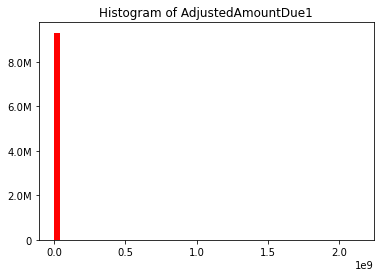

In [28]:
fig, ax = plt.subplots()
hist(ax, data1.select('AdjustedAmountDue1'), bins = 50, color=['red'])
plt.title("Histogram of AdjustedAmountDue1")
plt.show()

### Correlation analysis
Remove numerically correlated features with Pearson's correlation > 0.5 (the threshold can be discussed). Proceed to 'Drop columns' part if you want to run the whole model.

In [ ]:
c = data4.columns[-6:]
#data4 = data4.cast
for c1 in c:
  data4 = data4.withColumn(c1, data4[c1].cast("float"))

In [ ]:
data4.dtypes

In [ ]:
numeric_cols = []
for f in data4.schema.fields:
  if not isinstance(f.dataType, StringType):
    if not isinstance(f.dataType, DateType):
      numeric_cols.append(f.name)
numeric_cols

In [ ]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numeric_cols, outputCol=vector_col)
df_vector = assembler.transform(data4).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [ ]:
corr_matrix = matrix.collect()[0][0].toArray().tolist()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = numeric_cols, index=numeric_cols)

In [ ]:
numeric_corr_cols = ["OriginalTaxDue2", "AdjustedTaxDue2", "AssessedValuation", "EqualizedEvaluation", "LastPaymentReceivedAmount2",
 "TaxDueEstimated1", "LastPaymentReceivedAmount1", "AdjustedAmountDue1_Org",
 "InterestAmountDue1", "TotalAmountDue1", "InterestAmountDue2", "TotalAmountDue2",
 "SeniorExemptAmount", "VeteranExempt"
 ]

In [ ]:
corr_matrix_df = corr_matrix_df.drop(numeric_corr_cols, axis=1)
corr_matrix_df = corr_matrix_df.drop(numeric_corr_cols, axis=0)

In [ ]:
corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-80-68a7647adc47>:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)


### Outlier treatment
Outlier treatment of numerical variables capped by 1st and 99th percentile values, ie,
- if value < 1st percentile value, then use 1st percentile value
- if value > 99th percentile value, then use 99th percentile value

Proceed to 'Drop columns' part if you want to run the whole model.

In [ ]:
data1 = data1.withColumn("AdjustedAmountDue1", when(col("AdjustedAmountDue1")>3186751,3186751).otherwise(col("AdjustedAmountDue1")))

### Drop columns

- drop_cols_inst2 - Drop metrics related to installment2. This is needed for model 1 where we predict Late Payment for 2nd installment at Feb/Mar and we don't have information related to Installment 2 yet
- drop_cols_univariate (Univariate analysis) - Group by categorical variables and get the count & %count of each category. If one of the categories in the feature is >95%, then remove this feature as it will not be very useful in the model. Some exceptions are present where the feature makes good business sense to be included
- drop_cols_numric_corr - Drop numerical columns that are correlated with Pearsons correlation >0.5


In [30]:
drop_cols_inst2 = data1.columns[42:53] + ["LastPaymentSource2"]
drop_cols_unrelated = ["SegmentCode", "TaxpayerName", "TaxpayerMailingAddress", "TaxpayerMailingZip",
                       "TaxpayerPropertyHouse","TaxpayerPropertyDirection", "TaxpayerPropertyStreet",
                       "TaxpayerPropertyZip", "RecordCount"
                       ]
drop_cols_univariate = ["LongtimeHomeownersExempt", "TaxInfoType", "TaxType", "TaxpayerPropertyState", "BillYear", "SegmentCode2",
                        "InstallmentNumber1", "RefundTaxAmountDueIndicator1", "RefundInterestDueIndicator1",
                        "RefundTotalDueIndicator1", "RefundCostDueIndicator1", "EndMarker", "TaxpayerMailingCity",
                        "BankruptStatus", "AcquisitionStatus", "CondemnationStatus", "RefundStatus"
                        ]
drop_cols_numeric_corr = ["OriginalTaxDue2", "AdjustedTaxDue2", "AssessedValuation", "EqualizedEvaluation",
                          "LastPaymentReceivedAmount2", "TaxDueEstimated1", "LastPaymentReceivedAmount1",
                          "AdjustedAmountDue1_Org", "InterestAmountDue1", "TotalAmountDue1", "InterestAmountDue2",
                          "TotalAmountDue2", "SeniorExemptAmount", "VeteranExempt"]
drop_cols_rf_imp = ["DisabledPersonVetExemptionAmount", "DisabledVetExemptionAmount", "DisabledPersonExemptionAmount",
                    "ReturningVetExemptionAmount", "SeniorFreezeExempt", "MunicipalAcquisitionStatus",
                    "TaxpayerMailingState", "CofENumber", "Volume"
                    ]

In [ ]:
data1 = data1.drop(*drop_cols_inst2)
data1 = data1.drop(*drop_cols_unrelated)
data1 = data1.drop(*drop_cols_univariate)
data1 = data1.drop(*drop_cols_numeric_corr)
data1 = data1.drop(*drop_cols_rf_imp)

### Data Transformation

In [ ]:
data1 = data1.withColumn("TaxpayerPropertyCity", f.trim(data1.TaxpayerPropertyCity))
data1 = data1.withColumn("TaxpayerPropertyCity", when(data1.TaxpayerPropertyCity=="CHICAGO", 1).otherwise(0))
data1 = data1.withColumn("BillType", when(data1.BillType=="1", 1).otherwise(0))
data1 = data1.withColumn("DiffPmt1", f.datediff(col("LastPaymentDate1"), col("PmtDue1")))
data1 = data1.withColumn("DiffPmt1", when(col("DiffPmt1")<0,0).otherwise(col("DiffPmt1")))
data1 = data1.withColumn("TaxStatus", col("TaxStatus").cast("int"))
data1 = data1.withColumn("PastTaxSaleStatus", when(col("PastTaxSaleStatus")=="Y", 1).otherwise(0))

#data1 = data1.withColumn("PIN2Digit", substring(data1.PIN, 0, 2))
#data1 = data1.withColumn("TaxSale", when(data1.LastPaymentDate2=="00000000", 1).otherwise(0))
#data1 = data1.withColumn("CofENumber", when(data1.CofENumber=="0000000", 0).otherwise(1))
#data1 = data1.withColumn("Volume", col("Volume").cast("int"))
#data1 = data1.withColumn("TaxpayerMailingState", when(data1.TaxpayerMailingState=="IL", 1).otherwise(0))

In [31]:
# Persist data in disk/memory
# Until this point Spark does not actually execute any of the above statements (Lazy loading). It only creates a plan
# Persist does not get executed until an 'action' command is called on the dataframe (action is count() here)
data2 = data1.persist()
print([data2.count(), len(data2.columns)])

[4489595, 86]


### WOE Transformation

In [32]:
# Reference: https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html
def WOE_transform(df, var, y="LatePmt2"):
    woe_df = df.groupBy(var) \
        .agg(count(var).alias("cnt"), \
            sum(y).alias("cnt_1")) \
        .withColumn("cnt_0", col("cnt") - col("cnt_1")) \
        .withColumn("perc_1", col("cnt_1")/col("cnt")) \
        .withColumn("perc_0", col("cnt_0")/col("cnt")) \
        .withColumn("WOE_"+var, log(col("perc_0")/col("perc_1")))
    woe_df = woe_df.withColumn("WOE_"+var, f.round(col("WOE_"+var), 2))
    df = df.join(woe_df.select(*[var, "WOE_"+var]), [var])#.drop(woe_df[var])
    return(df)

In [33]:
woe_transform_cols = ["TaxpayerPropertySuffix", "Classification", "TaxpayerPropertyTown",
                       "TaxStatus", "AccountStatus", "LastPaymentSource1"
                      #, "PIN2Digit"
                      #"Volume", "TaxCode"
                      ]

In [34]:
for var in woe_transform_cols:
    data2 = WOE_transform(data2, var)
data2 = data2.drop(*woe_transform_cols)

In [35]:
data3 = data2.persist()
print([data3.count(), len(data3.columns)])

[4489595, 86]


### Window Transformations

In [ ]:
windowval1 = (Window.partitionBy('PIN').orderBy('TaxYear')
             .rangeBetween(Window.unboundedPreceding, 0))
data3 = data3.withColumn('PastTaxSaleStatusSum', F.sum('PastTaxSaleStatus').over(windowval1))
windowval2 = (Window.partitionBy('PIN').orderBy('TaxYear')
            .rowsBetween(Window.unboundedPreceding, Window.currentRow-1))
data3 = data3.withColumn('LatePmt2Sum', F.sum('LatePmt2').over(windowval2))
data3 = data3.na.fill(value=0,subset=["LatePmt2Sum"])

windowval3 = (Window.partitionBy('PIN').orderBy('TaxYear')
            .rowsBetween(Window.unboundedPreceding, 0))
data3 = data3.withColumn('LatePmt1Sum', F.sum('LatePmt1').over(windowval3))

In [ ]:
data4 = data3.persist()
print([data4.count(), len(data4.columns)])

### Drop other columns

In [ ]:
#data4 = data3

In [ ]:
other_cols = ["LastPaymentDate1", "LastPaymentDate2", "PmtDue1", "PmtDue2", "PIN", "Year"
              #, "LastPaid1"
             ]

In [ ]:
data4 = data4.drop(*woe_transform_cols)
data4 = data4.drop(*other_cols)

In [ ]:
for c in data4.columns:
    data4 = data4.withColumn(c, data4[c].cast('int'))

### Other temp fixes

In [ ]:
#from pyspark.sql.functions import col,isnan, when, count
#data4.select([f.count(when(col(c).isNull(), c)).alias(c) for c in data4.columns]).show()

In [ ]:
# Temporarily set null as 0. Needs rework
null_cols = ["WOE_Classification", "WOE_TaxStatus", "WOE_LastPaymentSource1", "WOE_TaxpayerPropertySuffix", "DiffPmt1"
             , "TaxYear"
            #,"PaymentCnt", "SourceIDCnt", "TotalPaid", "InstallmentNumber2"
            ]
for c in null_cols:
    data4 = data4.withColumn(c, when(data4[c].isNull(), 0).otherwise(data4[c]))

In [ ]:
#data4.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data4.columns]).show()

## Model Building

In [ ]:
def get_rf_metrics(predictions, actual):
    element=f.udf(lambda v:float(v[1]),FloatType())
    nums = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    acc = []
    f1 = []
    rec = []
    prec = []
    predictions2 = predictions.select(["probability"]) \
      .withColumn("probability", f.round(element("probability"), 2)) \
      .toPandas()
    for num in nums:
        #predictions2 = predictions.withColumn("prob_prediction", when(element("probability")>num, 1).otherwise(0))
        #pred = predictions2.select(predictions2.prob_prediction).toPandas()["prob_prediction"]
        pred = np.where(predictions2["probability"]>num, 1, 0)
        #pred = pred.tolist()
        acc.append(accuracy_score(actual, pred))
        f1.append(f1_score(actual, pred))
        rec.append(recall_score(actual, pred))
        prec.append(precision_score(actual, pred))
    res_df = pd.DataFrame(nums, columns=["Threshold"])
    res_df["Acc"] = acc
    res_df["F1"] = f1
    res_df["Rec"] = rec
    res_df["Prec"] = prec
    res_df
    return(res_df)

### Train Test Split

In [ ]:
feature_cols = data4.columns
feature_cols.remove("LatePmt2")


In [ ]:
from pyspark.ml.feature import VectorAssembler

# Convert all features into a vector with name 'features'
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data5 = assembler.transform(data4)

In [ ]:
# Test train split
#train, test = data4.randomSplit([0.8,0.2], seed=100)

# Test train split by Year (Year 2021 is Test)
test = data5.where(col("TaxYear")==2021)
train = data5.where(col("TaxYear")!=2021)

In [ ]:
train = train.persist()
train.count()

In [ ]:
#from pyspark.ml.classification import LogisticRegression
#logit = LogisticRegression(labelCol="LatePmt2")
#logit = logit.fit(train)

### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'LatePmt2'
                            #,maxDepth=10, numTrees=50, maxMemoryInMB=512
                            )
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
actual = test.select(test.LatePmt2).toPandas()['LatePmt2']

In [ ]:
res = get_rf_metrics(predictions, actual)
res 

In [50]:
predictions.where(col("prediction")==1).show(5)

+--------------------+-------+---------------+------------+-------+--------+------------------+-------------+--------------+------------------+-----------------+-------+------------+---------------------+------------------------+------------------------------+--------+--------+--------+--------------------------+------------------+------------------------+-------------+-----------------+----------------------+--------------------+-----------+-----------+--------------------+--------------------+--------------------+----------+
|TaxpayerPropertyCity|TaxCode|HomeownerExempt|SeniorExempt|TaxYear|BillType|AdjustedAmountDue1|TaxAmountDue1|CostAmountDue1|InstallmentNumber2|PastTaxSaleStatus|TaxRate|ExemptStatus|HomeownerExemptAmount|SeniorFreezeExemptAmount|LongtimeHomeownersExemptAmount|LatePmt1|LatePmt2|DiffPmt1|WOE_TaxpayerPropertySuffix|WOE_Classification|WOE_TaxpayerPropertyTown|WOE_TaxStatus|WOE_AccountStatus|WOE_LastPaymentSource1|PastTaxSaleStatusSum|LatePmt2Sum|LatePmt1Sum|         

In [ ]:
predictions2.where(col("prediction")==0).show(5, truncate=False)

+------+--------------------+--------------------+-------+---------------+------------+------------------+--------+------------------+-------------+--------------+----------+-----------------+-------+------------------+--------------------------+-----------------+------------+--------------+------------+---------------------------+-----------------------------+--------------------------+--------------------------------+---------------------+------------------------+------------------------------+--------+--------+--------+--------------------------+------------------+------------------------+-------------+-----------------+----------------------+--------------------+-----------+-----------+-------------------------------------------------------------------------------------------------------------------------+---------------------------------------+----------------------------------------+----------+---------------+
|Volume|TaxpayerMailingState|TaxpayerPropertyCity|TaxCode|HomeownerExe

In [ ]:
element=f.udf(lambda v:float(v[1]),FloatType())

In [ ]:
predictions2 = predictions.select(["probability"]) \
  .withColumn("probability", f.round(element("probability"), 2)) \
  .toPandas()
predictions2.head()

probability
0         0.03
1         0.15
2         0.05
3         0.05
4         0.10

In [ ]:
res_df = pd.DataFrame(nums, columns=["Threshold"])
res_df["Acc"] = acc
res_df["F1"] = f1
res_df["Rec"] = rec
res_df["Prec"] = prec
res_df

In [ ]:
cm = confusion_matrix(actual, pred)
tn, fp, fn, tp = cm.ravel()

In [ ]:
print("Accuracy: ", accuracy_score(actual, pred))
print("F1 Score: ", f1_score(actual, pred))
print("Precision: ", precision_score(actual, pred))
print("Recall: ", recall_score(actual, pred))

In [ ]:
print("True Negatives: ", tn)
print("False Positives: ", fp)
print("False Negatives: ", fn)
print("True Positives: ", tp)

True Negatives:  1661930
False Positives:  10219
False Negatives:  147196
True Positives:  45232


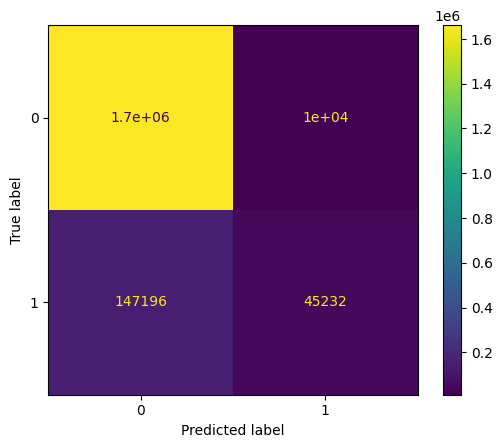

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Feature Importance

In [49]:
feat_imp = rfModel.featureImportances
feat_imp = [c for c in feat_imp]

In [50]:
train_cols = train.columns
train_cols.remove("features")
train_cols.remove("LatePmt2")
feat_df = pd.DataFrame(train_cols, columns=["Features"])
feat_df["Importance"] = feat_imp
feat_df = feat_df.sort_values("Importance", ascending=False)

In [51]:
feat_df

Features  Importance
17                        DiffPmt1    0.419502
26                     LatePmt1Sum    0.284580
16                        LatePmt1    0.123109
25                     LatePmt2Sum    0.058957
24            PastTaxSaleStatusSum    0.030865
23          WOE_LastPaymentSource1    0.029467
4                          TaxYear    0.023923
10               PastTaxSaleStatus    0.013428
20        WOE_TaxpayerPropertyTown    0.006278
12                    ExemptStatus    0.003859
11                         TaxRate    0.001648
2                  HomeownerExempt    0.001497
7                    TaxAmountDue1    0.000763
3                     SeniorExempt    0.000614
19              WOE_Classification    0.000567
22               WOE_AccountStatus    0.000494
21                   WOE_TaxStatus    0.000355
8                   CostAmountDue1    0.000063
14        SeniorFreezeExemptAmount    0.000018
1                          TaxCode    0.000009
6               AdjustedAmountDue1    0.000004
5                         BillType    0.000001
0             TaxpayerPropertyCity    0.000000
18      WOE_TaxpayerPropertySuffix    0.000000
15  LongtimeHomeownersExemptAmount    0.000000
9               InstallmentNumber2    0.000000
13           HomeownerExemptAmount    0.000000

### Rolling Window Model

In [ ]:
model1_year = [2017, 2018, 2019]
model2_year = [2018, 2019, 2020]

In [ ]:
test = data5.where(col("TaxYear")==2020)
train = data5.filter(col("TaxYear").isin(model1_year))
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'LatePmt2')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
actual = test.select(test.LatePmt2).toPandas()['LatePmt2']


In [ ]:
res_2020 = get_rf_metrics(predictions, actual)
res_2020

In [ ]:
test = data5.where(col("TaxYear")==2021)
train = data5.filter(col("TaxYear").isin(model2_year))
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'LatePmt2')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
actual = test.select(test.LatePmt2).toPandas()['LatePmt2']


In [ ]:
res_2021 = get_rf_metrics(predictions, actual)
res_2021

### Hyperparameter tuning

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'LatePmt2')
pipeline = Pipeline(stages=[assembler, rf])

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

cross_validator = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="LatePmt2", metricName="areaUnderROC"),
                          numFolds=3, seed=42)

In [ ]:
train, test = data4.randomSplit([0.8,0.2], seed=100)

In [ ]:
cv_model = cross_validator.fit(train)

In [46]:
res_full_2021 = get_rf_metrics(predictions, actual)
res_full_2021

0.2
0.25
0.3
0.35
0.4
0.45
0.5


Threshold       Acc        F1       Rec      Prec
0       0.20  0.860070  0.365431  0.726219  0.244141
1       0.25  0.901532  0.420428  0.643738  0.312146
2       0.30  0.915158  0.440408  0.601762  0.347288
3       0.35  0.929202  0.451283  0.524745  0.395863
4       0.40  0.934851  0.452317  0.484897  0.423838
5       0.45  0.939178  0.445668  0.440687  0.450763
6       0.50  0.941560  0.436175  0.407436  0.469276

In [50]:
# Remove WOE
res_WOE_removed = get_rf_metrics(predictions, actual)
res_WOE_removed

23/07/01 15:29:46 WARN MemoryStore: Not enough space to cache rdd_456_0 in memory! (computed 4.6 MiB so far)


0.2
0.25
0.3
0.35
0.4
0.45
0.5


Threshold       Acc        F1       Rec      Prec
0       0.20  0.890364  0.408389  0.682058  0.291448
1       0.25  0.920548  0.444601  0.573192  0.363135
2       0.30  0.927470  0.449047  0.532754  0.388072
3       0.35  0.930989  0.452902  0.514861  0.404254
4       0.40  0.934912  0.453196  0.486164  0.424415
5       0.45  0.938652  0.447301  0.447448  0.447154
6       0.50  0.941602  0.434008  0.403567  0.469417

In [52]:
train1 = train.toPandas()

23/07/06 14:45:08 ERROR Executor: Exception in task 68.0 in stage 2052.0 (TID 17360)
java.lang.OutOfMemoryError: Java heap space
	at java.base/java.lang.reflect.Array.newInstance(Array.java:78)
	at java.base/java.io.ObjectInputStream.readArray(ObjectInputStream.java:2132)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1732)
	at java.base/java.io.ObjectInputStream.readArray(ObjectInputStream.java:2168)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1732)
	at java.base/java.io.ObjectInputStream$FieldValues.<init>(ObjectInputStream.java:2617)
	at java.base/java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2468)
	at java.base/java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2268)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1744)
	at java.base/java.io.ObjectInputStream.readObject(ObjectInputStream.java:514)
	at java.base/java.io.ObjectInputStream.readObject(ObjectInputStre

Py4JJavaError: An error occurred while calling o638.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 68 in stage 2052.0 failed 1 times, most recent failure: Lost task 68.0 in stage 2052.0 (TID 17360) (sagars-mbp executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.base/java.lang.reflect.Array.newInstance(Array.java:78)
	at java.base/java.io.ObjectInputStream.readArray(ObjectInputStream.java:2132)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1732)
	at java.base/java.io.ObjectInputStream.readArray(ObjectInputStream.java:2168)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1732)
	at java.base/java.io.ObjectInputStream$FieldValues.<init>(ObjectInputStream.java:2617)
	at java.base/java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2468)
	at java.base/java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2268)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1744)
	at java.base/java.io.ObjectInputStream.readObject(ObjectInputStream.java:514)
	at java.base/java.io.ObjectInputStream.readObject(ObjectInputStream.java:472)
	at org.apache.spark.serializer.JavaDeserializationStream.readObject(JavaSerializer.scala:87)
	at org.apache.spark.serializer.DeserializationStream$$anon$1.getNext(Serializer.scala:168)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.maybeCacheDiskValuesInMemory(BlockManager.scala:1681)
	at org.apache.spark.storage.BlockManager.getLocalValues(BlockManager.scala:960)
	at org.apache.spark.storage.BlockManager.get(BlockManager.scala:1275)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1342)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:375)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:326)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2328)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1019)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1018)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3997)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4167)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:526)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4165)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:118)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:103)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:827)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4165)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3994)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.base/java.lang.reflect.Array.newInstance(Array.java:78)
	at java.base/java.io.ObjectInputStream.readArray(ObjectInputStream.java:2132)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1732)
	at java.base/java.io.ObjectInputStream.readArray(ObjectInputStream.java:2168)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1732)
	at java.base/java.io.ObjectInputStream$FieldValues.<init>(ObjectInputStream.java:2617)
	at java.base/java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2468)
	at java.base/java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2268)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1744)
	at java.base/java.io.ObjectInputStream.readObject(ObjectInputStream.java:514)
	at java.base/java.io.ObjectInputStream.readObject(ObjectInputStream.java:472)
	at org.apache.spark.serializer.JavaDeserializationStream.readObject(JavaSerializer.scala:87)
	at org.apache.spark.serializer.DeserializationStream$$anon$1.getNext(Serializer.scala:168)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.maybeCacheDiskValuesInMemory(BlockManager.scala:1681)
	at org.apache.spark.storage.BlockManager.getLocalValues(BlockManager.scala:960)
	at org.apache.spark.storage.BlockManager.get(BlockManager.scala:1275)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1342)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:375)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:326)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 54031)
Traceback (most recent call last):
  File "/Users/sagarshekhargoudapatil/opt/anaconda3/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/sagarshekhargoudapatil/opt/anaconda3/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/sagarshekhargoudapatil/opt/anaconda3/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/sagarshekhargoudapatil/opt/anaconda3/lib/python3.9/socketserver.py", line 747, in __init__
    self.handle()
  File "/Users/sagarshekhargoudapatil/opt/anaconda3/lib/python3.9/site-packages/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/Users/sagarshekhargoudapatil/opt/anaconda3/lib/python3.9/site-